In [1]:
# Install libraries that might not be pre-installed or need specific versions/sources
# Using -q for quieter output during installation
!pip install -q keybert>=0.7.0
!pip install -q sentence-transformers>=2.2.2
!pip install -q --no-cache-dir git+https://github.com/boudinfl/pke.git # PKE needs to be installed from GitHub
!pip install -q spacy>=3.0.0

# Uncomment the line below ONLY if you consistently face issues with NLTK WordNet later
!pip install -q nltk==3.9b1 --force-reinstall

print("Required libraries installed/updated.")
import nltk
import os # Import os library for path operations

# Define a Kaggle-friendly path for NLTK data
kaggle_nltk_path = '/kaggle/working/nltk_data'
os.makedirs(kaggle_nltk_path, exist_ok=True)

# Check if the path is already added, if not, append it
if kaggle_nltk_path not in nltk.data.path:
    nltk.data.path.append(kaggle_nltk_path)
    print(f"Added {kaggle_nltk_path} to NLTK data path.")
else:
    print(f"{kaggle_nltk_path} already in NLTK data path.")

# Download required NLTK resources to the specified path
resources_to_download = ['stopwords', 'punkt', 'wordnet', 'omw-1.4']
print("Downloading NLTK resources (if not already present)...")
for resource in resources_to_download:
    try:
        nltk.data.find(f'corpora/{resource}') # More specific check
        print(f"   - Resource '{resource}' found.")
    except LookupError:
        print(f"   - Downloading '{resource}'...")
        nltk.download(resource, download_dir=kaggle_nltk_path, quiet=True) # Use quiet download
print("NLTK resource check complete.")

# Verify WordNet specifically after download
try:
    from nltk.corpus import wordnet as wn
    _ = wn.synsets('test')
    print("NLTK WordNet is accessible.")
except Exception as e:
    print(f"Warning: Potential issue accessing WordNet after download: {e}")
    print("The main code contains fallback mechanisms, but check installation if lemmatization fails.")


# Download the required spaCy English model
# The code tries to load 'en_core_web_sm'. If it fails, it should download it.
# Running this command explicitly ensures it's downloaded beforehand.
!python -m spacy download en_core_web_sm -q
print("SpaCy model 'en_core_web_sm' download command executed (if not already present).")

# Standard Libraries
import re
import string
import math
import os
import pickle
import gc
import time
import sys
import subprocess
import importlib
import io
import base64
from collections import Counter
from typing import List, Dict, Tuple, Set, Optional, Union, Any

# Third-party Libraries
import torch
import numpy as np
import pandas as pd
import spacy
from spacy.language import Language # Needed for AbstractiveExtractor's NER type hints
import pke
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn # Import wordnet alias as used in the code
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag # Imported specifically in AbstractiveExtractor
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support # For test/analysis code
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, set_seed, pipeline
import matplotlib.pyplot as plt # For test/analysis code
import seaborn as sns # For test/analysis code

# Optional: Set a specific device early if needed, although the classes handle it.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# Import your custom classes (assuming they are defined in subsequent cells or .py files uploaded to Kaggle)
# Example: If your classes are defined below this cell, you don't need these lines here.
# If they are in .py files uploaded as utility scripts:
# from Extractive_code import HybridExtractiveKeyphraseExtractor
# from Abstractive_code import AbstractiveKeyphraseExtractor
# from Fusion_code import FusionKeyphraseExtractor # Assuming a Fusion_code.py file

print("All libraries imported.")

# Optional: Include the NLTK WordNet setup function if needed outside the class init
# setup_nltk_wordnet() function from the test code - requires modifications for Kaggle paths
# ... (rest of your code, including class definitions and main execution logic) ...


# ===== WORDNET INSTALLATION TEST =====
# This script tests if WordNet is properly installed and accessible

import os
import nltk
import sys
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

print("\n" + "="*50)
print("WORDNET INSTALLATION TEST")
print("="*50)

# 1. Check NLTK data paths
print("NLTK data paths:")
for path in nltk.data.path:
    print(f"- {path}")
    if os.path.exists(path):
        print(f"  ✓ Path exists")
        # List contents if it exists
        if os.path.isdir(path):
            contents = os.listdir(path)
            if 'corpora' in contents:
                print(f"  ✓ 'corpora' directory found")
                corpora_path = os.path.join(path, 'corpora')
                corpora_contents = os.listdir(corpora_path)
                print(f"  Corpora contents: {', '.join(corpora_contents[:5])}...")
                if 'wordnet' in corpora_contents:
                    print(f"  ✓ 'wordnet' directory found in corpora")
                    wordnet_path = os.path.join(corpora_path, 'wordnet')
                    if os.path.isdir(wordnet_path):
                        wordnet_contents = os.listdir(wordnet_path)
                        print(f"  Wordnet contents: {', '.join(wordnet_contents[:5])}...")
                    else:
                        print(f"  ✗ 'wordnet' is not a directory")
                else:
                    print(f"  ✗ 'wordnet' directory NOT found in corpora")
            else:
                print(f"  ✗ 'corpora' directory NOT found")
    else:
        print(f"  ✗ Path does not exist")

# 2. Try to download WordNet explicitly
print("\nAttempting to download WordNet:")
nltk.download('wordnet', quiet=False)

# 3. Test WordNet directly
print("\nTesting WordNet directly:")
try:
    from nltk.corpus import wordnet as wn
    synsets = wn.synsets('test')
    print(f"✓ Successfully loaded WordNet")
    print(f"Found {len(synsets)} synsets for 'test'")
    if len(synsets) > 0:
        print(f"First synset: {synsets[0].name()}, definition: {synsets[0].definition()}")
except Exception as e:
    print(f"✗ Error loading WordNet: {e}")

# 4. Test lemmatization
print("\nTesting lemmatization:")
try:
    lemmatizer = WordNetLemmatizer()
    test_words = [("running", "v"), ("better", "a"), ("cars", "n"), ("is", "v")]
    
    for word, pos in test_words:
        try:
            lemmatized = lemmatizer.lemmatize(word, pos)
            print(f"  '{word}' ({pos}) -> '{lemmatized}' ✓")
        except Exception as word_error:
            print(f"  '{word}' ({pos}) -> Error: {word_error} ✗")
except Exception as e:
    print(f"✗ Error initializing lemmatizer: {e}")

# 5. Create a custom WordNetLemmatizer that doesn't fail
print("\nCreating a robust lemmatizer:")

class RobustLemmatizer:
    def __init__(self):
        self.wordnet_available = False
        try:
            self.lemmatizer = WordNetLemmatizer()
            # Test if it works
            self.lemmatizer.lemmatize("test")
            self.wordnet_available = True
            print("✓ WordNetLemmatizer is working")
        except Exception as e:
            print(f"✗ WordNetLemmatizer failed: {e}")
            print("Using fallback lemmatization")
    
    def lemmatize(self, word, pos='n'):
        if self.wordnet_available:
            try:
                return self.lemmatizer.lemmatize(word, pos)
            except:
                return word
        else:
            # Simple fallback rules
            if pos == 'v' and word.endswith('ing'):
                return word[:-3]  # Remove 'ing'
            elif pos == 'n' and word.endswith('s'):
                return word[:-1]  # Remove plural 's'
            return word

# Test the robust lemmatizer
robust_lemmatizer = RobustLemmatizer()
print("\nTesting robust lemmatizer:")
for word, pos in test_words:
    lemmatized = robust_lemmatizer.lemmatize(word, pos)
    print(f"  '{word}' ({pos}) -> '{lemmatized}'")

print("\n" + "="*50)
print("TEST COMPLETE")
print("="*50)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, 

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Ex code

In [ ]:
import torch
import numpy as np
import spacy
import pke
import nltk
import re
import string
import math
import os
import pickle
from collections import Counter
from typing import List, Dict, Tuple, Set, Optional, Union, Any
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

try:
    nltk.data.find('stopwords')
    nltk.data.find('punkt')
    nltk.data.find('wordnet')
    nltk.data.find('omw-1.4')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

try:
    import nltk.corpus.reader.wordnet
    from nltk.corpus import wordnet as wn

    if not hasattr(wn, '_morphy') or not hasattr(wn, 'morphy'):
        nltk.download('wordnet')
        nltk.download('omw-1.4')

        if not hasattr(wn, '_morphy') or not hasattr(wn, 'morphy'):
            from nltk.stem.wordnet import WordNetLemmatizer
            original_init = WordNetLemmatizer.__init__

            def patched_init(self):
                self.lemmatize = lambda word, pos='n': word

            WordNetLemmatizer.__init__ = patched_init
            print("Applied NLTK 3.9 WordNet lemmatizer patch")
except Exception as e:
    print(f"Warning: NLTK WordNet initialization error: {e}")
    print("Trying alternative approach...")
    try:
        import sys
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk==3.9b1", "--force-reinstall"])
        print("Installed NLTK 3.9b1 as a workaround")

        import importlib
        importlib.reload(nltk)
        nltk.download('wordnet')
        nltk.download('omw-1.4')
    except Exception as e2:
        print(f"Warning: Could not fix NLTK WordNet issue: {e2}")
        print("Lemmatization will be disabled")

class HybridExtractiveKeyphraseExtractor:
    

    DOMAIN_STOPWORDS = {
        'general': ['etc', 'e.g', 'i.e'],
        'tech': ['technology', 'technologies'],
        'business': ['business', 'company'],
        'science': ['study', 'studies'],
        'news': ['report', 'reported', 'according']
    }

    BOUNDARY_WORDS = {
        'the', 'a', 'an', 'this', 'that', 'these', 'those', 'their', 'our', 'your',
        'its', 'his', 'her', 'they', 'them', 'which', 'what', 'who', 'whom', 'whose'
    }

    def __init__(
    self,
    model_name: str = "all-mpnet-base-v2",
    use_gpu: bool = True,
    top_n: int = 20,
    language: str = "en",
    alpha: float = 1.1,
    threshold: float = 0.74,
    method: str = 'mmr',
    min_df: int = 1,
    redundancy_threshold: float = 0.80,
    diversity_penalty: float = 0.5,
    prioritize_named_entities: bool = False,
    ngram_range: Tuple[int, int] = (1, 3),
    clean_boundaries: bool = True,
    use_noun_chunks: bool = True,
    boost_exact_matches: bool = True,
    use_position_weight: bool = True,
    use_tfidf_weight: bool = True,
    use_ensemble: bool = True,
    use_lemmatization: bool = True,
    use_partial_matching: bool = True,
    use_semantic_matching: bool = True,
    use_enhanced_pos_filtering: bool = True,
    use_title_lead_boost: bool = True,
    method_weights: Dict[str, float] = None,
    idf_corpus_path: str = None
    ):
        
        self.top_n = top_n
        self.language = language
        self.alpha = alpha
        self.threshold = threshold
        self.method = method
        self.min_df = min_df
        self.redundancy_threshold = redundancy_threshold
        self.diversity_penalty = diversity_penalty
        self.model_name = model_name
        self.prioritize_named_entities = prioritize_named_entities
        self.ngram_range = ngram_range
        self.clean_boundaries = clean_boundaries
        self.use_noun_chunks = use_noun_chunks
        self.boost_exact_matches = boost_exact_matches
        self.use_position_weight = use_position_weight
        self.use_tfidf_weight = use_tfidf_weight
        self.use_ensemble = use_ensemble
        self.use_enhanced_pos_filtering = use_enhanced_pos_filtering
        self.use_title_lead_boost = use_title_lead_boost
        self.use_lemmatization = use_lemmatization
        self.use_partial_matching = use_partial_matching
        self.use_semantic_matching = use_semantic_matching

        self.lemmatizer = WordNetLemmatizer()

        if method_weights is None:
            self.method_weights = {
                'keybert': 0.50,
                'multipartiterank': 0.25,
                'textrank': 0.15,
                'yake': 0.10
            }
        else:
            self.method_weights = method_weights
        self.tfidf_vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        stop_words='english',
        max_features=10000,
        min_df=1,
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
        )
        self.initialize_idf_corpus(idf_corpus_path)

        self.word_tfidf_cache = {}

        try:
            try:
                from nltk.corpus import stopwords
                self.all_stopwords = set(stopwords.words('english'))
            except (ImportError, ModuleNotFoundError):
                nltk.download('stopwords')
                self.all_stopwords = set([
                    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                    'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
                    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
                    'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
                    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
                    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
                    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
                    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
                    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                    's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
                ])
        except Exception as e:
            print(f"Warning: Error loading stopwords: {e}")
            self.all_stopwords = set(['a', 'an', 'the', 'and', 'or', 'but', 'if', 'because', 'as', 'what', 'when', 'where', 'how', 'why', 'who'])

        for domain, words in self.DOMAIN_STOPWORDS.items():
            self.all_stopwords.update(words)

        self.device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"
        print(f"Using device: {self.device}")

        print(f"Loading SentenceTransformer model: {model_name}")
        try:
            from sentence_transformers import SentenceTransformer
            self.sentence_model = SentenceTransformer(model_name)
            self.sentence_model.to(self.device)
        except Exception as e:
            print(f"Error loading SentenceTransformer: {str(e)}")
            raise

        print("Loading KeyBERT")
        try:
            from keybert import KeyBERT
            self.kw_model = KeyBERT(model=self.sentence_model)
        except Exception as e:
            print(f"Error loading KeyBERT: {str(e)}")
            raise

        try:
            import spacy
            try:
                self.nlp = spacy.load("en_core_web_sm")
            except OSError:
                print("Downloading spaCy model...")
                import subprocess
                subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
                self.nlp = spacy.load("en_core_web_sm")
        except ImportError:
            print("spaCy not available, using simplified document classification")
            self.nlp = None

        print("Advanced Hybrid Extractive Keyphrase Extractor initialized with ensemble methods")

    def post_process_keyphrases(self, keyphrases: List[Tuple[str, float]], text: str) -> List[Tuple[str, float]]:
        
        processed_keyphrases = []

        prefixes_to_remove = ['the ', 'a ', 'an ', 'this ', 'that ', 'these ', 'those ']

        for kp, score in keyphrases:
            if self.clean_boundaries:
                kp = self.clean_phrase_boundaries(kp)

            for prefix in prefixes_to_remove:
                if kp.lower().startswith(prefix):
                    kp = kp[len(prefix):]
                    break

            text_lower = text.lower()
            kp_lower = kp.lower()

            if kp_lower in text_lower:
                start_idx = text_lower.find(kp_lower)
                exact_form = text[start_idx:start_idx+len(kp_lower)]

                if exact_form[0].isupper():
                    kp = exact_form

            if kp and len(kp.split()) <= self.ngram_range[1]:
                processed_keyphrases.append((kp, score))

        if self.use_enhanced_pos_filtering:
            processed_keyphrases = self.filter_by_pos_patterns(processed_keyphrases)

        return processed_keyphrases

    def filter_by_pos_patterns(self, keyphrases: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
        
        if not self.use_enhanced_pos_filtering or not self.nlp:
            return keyphrases

        filtered_keyphrases = []

        acceptable_patterns = [
            (['NOUN'], 0.95),
            (['PROPN'], 1.0),

            (['ADJ', 'NOUN'], 1.1),
            (['NOUN', 'NOUN'], 1.05),
            (['PROPN', 'PROPN'], 1.1),
            (['PROPN', 'NOUN'], 1.05),
            (['NOUN', 'PROPN'], 1.05),

            (['ADJ', 'NOUN', 'NOUN'], 1.15),
            (['ADJ', 'ADJ', 'NOUN'], 1.1),
            (['NOUN', 'NOUN', 'NOUN'], 1.05),
            (['PROPN', 'PROPN', 'PROPN'], 1.1),
            (['NOUN', 'PROPN', 'PROPN'], 1.05),
            (['PROPN', 'NOUN', 'NOUN'], 1.05),

            (['ADJ', 'NOUN', 'NOUN', 'NOUN'], 1.1),
            (['ADJ', 'ADJ', 'NOUN', 'NOUN'], 1.1),
            (['NOUN', 'PROPN', 'PROPN', 'PROPN'], 1.05),

            (['NOUN', 'ADP', 'NOUN'], 0.9),
            (['PROPN', 'ADP', 'NOUN'], 0.9),
            (['PROPN', 'ADP', 'PROPN'], 0.9),
            (['NOUN', 'ADP', 'PROPN'], 0.9),
            (['ADJ', 'NOUN', 'ADP', 'NOUN'], 0.95),

            (['VERB', 'NOUN'], 0.85),
            (['VERB', 'PROPN'], 0.85),
            (['VERB', 'ADJ', 'NOUN'], 0.9),
        ]

        low_quality_patterns = [
            (['DET'], 0.5),
            (['ADP'], 0.5),
            (['ADJ'], 0.7),
            (['VERB'], 0.7),
            (['ADV'], 0.6),
            (['DET', 'NOUN'], 0.8),
            (['ADP', 'NOUN'], 0.7),
            (['ADV', 'ADJ'], 0.7),
            (['VERB', 'DET'], 0.6),
        ]

        for kp, score in keyphrases:
            if not kp.strip():
                continue

            doc = self.nlp(kp)

            pos_tags = [token.pos_ for token in doc]

            matched = False
            score_multiplier = 1.0

            if len(pos_tags) <= 5:
                for pattern, multiplier in acceptable_patterns:
                    if pos_tags == pattern:
                        matched = True
                        score_multiplier = multiplier
                        break

                if not matched:
                    for pattern, multiplier in acceptable_patterns:
                        if len(pattern) <= len(pos_tags) and pos_tags[:len(pattern)] == pattern:
                            matched = True
                            score_multiplier = multiplier * 0.95
                            break

                if not matched:
                    for pattern, multiplier in low_quality_patterns:
                        if pos_tags == pattern or (len(pattern) <= len(pos_tags) and pos_tags[:len(pattern)] == pattern):
                            matched = True
                            score_multiplier = multiplier
                            break
            else:
                for pattern, multiplier in acceptable_patterns:
                    if len(pattern) <= len(pos_tags) and pos_tags[:len(pattern)] == pattern:
                        matched = True
                        score_multiplier = multiplier * 0.9
                        break

                if not matched and pos_tags and pos_tags[0] in ['NOUN', 'PROPN']:
                    matched = True
                    score_multiplier = 0.9

            if matched:
                adjusted_score = min(score * score_multiplier, 1.0)
                filtered_keyphrases.append((kp, adjusted_score))
            elif len(pos_tags) > 0 and pos_tags[0] in ['NOUN', 'PROPN', 'ADJ']:
                adjusted_score = min(score * 0.85, 1.0)
                filtered_keyphrases.append((kp, adjusted_score))

        if len(filtered_keyphrases) < len(keyphrases) * 0.3:
            print(f"Warning: POS filtering removed too many keyphrases ({len(keyphrases)} -> {len(filtered_keyphrases)}). Using original list.")
            return keyphrases

        return filtered_keyphrases

    def initialize_idf_corpus(self, corpus_path: str = None):
        
        if corpus_path and os.path.exists(corpus_path):
            try:
                with open(corpus_path, 'rb') as f:
                    self.idf_values = pickle.load(f)
                print(f"Loaded IDF corpus with {len(self.idf_values)} terms")
                return
            except Exception as e:
                print(f"Error loading IDF corpus: {e}")

        print("Creating comprehensive news-focused IDF corpus")

        news_corpus = [
            "The President signed an executive order addressing climate change and environmental protection measures.",
            "Congress passed a new bill aimed at infrastructure development with bipartisan support.",
            "The Supreme Court ruled on a landmark case regarding privacy rights in the digital age.",
            "Election polls show a tight race between the incumbent and challenger in key swing states.",
            "Diplomatic tensions escalated after the ambassador was recalled following controversial statements.",
            "The Senate committee held hearings on proposed legislation for healthcare reform.",
            "Local government officials announced new initiatives to address homelessness in urban areas.",
            "International leaders gathered at the summit to discuss global trade agreements.",
            "The administration faced criticism over its handling of the border security situation.",
            "Voters expressed concerns about economic policies ahead of the upcoming election.",

            "The stock market reached record highs following positive economic indicators and strong earnings reports.",
            "The Federal Reserve announced changes to interest rates, impacting mortgage and loan markets.",
            "The tech giant unveiled plans for a major expansion, creating thousands of new jobs.",
            "Inflation rates rose to their highest level in a decade, affecting consumer purchasing power.",
            "The company reported quarterly earnings that exceeded analysts' expectations by 15 percent.",
            "Supply chain disruptions continue to affect manufacturing sectors across multiple industries.",
            "The startup secured $50 million in venture capital funding for its innovative platform.",
            "Unemployment figures dropped to 4.5 percent, signaling continued economic recovery.",
            "The retail sector saw significant growth in online sales while physical stores struggled.",
            "The cryptocurrency market experienced volatility following regulatory announcements.",

            "Artificial intelligence advancements are transforming industries from healthcare to finance.",
            "The new smartphone features a revolutionary camera system and faster processor technology.",
            "Cybersecurity experts warned of increasing ransomware threats targeting critical infrastructure.",
            "Cloud computing services continue to grow as businesses move away from on-premises solutions.",
            "The social media platform introduced new features to address privacy concerns and misinformation.",
            "Quantum computing researchers achieved a breakthrough in error correction techniques.",
            "The electric vehicle manufacturer announced a new battery technology with extended range.",
            "Virtual reality applications are expanding beyond gaming into education and healthcare.",
            "The semiconductor shortage has impacted production across automotive and electronics industries.",
            "5G network deployment accelerated, promising faster connectivity and new applications.",

            "Researchers published promising results from clinical trials of the new cancer treatment.",
            "The vaccine showed 95 percent efficacy in preventing the disease in large-scale studies.",
            "Scientists discovered a new species in the remote rainforest region during the expedition.",
            "The space telescope captured unprecedented images of distant galaxies, revealing new data.",
            "Medical experts issued updated guidelines for managing chronic conditions and preventive care.",
            "The genomic study identified key genetic factors associated with longevity and disease resistance.",
            "Climate scientists reported accelerating ice melt in polar regions exceeding previous models.",
            "The public health department launched initiatives to address mental health awareness.",
            "Researchers developed a new diagnostic tool using artificial intelligence algorithms.",
            "The pharmaceutical company received approval for its breakthrough treatment for rare diseases.",

            "Record-breaking temperatures were recorded across multiple regions during the summer months.",
            "Renewable energy installations surpassed fossil fuel capacity additions for the first time.",
            "Conservation efforts successfully increased the population of the endangered species.",
            "The environmental impact assessment revealed concerns about the proposed development project.",
            "Extreme weather events caused significant damage to coastal communities and infrastructure.",
            "Sustainable agriculture practices gained traction as concerns about food security increased.",
            "The international agreement established new targets for reducing carbon emissions by 2030.",
            "Ocean plastic pollution reached alarming levels according to the latest marine research.",
            "Urban planning initiatives focused on green infrastructure and reducing carbon footprints.",
            "The drought conditions affected agricultural production across multiple growing regions.",

            "The university announced a major expansion of its online degree programs and digital learning.",
            "School districts implemented new curriculum standards focusing on STEM education.",
            "Research findings highlighted the impact of early childhood education on long-term outcomes.",
            "The education department allocated additional funding for underserved communities.",
            "Students demonstrated improved performance following the implementation of the new teaching methods.",
            "The college admissions process underwent significant changes to address equity concerns.",
            "Educational technology startups developed innovative tools for personalized learning experiences.",
            "Teachers adapted to hybrid learning models combining in-person and virtual instruction.",
            "The study examined the effectiveness of different approaches to literacy development.",
            "Higher education institutions faced challenges addressing student mental health needs.",

            "The film won multiple awards at the festival, receiving critical acclaim for its direction.",
            "The streaming service announced a slate of original content productions for the coming year.",
            "The musician's latest album debuted at number one on the charts with record-breaking streams.",
            "The art exhibition featured works exploring themes of identity and social justice.",
            "The bestselling novel will be adapted into a television series by the acclaimed director.",
            "Cultural institutions implemented digital initiatives to reach audiences during closures.",
            "The celebrity announced their involvement in humanitarian efforts addressing global issues.",
            "The video game release broke sales records with millions of copies sold in the first week.",
            "The theater production received standing ovations for its innovative staging and performances.",
            "Social media influencers partnered with brands on campaigns targeting younger demographics.",

            "The team secured the championship title after a dramatic overtime victory in the final game.",
            "The athlete broke the world record that had stood for over a decade in the competition.",
            "The league announced new safety protocols following concerns about player injuries.",
            "The international tournament drew record viewership across global broadcasting platforms.",
            "The coach implemented strategic changes that transformed the team's performance this season.",
            "The player signed a record-breaking contract extension with the franchise.",
            "The Olympic committee finalized preparations for the upcoming summer games.",
            "The sports technology company introduced advanced analytics tools for performance tracking.",
            "The stadium renovation project will increase capacity and enhance the fan experience.",
            "The investigation into alleged rule violations resulted in sanctions against the organization.",

            "The investigation led to multiple arrests in connection with the organized crime operation.",
            "The court ruling established a precedent for future cases involving digital privacy rights.",
            "Law enforcement agencies implemented new training programs focused on community relations.",
            "The jury reached a verdict after deliberating for three days in the high-profile case.",
            "The legislation introduced stricter penalties for specific categories of financial crimes.",
            "The forensic evidence played a crucial role in identifying the suspect in the investigation.",
            "The prison reform initiative aimed to reduce recidivism through education and rehabilitation.",
            "The legal challenge questioned the constitutionality of the recently passed legislation.",
            "The settlement agreement included significant compensation for affected individuals.",
            "The regulatory agency imposed fines following violations of consumer protection standards.",

            "The housing initiative aimed to address affordability challenges in metropolitan areas.",
            "Community organizations partnered to provide resources for vulnerable populations.",
            "The study documented disparities in access to essential services across different demographics.",
            "Activists organized peaceful demonstrations advocating for policy changes and social justice.",
            "The report highlighted progress and ongoing challenges in workplace diversity and inclusion.",
            "Urban development projects focused on revitalizing neighborhoods while preventing displacement.",
            "The survey revealed changing attitudes toward social issues among younger generations.",
            "Nonprofit organizations expanded programs addressing food insecurity in underserved communities.",
            "The panel discussion explored intersections between technology and social equity concerns.",
            "The initiative provided support services for veterans transitioning to civilian life."
        ]

        specialized_terminology = [
            "Legislation is being debated in parliament regarding constitutional amendments and electoral reform.",
            "Bipartisan support is needed for the bill to pass through both chambers of congress.",
            "The filibuster prevented the vote on the controversial legislation despite majority support.",
            "Gerrymandering has affected district boundaries, potentially impacting election outcomes.",
            "The caucus meeting determined the party's position on key policy initiatives.",

            "Quantitative easing measures were implemented by the central bank to stimulate economic growth.",
            "The yield curve inversion raised concerns about potential recession indicators.",
            "Fiscal policy adjustments were recommended to address the growing budget deficit.",
            "Market volatility increased following uncertainty about monetary policy directions.",
            "The merger and acquisition activity accelerated in the technology sector this quarter.",

            "The neural network architecture demonstrated superior performance in natural language processing tasks.",
            "Blockchain technology applications expanded beyond cryptocurrencies into supply chain verification.",
            "The API integration enabled seamless connectivity between multiple software platforms.",
            "Machine learning algorithms identified patterns that human analysts had overlooked.",
            "The Internet of Things devices created a comprehensive monitoring system for the facility.",

            "The genome sequencing revealed previously unknown genetic markers associated with the condition.",
            "Quantum entanglement experiments demonstrated non-local correlations between particles.",
            "The clinical trial entered phase three testing after promising preliminary results.",
            "Neuroplasticity research suggested new approaches to rehabilitation after brain injury.",
            "The particle accelerator experiments provided data supporting theoretical predictions.",

            "Biodiversity conservation efforts focused on protecting critical habitat corridors.",
            "Carbon sequestration technologies were evaluated for large-scale implementation potential.",
            "Renewable energy integration presented challenges for existing power grid infrastructure.",
            "Ecosystem services valuation informed policy decisions regarding natural resource management.",
            "Climate mitigation strategies included both technological solutions and behavioral changes."
        ]

        comprehensive_corpus = news_corpus + specialized_terminology

        corpus_vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            stop_words='english',
            max_features=20000,
            min_df=2,
            max_df=0.9,
            norm='l2',
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        )

        corpus_vectorizer.fit(comprehensive_corpus)

        try:
            feature_names = corpus_vectorizer.get_feature_names_out()
        except AttributeError:
            feature_names = corpus_vectorizer.get_feature_names()

        self.idf_values = {}
        for term, idf_idx in corpus_vectorizer.vocabulary_.items():
            self.idf_values[term] = corpus_vectorizer.idf_[idf_idx]

        print(f"Created comprehensive IDF corpus with {len(self.idf_values)} terms")

        additional_terms = {
            "breaking news": 2.0,
            "exclusive report": 3.0,
            "sources say": 1.8,
            "according to officials": 1.5,
            "press conference": 2.2,
            "official statement": 2.3,
            "developing story": 2.1,
            "anonymous source": 2.8,
            "public opinion": 2.5,
            "latest update": 1.9,

            "united nations": 4.0,
            "world health organization": 4.2,
            "european union": 3.8,
            "federal reserve": 4.1,
            "supreme court": 3.9,
            "white house": 3.7,
            "wall street": 3.6,
            "silicon valley": 4.3,
            "climate change": 3.5,
            "artificial intelligence": 4.5
        }

        for term, idf in additional_terms.items():
            self.idf_values[term] = idf

        print(f"Added {len(additional_terms)} additional news-specific terms")
        print(f"Final IDF corpus contains {len(self.idf_values)} terms")

        if corpus_path:
            try:
                os.makedirs(os.path.dirname(corpus_path), exist_ok=True)
                with open(corpus_path, 'wb') as f:
                    pickle.dump(self.idf_values, f)
                print(f"Saved IDF corpus to {corpus_path}")
            except Exception as e:
                print(f"Error saving IDF corpus: {e}")

    def normalize_text(self, text: str) -> str:
        
        text = re.sub(r'\s+', ' ', text)

        text = re.sub(r'[^\w\s\-\']', ' ', text)

        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def clean_phrase_boundaries(self, phrase: str) -> str:
        
        if not self.clean_boundaries:
            return phrase

        words = phrase.split()

        while words and words[0].lower() in self.BOUNDARY_WORDS:
            words.pop(0)

        while words and words[-1].lower() in self.BOUNDARY_WORDS:
            words.pop()

        cleaned_phrase = ' '.join(words)

        return cleaned_phrase

    def preprocess_text(self, text: str) -> str:
        
        text = self.normalize_text(text)

        doc = self.nlp(text)

        processed_tokens = []

        entities_spans = [(ent.start, ent.end, ent.text) for ent in doc.ents]
        acronyms = [token.text for token in doc if token.text.isupper() and len(token.text) > 1]

        compound_terms = []
        technical_prefixes = ['pre-', 'post-', 'multi-', 'inter-', 'intra-', 'micro-', 'macro-', 'nano-', 'cyber-']

        for i, token in enumerate(doc):
            if '-' in token.text and not token.is_punct:
                compound_terms.append((token.i, token.i + 1, token.text))

            if i < len(doc) - 1:
                for prefix in technical_prefixes:
                    if token.text.lower().endswith(prefix[:-1]) and not doc[i+1].is_punct:
                        compound_terms.append((token.i, token.i + 2, f"{token.text}{doc[i+1].text}"))

        i = 0
        while i < len(doc):
            token = doc[i]

            if token.is_space:
                i += 1
                continue

            is_compound_start = any(start == token.i for start, _, _ in compound_terms)
            is_compound_part = any(start < token.i < end for start, end, _ in compound_terms)

            is_entity = any(start <= token.i < end for start, end, _ in entities_spans)

            if is_compound_start:
                for start, end, text in compound_terms:
                    if start == token.i:
                        processed_tokens.append(text)
                        i = end
                        break
            elif is_compound_part:
                i += 1
            elif (is_entity or token.text in acronyms or token.pos_ == "PROPN" or
                (token.text[0].isupper() and i > 0 and not doc[i-1].text.endswith('.'))):
                processed_tokens.append(token.text)
                i += 1
            else:
                processed_tokens.append(token.text.lower())
                i += 1

        processed_text = " ".join(processed_tokens)

        technical_patterns = [
            (r'(\w+)-of-(\w+)', r'\1_of_\2'),
            (r'(\w+)-to-(\w+)', r'\1_to_\2'),
            (r'(\w+)-(\w+)-(\w+)', r'\1_\2_\3'),
        ]

        for pattern, replacement in technical_patterns:
            processed_text = re.sub(pattern, replacement, processed_text)

        return processed_text
    def get_named_entities(self, text: str) -> List[Tuple[str, str]]:
        
        doc = self.nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities

    def get_noun_chunks(self, text: str) -> List[str]:
        
        doc = self.nlp(text)
        chunks = [chunk.text.lower() for chunk in doc.noun_chunks]

        if self.clean_boundaries:
            chunks = [self.clean_phrase_boundaries(chunk) for chunk in chunks]

        chunks = [chunk for chunk in chunks if chunk and chunk not in self.all_stopwords]

        return chunks

    def get_custom_stopwords(self, text: str) -> Set[str]:
        
        return self.all_stopwords

    def extract_title_and_lead(self, text: str) -> Tuple[str, str, str]:
        
        lines = text.split('\n')

        title = ""
        for line in lines:
            if line.strip():
                title = line.strip()
                break

        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]

        lead_paragraph = ""
        if len(paragraphs) > 1 and title in paragraphs[0]:
            lead_paragraph = paragraphs[1]
        elif paragraphs:
            lead_paragraph = paragraphs[0]
            if lead_paragraph == title and len(paragraphs) > 1:
                lead_paragraph = paragraphs[1]

        first_paragraphs = ""
        if len(paragraphs) > 1:
            if title in paragraphs[0] and paragraphs[0] == title:
                first_paragraphs = " ".join(paragraphs[1:min(4, len(paragraphs))])
            else:
                first_paragraphs = " ".join(paragraphs[:min(3, len(paragraphs))])
        else:
            first_paragraphs = lead_paragraph

        return title, lead_paragraph, first_paragraphs

    def extract_with_keybert(self, text: str, nr_candidates: int = 20) -> List[Tuple[str, float]]:
        
        try:
            custom_stopwords = self.get_custom_stopwords(text)

            if self.method == 'mmr':
                keyphrases = self.kw_model.extract_keywords(
                    text,
                    keyphrase_ngram_range=self.ngram_range,
                    stop_words=custom_stopwords,
                    use_mmr=True,
                    diversity=self.diversity_penalty,
                    top_n=nr_candidates
                )
            else:
                keyphrases = self.kw_model.extract_keywords(
                    text,
                    keyphrase_ngram_range=self.ngram_range,
                    stop_words=custom_stopwords,
                    use_mmr=False,
                    top_n=nr_candidates
                )

            formatted_keyphrases = []
            for kp_item in keyphrases:
                if isinstance(kp_item, tuple) and len(kp_item) == 2:
                    if isinstance(kp_item[0], str):
                        kp, score = kp_item
                    else:
                        score, kp = kp_item

                    if self.clean_boundaries:
                        kp = self.clean_phrase_boundaries(kp)

                    if kp:
                        formatted_keyphrases.append((kp, score))
                else:
                    print(f"Skipping invalid keyphrase item: {kp_item}")

            if self.use_position_weight and formatted_keyphrases:
                position_weights = {}
                for kp, _ in formatted_keyphrases:
                    weight = self.calculate_position_weight(text, kp)
                    position_weights[kp] = weight
                    print(f"DEBUG: Position weight for '{kp}': {weight:.2f}")

                formatted_keyphrases = [(kp, score * position_weights[kp]) for kp, score in formatted_keyphrases]

            if self.use_tfidf_weight and formatted_keyphrases:
                tfidf_weights = self.calculate_tfidf_weights(text, [kp for kp, _ in formatted_keyphrases])

                for kp, weight in tfidf_weights.items():
                    print(f"DEBUG: TF-IDF weight for '{kp}': {weight:.2f}")

                formatted_keyphrases = [(kp, score * tfidf_weights[kp]) for kp, score in formatted_keyphrases]

            if self.prioritize_named_entities:
                entities = self.get_named_entities(text)
                for entity, entity_type in entities:
                    if entity_type in ['ORG', 'PRODUCT', 'PERSON', 'GPE', 'WORK_OF_ART', 'EVENT']:
                        entity_lower = entity.lower()
                        exists = False
                        for i, (kp, score) in enumerate(formatted_keyphrases):
                            if entity_lower == kp.lower():
                                formatted_keyphrases[i] = (kp, min(1.0, score * 1.1))
                                exists = True
                                break

                        if not exists and len(entity.split()) <= self.ngram_range[1]:
                            formatted_keyphrases.append((entity, 0.6))

            if self.use_noun_chunks:
                chunks = self.get_noun_chunks(text)
                for chunk in chunks:
                    if len(chunk.split()) <= self.ngram_range[1]:
                        chunk_lower = chunk.lower()
                        exists = False
                        for kp, _ in formatted_keyphrases:
                            if chunk_lower == kp.lower():
                                exists = True
                                break

                        if not exists:
                            formatted_keyphrases.append((chunk, 0.5))

            if self.boost_exact_matches:
                important_phrases = []

                quoted_phrases = re.findall(r'"([^"]+)"', text)
                important_phrases.extend(quoted_phrases)

                capitalized_phrases = re.findall(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b', text)
                important_phrases.extend(capitalized_phrases)

                for phrase in important_phrases:
                    phrase_lower = phrase.lower()
                    exists = False
                    for i, (kp, score) in enumerate(formatted_keyphrases):
                        if phrase_lower == kp.lower():
                            formatted_keyphrases[i] = (kp, min(1.0, score * 1.2))
                            exists = True
                            break

                    if not exists and len(phrase.split()) <= self.ngram_range[1]:
                        formatted_keyphrases.append((phrase, 0.7))

            return formatted_keyphrases
        except Exception as e:
            print(f"Error in KeyBERT extraction: {str(e)}")
            return []

    def lemmatize_text(self, text: str) -> str:
        
        if not self.use_lemmatization:
            return text

        try:
            doc = self.nlp(text)

            lemmatized_tokens = []
            for token in doc:
                if token.pos_ == 'NOUN':
                    pos = 'n'
                elif token.pos_ == 'VERB':
                    pos = 'v'
                elif token.pos_ == 'ADJ':
                    pos = 'a'
                elif token.pos_ == 'ADV':
                    pos = 'r'
                else:
                    lemmatized_tokens.append(token.text)
                    continue

                try:
                    lemmatized_tokens.append(self.lemmatizer.lemmatize(token.text.lower(), pos))
                except Exception:
                    lemmatized_tokens.append(token.text.lower())

            lemmatized_text = ' '.join(lemmatized_tokens).strip()

            return lemmatized_text
        except Exception as e:
            print(f"Warning: Lemmatization failed: {e}")
            return text

    def calculate_position_weight(self, text: str, keyphrase: str) -> float:
        
        if not self.use_position_weight:
            return 1.0

        keyphrase_lower = keyphrase.lower()
        text_lower = text.lower()

        position = text_lower.find(keyphrase_lower)

        if position == -1:
            return 0.5

        if self.use_title_lead_boost:
            title, lead_paragraph, first_paragraphs = self.extract_title_and_lead(text)
            title_lower = title.lower()
            lead_lower = lead_paragraph.lower()
            first_paragraphs_lower = first_paragraphs.lower()

            title_exact_match = keyphrase_lower in title_lower
            lead_exact_match = keyphrase_lower in lead_lower
            first_paragraphs_exact_match = keyphrase_lower in first_paragraphs_lower and not title_exact_match and not lead_exact_match

            kp_words = set(keyphrase_lower.split())
            title_words = set(title_lower.split())
            lead_words = set(lead_lower.split())

            title_word_overlap = len(kp_words.intersection(title_words)) / len(kp_words) if kp_words else 0
            lead_word_overlap = len(kp_words.intersection(lead_words)) / len(kp_words) if kp_words else 0

            if title_exact_match:
                return 2.0
            elif lead_exact_match:
                return 1.5
            elif first_paragraphs_exact_match:
                return 1.3
            elif title_word_overlap > 0.75:
                return 1.4
            elif lead_word_overlap > 0.75:
                return 1.3
            elif title_word_overlap > 0.5 or lead_word_overlap > 0.5:
                return 1.2

        relative_position = position / len(text)

        if relative_position < 0.01:
            weight = 2.0
        else:
            weight = 0.5 + 1.5 * (math.log(1 + 10 * (1 - relative_position)) / math.log(11))

        normalized_weight = min(2.0, max(0.5, weight))

        return normalized_weight

    def calculate_tfidf_weights(self, text: str, keyphrases: List[str]) -> Dict[str, float]:
        
        if not keyphrases:
            return {}

        try:
            preprocessed_text = self.preprocess_text(text)

            tokens = preprocessed_text.lower().split()

            term_freq = {}
            for token in tokens:
                if token not in term_freq:
                    term_freq[token] = 0
                term_freq[token] += 1

            for token in term_freq:
                term_freq[token] = 1 + math.log(term_freq[token])

            word_tfidf = {}
            for token, tf in term_freq.items():
                if token in self.idf_values:
                    idf = self.idf_values[token]
                else:
                    idf = math.log(30 + 1)

                    self.idf_values[token] = idf

                word_tfidf[token] = tf * idf

            self.word_tfidf_cache = word_tfidf

            keyphrase_weights = {}
            for keyphrase in keyphrases:
                words = keyphrase.lower().split()

                word_scores = []
                for word in words:
                    if word in word_tfidf:
                        word_scores.append(word_tfidf[word])
                    elif word in self.idf_values:
                        word_scores.append(0.5 * self.idf_values[word])
                    else:
                        word_scores.append(0.5)

                if word_scores:
                    total_weight = 0
                    total_score = 0
                    for i, score in enumerate(word_scores):
                        if len(word_scores) > 1:
                            if i == 0 or i == len(word_scores) - 1:
                                pos_weight = 1.5
                            else:
                                pos_weight = 1.0
                        else:
                            pos_weight = 1.0

                        total_weight += pos_weight
                        total_score += score * pos_weight

                    avg_score = total_score / total_weight

                    if len(words) > 1:
                        length_bonus = 1.0 + 0.1 * (len(words) - 1)
                        keyphrase_weights[keyphrase] = avg_score * length_bonus
                    else:
                        keyphrase_weights[keyphrase] = avg_score
                else:
                    keyphrase_weights[keyphrase] = 0.5

            if keyphrase_weights:
                max_weight = max(keyphrase_weights.values())
                min_weight = min(keyphrase_weights.values())

                if max_weight > min_weight:
                    for kp in keyphrase_weights:
                        keyphrase_weights[kp] = 0.5 + ((keyphrase_weights[kp] - min_weight) /
                                                    (max_weight - min_weight)) * 1.5
                else:
                    for kp in keyphrase_weights:
                        keyphrase_weights[kp] = 1.0

            return keyphrase_weights

        except Exception as e:
            print(f"Error calculating TF-IDF weights: {str(e)}")
            import traceback
            traceback.print_exc()
            return {kp: 1.0 for kp in keyphrases}

    def update_idf_corpus(self, documents: List[str], save_path: str = None):
        
        if not documents:
            return

        try:
            update_vectorizer = TfidfVectorizer(
                ngram_range=(1, 2),
                stop_words='english',
                max_features=10000,
                min_df=1,
                norm='l2',
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True
            )

            update_vectorizer.fit(documents)

            try:
                feature_names = update_vectorizer.get_feature_names_out()
            except AttributeError:
                feature_names = update_vectorizer.get_feature_names()

            for term, idf_idx in update_vectorizer.vocabulary_.items():
                if term in self.idf_values:
                    self.idf_values[term] = 0.7 * self.idf_values[term] + 0.3 * update_vectorizer.idf_[idf_idx]
                else:
                    self.idf_values[term] = update_vectorizer.idf_[idf_idx]

            print(f"Updated IDF corpus, now contains {len(self.idf_values)} terms")

            if save_path:
                try:
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    with open(save_path, 'wb') as f:
                        pickle.dump(self.idf_values, f)
                    print(f"Saved updated IDF corpus to {save_path}")
                except Exception as e:
                    print(f"Error saving updated IDF corpus: {e}")

        except Exception as e:
            print(f"Error updating IDF corpus: {e}")
            import traceback
            traceback.print_exc()

    def extract_with_multipartiterank(self, text: str, nr_candidates: int = 20) -> List[Tuple[str, float]]:
        
        extractor = pke.unsupervised.MultipartiteRank()

        custom_stopwords = self.get_custom_stopwords(text)

        try:
            extractor.load_document(input=text, language=self.language)

            extractor.stoplist = list(custom_stopwords)

            extractor.candidate_selection(
                pos={'NOUN', 'PROPN', 'ADJ'}
            )

            extractor.candidate_weighting(
                alpha=self.alpha,
                threshold=self.threshold,
                method='average'
            )

            keyphrases = extractor.get_n_best(n=nr_candidates)

            keyphrases = self.post_process_keyphrases(keyphrases, text)

            if self.use_position_weight:
                keyphrases = [(self.clean_phrase_boundaries(kp), score) for kp, score in keyphrases]

            keyphrases = [(kp, score) for kp, score in keyphrases if kp]

            if self.use_position_weight:
                position_weights = {}
                for kp, _ in keyphrases:
                    weight = self.calculate_position_weight(text, kp)
                    position_weights[kp] = weight
                    print(f"DEBUG: MultipartiteRank position weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * position_weights[kp]) for kp, score in keyphrases]

            if self.use_tfidf_weight:
                tfidf_weights = self.calculate_tfidf_weights(text, [kp for kp, _ in keyphrases])

                for kp, weight in tfidf_weights.items():
                    print(f"DEBUG: MultipartiteRank TF-IDF weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * tfidf_weights[kp]) for kp, score in keyphrases]

        except Exception as e:
            print(f"Error in MultipartiteRank: {str(e)}")
            import traceback
            traceback.print_exc()
            keyphrases = []

        return keyphrases

    def extract_with_yake(self, text: str, nr_candidates: int = 20) -> List[Tuple[str, float]]:
        
        extractor = pke.unsupervised.YAKE()

        try:
            extractor.load_document(input=text, language=self.language, normalization=None)

            extractor.candidate_selection(n=self.ngram_range[1])

            extractor.candidate_weighting(window=3, use_stems=False)

            raw_keyphrases = extractor.get_n_best(n=nr_candidates)

            if raw_keyphrases:
                max_score = max([score for _, score in raw_keyphrases])
                keyphrases = [(kp, 1.0 - (score / max_score)) for kp, score in raw_keyphrases]
            else:
                keyphrases = []

            if self.clean_boundaries:
                keyphrases = [(self.clean_phrase_boundaries(kp), score) for kp, score in keyphrases]

            keyphrases = [(kp, score) for kp, score in keyphrases if kp]

            if self.use_position_weight:
                position_weights = {}
                for kp, _ in keyphrases:
                    weight = self.calculate_position_weight(text, kp)
                    position_weights[kp] = weight
                    print(f"DEBUG: YAKE position weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * position_weights[kp]) for kp, score in keyphrases]

            if self.use_tfidf_weight:
                tfidf_weights = self.calculate_tfidf_weights(text, [kp for kp, _ in keyphrases])

                for kp, weight in tfidf_weights.items():
                    print(f"DEBUG: YAKE TF-IDF weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * tfidf_weights[kp]) for kp, score in keyphrases]

        except Exception as e:
            print(f"Error in YAKE: {str(e)}")
            keyphrases = []

        return keyphrases

    def extract_with_textrank(self, text: str, nr_candidates: int = 20) -> List[Tuple[str, float]]:
        
        extractor = pke.unsupervised.TextRank()

        custom_stopwords = self.get_custom_stopwords(text)

        try:
            extractor.load_document(input=text, language=self.language)

            extractor.stoplist = list(custom_stopwords)

            extractor.candidate_selection(
                pos={'NOUN', 'PROPN', 'ADJ', 'VERB'}
            )

            extractor.candidate_weighting(
                window=5,
                pos={'NOUN', 'PROPN', 'ADJ', 'VERB'},
                top_percent=0.33
            )

            keyphrases = extractor.get_n_best(n=nr_candidates)

            if self.clean_boundaries:
                keyphrases = [(self.clean_phrase_boundaries(kp), score) for kp, score in keyphrases]

            keyphrases = [(kp, score) for kp, score in keyphrases if kp]

            if self.use_position_weight:
                position_weights = {}
                for kp, _ in keyphrases:
                    weight = self.calculate_position_weight(text, kp)
                    position_weights[kp] = weight
                    print(f"DEBUG: TextRank position weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * position_weights[kp]) for kp, score in keyphrases]

            if self.use_tfidf_weight:
                tfidf_weights = self.calculate_tfidf_weights(text, [kp for kp, _ in keyphrases])

                for kp, weight in tfidf_weights.items():
                    print(f"DEBUG: TextRank TF-IDF weight for '{kp}': {weight:.2f}")

                keyphrases = [(kp, score * tfidf_weights[kp]) for kp, score in keyphrases]

        except Exception as e:
            print(f"Error in TextRank: {str(e)}")
            import traceback
            traceback.print_exc()
            keyphrases = []

        return keyphrases

    def classify_document_type(self, text: str) -> Dict[str, float]:
        
        doc_characteristics = {
            'length': len(text),
            'avg_sentence_length': 0,
            'technical_density': 0,
            'domain_scores': {
                'technology': 0.0,
                'business': 0.0,
                'health': 0.0,
                'science': 0.0,
                'news': 0.0,
                'academic': 0.0,
                'politics': 0.0,
                'environment': 0.0,
                'entertainment': 0.0,
                'sports': 0.0
            },
            'structure_scores': {
                'formal': 0.0,
                'informal': 0.0,
                'narrative': 0.0,
                'descriptive': 0.0,
                'technical': 0.0
            }
        }

        doc = self.nlp(text[:10000])

        sentences = list(doc.sents)
        if sentences:
            doc_characteristics['avg_sentence_length'] = sum(len(sent) for sent in sentences) / len(sentences)

        technical_terms = 0
        for token in doc:
            if (token.pos_ in ['NOUN', 'PROPN'] and
                token.is_alpha and
                not token.is_stop and
                len(token.text) > 3):
                if token.text.lower() in self.idf_values and self.idf_values[token.text.lower()] > 5.0:
                    technical_terms += 1

        if len(doc) > 0:
            doc_characteristics['technical_density'] = technical_terms / len(doc)

        domain_keywords = {
            'technology': [
                'technology', 'digital', 'software', 'hardware', 'data', 'internet', 'online',
                'app', 'application', 'computer', 'computing', 'network', 'system', 'platform',

                'ai', 'artificial intelligence', 'machine learning', 'deep learning', 'algorithm',
                'cloud', 'cybersecurity', 'security', 'privacy', 'encryption', 'blockchain',
                'automation', 'robot', 'robotics', 'iot', 'internet of things', 'virtual reality', 'vr',
                'augmented reality', 'ar', 'analytics', 'big data', 'database', 'programming',

                'google', 'microsoft', 'apple', 'amazon', 'facebook', 'meta', 'tesla', 'ibm',
                'intel', 'nvidia', 'samsung', 'oracle', 'cisco', 'twitter', 'linkedin', 'tiktok',

                'smartphone', 'mobile', 'website', 'browser', 'search engine', 'social media',
                'email', 'e-commerce', 'streaming', 'wifi', 'bluetooth', 'server', 'chip',
                'processor', 'interface', 'api', 'code', 'coding', 'developer', 'startup'
            ],

            'business': [
                'business', 'company', 'corporation', 'enterprise', 'industry', 'market', 'firm',
                'commercial', 'corporate', 'trade', 'commerce', 'sales', 'retail', 'wholesale',

                'finance', 'financial', 'investment', 'investor', 'stock', 'share', 'shareholder',
                'profit', 'revenue', 'income', 'earnings', 'loss', 'budget', 'funding', 'venture capital',
                'capital', 'asset', 'liability', 'equity', 'dividend', 'portfolio', 'merger', 'acquisition',

                'management', 'executive', 'ceo', 'cfo', 'coo', 'board', 'director', 'leadership',
                'strategy', 'strategic', 'operation', 'operational', 'performance', 'productivity',

                'marketing', 'advertising', 'brand', 'consumer', 'customer', 'client', 'product',
                'service', 'market share', 'competition', 'competitive', 'pricing', 'promotion',

                'economy', 'economic', 'gdp', 'growth', 'recession', 'inflation', 'deflation',
                'unemployment', 'employment', 'labor', 'workforce', 'supply', 'demand', 'sector'
            ],

            'health': [
                'health', 'healthcare', 'medical', 'medicine', 'clinical', 'hospital', 'doctor',
                'physician', 'nurse', 'patient', 'treatment', 'therapy', 'diagnosis', 'prognosis',

                'disease', 'disorder', 'condition', 'syndrome', 'infection', 'virus', 'bacterial',
                'chronic', 'acute', 'symptom', 'pain', 'inflammation', 'cancer', 'diabetes',
                'heart disease', 'stroke', 'alzheimer', 'dementia', 'obesity', 'hypertension',

                'public health', 'epidemic', 'pandemic', 'outbreak', 'vaccination', 'vaccine',
                'immunization', 'prevention', 'screening', 'mortality', 'morbidity', 'life expectancy',

                'insurance', 'medicare', 'medicaid', 'pharmacy', 'pharmaceutical', 'drug', 'medication',
                'prescription', 'clinic', 'emergency', 'surgery', 'surgical', 'specialist', 'primary care',

                'wellness', 'fitness', 'nutrition', 'diet', 'exercise', 'mental health', 'psychology',
                'psychiatry', 'therapy', 'counseling', 'wellbeing', 'lifestyle', 'stress', 'anxiety',
                'depression'
            ],

            'science': [
                'science', 'scientific', 'research', 'researcher', 'scientist', 'laboratory', 'lab',
                'experiment', 'experimental', 'theory', 'theoretical', 'hypothesis', 'evidence',
                'discovery', 'innovation', 'breakthrough',

                'physics', 'physical', 'particle', 'quantum', 'relativity', 'gravity', 'energy',
                'matter', 'atom', 'nuclear', 'electron', 'proton', 'neutron', 'radiation',

                'chemistry', 'chemical', 'molecule', 'molecular', 'compound', 'element', 'reaction',
                'catalyst', 'acid', 'base', 'organic', 'inorganic', 'polymer',

                'biology', 'biological', 'cell', 'cellular', 'gene', 'genetic', 'dna', 'rna',
                'protein', 'enzyme', 'organism', 'species', 'evolution', 'evolutionary',
                'ecology', 'ecosystem', 'biodiversity',

                'astronomy', 'astronomical', 'space', 'planet', 'planetary', 'star', 'stellar',
                'galaxy', 'cosmic', 'universe', 'solar system', 'nasa', 'telescope', 'satellite',
                'rocket', 'spacecraft', 'mission', 'orbit', 'mars', 'moon', 'jupiter'
            ],

            'news': [
                'news', 'report', 'reported', 'reporting', 'journalist', 'journalism', 'media',
                'press', 'broadcast', 'coverage', 'correspondent', 'reporter', 'editor',

                'today', 'yesterday', 'this week', 'this month', 'this year', 'breaking',
                'latest', 'update', 'developing', 'recent', 'current', 'ongoing',

                'according to', 'sources', 'officials', 'authorities', 'spokesperson',
                'statement', 'announced', 'confirmed', 'denied', 'claimed', 'alleged',

                'incident', 'event', 'situation', 'development', 'crisis', 'scandal',
                'controversy', 'investigation', 'probe', 'inquiry', 'hearing', 'testimony',

                'exclusive', 'special report', 'analysis', 'opinion', 'editorial', 'feature',
                'interview', 'profile', 'survey', 'poll', 'briefing', 'recap', 'highlights'
            ],

            'academic': [
                'research', 'study', 'analysis', 'investigation', 'experiment', 'observation',
                'survey', 'review', 'meta-analysis', 'literature review', 'case study',

                'paper', 'article', 'publication', 'journal', 'thesis', 'dissertation',
                'monograph', 'proceedings', 'abstract', 'introduction', 'methodology',
                'results', 'discussion', 'conclusion', 'references', 'bibliography',

                'theory', 'framework', 'model', 'paradigm', 'concept', 'hypothesis',
                'variable', 'correlation', 'causation', 'significance', 'validity',
                'reliability', 'replication', 'peer review', 'citation', 'impact factor',

                'university', 'college', 'institution', 'department', 'faculty', 'school',
                'academy', 'institute', 'laboratory', 'center', 'professor', 'researcher',
                'scholar', 'academic', 'student', 'undergraduate', 'graduate', 'postgraduate',
                'doctoral', 'phd', 'postdoc'
            ],

            'politics': [
                'government', 'administration', 'president', 'prime minister', 'congress',
                'parliament', 'senate', 'house', 'cabinet', 'minister', 'secretary', 'governor',
                'mayor', 'official', 'authority', 'agency', 'federal', 'state', 'local',

                'election', 'campaign', 'vote', 'voter', 'ballot', 'poll', 'polling',
                'candidate', 'incumbent', 'challenger', 'primary', 'caucus', 'debate',

                'democrat', 'republican', 'liberal', 'conservative', 'progressive',
                'left-wing', 'right-wing', 'centrist', 'moderate', 'radical', 'party',
                'partisan', 'bipartisan', 'coalition',

                'policy', 'legislation', 'law', 'bill', 'act', 'amendment', 'regulation',
                'deregulation', 'reform', 'initiative', 'proposal', 'budget', 'tax',
                'spending', 'deficit',

                'foreign policy', 'international', 'diplomatic', 'diplomacy', 'treaty',
                'agreement', 'alliance', 'summit', 'sanction', 'conflict', 'crisis',
                'security', 'defense', 'military', 'war', 'peace', 'negotiation'
            ],

            'environment': [
                'climate', 'climate change', 'global warming', 'greenhouse gas', 'carbon',
                'emission', 'temperature', 'weather', 'extreme weather', 'drought', 'flood',
                'hurricane', 'storm', 'wildfire', 'heatwave',

                'environment', 'environmental', 'ecosystem', 'biodiversity', 'habitat',
                'species', 'endangered', 'extinction', 'conservation', 'preservation',
                'wildlife', 'forest', 'deforestation', 'reforestation', 'wetland',

                'pollution', 'pollutant', 'contamination', 'waste', 'plastic', 'recycling',
                'landfill', 'toxic', 'hazardous', 'oil spill', 'air quality', 'water quality',

                'energy', 'renewable', 'solar', 'wind', 'hydroelectric', 'geothermal',
                'fossil fuel', 'coal', 'oil', 'natural gas', 'nuclear', 'power plant',

                'sustainable', 'sustainability', 'green', 'eco-friendly', 'carbon footprint',
                'carbon neutral', 'net zero', 'clean energy', 'organic', 'natural resource'
            ],

            'entertainment': [
                'movie', 'film', 'cinema', 'television', 'tv', 'show', 'series', 'episode',
                'documentary', 'drama', 'comedy', 'thriller', 'horror', 'action', 'sci-fi',
                'director', 'producer', 'actor', 'actress', 'cast', 'character', 'screenplay',
                'box office', 'streaming', 'netflix', 'disney', 'hbo', 'amazon prime',

                'music', 'song', 'album', 'single', 'artist', 'band', 'musician', 'singer',
                'rapper', 'concert', 'tour', 'performance', 'grammy', 'billboard', 'chart',
                'spotify', 'itunes', 'vinyl', 'genre', 'pop', 'rock', 'hip-hop', 'rap', 'jazz',

                'celebrity', 'star', 'famous', 'award', 'red carpet', 'premiere', 'interview',
                'paparazzi', 'gossip', 'scandal', 'viral', 'trending', 'social media',
                'instagram', 'twitter', 'tiktok', 'youtube', 'influencer',

                'game', 'gaming', 'video game', 'esports', 'book', 'novel', 'author',
                'bestseller', 'theater', 'broadway', 'art', 'exhibition', 'festival',
                'fashion', 'design', 'model', 'runway', 'collection'
            ],

            'sports': [
                'sports', 'sport', 'football', 'soccer', 'basketball', 'baseball', 'hockey',
                'tennis', 'golf', 'cricket', 'rugby', 'boxing', 'mma', 'wrestling', 'racing',
                'formula 1', 'nascar', 'swimming', 'track', 'field', 'gymnastics',

                'game', 'match', 'tournament', 'championship', 'league', 'season', 'playoff',
                'final', 'semifinal', 'quarterfinal', 'competition', 'event', 'olympic',
                'world cup', 'grand slam', 'title', 'trophy', 'medal', 'record',

                'team', 'player', 'athlete', 'coach', 'manager', 'referee', 'umpire',
                'captain', 'rookie', 'veteran', 'draft', 'trade', 'free agent', 'contract',
                'roster', 'lineup', 'bench', 'starter',

                'nfl', 'nba', 'mlb', 'nhl', 'fifa', 'uefa', 'ioc', 'ncaa', 'espn',

                'score', 'win', 'loss', 'victory', 'defeat', 'tie', 'draw', 'overtime',
                'penalty', 'foul', 'injury', 'performance', 'stat', 'statistic', 'ranking',
                'standing', 'point', 'goal', 'touchdown', 'homerun', 'basket'
            ]
        }

        text_lower = text.lower()
        domain_scores = {domain: 0.0 for domain in domain_keywords}

        for domain, keywords in domain_keywords.items():
            domain_score = 0.0

            high_importance = keywords[:int(len(keywords) * 0.3)]
            medium_importance = keywords[int(len(keywords) * 0.3):int(len(keywords) * 0.7)]
            low_importance = keywords[int(len(keywords) * 0.7):]

            for keyword in high_importance:
                if keyword in text_lower:
                    domain_score += 1.5
                elif len(keyword.split()) > 1 and all(word in text_lower for word in keyword.split()):
                    domain_score += 0.75

            for keyword in medium_importance:
                count = text_lower.count(' ' + keyword + ' ') + text_lower.count(keyword + ' ') + text_lower.count(' ' + keyword)
                if count > 0:
                    domain_score += count * 2.0

            for keyword in low_importance:
                count = text_lower.count(' ' + keyword + ' ') + text_lower.count(keyword + ' ') + text_lower.count(' ' + keyword)
                if count > 0:
                    domain_score += count * 1.0

            domain_scores[domain] = domain_score
        print(f"DEBUG: Raw domain score for {domain}: {domain_score:.2f}")

        total_score = sum(domain_scores.values())
        if total_score > 0:
            domain_scores = {domain: score / total_score for domain, score in domain_scores.items()}
        else:
            domain_scores = {domain: 0.0 for domain in domain_scores}

        doc_characteristics['domain_scores'] = domain_scores
        structure_features = {
            'formal': 0,
            'informal': 0,
            'narrative': 0,
            'descriptive': 0,
            'technical': 0
        }

        for token in doc:
            if len(token.text) > 8 and token.is_alpha:
                structure_features['technical'] += 1

            if token.pos_ == 'ADJ':
                structure_features['descriptive'] += 1

            if token.pos_ == 'VERB' and token.tag_ in ['VBD', 'VBN']:
                structure_features['narrative'] += 1

            if token.text.lower() in ['i', 'we', 'you', 'they', 'he', 'she']:
                structure_features['informal'] += 1
                structure_features['narrative'] += 0.5

            if len(token.text) > 6 and token.is_alpha and token.pos_ not in ['PRON']:
                structure_features['formal'] += 1

        total_features = sum(structure_features.values())
        if total_features > 0:
            for structure, count in structure_features.items():
                doc_characteristics['structure_scores'][structure] = count / total_features

        top_domains = sorted(doc_characteristics['domain_scores'].items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"DEBUG: Top domains detected: {', '.join([f'{d}: {s:.4f}' for d, s in top_domains])}")
        print(f"DEBUG: All domain scores: {doc_characteristics['domain_scores']}")
        return doc_characteristics

    def estimate_method_confidence(
    self,
    method_name: str,
    keyphrases: List[Tuple[str, float]],
    doc_characteristics: Dict[str, Any]
    ) -> float:
        
        if not keyphrases:
            return 0.0

        base_confidence = self.method_weights.get(method_name, 0.25)

        scores = [score for _, score in keyphrases]

        avg_score = sum(scores) / len(scores) if scores else 0
        score_variance = sum((s - avg_score) ** 2 for s in scores) / len(scores) if len(scores) > 1 else 0
        score_range = max(scores) - min(scores) if scores else 0

        score_confidence = 1.0 - min(1.0, (score_variance * 5 + score_range * 0.5))

        coherence = 0.0
        if len(keyphrases) > 1:
            top_keyphrases = [kp for kp, _ in keyphrases[:5]]

            try:
                embeddings = self.get_embeddings(top_keyphrases, convert_to_tensor=False)

                similarities = []
                for i in range(len(embeddings)):
                    for j in range(i + 1, len(embeddings)):
                        sim = cosine_similarity(embeddings[i].reshape(1, -1), embeddings[j].reshape(1, -1))[0][0]
                        similarities.append(sim)

                coherence = sum(similarities) / len(similarities) if similarities else 0.0
            except Exception as e:
                print(f"Error calculating coherence: {e}")
                coherence = 0.5

        method_domain_fit = 0.5

        domain_scores = doc_characteristics['domain_scores']
        structure_scores = doc_characteristics['structure_scores']

        if method_name == 'keybert':
            method_domain_fit = (
                domain_scores.get('technology', 0) * 0.8 +
                domain_scores.get('science', 0) * 0.8 +
                domain_scores.get('academic', 0) * 0.7 +
                domain_scores.get('business', 0) * 0.6 +
                domain_scores.get('health', 0) * 0.6 +
                structure_scores.get('technical', 0) * 0.8 +
                structure_scores.get('formal', 0) * 0.7
            ) / 5.0

        elif method_name == 'multipartiterank':
            method_domain_fit = (
                domain_scores.get('academic', 0) * 0.8 +
                domain_scores.get('science', 0) * 0.7 +
                domain_scores.get('health', 0) * 0.6 +
                domain_scores.get('politics', 0) * 0.6 +
                domain_scores.get('business', 0) * 0.5 +
                structure_scores.get('formal', 0) * 0.8 +
                structure_scores.get('technical', 0) * 0.7 +
                (1.0 - structure_scores.get('narrative', 0)) * 0.5
            ) / 5.0

        elif method_name == 'yake':
            method_domain_fit = (
                domain_scores.get('news', 0) * 0.9 +
                domain_scores.get('entertainment', 0) * 0.8 +
                domain_scores.get('sports', 0) * 0.8 +
                domain_scores.get('politics', 0) * 0.7 +
                domain_scores.get('business', 0) * 0.6 +
                structure_scores.get('informal', 0) * 0.7 +
                (1.0 - structure_scores.get('technical', 0)) * 0.6
            ) / 5.0

        elif method_name == 'textrank':
            method_domain_fit = (
                domain_scores.get('news', 0) * 0.8 +
                domain_scores.get('entertainment', 0) * 0.7 +
                domain_scores.get('environment', 0) * 0.7 +
                domain_scores.get('sports', 0) * 0.6 +
                domain_scores.get('health', 0) * 0.6 +
                structure_scores.get('narrative', 0) * 0.8 +
                structure_scores.get('descriptive', 0) * 0.7
            ) / 5.0

        confidence = (
            base_confidence * 0.4 +
            score_confidence * 0.3 +
            coherence * 0.1 +
            method_domain_fit * 0.2
        )

        confidence = max(0.1, min(1.0, confidence))

        return confidence

    def normalize_keyphrase(self, keyphrase: str) -> str:
        
        doc = self.nlp(keyphrase)

        tokens = [token.text for token in doc if token.pos_ != 'DET' and token.pos_ != 'ADP']

        normalized = ' '.join(tokens).strip()

        if self.clean_boundaries:
            normalized = self.clean_phrase_boundaries(normalized)

        if self.use_lemmatization:
            normalized = self.lemmatize_text(normalized)

        return normalized

    def get_embeddings(self, phrases: List[str], convert_to_tensor: bool = True) -> np.ndarray:
        try:
            embeddings = self.sentence_model.encode(
                phrases,
                convert_to_tensor=convert_to_tensor,
                show_progress_bar=False
            )

            if convert_to_tensor and isinstance(embeddings, torch.Tensor):
                return embeddings.cpu().numpy()

            return embeddings
        except Exception as e:
            print(f"Error getting embeddings: {str(e)}")
            return np.array([])

    def is_subphrase(self, phrase1: str, phrase2: str) -> bool:
        
        phrase1_lower = phrase1.lower()
        phrase2_lower = phrase2.lower()

        return phrase1_lower in phrase2_lower or phrase2_lower in phrase1_lower

    def remove_redundant_keyphrases(self, keyphrases: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
        
        if not keyphrases:
            return []

        sorted_keyphrases = sorted(keyphrases, key=lambda x: x[1], reverse=True)

        phrases = [kp[0] for kp in sorted_keyphrases]
        scores = [kp[1] for kp in sorted_keyphrases]

        embeddings = self.get_embeddings(phrases, convert_to_tensor=False)

        if len(embeddings) == 0:
            return sorted_keyphrases

        similarity_matrix = cosine_similarity(embeddings)

        to_remove = set()

        merged_phrases = {}

        for i in range(len(phrases)):
            if i in to_remove:
                continue

            phrase_i = phrases[i].lower()
            words_i = set(phrase_i.split())

            lemma_i = self.lemmatize_text(phrase_i) if self.use_lemmatization else phrase_i

            for j in range(len(phrases)):
                if i == j or j in to_remove:
                    continue

                phrase_j = phrases[j].lower()
                words_j = set(phrase_j.split())

                lemma_j = self.lemmatize_text(phrase_j) if self.use_lemmatization else phrase_j

                is_subphrase = (phrase_i in phrase_j or phrase_j in phrase_i or
                            lemma_i in lemma_j or lemma_j in lemma_i)

                if not is_subphrase:
                    hyphen_i = phrase_i.replace(' ', '-')
                    hyphen_j = phrase_j.replace(' ', '-')
                    dehyphen_i = phrase_i.replace('-', ' ')
                    dehyphen_j = phrase_j.replace('-', ' ')

                    is_subphrase = (hyphen_i == phrase_j or hyphen_j == phrase_i or
                                dehyphen_i == phrase_j or dehyphen_j == phrase_i)

                if is_subphrase:
                    if len(words_i) > len(words_j):
                        if scores[i] >= 0.8 * scores[j]:
                            to_remove.add(j)
                            merged_phrases[j] = i
                    elif len(words_j) > len(words_i):
                        if scores[j] >= 0.8 * scores[i]:
                            to_remove.add(i)
                            merged_phrases[i] = j
                            break
                    else:
                        if scores[i] >= scores[j]:
                            to_remove.add(j)
                            merged_phrases[j] = i
                        else:
                            to_remove.add(i)
                            merged_phrases[i] = j
                            break

        for i in range(len(phrases)):
            if i in to_remove:
                continue

            phrase_i = phrases[i]
            len_i = len(phrase_i.split())

            words_i = set(phrase_i.lower().split())

            for j in range(i + 1, len(phrases)):
                if j in to_remove:
                    continue

                phrase_j = phrases[j]
                len_j = len(phrase_j.split())

                words_j = set(phrase_j.lower().split())

                if len(words_i) > 0 and len(words_j) > 0:
                    overlap = len(words_i.intersection(words_j))
                    overlap_ratio_i = overlap / len(words_i)
                    overlap_ratio_j = overlap / len(words_j)
                    max_overlap_ratio = max(overlap_ratio_i, overlap_ratio_j)
                else:
                    max_overlap_ratio = 0.0

                base_threshold = 0.82

                max_len = max(len_i, len_j)
                length_factor = max_len / 3
                length_adjustment = length_factor * 0.03

                overlap_adjustment = max_overlap_ratio * 0.05

                score_ratio = scores[i] / scores[j] if scores[j] > 0 else float('inf')
                score_adjustment = 0.0
                if score_ratio > 2.0 or score_ratio < 0.5:
                    score_adjustment = 0.03

                threshold = max(0.68, base_threshold - length_adjustment + overlap_adjustment + score_adjustment)

                is_similar = similarity_matrix[i, j] > threshold
                has_high_overlap = max_overlap_ratio > 0.8

                if is_similar or has_high_overlap:

                    score_factor = 1.0 if score_ratio > 1.2 else (-1.0 if score_ratio < 0.8 else 0.0)

                    length_factor = 0.5 if len_i > len_j else (-0.5 if len_j > len_i else 0.0)

                    specificity_factor = 0.3 if len_i > len_j else (-0.3 if len_j > len_i else 0.0)

                    decision_score = (score_factor * 0.6) + (length_factor * 0.3) + (specificity_factor * 0.1)

                    if decision_score > 0 or (decision_score == 0 and scores[i] >= scores[j]):
                        to_remove.add(j)
                        merged_phrases[j] = i
                    else:
                        to_remove.add(i)
                        merged_phrases[i] = j
                        break

        absorbed_counts = {}
        for removed, kept in merged_phrases.items():
            absorbed_counts[kept] = absorbed_counts.get(kept, 0) + 1

        boosted_scores = scores.copy()
        for i in range(len(phrases)):
            if i in absorbed_counts:
                boost_factor = 1.0 + (0.1 * math.log(1 + absorbed_counts[i]))
                boosted_scores[i] *= boost_factor

        filtered_keyphrases = [
            (phrases[i], boosted_scores[i]) for i in range(len(sorted_keyphrases)) if i not in to_remove
        ]

        filtered_keyphrases.sort(key=lambda x: x[1], reverse=True)

        return filtered_keyphrases
    def combine_keyphrases_ensemble(
    self,
    method_keyphrases: Dict[str, List[Tuple[str, float]]],
    text: str = None
    ) -> List[Tuple[str, float]]:
        
        combined_dict = {}

        if text is None:
            return self._simple_ensemble(method_keyphrases)

        doc_characteristics = self.classify_document_type(text)

        adaptive_weights = {}
        confidence_sum = 0.0

        for method_name, keyphrases in method_keyphrases.items():
            if not keyphrases:
                adaptive_weights[method_name] = 0.0
                continue

            confidence = self.estimate_method_confidence(method_name, keyphrases, doc_characteristics)
            adaptive_weights[method_name] = confidence
            confidence_sum += confidence

        if confidence_sum > 0:
            for method_name in adaptive_weights:
                adaptive_weights[method_name] /= confidence_sum
        else:
            adaptive_weights = {name: weight for name, weight in self.method_weights.items()}

        print(f"DEBUG: Adaptive method weights:")
        for method_name, weight in adaptive_weights.items():
            print(f"DEBUG:   - {method_name}: {weight:.4f}")

        for method_name, keyphrases in method_keyphrases.items():
            if not keyphrases:
                continue

            method_weight = adaptive_weights.get(method_name, 0.0)

            if method_weight <= 0.0:
                continue

            normalized_keyphrases = [(self.normalize_keyphrase(kp), score) for kp, score in keyphrases]

            normalized_keyphrases = [(kp, score) for kp, score in normalized_keyphrases if kp]

            for kp, score in normalized_keyphrases:
                kp_lower = kp.lower()
                weighted_score = score * method_weight

                if self.use_position_weight:
                    position_weight = self.calculate_position_weight(text, kp)
                    weighted_score *= position_weight

                if self.use_tfidf_weight and kp in self.word_tfidf_cache:
                    tfidf_weight = self.word_tfidf_cache.get(kp, 1.0)
                    weighted_score *= tfidf_weight

                if kp_lower in combined_dict:
                    existing_kp, existing_score, existing_votes, methods = combined_dict[kp_lower]

                    new_score = existing_score + weighted_score
                    new_votes = existing_votes + 1
                    methods.add(method_name)

                    combined_dict[kp_lower] = (existing_kp, new_score, new_votes, methods)
                else:
                    combined_dict[kp_lower] = (kp, weighted_score, 1, {method_name})

        combined_dict = self._enhance_diversity(combined_dict, text, doc_characteristics)

        normalized_dict = {}
        for kp_lower, (kp, score, votes, methods) in combined_dict.items():
            method_diversity_boost = min(2.0, 1.0 + (len(methods) - 1) * 0.6)

            num_words = len(kp.split())
            length_bonus = 1.0 + 0.15 * (num_words - 1)
            length_bonus = min(1.6, length_bonus)

            normalized_score = (score / votes) * method_diversity_boost * length_bonus

            if num_words > 1:
                print(f"DEBUG: Length bonus for '{kp}' ({num_words} words): {length_bonus:.2f}x")

            primary_domain = max(doc_characteristics['domain_scores'].items(), key=lambda x: x[1])[0]
            primary_domain_score = doc_characteristics['domain_scores'][primary_domain]

            domain_boost = 1.0
            if primary_domain_score > 0.3:
                domain_important_terms = {
                    'technology': [
                        'artificial intelligence', 'machine learning', 'deep learning', 'algorithm',
                        'data science', 'neural network', 'cloud computing', 'cybersecurity',
                        'blockchain', 'software development', 'programming', 'automation',
                        'digital transformation', 'big data', 'internet of things', 'computer vision',
                        'robotics', 'virtual reality', 'augmented reality', 'api', 'mobile app'
                    ],
                    'business': [
                        'market analysis', 'business strategy', 'investment', 'financial',
                        'economic', 'revenue', 'profit margin', 'supply chain', 'customer acquisition',
                        'marketing strategy', 'competitive advantage', 'business model', 'startup',
                        'venture capital', 'merger', 'acquisition', 'stock market', 'shareholders',
                        'corporate', 'management', 'leadership', 'ceo', 'executive'
                    ],
                    'health': [
                        'medical research', 'clinical trial', 'patient care', 'treatment',
                        'healthcare system', 'diagnosis', 'therapy', 'pharmaceutical',
                        'disease prevention', 'public health', 'mental health', 'wellness',
                        'chronic condition', 'medical technology', 'healthcare policy',
                        'hospital', 'doctor', 'nurse', 'vaccine', 'medication', 'surgery'
                    ],
                    'science': [
                        'scientific research', 'experiment', 'laboratory', 'hypothesis',
                        'theory', 'discovery', 'innovation', 'quantum', 'molecular',
                        'genetic', 'evolutionary', 'physics', 'chemistry', 'biology',
                        'astronomy', 'neuroscience', 'particle', 'atom', 'cell', 'dna',
                        'ecosystem', 'species', 'climate science'
                    ],
                    'news': [
                        'breaking news', 'latest development', 'report', 'announcement',
                        'press release', 'statement', 'interview', 'investigation',
                        'coverage', 'media', 'journalist', 'correspondent', 'source',
                        'official', 'spokesperson', 'exclusive', 'update', 'developing story'
                    ],
                    'academic': [
                        'research paper', 'academic study', 'scholarly article', 'publication',
                        'peer review', 'methodology', 'literature review', 'theoretical framework',
                        'empirical evidence', 'data analysis', 'findings', 'conclusion',
                        'contribution', 'citation', 'academic journal', 'university',
                        'professor', 'student', 'thesis', 'dissertation', 'faculty'
                    ],
                    'politics': [
                        'government policy', 'legislation', 'election', 'political party',
                        'campaign', 'voter', 'democracy', 'administration', 'congress',
                        'parliament', 'diplomatic', 'international relations', 'national security',
                        'public policy', 'constitutional', 'president', 'prime minister',
                        'senator', 'representative', 'bill', 'law', 'regulation'
                    ],
                    'environment': [
                        'climate change', 'global warming', 'sustainability', 'renewable energy',
                        'carbon emissions', 'conservation', 'biodiversity', 'ecosystem',
                        'environmental protection', 'pollution', 'green technology',
                        'natural resources', 'wildlife', 'environmental policy',
                        'recycling', 'solar power', 'wind energy', 'fossil fuels'
                    ],
                    'entertainment': [
                        'movie premiere', 'television series', 'music album', 'celebrity',
                        'box office', 'streaming service', 'award show', 'performance',
                        'director', 'actor', 'actress', 'artist', 'concert', 'festival',
                        'entertainment industry', 'film', 'tv show', 'song', 'album',
                        'hollywood', 'broadway', 'bestseller', 'video game'
                    ],
                    'sports': [
                        'championship', 'tournament', 'athlete', 'team', 'competition',
                        'olympic', 'world cup', 'league', 'season', 'player', 'coach',
                        'record', 'performance', 'sports event', 'victory', 'defeat',
                        'football', 'soccer', 'basketball', 'baseball', 'tennis',
                        'golf', 'racing', 'medal', 'stadium', 'fans'
                    ]
                }

                important_terms = domain_important_terms.get(primary_domain, [])

                if any(term.lower() in kp_lower or kp_lower in term.lower() for term in important_terms):
                    domain_boost = 1.5

            normalized_score *= domain_boost
            normalized_dict[kp_lower] = (kp, normalized_score)

        combined_list = [(kp, score) for kp_lower, (kp, score) in normalized_dict.items()]
        combined_list.sort(key=lambda x: x[1], reverse=True)

        return combined_list
    def _simple_ensemble(self, method_keyphrases: Dict[str, List[Tuple[str, float]]]) -> List[Tuple[str, float]]:
        
        combined_dict = {}

        for method_name, keyphrases in method_keyphrases.items():
            if not keyphrases:
                continue

            method_weight = self.method_weights.get(method_name, 0.25)

            normalized_keyphrases = [(self.normalize_keyphrase(kp), score) for kp, score in keyphrases]

            normalized_keyphrases = [(kp, score) for kp, score in normalized_keyphrases if kp]

            for kp, score in normalized_keyphrases:
                kp_lower = kp.lower()
                weighted_score = score * method_weight

                if kp_lower in combined_dict:
                    existing_kp, existing_score, existing_votes = combined_dict[kp_lower]

                    new_score = existing_score + weighted_score
                    new_votes = existing_votes + 1

                    combined_dict[kp_lower] = (existing_kp, new_score, new_votes)
                else:
                    combined_dict[kp_lower] = (kp, weighted_score, 1)

        normalized_dict = {}
        for kp_lower, (kp, score, votes) in combined_dict.items():
            vote_boost = min(2.0, 1.0 + (votes - 1) * 0.3)
            normalized_score = (score / votes) * vote_boost
            normalized_dict[kp_lower] = (kp, normalized_score)

        combined_list = [(kp, score) for kp_lower, (kp, score) in normalized_dict.items()]
        combined_list.sort(key=lambda x: x[1], reverse=True)

        return combined_list

    def _enhance_diversity(
    self,
    combined_dict: Dict[str, Tuple[str, float, int, Set[str]]],
    text: str,
    doc_characteristics: Dict[str, Any]
    ) -> Dict[str, Tuple[str, float, int, Set[str]]]:
        
        if len(combined_dict) <= 5:
            return combined_dict

        position_data = []
        for kp_lower, (kp, score, votes, methods) in combined_dict.items():
            position = text.lower().find(kp_lower)
            if position != -1:
                relative_position = position / len(text)
                position_data.append({
                    'keyphrase': kp,
                    'keyphrase_lower': kp_lower,
                    'score': score,
                    'votes': votes,
                    'methods': methods,
                    'position': position,
                    'relative_position': relative_position
                })

        quartiles = {
            'first_quarter': [],
            'second_quarter': [],
            'third_quarter': [],
            'fourth_quarter': []
        }

        for item in position_data:
            rel_pos = item['relative_position']
            if rel_pos < 0.25:
                quartiles['first_quarter'].append(item)
            elif rel_pos < 0.5:
                quartiles['second_quarter'].append(item)
            elif rel_pos < 0.75:
                quartiles['third_quarter'].append(item)
            else:
                quartiles['fourth_quarter'].append(item)

        enhanced_dict = {}

        total_keyphrases = len(combined_dict)
        target_counts = {
            'first_quarter': int(total_keyphrases * 0.5),
            'second_quarter': int(total_keyphrases * 0.3),
            'third_quarter': int(total_keyphrases * 0.15),
            'fourth_quarter': int(total_keyphrases * 0.05)
        }

        for quartile, items in quartiles.items():
            if items:
                target_counts[quartile] = max(1, target_counts[quartile])

        for quartile in quartiles:
            quartiles[quartile].sort(key=lambda x: x['score'], reverse=True)

        for quartile, items in quartiles.items():
            count = min(len(items), target_counts[quartile])
            for i in range(count):
                item = items[i]
                kp_lower = item['keyphrase_lower']
                kp = item['keyphrase']
                score = item['score']
                votes = item['votes']
                methods = item['methods']

                diversity_boost = 1.0
                if quartile == 'second_quarter':
                    diversity_boost = 1.05
                elif quartile == 'third_quarter':
                    diversity_boost = 1.1
                elif quartile == 'fourth_quarter':
                    diversity_boost = 1.15

                enhanced_dict[kp_lower] = (kp, score * diversity_boost, votes, methods)

        for kp_lower, (kp, score, votes, methods) in combined_dict.items():
            if kp_lower not in enhanced_dict:
                enhanced_dict[kp_lower] = (kp, score, votes, methods)

        return enhanced_dict

    def combine_keyphrases(
        self,
        keybert_keyphrases: List[Tuple[str, float]],
        multipartite_keyphrases: List[Tuple[str, float]],
        yake_keyphrases: List[Tuple[str, float]] = None,
        textrank_keyphrases: List[Tuple[str, float]] = None
    ) -> List[Tuple[str, float]]:
        
        if self.use_ensemble and (yake_keyphrases is not None or textrank_keyphrases is not None):
            method_keyphrases = {
                'keybert': keybert_keyphrases,
                'multipartiterank': multipartite_keyphrases
            }

            if yake_keyphrases is not None:
                method_keyphrases['yake'] = yake_keyphrases

            if textrank_keyphrases is not None:
                method_keyphrases['textrank'] = textrank_keyphrases

            return self.combine_keyphrases_ensemble(method_keyphrases)

        normalized_keybert = [(self.normalize_keyphrase(kp), score) for kp, score in keybert_keyphrases]
        normalized_multipartite = [(self.normalize_keyphrase(kp), score) for kp, score in multipartite_keyphrases]

        normalized_keybert = [(kp, score) for kp, score in normalized_keybert if kp]
        normalized_multipartite = [(kp, score) for kp, score in normalized_multipartite if kp]

        combined_dict = {}

        for kp, score in normalized_keybert:
            combined_dict[kp.lower()] = (kp, score)

        for kp, score in normalized_multipartite:
            kp_lower = kp.lower()
            if kp_lower in combined_dict:
                existing_kp, existing_score = combined_dict[kp_lower]
                new_score = max(existing_score, score) * 1.1
                combined_dict[kp_lower] = (existing_kp, min(1.0, new_score))
            else:
                combined_dict[kp_lower] = (kp, score)

        keys = list(combined_dict.keys())
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                key_i = keys[i]
                key_j = keys[j]

                if key_i not in combined_dict or key_j not in combined_dict:
                    continue

                if self.is_subphrase(key_i, key_j):
                    score_i = combined_dict[key_i][1]
                    score_j = combined_dict[key_j][1]

                    if score_i >= score_j:
                        del combined_dict[key_j]
                    else:
                        del combined_dict[key_i]
                        break

        combined_keyphrases = list(combined_dict.values())
        combined_keyphrases.sort(key=lambda x: x[1], reverse=True)

        return combined_keyphrases

    def extract_keyphrases(self, text: str) -> List[str]:
        
        keyphrases_with_scores = self.extract_keyphrases_with_scores(text)

        return [kp for kp, _ in keyphrases_with_scores]

    def extract_keyphrases_with_scores(self, text: str) -> List[Tuple[str, float]]:
        
        if not text or len(text.strip()) < 10:
            return []

        text_with_expansions = self.expand_technical_abbreviations(text)

        preprocessed_text = self.preprocess_text(text_with_expansions)

        print(f"DEBUG: Extracting keyphrases with use_position_weight={self.use_position_weight}, use_tfidf_weight={self.use_tfidf_weight}, use_ensemble={self.use_ensemble}")

        keybert_keyphrases = self.extract_with_keybert(preprocessed_text, nr_candidates=self.top_n)
        print(f"DEBUG: KeyBERT extracted {len(keybert_keyphrases)} keyphrases")

        multipartite_keyphrases = self.extract_with_multipartiterank(preprocessed_text, nr_candidates=self.top_n)
        print(f"DEBUG: MultipartiteRank extracted {len(multipartite_keyphrases)} keyphrases")

        yake_keyphrases = None
        textrank_keyphrases = None

        if self.use_ensemble:
            yake_keyphrases = self.extract_with_yake(preprocessed_text, nr_candidates=self.top_n)
            print(f"DEBUG: YAKE extracted {len(yake_keyphrases) if yake_keyphrases else 0} keyphrases")

            textrank_keyphrases = self.extract_with_textrank(preprocessed_text, nr_candidates=self.top_n)
            print(f"DEBUG: TextRank extracted {len(textrank_keyphrases) if textrank_keyphrases else 0} keyphrases")

            method_keyphrases = {
                'keybert': keybert_keyphrases,
                'multipartiterank': multipartite_keyphrases,
                'yake': yake_keyphrases,
                'textrank': textrank_keyphrases
            }
            combined_keyphrases = self.combine_keyphrases_ensemble(method_keyphrases, text=preprocessed_text)
            print(f"DEBUG: Ensemble combined into {len(combined_keyphrases)} keyphrases")
        else:
            combined_keyphrases = self.combine_keyphrases(
                keybert_keyphrases,
                multipartite_keyphrases,
                None,
                None
            )
            print(f"DEBUG: Simple combination produced {len(combined_keyphrases)} keyphrases")

        filtered_keyphrases = self.remove_redundant_keyphrases(combined_keyphrases)
        print(f"DEBUG: After redundancy removal: {len(filtered_keyphrases)} keyphrases")

        final_keyphrases = []
        multi_word_phrases = [kp.lower() for kp, _ in filtered_keyphrases if ' ' in kp]

        print(f"DEBUG: Before post-filtering: {len(filtered_keyphrases)} keyphrases")
        print(f"DEBUG: Multi-word phrases: {len(multi_word_phrases)}")

        for kp, score in filtered_keyphrases:
            if ' ' in kp:
                final_keyphrases.append((kp, score))
                continue

            kp_lower = kp.lower()
            is_subpart = any(kp_lower in phrase for phrase in multi_word_phrases)

            if not is_subpart:
                final_keyphrases.append((kp, score))
            else:
                print(f"DEBUG: Filtered out single word '{kp}' as it's part of multi-word phrase(s)")

        final_keyphrases.sort(key=lambda x: x[1], reverse=True)
        print(f"DEBUG: After post-filtering: {len(final_keyphrases)} keyphrases")

        top_keyphrases = final_keyphrases[:self.top_n]
        print(f"DEBUG: Final top {len(top_keyphrases)} keyphrases: {[kp for kp, _ in top_keyphrases]}")

        return top_keyphrases

    def expand_technical_abbreviations(self, text: str) -> str:
        
        tech_abbr = {
            'AI': 'artificial intelligence',
            'ML': 'machine learning',
            'NLP': 'natural language processing',
            'IoT': 'internet of things',
            'API': 'application programming interface',
            'UI': 'user interface',
            'UX': 'user experience',
            'OS': 'operating system',
            'CPU': 'central processing unit',
            'GPU': 'graphics processing unit',
            'RAM': 'random access memory',

            'HTML': 'hypertext markup language',
            'CSS': 'cascading style sheets',
            'JS': 'javascript',
            'SQL': 'structured query language',
            'HTTP': 'hypertext transfer protocol',
            'URL': 'uniform resource locator',
            'JSON': 'javascript object notation',
            'REST': 'representational state transfer',
            'SDK': 'software development kit',
            'IDE': 'integrated development environment',

            'ROI': 'return on investment',
            'CRM': 'customer relationship management',
            'ERP': 'enterprise resource planning',
            'SaaS': 'software as a service',
            'B2B': 'business to business',
            'B2C': 'business to consumer',
            'KPI': 'key performance indicator',

            'LLM': 'large language model',
            'CNN': 'convolutional neural network',
            'RNN': 'recurrent neural network',
            'LSTM': 'long short-term memory',
            'NER': 'named entity recognition',
            'TF-IDF': 'term frequency-inverse document frequency',
            'BERT': 'bidirectional encoder representations from transformers',
            'GPT': 'generative pre-trained transformer',

            'AWS': 'amazon web services',
            'GCP': 'google cloud platform',
            'CI/CD': 'continuous integration and continuous deployment',
            'DevOps': 'development operations',
            'VM': 'virtual machine',
            'VPC': 'virtual private cloud',

            'SSL': 'secure sockets layer',
            'VPN': 'virtual private network',
            'MFA': 'multi-factor authentication',
            'SSO': 'single sign-on',

            'AR': 'augmented reality',
            'VR': 'virtual reality',
            'IoMT': 'internet of medical things',
            'UAV': 'unmanned aerial vehicle',
            'EV': 'electric vehicle',

            'FAQ': 'frequently asked questions',
            'CEO': 'chief executive officer',
            'CTO': 'chief technology officer',
            'CFO': 'chief financial officer',
            'COO': 'chief operating officer',
            'CIO': 'chief information officer',
            'HR': 'human resources',
            'PR': 'public relations',
            'R&D': 'research and development'
        }

        pattern = r'\b(' + '|'.join(re.escape(abbr) for abbr in tech_abbr.keys()) + r')\b'

        def expand_match(match):
            abbr = match.group(0)
            return f"{abbr} ({tech_abbr[abbr]})"

        expanded_text = re.sub(pattern, expand_match, text)

        return expanded_text

    def cosine_similarity(self, vec1: List[float], vec2: List[float]) -> float:
        
        dot_product = sum(a * b for a, b in zip(vec1, vec2))
        magnitude1 = math.sqrt(sum(a * a for a in vec1))
        magnitude2 = math.sqrt(sum(b * b for b in vec2))

        if magnitude1 * magnitude2 == 0:
            return 0.0

        return dot_product / (magnitude1 * magnitude2)

    def batch_extract_keyphrases(self, texts: List[str], batch_size: int = 8) -> List[List[str]]:
        
        all_keyphrases = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting keyphrases"):
            batch_texts = texts[i:i + batch_size]
            batch_results = []

            for text in batch_texts:
                keyphrases = self.extract_keyphrases(text)
                batch_results.append(keyphrases)

            all_keyphrases.extend(batch_results)

        return all_keyphrases

    def evaluate_with_partial_matching(self, texts: List[str], ground_truth_keyphrases: List[List[str]]) -> Dict[str, float]:
        
        total_precision = 0
        total_recall = 0
        total_f1 = 0

        for i, (text, true_keyphrases) in enumerate(zip(texts, ground_truth_keyphrases)):
            predicted_keyphrases = self.extract_keyphrases(text)

            if self.use_lemmatization:
                predicted_lower = [self.lemmatize_text(kp.lower()) for kp in predicted_keyphrases]
                true_lower = [self.lemmatize_text(kp.lower()) for kp in true_keyphrases]
            else:
                predicted_lower = [kp.lower() for kp in predicted_keyphrases]
                true_lower = [kp.lower() for kp in true_keyphrases]

            exact_matches = set(predicted_lower) & set(true_lower)

            partial_matches = set()
            for pred in predicted_lower:
                if pred in exact_matches:
                    continue
                for true in true_lower:
                    if true in exact_matches:
                        continue
                    if pred in true or true in pred:
                        partial_matches.add((pred, true))

            tp = len(exact_matches) + 0.7 * len(partial_matches)
            fp = len(predicted_lower) - len(exact_matches) - len(set(p for p, _ in partial_matches))
            fn = len(true_lower) - len(exact_matches) - len(set(t for _, t in partial_matches))

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            total_precision += precision
            total_recall += recall
            total_f1 += f1

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(texts)} texts")

        avg_precision = total_precision / len(texts)
        avg_recall = total_recall / len(texts)
        avg_f1 = total_f1 / len(texts)

        return {
            "precision": avg_precision,
            "recall": avg_recall,
            "f1": avg_f1
        }

    def evaluate(self, texts: List[str], ground_truth_keyphrases: List[List[str]]) -> Dict[str, float]:
        
        print(f"DEBUG: Evaluating with use_partial_matching={self.use_partial_matching}, use_semantic_matching={self.use_semantic_matching}, use_lemmatization={self.use_lemmatization}")

        total_precision = 0
        total_recall = 0
        total_f1 = 0

        for i, (text, true_keyphrases) in enumerate(zip(texts, ground_truth_keyphrases)):
            predicted_keyphrases = self.extract_keyphrases(text)

            print(f"DEBUG: Evaluating text {i+1}: {len(predicted_keyphrases)} predicted vs {len(true_keyphrases)} true keyphrases")

            if self.use_lemmatization:
                predicted_lower = [self.lemmatize_text(kp.lower()) for kp in predicted_keyphrases]
                true_lower = [self.lemmatize_text(kp.lower()) for kp in true_keyphrases]
                print(f"DEBUG: Applied lemmatization")
            else:
                predicted_lower = [kp.lower() for kp in predicted_keyphrases]
                true_lower = [kp.lower() for kp in true_keyphrases]

            exact_matches = set(predicted_lower) & set(true_lower)
            print(f"DEBUG: Found {len(exact_matches)} exact matches")

            partial_matches = set()
            semantic_matches = []

            if self.use_partial_matching:
                for pred in predicted_lower:
                    if pred in exact_matches:
                        continue
                    for true in true_lower:
                        if true in exact_matches:
                            continue
                        if pred in true or true in pred:
                            partial_matches.add((pred, true))
                print(f"DEBUG: Found {len(partial_matches)} partial matches")

            if self.use_semantic_matching and (set(predicted_lower) - exact_matches) and (set(true_lower) - exact_matches):
                remaining_pred = [p for p in predicted_lower if p not in exact_matches and not any(p in t or t in p for _, t in partial_matches)]
                remaining_true = [t for t in true_lower if t not in exact_matches and not any(p in t or t in p for p, _ in partial_matches)]

                if remaining_pred and remaining_true:
                    pred_embeddings = self.get_embeddings(remaining_pred)
                    true_embeddings = self.get_embeddings(remaining_true)

                    similarity_matrix = cosine_similarity(pred_embeddings, true_embeddings)

                    for p_idx, p in enumerate(remaining_pred):
                        for t_idx, t in enumerate(remaining_true):
                            similarity = similarity_matrix[p_idx, t_idx]
                            if similarity > 0.6:
                                semantic_matches.append((p, t, similarity))
                print(f"DEBUG: Found {len(semantic_matches)} semantic matches")

            if self.use_partial_matching or self.use_semantic_matching:
                tp = len(exact_matches) + 0.7 * len(partial_matches) + 0.8 * len(semantic_matches)
                fp = len(predicted_lower) - len(exact_matches) - len(set(p for p, _ in partial_matches)) - len(set(p for p, _, _ in semantic_matches))
                fn = len(true_lower) - len(exact_matches) - len(set(t for _, t in partial_matches)) - len(set(t for _, t, _ in semantic_matches))
            else:
                tp = len(exact_matches)
                fp = len(set(predicted_lower) - exact_matches)
                fn = len(set(true_lower) - exact_matches)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            print(f"DEBUG: Metrics - P={precision:.4f}, R={recall:.4f}, F1={f1:.4f}")

            total_precision += precision
            total_recall += recall
            total_f1 += f1

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(texts)} texts")

        avg_precision = total_precision / len(texts)
        avg_recall = total_recall / len(texts)
        avg_f1 = total_f1 / len(texts)

        print(f"DEBUG: Final metrics - P={avg_precision:.4f}, R={avg_recall:.4f}, F1={avg_f1:.4f}")

        return {
            "precision": avg_precision,
            "recall": avg_recall,
            "f1": avg_f1
        }

    def evaluate_with_semantic_matching(self, texts: List[str], ground_truth_keyphrases: List[List[str]]) -> Dict[str, float]:
        
        total_precision = 0
        total_recall = 0
        total_f1 = 0

        for i, (text, true_keyphrases) in enumerate(zip(texts, ground_truth_keyphrases)):
            predicted_keyphrases = self.extract_keyphrases(text)

            if self.use_lemmatization:
                predicted_processed = [self.lemmatize_text(kp.lower()) for kp in predicted_keyphrases]
                true_processed = [self.lemmatize_text(kp.lower()) for kp in true_keyphrases]
            else:
                predicted_processed = [kp.lower() for kp in predicted_keyphrases]
                true_processed = [kp.lower() for kp in true_keyphrases]

            exact_matches = set(predicted_processed) & set(true_processed)

            remaining_pred = [p for p in predicted_processed if p not in exact_matches]
            remaining_true = [t for t in true_processed if t not in exact_matches]

            if not remaining_pred or not remaining_true:
                semantic_matches = []
            else:
                pred_embeddings = self.get_embeddings(remaining_pred)
                true_embeddings = self.get_embeddings(remaining_true)

                similarity_matrix = cosine_similarity(pred_embeddings, true_embeddings)

                semantic_matches = []
                for p_idx, p in enumerate(remaining_pred):
                    for t_idx, t in enumerate(remaining_true):
                        similarity = similarity_matrix[p_idx, t_idx]
                        if similarity > 0.6:
                            semantic_matches.append((p, t, similarity))

            tp = len(exact_matches) + len(semantic_matches)
            fp = len(predicted_processed) - len(exact_matches) - len(set(p for p, _, _ in semantic_matches))
            fn = len(true_processed) - len(exact_matches) - len(set(t for _, t, _ in semantic_matches))

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            total_precision += precision
            total_recall += recall
            total_f1 += f1

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(texts)} texts")

        avg_precision = total_precision / len(texts)
        avg_recall = total_recall / len(texts)
        avg_f1 = total_f1 / len(texts)

        return {
            "precision": avg_precision,
            "recall": avg_recall,
            "f1": avg_f1
        }

    def evaluate_with_details(self, texts: List[str], ground_truth_keyphrases: List[List[str]]) -> Dict:
        
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        per_article_results = []

        for i, (text, true_keyphrases) in enumerate(zip(texts, ground_truth_keyphrases)):
            predicted_keyphrases = self.extract_keyphrases(text)

            if self.use_lemmatization:
                predicted_processed = [self.lemmatize_text(kp.lower()) for kp in predicted_keyphrases]
                true_processed = [self.lemmatize_text(kp.lower()) for kp in true_keyphrases]
            else:
                predicted_processed = [kp.lower() for kp in predicted_keyphrases]
                true_processed = [kp.lower() for kp in true_keyphrases]

            exact_matches = set(predicted_processed) & set(true_processed)

            partial_matches = set()
            if self.use_partial_matching:
                for pred in predicted_processed:
                    if pred in exact_matches:
                        continue
                    for true in true_processed:
                        if true in exact_matches:
                            continue
                        if pred in true or true in pred:
                            partial_matches.add((pred, true))

            semantic_matches = []
            if self.use_semantic_matching and (set(predicted_processed) - exact_matches) and (set(true_processed) - exact_matches):
                remaining_pred = [p for p in predicted_processed if p not in exact_matches and not any(p in t or t in p for _, t in partial_matches)]
                remaining_true = [t for t in true_processed if t not in exact_matches and not any(p in t or t in p for p, _ in partial_matches)]

                if remaining_pred and remaining_true:
                    pred_embeddings = self.get_embeddings(remaining_pred)
                    true_embeddings = self.get_embeddings(remaining_true)

                    similarity_matrix = cosine_similarity(pred_embeddings, true_embeddings)

                    for p_idx, p in enumerate(remaining_pred):
                        for t_idx, t in enumerate(remaining_true):
                            similarity = similarity_matrix[p_idx, t_idx]
                            if similarity > 0.6:
                                semantic_matches.append((p, t, similarity_matrix[p_idx, t_idx]))

            if self.use_partial_matching or self.use_semantic_matching:
                tp = len(exact_matches) + 0.7 * len(partial_matches) + 0.8 * len(semantic_matches)
                fp = len(predicted_processed) - len(exact_matches) - len(set(p for p, _ in partial_matches)) - len(set(p for p, _, _ in semantic_matches))
                fn = len(true_processed) - len(exact_matches) - len(set(t for _, t in partial_matches)) - len(set(t for _, t, _ in semantic_matches))

            else:
                tp = len(exact_matches)
                fp = len(set(predicted_processed) - exact_matches)
                fn = len(set(true_processed) - exact_matches)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            total_precision += precision
            total_recall += recall
            total_f1 += f1

            text_snippet = text[:100] + "..." if len(text) > 100 else text
            per_article_results.append({
                "text_snippet": text_snippet,
                "predicted_keyphrases": predicted_keyphrases,
                "true_keyphrases": true_keyphrases,
                "exact_matches": list(exact_matches),
                "partial_matches": [(p, t) for p, t in partial_matches] if self.use_partial_matching else [],
                "semantic_matches": [(p, t) for p, t, _ in semantic_matches] if self.use_semantic_matching else [],
                "precision": precision,
                "recall": recall,
                "f1": f1
            })

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(texts)} texts")

        avg_precision = total_precision / len(texts)
        avg_recall = total_recall / len(texts)
        avg_f1 = total_f1 / len(texts)

        all_false_positives = []
        all_false_negatives = []

        for result in per_article_results:
            all_matches_pred = set(result["exact_matches"])
            all_matches_pred.update([p for p, _ in result["partial_matches"]])
            all_matches_pred.update([p for p, _ in result["semantic_matches"]])

            all_matches_true = set(result["exact_matches"])
            all_matches_true.update([t for _, t in result["partial_matches"]])
            all_matches_true.update([t for _, t in result["semantic_matches"]])

            if self.use_lemmatization:
                predicted_processed = [self.lemmatize_text(kp.lower()) for kp in result["predicted_keyphrases"]]
                true_processed = [self.lemmatize_text(kp.lower()) for kp in result["true_keyphrases"]]
            else:
                predicted_processed = [kp.lower() for kp in result["predicted_keyphrases"]]
                true_processed = [kp.lower() for kp in result["true_keyphrases"]]

            false_positives = [p for p in predicted_processed if p not in all_matches_pred]
            false_negatives = [t for t in true_processed if t not in all_matches_true]

            all_false_positives.extend(false_positives)
            all_false_negatives.extend(false_negatives)

        fp_counts = {}
        fn_counts = {}

        for fp in all_false_positives:
            fp_counts[fp] = fp_counts.get(fp, 0) + 1

        for fn in all_false_negatives:
            fn_counts[fn] = fn_counts.get(fn, 0) + 1

        common_fps = sorted(fp_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        common_fns = sorted(fn_counts.items(), key=lambda x: x[1], reverse=True)[:5]

        return {
            "average_precision": avg_precision,
            "average_recall": avg_recall,
            "average_f1": avg_f1,
            "per_article_results": per_article_results,
            "common_false_positives": [fp for fp, _ in common_fps],
            "common_false_negatives": [fn for fn, _ in common_fns]
        }


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Creating comprehensive news-focused IDF corpus
Created comprehensive IDF corpus with 206 terms
Added 20 additional news-specific terms
Final IDF corpus contains 225 terms
Using device: cuda
Loading SentenceTransformer model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading KeyBERT
Advanced Hybrid Extractive Keyphrase Extractor initialized with ensemble methods
DEBUG: Extracting keyphrases with use_position_weight=True, use_tfidf_weight=True, use_ensemble=True
DEBUG: KeyBERT extracted 34 keyphrases
DEBUG: MultipartiteRank position weight for 'new model': 2.00
DEBUG: MultipartiteRank position weight for 'research team': 2.00
DEBUG: MultipartiteRank position weight for 'human': 2.00
DEBUG: MultipartiteRank position weight for 'model': 2.00
DEBUG: MultipartiteRank position weight for 'unprecedented capabilities': 2.00
DEBUG: MultipartiteRank position weight for 'OpenAI': 2.00
DEBUG: MultipartiteRank position weight for 'context': 2.00
DEBUG: MultipartiteRank position weight for 'like responses': 2.00
DEBUG: MultipartiteRank TF-IDF weight for 'new model': 1.35
DEBUG: MultipartiteRank TF-IDF weight for 'research team': 1.14
DEBUG: MultipartiteRank TF-IDF weight for 'human': 1.45
DEBUG: MultipartiteRank TF-IDF weight for 'model': 2.00
DEBUG: Multipartit

In [3]:
# TECHNOLOGY DOMAIN
TECHNOLOGY_KEYWORDS = [
    # Core technology terms
    "technology", "tech", "digital", "software", "hardware", "device", "gadget", "innovation",
    "computer", "computing", "processor", "chip", "semiconductor", "electronics", "electronic",
    "algorithm", "code", "programming", "developer", "development", "application", "app",
    
    # Internet and web
    "internet", "web", "website", "online", "cloud", "server", "hosting", "domain",
    "browser", "search engine", "social media", "platform", "e-commerce", "digital marketing",
    "SEO", "SEM", "analytics", "data", "big data", "database", "SQL", "NoSQL",
    
    # Mobile and devices
    "mobile", "smartphone", "tablet", "laptop", "desktop", "wearable", "IoT", "internet of things",
    "smart home", "smart device", "wireless", "bluetooth", "GPS", "sensor", "camera", "display",
    "touchscreen", "battery", "charger", "portable", "connectivity", "interface",
    
    # Software and applications
    "operating system", "OS", "Windows", "macOS", "Linux", "Android", "iOS", "application",
    "software", "program", "app", "mobile app", "web app", "SaaS", "API", "SDK",
    "framework", "library", "plugin", "extension", "update", "version", "bug", "patch",
    
    # Hardware and components
    "hardware", "CPU", "processor", "GPU", "graphics card", "memory", "RAM", "storage",
    "SSD", "HDD", "motherboard", "circuit", "chip", "semiconductor", "transistor",
    "peripheral", "input device", "output device", "monitor", "keyboard", "mouse", "printer",
    
    # Networks and communications
    "network", "networking", "LAN", "WAN", "WiFi", "wireless", "router", "modem",
    "broadband", "bandwidth", "protocol", "IP", "TCP/IP", "DNS", "HTTP", "HTTPS",
    "encryption", "firewall", "VPN", "proxy", "server", "client", "peer-to-peer", "P2P",
    
    # Emerging technologies
    "artificial intelligence", "AI", "machine learning", "ML", "deep learning", "neural network",
    "blockchain", "cryptocurrency", "bitcoin", "ethereum", "NFT", "virtual reality", "VR",
    "augmented reality", "AR", "mixed reality", "MR", "quantum computing", "robotics",
    "automation", "drone", "autonomous vehicle", "self-driving", "3D printing", "additive manufacturing",
    
    # Cybersecurity
    "cybersecurity", "security", "privacy", "encryption", "decryption", "authentication",
    "authorization", "password", "biometric", "fingerprint", "facial recognition", "firewall",
    "antivirus", "malware", "virus", "trojan", "ransomware", "phishing", "hacking", "hacker",
    "vulnerability", "exploit", "patch", "security breach", "data breach", "identity theft",
    
    # Tech industry
    "startup", "tech company", "Silicon Valley", "venture capital", "VC", "funding", "IPO",
    "acquisition", "merger", "tech giant", "FAANG", "Apple", "Google", "Microsoft", "Amazon",
    "Facebook", "Meta", "Netflix", "Tesla", "Uber", "Airbnb", "tech industry", "tech sector",
    
    # Tech roles and skills
    "programmer", "developer", "software engineer", "web developer", "full-stack", "front-end",
    "back-end", "DevOps", "SRE", "data scientist", "data analyst", "UX designer", "UI designer",
    "product manager", "project manager", "CTO", "CIO", "CISO", "IT", "information technology",
    
    # Tech events and trends
    "hackathon", "tech conference", "tech event", "tech trend", "digital transformation",
    "disruption", "innovation", "tech adoption", "tech integration", "tech solution",
    "tech implementation", "tech infrastructure", "tech ecosystem", "tech community"
]

# BUSINESS DOMAIN
BUSINESS_KEYWORDS = [
    # Core business terms
    "business", "company", "corporation", "enterprise", "firm", "organization", "industry",
    "sector", "market", "commercial", "corporate", "trade", "commerce", "venture",
    
    # Business operations
    "operations", "management", "administration", "logistics", "supply chain", "procurement",
    "inventory", "warehouse", "distribution", "production", "manufacturing", "quality control",
    "process", "efficiency", "optimization", "automation", "outsourcing", "offshoring",
    
    # Finance and accounting
    "finance", "financial", "accounting", "revenue", "profit", "loss", "income", "expense",
    "budget", "forecast", "projection", "cash flow", "balance sheet", "income statement",
    "statement of cash flows", "asset", "liability", "equity", "debt", "credit", "loan",
    "investment", "investor", "shareholder", "stakeholder", "dividend", "capital", "funding",
    
    # Markets and economics
    "market", "marketplace", "market share", "market segment", "market research", "market analysis",
    "economy", "economic", "macroeconomic", "microeconomic", "supply", "demand", "price",
    "inflation", "deflation", "recession", "growth", "GDP", "consumer", "consumption",
    "producer", "production", "competition", "competitive", "monopoly", "oligopoly",
    
    # Sales and marketing
    "sales", "selling", "marketing", "advertise", "advertising", "promotion", "campaign",
    "brand", "branding", "customer", "client", "consumer", "B2B", "B2C", "lead", "prospect",
    "conversion", "funnel", "retention", "loyalty", "market research", "focus group",
    "survey", "segmentation", "targeting", "positioning", "value proposition", "USP",
    
    # Management and leadership
    "management", "leadership", "executive", "C-suite", "CEO", "CFO", "COO", "CTO", "CMO",
    "manager", "supervisor", "director", "board", "governance", "strategy", "strategic",
    "vision", "mission", "goal", "objective", "KPI", "performance", "evaluation", "assessment",
    "feedback", "coaching", "mentoring", "delegation", "authority", "responsibility",
    
    # Human resources
    "human resources", "HR", "personnel", "staff", "employee", "employer", "workforce",
    "talent", "recruitment", "hiring", "onboarding", "training", "development", "performance",
    "review", "compensation", "salary", "wage", "benefit", "perk", "incentive", "bonus",
    "commission", "retention", "turnover", "culture", "engagement", "satisfaction",
    
    # Entrepreneurship and startups
    "entrepreneur", "entrepreneurship", "startup", "start-up", "founder", "co-founder",
    "venture capital", "VC", "angel investor", "seed funding", "Series A", "Series B",
    "incubator", "accelerator", "pitch", "business plan", "business model", "MVP",
    "minimum viable product", "pivot", "scale", "scaling", "growth", "exit", "acquisition",
    
    # Business strategy
    "strategy", "strategic", "planning", "business plan", "forecast", "projection",
    "SWOT", "strength", "weakness", "opportunity", "threat", "competitive advantage",
    "differentiation", "diversification", "integration", "expansion", "growth", "merger",
    "acquisition", "joint venture", "partnership", "alliance", "collaboration",
    
    # Business law and regulations
    "legal", "law", "regulation", "compliance", "regulatory", "contract", "agreement",
    "terms", "conditions", "intellectual property", "IP", "patent", "trademark", "copyright",
    "licensing", "liability", "lawsuit", "litigation", "arbitration", "mediation",
    "corporate governance", "board of directors", "shareholder", "fiduciary duty"
]

# HEALTH DOMAIN
HEALTH_KEYWORDS = [
    # Core health terms
    "health", "healthcare", "medical", "medicine", "clinical", "patient", "doctor", "physician",
    "nurse", "hospital", "clinic", "care", "treatment", "therapy", "wellness", "wellbeing",
    
    # Medical specialties
    "cardiology", "dermatology", "endocrinology", "gastroenterology", "gynecology", "neurology",
    "oncology", "ophthalmology", "orthopedics", "pediatrics", "psychiatry", "radiology",
    "surgery", "urology", "primary care", "family medicine", "internal medicine", "emergency medicine",
    
    # Diseases and conditions
    "disease", "condition", "disorder", "syndrome", "illness", "infection", "inflammation",
    "cancer", "diabetes", "hypertension", "heart disease", "stroke", "asthma", "arthritis",
    "alzheimer's", "dementia", "obesity", "malnutrition", "allergy", "autoimmune", "chronic",
    "acute", "congenital", "genetic", "hereditary", "viral", "bacterial", "fungal", "parasitic",
    
    # Symptoms and diagnosis
    "symptom", "sign", "diagnosis", "diagnostic", "test", "screening", "examination", "assessment",
    "evaluation", "scan", "x-ray", "MRI", "CT scan", "ultrasound", "blood test", "urine test",
    "biopsy", "pathology", "lab", "laboratory", "biomarker", "indicator", "prognosis",
    
    # Treatments and interventions
    "treatment", "therapy", "intervention", "procedure", "surgery", "operation", "medication",
    "drug", "pharmaceutical", "prescription", "dose", "dosage", "regimen", "protocol",
    "rehabilitation", "physical therapy", "occupational therapy", "speech therapy", "psychotherapy",
    "counseling", "alternative medicine", "complementary medicine", "holistic", "integrative",
    
    # Healthcare providers and settings
    "doctor", "physician", "specialist", "surgeon", "nurse", "practitioner", "therapist",
    "pharmacist", "technician", "paramedic", "EMT", "caregiver", "hospital", "clinic",
    "emergency room", "ER", "ICU", "intensive care", "operating room", "OR", "ward",
    "outpatient", "inpatient", "ambulatory", "long-term care", "nursing home", "hospice",
    
    # Health systems and policy
    "healthcare system", "health policy", "public health", "population health", "community health",
    "health insurance", "medicare", "medicaid", "affordable care act", "ACA", "obamacare",
    "universal healthcare", "single-payer", "managed care", "HMO", "PPO", "deductible",
    "copay", "premium", "coverage", "reimbursement", "healthcare cost", "healthcare access",
    
    # Prevention and wellness
    "prevention", "preventive", "preventative", "wellness", "wellbeing", "health promotion",
    "healthy lifestyle", "diet", "nutrition", "exercise", "physical activity", "fitness",
    "weight management", "smoking cessation", "alcohol moderation", "vaccination", "immunization",
    "screening", "check-up", "self-care", "stress management", "sleep hygiene", "mindfulness",
    
    # Medical research and technology
    "medical research", "clinical trial", "study", "evidence-based", "peer-reviewed",
    "biomedical", "biotechnology", "pharmaceutical", "drug development", "medical device",
    "medical technology", "health technology", "digital health", "telehealth", "telemedicine",
    "electronic health record", "EHR", "electronic medical record", "EMR", "health informatics",
    
    # Mental health
    "mental health", "mental illness", "psychiatric", "psychological", "emotional health",
    "behavioral health", "depression", "anxiety", "stress", "trauma", "PTSD", "bipolar",
    "schizophrenia", "eating disorder", "addiction", "substance abuse", "therapy", "counseling",
    "psychiatrist", "psychologist", "therapist", "counselor", "mental wellbeing", "resilience"
]

# POLITICS DOMAIN
POLITICS_KEYWORDS = [
    # Core political terms
    "politics", "political", "government", "governance", "policy", "policies", "administration",
    "state", "nation", "country", "public", "civic", "civil", "official", "authority",
    
    # Political systems and ideologies
    "democracy", "democratic", "republic", "republican", "monarchy", "authoritarian", "totalitarian",
    "dictatorship", "socialism", "socialist", "communism", "communist", "capitalism", "capitalist",
    "liberalism", "liberal", "conservatism", "conservative", "progressivism", "progressive",
    "libertarian", "populism", "populist", "nationalism", "nationalist", "globalism", "globalist",
    
    # Government branches and institutions
    "executive", "president", "presidential", "administration", "cabinet", "legislative",
    "legislature", "congress", "parliamentary", "parliament", "senate", "house of representatives",
    "judicial", "judiciary", "court", "supreme court", "constitutional court", "federal",
    "state", "local", "municipal", "agency", "department", "ministry", "commission", "bureau",
    
    # Political processes
    "election", "electoral", "vote", "voter", "voting", "ballot", "poll", "polling", "campaign",
    "candidacy", "candidate", "primary", "caucus", "convention", "debate", "platform",
    "constituency", "district", "gerrymandering", "referendum", "initiative", "recall",
    "impeachment", "censure", "filibuster", "lobbying", "lobbyist", "special interest",
    
    # Political parties and movements
    "party", "partisan", "bipartisan", "nonpartisan", "democrat", "democratic party", "republican",
    "republican party", "third party", "independent", "green party", "libertarian party",
    "movement", "activism", "activist", "protest", "demonstration", "rally", "march",
    "grassroots", "coalition", "bloc", "faction", "wing", "establishment", "mainstream",
    
    # Legislation and policy
    "law", "legislation", "bill", "act", "statute", "regulation", "deregulation", "policy",
    "reform", "amendment", "provision", "clause", "resolution", "mandate", "prohibition",
    "legalization", "criminalization", "enforcement", "implementation", "compliance",
    "fiscal", "monetary", "budget", "appropriation", "spending", "taxation", "subsidy",
    
    # International relations
    "international", "foreign", "diplomatic", "diplomacy", "bilateral", "multilateral",
    "treaty", "agreement", "alliance", "coalition", "summit", "negotiation", "sanction",
    "embargo", "tariff", "trade", "aid", "development", "humanitarian", "intervention",
    "peacekeeping", "security", "defense", "military", "war", "conflict", "terrorism",
    
    # Political figures and roles
    "president", "vice president", "prime minister", "chancellor", "premier", "governor",
    "mayor", "senator", "representative", "congressman", "congresswoman", "parliamentarian",
    "minister", "secretary", "ambassador", "diplomat", "official", "adviser", "chief of staff",
    "spokesperson", "press secretary", "candidate", "incumbent", "opponent", "leader", "whip",
    
    # Political issues and topics
    "issue", "agenda", "platform", "position", "stance", "policy", "debate", "controversy",
    "scandal", "corruption", "ethics", "accountability", "transparency", "oversight",
 # Political issues and topics (continued)
    "issue", "agenda", "platform", "position", "stance", "policy", "debate", "controversy",
    "scandal", "corruption", "ethics", "accountability", "transparency", "oversight",
    "reform", "rights", "civil rights", "human rights", "equality", "inequality", "justice",
    "injustice", "discrimination", "immigration", "environment", "climate", "healthcare",
    "education", "economy", "security", "defense", "welfare", "social security", "taxation"
]

SPORTS_KEYWORDS = [
    # Core sports terms
    "sport", "sports", "athletic", "athlete", "competition", "competitive", "game", "match",
    "tournament", "championship", "league", "team", "player", "coach", "manager", "referee",
    "umpire", "official", "stadium", "arena", "field", "court", "track", "pool", "rink",
    
    # Major sports
    "football", "soccer", "american football", "basketball", "baseball", "hockey", "ice hockey",
    "tennis", "golf", "rugby", "cricket", "volleyball", "swimming", "track and field", "athletics",
    "boxing", "martial arts", "wrestling", "gymnastics", "cycling", "skiing", "snowboarding",
    "skateboarding", "surfing", "motorsport", "racing", "formula 1", "nascar", "marathon",
    
    # Sports organizations and leagues
    "NFL", "National Football League", "NBA", "National Basketball Association", "MLB",
    "Major League Baseball", "NHL", "National Hockey League", "FIFA", "UEFA", "Premier League",
    "La Liga", "Bundesliga", "Serie A", "Ligue 1", "MLS", "Major League Soccer", "ATP", "WTA",
    "PGA", "LPGA", "Olympics", "Olympic Games", "Paralympic Games", "World Cup", "Super Bowl",
    
    # Sports performance and statistics
    "score", "scoreboard", "point", "goal", "touchdown", "basket", "home run", "hit", "shot",
    "pass", "assist", "rebound", "save", "block", "tackle", "foul", "penalty", "free throw",
    "statistic", "stat", "record", "ranking", "standing", "leaderboard", "average", "percentage",
    "win", "loss", "tie", "draw", "victory", "defeat", "champion", "runner-up", "finalist",
    
    # Sports equipment and gear
    "equipment", "gear", "uniform", "jersey", "kit", "ball", "bat", "racket", "club", "stick",
    "puck", "helmet", "pad", "glove", "shoe", "cleat", "boot", "protective gear", "goalpost",
    "net", "hoop", "basket", "goal", "flag", "whistle", "stopwatch", "scoreboard", "technology",
    
    # Sports events and seasons
    "season", "preseason", "regular season", "postseason", "playoff", "final", "semifinal",
    "quarterfinal", "round", "match", "game", "series", "tournament", "championship", "cup",
    "open", "invitational", "classic", "masters", "grand slam", "all-star", "draft", "combine",
    "training camp", "practice", "scrimmage", "exhibition", "friendly", "international",
    
    # Sports roles and positions
    "player", "starter", "substitute", "reserve", "captain", "coach", "manager", "trainer",
    "staff", "front office", "general manager", "director", "scout", "agent", "referee",
    "umpire", "official", "linesman", "position", "offense", "defense", "goalkeeper", "goalie",
    "forward", "midfielder", "defender", "pitcher", "catcher", "infielder", "outfielder",
    
    # Sports performance and training
    "performance", "skill", "technique", "strategy", "tactic", "play", "formation", "system",
    "training", "practice", "drill", "workout", "exercise", "conditioning", "strength",
    "endurance", "speed", "agility", "flexibility", "fitness", "nutrition", "recovery",
    "injury", "rehabilitation", "physical therapy", "sports medicine", "sports psychology",
    
    # Sports culture and fandom
    "fan", "supporter", "spectator", "audience", "crowd", "attendance", "cheer", "chant",
    "mascot", "tradition", "rivalry", "derby", "classic", "culture", "spirit", "pride",
    "loyalty", "merchandise", "memorabilia", "collectible", "autograph", "hall of fame",
    "legacy", "history", "dynasty", "era", "generation", "legend", "icon", "superstar"
]

# ENTERTAINMENT DOMAIN
ENTERTAINMENT_KEYWORDS = [
    # Core entertainment terms
    "entertainment", "media", "show", "performance", "performer", "artist", "celebrity",
    "star", "famous", "popular", "audience", "fan", "viewer", "spectator", "critic", "review",
    
    # Film and television
    "movie", "film", "cinema", "theatrical", "feature", "short film", "documentary",
    "animation", "television", "TV", "show", "series", "episode", "season", "pilot",
    "sitcom", "drama", "comedy", "action", "thriller", "horror", "sci-fi", "fantasy",
    "romance", "western", "crime", "mystery", "biographical", "historical", "adaptation",
    
    # Film and TV production
    "director", "producer", "writer", "screenwriter", "cinematographer", "editor", "production",
    "post-production", "special effects", "visual effects", "CGI", "animation", "soundtrack",
    "score", "composer", "casting", "actor", "actress", "star", "supporting role", "cameo",
    "stunt", "crew", "set", "location", "studio", "filming", "shooting", "scene", "take",
    
    # Music
    "music", "song", "track", "album", "EP", "single", "record", "recording", "audio",
    "musician", "artist", "band", "group", "singer", "vocalist", "songwriter", "composer",
    "producer", "DJ", "rapper", "pop", "rock", "hip-hop", "rap", "R&B", "jazz", "blues",
    "classical", "country", "folk", "electronic", "dance", "metal", "punk", "alternative",
    
    # Music industry and performance
    "concert", "tour", "gig", "show", "performance", "live", "venue", "stage", "festival",
    "music festival", "ticket", "box office", "chart", "billboard", "hit", "platinum", "gold",
    "Grammy", "award", "nomination", "record label", "indie", "mainstream", "underground",
    "streaming", "download", "album sales", "merchandise", "fan base", "following",
    
    # Theater and performing arts
    "theater", "theatre", "stage", "play", "musical", "opera", "ballet", "dance", "choreography",
    "performance", "production", "show", "actor", "actress", "performer", "director",
    "playwright", "script", "dialogue", "monologue", "scene", "act", "intermission",
    "Broadway", "West End", "off-Broadway", "touring", "repertory", "ensemble", "cast",
    
    # Gaming and interactive entertainment
    "game", "video game", "gaming", "gamer", "player", "console", "PC gaming", "mobile gaming",
    "esports", "competitive gaming", "multiplayer", "single-player", "RPG", "FPS", "MMORPG",
    "strategy", "simulation", "adventure", "puzzle", "developer", "publisher", "release",
    "launch", "DLC", "expansion", "update", "patch", "mod", "modding", "streaming", "Twitch",
    
    # Celebrity and pop culture
    "celebrity", "star", "famous", "A-list", "icon", "public figure", "personality", "influencer",
    "fame", "popularity", "fan", "fandom", "follower", "paparazzi", "tabloid", "gossip",
    "rumor", "scandal", "controversy", "interview", "press", "media coverage", "red carpet",
    "award show", "premiere", "appearance", "endorsement", "sponsorship", "brand deal",
    
    # Entertainment industry
    "industry", "business", "studio", "network", "channel", "platform", "streaming service",
    "Netflix", "Disney+", "HBO", "Amazon Prime", "Hulu", "production company", "distribution",
    "box office", "rating", "viewership", "audience", "demographic", "market", "trend",
    "franchise", "sequel", "prequel", "reboot", "remake", "adaptation", "original content",
    
    # Entertainment events and venues
    "event", "festival", "convention", "expo", "comic-con", "premiere", "opening", "closing",
    "ceremony", "award show", "Oscars", "Academy Awards", "Emmy", "Grammy", "Tony", "Golden Globe",
    "venue", "theater", "cinema", "multiplex", "arena", "stadium", "amphitheater", "club",
    "concert hall", "gallery", "museum", "exhibition", "installation", "performance space"
]

# SCIENCE DOMAIN
SCIENCE_KEYWORDS = [
    # Core science terms
    "science", "scientific", "research", "researcher", "scientist", "study", "experiment",
    "observation", "hypothesis", "theory", "law", "principle", "method", "methodology",
    "analysis", "data", "evidence", "empirical", "peer-review", "publication", "journal",
    
    # Scientific disciplines
    "physics", "chemistry", "biology", "astronomy", "geology", "ecology", "botany", "zoology",
    "genetics", "molecular biology", "biochemistry", "neuroscience", "psychology", "sociology",
    "anthropology", "archaeology", "mathematics", "statistics", "computer science", "engineering",
    "environmental science", "materials science", "nanotechnology", "biotechnology", "quantum",
    
    # Scientific concepts and phenomena
    "matter", "energy", "force", "particle", "atom", "molecule", "cell", "organism", "species",
    "evolution", "natural selection", "adaptation", "mutation", "gene", "DNA", "RNA", "protein",
    "enzyme", "reaction", "catalyst", "element", "compound", "solution", "acid", "base",
    "gravity", "electromagnetic", "quantum", "relativity", "thermodynamics", "entropy",
    
    # Research and methodology
    "research", "study", "experiment", "observation", "measurement", "data", "analysis",
    "statistics", "variable", "control", "sample", "population", "correlation", "causation",
    "hypothesis", "theory", "model", "simulation", "prediction", "validation", "replication",
    "peer review", "publication", "journal", "conference", "symposium", "collaboration",
    
    # Scientific equipment and technology
    "laboratory", "lab", "equipment", "instrument", "apparatus", "device", "tool", "technique",
    "microscope", "telescope", "spectrometer", "chromatograph", "centrifuge", "electrode",
    "sensor", "detector", "computer", "software", "algorithm", "database", "simulation",
    "modeling", "imaging", "scanner", "MRI", "CT", "PET", "X-ray", "laser", "accelerator",
    
    # Scientific institutions and roles
    "university", "college", "institute", "laboratory", "research center", "academy",
    "department", "faculty", "professor", "researcher", "scientist", "postdoc", "graduate student",
    "PhD", "doctorate", "master's", "bachelor's", "academic", "scholar", "fellow", "grant",
    "funding", "NSF", "NIH", "NASA", "CERN", "Max Planck", "Royal Society", "Nobel Prize",
    
    # Scientific progress and innovation
    "discovery", "breakthrough", "innovation", "advancement", "progress", "development",
    "frontier", "cutting-edge", "state-of-the-art", "novel", "pioneering", "revolutionary",
    "paradigm shift", "disruptive", "transformative", "interdisciplinary", "multidisciplinary",
    "collaboration", "international", "global", "initiative", "project", "program", "mission",
    
    # Scientific communication and literacy
    "publication", "paper", "article", "journal", "preprint", "peer review", "citation",
    "reference", "literature", "bibliography", "abstract", "introduction", "methodology",
    "results", "discussion", "conclusion", "figure", "table", "data", "visualization",
    "communication", "dissemination", "outreach", "education", "literacy", "public understanding",
    
    # Scientific ethics and issues
    "ethics", "ethical", "integrity", "misconduct", "plagiarism", "fabrication", "falsification",
    "conflict of interest", "disclosure", "transparency", "reproducibility", "replication crisis",
    "open science", "open access", "open data", "intellectual property", "patent", "copyright",
    "regulation", "policy", "funding", "grant", "commercialization", "industry partnership"
]

# ENVIRONMENT DOMAIN
ENVIRONMENT_KEYWORDS = [
    # Core environmental terms
    "environment", "environmental", "ecology", "ecosystem", "habitat", "biodiversity",
    "conservation", "preservation", "sustainability", "sustainable", "green", "eco-friendly",
    
    # Climate and atmosphere
    "climate", "climate change", "global warming", "greenhouse gas", "carbon", "carbon dioxide",
    "methane", "emission", "carbon footprint", "carbon neutral", "carbon offset", "atmosphere",
    "ozone", "ozone layer", "air quality", "air pollution", "smog", "particulate matter",
    
    # Water systems
    "water", "freshwater", "groundwater", "aquifer", "watershed", "river", "lake", "ocean",
    "sea", "marine", "coastal", "wetland", "water pollution", "water quality", "water scarcity",
    "drought", "flood", "stormwater", "runoff", "wastewater", "water conservation",
    
    # Land and soil
    "land", "soil", "forest", "deforestation", "reforestation", "afforestation", "desertification",
    "erosion", "land degradation", "land use", "land management", "soil health", "soil quality",
    "soil conservation", "soil pollution", "contamination", "brownfield", "greenfield",
    
    # Biodiversity and ecosystems
    "biodiversity", "species", "endangered species", "extinction", "wildlife", "flora", "fauna",
    "ecosystem", "ecosystem service", "habitat", "habitat loss", "habitat fragmentation",
    "protected area", "national park", "wildlife refuge", "conservation", "preservation",
    
    # Pollution and waste
    "pollution", "pollutant", "contaminant", "waste", "solid waste", "hazardous waste",
    "e-waste", "plastic", "plastic pollution", "microplastic", "recycling", "composting",
    "landfill", "incineration", "zero waste", "circular economy", "waste management",
    
    # Energy and resources
    "energy", "renewable energy", "solar", "wind", "hydroelectric", "geothermal", "biomass",
    "fossil fuel", "coal", "oil", "natural gas", "nuclear", "energy efficiency", "resource",
    "natural resource", "resource depletion", "resource conservation", "sustainable resource",
    
    # Environmental policy and management
    "environmental policy", "environmental regulation", "environmental law", "environmental protection",
    "environmental impact", "environmental assessment", "environmental monitoring", "environmental standard",
    "epa", "environmental protection agency", "environmental justice", "environmental ethics",    # Sustainability practices (continued)
    "sustainability", "sustainable development", "sustainable living", "sustainable agriculture",
    "sustainable forestry", "sustainable fishing", "sustainable transportation", "green building",
    "leed", "eco-label", "organic", "fair trade", "corporate sustainability", "esg",
    
    # Environmental movements and concepts
    "environmentalism", "environmental movement", "environmental activist", "environmental advocacy",
    "green movement", "conservation movement", "deep ecology", "ecofeminism", "environmental justice",
    "climate justice", "climate action", "climate strike", "paris agreement", "kyoto protocol"
]

# WORLD NEWS DOMAIN
WORLD_KEYWORDS = [
    # Core international terms
    "international", "global", "world", "foreign", "overseas", "abroad", "multinational",
    "transnational", "cross-border", "diplomatic", "bilateral", "multilateral", "geopolitical",
    
    # International organizations
    "United Nations", "UN", "Security Council", "General Assembly", "NATO", "European Union", "EU",
    "World Bank", "International Monetary Fund", "IMF", "World Trade Organization", "WTO",
    "World Health Organization", "WHO", "UNICEF", "UNESCO", "ASEAN", "African Union", "AU",
    "Organization of American States", "OAS", "Arab League", "Commonwealth", "G7", "G20",
    
    # International relations
    "diplomacy", "diplomatic", "foreign policy", "international relations", "geopolitics",
    "alliance", "treaty", "agreement", "accord", "pact", "convention", "protocol", "summit",
    "negotiation", "mediation", "arbitration", "cooperation", "collaboration", "partnership",
    "tension", "conflict", "dispute", "crisis", "war", "peace", "peacekeeping", "peacebuilding",
    
    # Global issues
    "global issue", "global challenge", "global crisis", "climate change", "global warming",
    "pandemic", "epidemic", "disease", "poverty", "inequality", "hunger", "food security",
    "water scarcity", "energy crisis", "refugee crisis", "migration", "immigration", "human rights",
    "terrorism", "extremism", "radicalization", "nuclear proliferation", "arms control",
    
    # International trade and economics
    "global economy", "world economy", "international trade", "global trade", "import", "export",
    "tariff", "trade barrier", "free trade", "protectionism", "trade agreement", "trade deal",
    "trade war", "sanction", "embargo", "global market", "foreign investment", "multinational corporation",
    "offshore", "outsourcing", "supply chain", "global supply chain", "currency", "exchange rate",
    
    # Regions and continents
    "Asia", "Asian", "East Asia", "Southeast Asia", "South Asia", "Central Asia", "Middle East",
    "Africa", "African", "North Africa", "Sub-Saharan Africa", "Europe", "European", "Eastern Europe",
    "Western Europe", "North America", "South America", "Latin America", "Caribbean", "Oceania",
    "Pacific", "Arctic", "Antarctic", "Global South", "Global North", "developing world", "developed world",
    
    # Countries and nationalities
    "country", "nation", "state", "government", "regime", "administration", "leadership",
    "president", "prime minister", "chancellor", "monarch", "royal", "parliament", "congress",
    "election", "democracy", "autocracy", "dictatorship", "sovereignty", "border", "territory",
    "citizenship", "nationality", "passport", "visa", "embassy", "consulate", "diplomatic mission",
    
    # International security
    "security", "defense", "military", "armed forces", "army", "navy", "air force", "troops",
    "soldier", "weapon", "arms", "disarmament", "nuclear", "missile", "drone", "terrorism",
    "counterterrorism", "insurgency", "civil war", "conflict", "peacekeeping", "NATO",
    "alliance", "coalition", "intelligence", "surveillance", "cyber security", "cyber warfare",
    
    # International development
    "development", "developing country", "developed country", "emerging economy", "BRICS",
    "aid", "foreign aid", "humanitarian aid", "development assistance", "ODA", "sustainable development",
    "millennium development goals", "MDGs", "sustainable development goals", "SDGs", "poverty reduction",
    "capacity building", "infrastructure", "education", "healthcare", "economic growth", "industrialization"
]

# EDUCATION DOMAIN
EDUCATION_KEYWORDS = [
    # Core education terms
    "education", "learning", "teaching", "school", "student", "teacher", "classroom",
    "curriculum", "instruction", "pedagogy", "academic", "educational", "educator",
    
    # Educational institutions
    "school", "university", "college", "academy", "institute", "campus", "kindergarten",
    "preschool", "elementary school", "primary school", "middle school", "high school",
    "secondary school", "community college", "vocational school", "trade school",
    "boarding school", "charter school", "private school", "public school", "homeschool",
    
    # Academic levels and programs
    "degree", "bachelor", "master", "doctorate", "phd", "undergraduate", "graduate",
    "postgraduate", "diploma", "certificate", "major", "minor", "concentration",
    "specialization", "program", "course", "class", "seminar", "lecture", "workshop",
    
    # Educational roles
    "student", "pupil", "learner", "teacher", "professor", "instructor", "educator",
    "faculty", "staff", "administrator", "principal", "headmaster", "dean", "provost",
    "chancellor", "superintendent", "school board", "trustee", "counselor", "advisor",
    
    # Educational activities and methods
    "teaching", "learning", "studying", "research", "assignment", "homework", "project",
    "exam", "test", "quiz", "assessment", "evaluation", "grading", "feedback", "lecture",
    "discussion", "group work", "collaboration", "presentation", "demonstration",
    
    # Educational approaches and philosophies
    "pedagogy", "curriculum", "instruction", "methodology", "approach", "philosophy",
    "theory", "framework", "model", "standard", "benchmark", "objective", "outcome",
    "competency", "skill", "knowledge", "understanding", "critical thinking", "problem-solving",
    
    # Educational technology
    "educational technology", "edtech", "e-learning", "online learning", "distance learning",
    "remote learning", "virtual classroom", "learning management system", "digital learning",
    "blended learning", "hybrid learning", "mooc", "adaptive learning", "personalized learning",
    
    # Educational policy and administration
    "education policy", "education reform", "education law", "education funding", "education budget",
    "department of education", "ministry of education", "school district", "accreditation",
    "standardized testing", "common core", "no child left behind", "every student succeeds act",
    
    # Educational issues and concepts
    "access to education", "educational equity", "educational equality", "educational opportunity",
    "achievement gap", "digital divide", "literacy", "numeracy", "stem education", "arts education",
    "special education", "inclusive education", "multicultural education", "bilingual education",
    
    # Lifelong learning
    "lifelong learning", "continuing education", "adult education", "professional development",
    "training", "upskilling", "reskilling", "certification", "recertification", "credential",
    "competency-based education", "experiential learning", "self-directed learning"
]

# FOOD DOMAIN
FOOD_KEYWORDS = [
    # Core food terms
    "food", "cuisine", "dish", "meal", "recipe", "ingredient", "cooking", "baking",
    "chef", "restaurant", "dining", "menu", "taste", "flavor", "delicious", "culinary",
    
    # Food types
    "vegetarian", "vegan", "organic", "gluten-free", "dairy-free", "pescatarian",
    "keto", "paleo", "mediterranean", "plant-based", "farm-to-table", "locally-sourced",
    
    # Cooking methods
    "roast", "bake", "fry", "grill", "sauté", "boil", "steam", "simmer", "braise",
    "marinate", "ferment", "pickle", "smoke", "sous-vide", "pressure cook", "slow cook",
    
    # Meal types
    "breakfast", "lunch", "dinner", "brunch", "appetizer", "entree", "dessert",
    "snack", "side dish", "main course", "buffet", "tasting menu", "prix fixe",
    
    # Food categories
    "fruit", "vegetable", "meat", "poultry", "seafood", "grain", "legume", "dairy",
    "bread", "pasta", "rice", "noodle", "soup", "salad", "sandwich", "stew", "curry",
    
    # Specific foods
    "beef", "chicken", "pork", "lamb", "fish", "shrimp", "tofu", "cheese", "yogurt",
    "butter", "egg", "milk", "cream", "chocolate", "sugar", "flour", "olive oil",
    
    # Cuisines
    "italian", "french", "chinese", "japanese", "indian", "mexican", "thai", "korean",
    "vietnamese", "greek", "spanish", "middle eastern", "mediterranean", "cajun", "creole",
    "southern", "soul food", "bbq", "barbecue", "fusion",
    
    # Restaurant terms
    "michelin", "bistro", "cafe", "diner", "eatery", "food truck", "pop-up", "takeout",
    "delivery", "catering", "fine dining", "casual dining", "fast food", "fast casual",
    
    # Food industry
    "food industry", "food supply", "food production", "food processing", "food safety",
    "food security", "food waste", "sustainable food", "organic farming", "food system",
    
    # Food trends
    "food trend", "superfood", "artisanal", "craft", "gourmet", "foodie", "food blogger",
    "food photography", "food styling", "food review", "food critic", "food award"
]

# TRAVEL DOMAIN
TRAVEL_KEYWORDS = [
    # Core travel terms
    "travel", "tourism", "tourist", "trip", "journey", "vacation", "holiday", "getaway",
    "tour", "sightseeing", "excursion", "expedition", "adventure", "exploration", "wanderlust",
    
    # Transportation
    "transportation", "transit", "travel", "commute", "flight", "airplane", "aircraft",
    "airport", "airline", "train", "railway", "railroad", "station", "bus", "coach",
    "subway", "metro", "underground", "cruise", "ship", "boat", "ferry", "car", "rental car",
    "road trip", "drive", "highway", "freeway", "route", "itinerary", "navigation", "map",
    
    # Accommodation
    "accommodation", "lodging", "stay", "hotel", "motel", "inn", "resort", "spa",
    "bed and breakfast", "B&B", "guesthouse", "hostel", "vacation rental", "Airbnb",
    "camping", "glamping", "cabin", "cottage", "villa", "apartment", "condo", "suite",
    "room", "booking", "reservation", "check-in", "check-out", "concierge", "amenity",
    
    # Destinations
    "destination", "location", "place", "spot", "site", "attraction", "landmark",
    "monument", "museum", "gallery", "park", "garden", "beach", "coast", "mountain",
    "hill", "valley", "forest", "jungle", "desert", "island", "lake", "river", "waterfall",
    "hot spring", "geyser", "cave", "canyon", "volcano", "glacier", "wildlife", "safari",
    
    # Travel activities
    "activity", "experience", "adventure", "tour", "guided tour", "self-guided",
    "sightseeing", "excursion", "day trip", "hiking", "trekking", "climbing", "camping",
    "backpacking", "cycling", "biking", "kayaking", "canoeing", "rafting", "sailing",
    "cruising", "diving", "snorkeling", "swimming", "surfing", "skiing", "snowboarding",
    
    # Travel planning and services
    "planning", "itinerary", "schedule", "booking", "reservation", "travel agent",
    "tour operator", "guide", "travel guide", "guidebook", "map", "navigation", "GPS",
    "travel insurance", "visa", "passport", "customs", "immigration", "border control",
    "exchange rate", "currency", "money", "budget", "expense", "cost", "fee", "discount",
    
    # Travel experiences and concepts
    "experience", "memory", "photo", "photography", "souvenir", "memento", "culture",
    "cultural", "local", "authentic", "traditional", "heritage", "history", "historical",
    "architecture", "art", "cuisine", "food", "dining", "restaurant", "cafe", "street food",
    "market", "shopping", "craft", "artisan", "festival", "event", "celebration", "holiday",
    
    # Travel industry
    "tourism industry", "hospitality", "travel business", "travel company", "travel agency",
    "tour company", "airline", "hotel chain", "resort group", "cruise line", "transportation",
    "destination management", "tourism board", "convention bureau", "visitor center",
    "sustainable tourism", "ecotourism", "responsible travel", "overtourism", "tourism impact"
]

# AUTOMOTIVE DOMAIN
AUTOMOTIVE_KEYWORDS = [
    # Core automotive terms
    "automotive", "automobile", "car", "vehicle", "motor vehicle", "auto", "motor",
    "driving", "driver", "ride", "transportation", "mobility", "commute", "travel",
    
    # Vehicle types
    "car", "sedan", "coupe", "hatchback", "wagon", "convertible", "SUV", "crossover",
    "truck", "pickup", "van", "minivan", "bus", "motorcycle", "scooter", "moped",
    "RV", "recreational vehicle", "camper", "trailer", "semi-truck", "tractor-trailer",
    "commercial vehicle", "fleet vehicle", "luxury vehicle", "sports car", "supercar",
    
    # Vehicle components and systems
    "engine", "motor", "powertrain", "transmission", "drivetrain", "chassis", "frame",
    "body", "interior", "exterior", "wheel", "tire", "brake", "suspension", "steering",
    "exhaust", "muffler", "catalytic converter", "battery", "alternator", "starter",
    "fuel system", "cooling system", "electrical system", "ignition", "spark plug",
    
    # Vehicle performance and specifications
    "performance", "speed", "acceleration", "horsepower", "torque", "RPM", "MPG",
    "fuel economy", "fuel efficiency", "range", "top speed", "0-60", "quarter mile",
    "handling", "braking", "cornering", "aerodynamics", "drag coefficient", "downforce",
    "weight", "curb weight", "payload", "towing capacity", "ground clearance", "dimensions",
    
    # Automotive technology
    "technology", "tech", "innovation", "feature", "system", "infotainment", "navigation",
    "GPS", "Bluetooth", "Wi-Fi", "USB", "touchscreen", "display", "dashboard", "HUD",
    "head-up display", "driver assistance", "ADAS", "safety system", "airbag", "seatbelt",
    "cruise control", "adaptive cruise", "lane assist", "blind spot", "parking assist",
    
        # Alternative powertrains (continued)
    "electric vehicle", "EV", "battery electric", "hybrid", "plug-in hybrid", "PHEV",
    "hydrogen", "fuel cell", "FCEV", "alternative fuel", "biofuel", "ethanol",
    "biodiesel", "natural gas", "CNG", "LPG", "propane", "clean diesel", "zero emission",
    "low emission", "carbon neutral", "charging", "charging station", "supercharger",
    
    # Automotive industry
    "industry", "manufacturer", "automaker", "brand", "make", "model", "production",
    "assembly", "factory", "plant", "supply chain", "parts supplier", "OEM", "aftermarket",
    "dealer", "dealership", "showroom", "sales", "leasing", "financing", "warranty",
    "recall", "service", "maintenance", "repair", "mechanic", "technician", "diagnostics",
    
    # Automotive culture and lifestyle
    "car culture", "automotive enthusiast", "gearhead", "petrolhead", "car lover",
    "car collector", "classic car", "vintage car", "antique car", "hot rod", "custom car",
    "modified car", "tuner car", "restoration", "car show", "auto show", "concours",
    "racing", "motorsport", "F1", "NASCAR", "rally", "drift", "drag racing", "off-road"
]

# REAL ESTATE DOMAIN
REAL_ESTATE_KEYWORDS = [
    # Core real estate terms
    "real estate", "property", "home", "house", "housing", "residential", "commercial",
    "industrial", "land", "lot", "parcel", "building", "structure", "development",
    
    # Property types
    "house", "single-family home", "detached house", "townhouse", "townhome", "duplex",
    "triplex", "fourplex", "multifamily", "apartment", "condo", "condominium", "co-op",
    "cooperative", "loft", "studio", "mobile home", "manufactured home", "tiny house",
    "mansion", "estate", "villa", "cottage", "cabin", "bungalow", "ranch", "colonial",
    
    # Commercial real estate
    "commercial property", "office", "office building", "office space", "retail",
    "retail space", "store", "shop", "mall", "shopping center", "industrial", "warehouse",
    "distribution center", "manufacturing", "factory", "hotel", "motel", "resort",
    "restaurant", "gas station", "self-storage", "multi-use", "mixed-use",
    
    # Property features and specifications
    "square footage", "square feet", "sqft", "acreage", "acre", "lot size", "floor plan",
    "layout", "bedroom", "bathroom", "kitchen", "living room", "dining room", "family room",
    "basement", "attic", "garage", "carport", "driveway", "yard", "garden", "patio",
    "deck", "porch", "balcony", "pool", "spa", "fireplace", "hardwood floors", "carpet",
    
    # Real estate transactions
    "buy", "purchase", "sell", "sale", "listing", "offer", "bid", "negotiation",
    "contract", "agreement", "closing", "escrow", "title", "deed", "settlement",
    "transaction", "commission", "fee", "price", "asking price", "list price", "sale price",
    "market value", "appraisal", "inspection", "contingency", "due diligence",
    
    # Real estate financing
    "mortgage", "loan", "financing", "lender", "bank", "credit union", "interest rate",
    "APR", "term", "amortization", "down payment", "earnest money", "deposit",
    "principal", "interest", "taxes", "insurance", "PITI", "escrow account",
    "pre-approval", "pre-qualification", "underwriting", "closing costs", "points",
    
    # Real estate professionals
    "real estate agent", "realtor", "broker", "listing agent", "buyer's agent",
    "real estate attorney", "title company", "escrow officer", "appraiser", "inspector",
    "mortgage broker", "loan officer", "property manager", "leasing agent", "developer",
    "builder", "contractor", "architect", "interior designer", "stager", "photographer",
    
    # Real estate market
    "market", "housing market", "buyer's market", "seller's market", "inventory",
    "supply", "demand", "competition", "hot market", "cool market", "appreciation",
    "depreciation", "equity", "investment", "return on investment", "ROI", "cash flow",
    "rental income", "vacancy rate", "cap rate", "capitalization rate", "flip", "flipping",
    
    # Location and community
    "location", "neighborhood", "community", "subdivision", "development", "master-planned",
    "gated community", "homeowners association", "HOA", "condo association", "amenities",
    "school district", "zoning", "urban", "suburban", "rural", "downtown", "uptown",
    "city", "town", "village", "municipality", "county", "metro area", "region"
]

# CYBERSECURITY DOMAIN
CYBERSECURITY_KEYWORDS = [
    # Core cybersecurity terms
    "cybersecurity", "security", "cyber", "information security", "infosec", "computer security",
    "network security", "data security", "IT security", "digital security", "protection",
    
    # Security threats and attacks
    "threat", "attack", "breach", "hack", "compromise", "exploit", "vulnerability",
    "malware", "virus", "worm", "trojan", "ransomware", "spyware", "adware", "rootkit",
    "keylogger", "botnet", "DDoS", "denial of service", "phishing", "spear phishing",
    "social engineering", "identity theft", "data breach", "data leak", "insider threat",
    
    # Security measures and practices
    "defense", "protection", "safeguard", "countermeasure", "mitigation", "prevention",
    "detection", "response", "recovery", "security control", "security measure",
    "security policy", "security procedure", "security standard", "security framework",
    "security best practice", "security awareness", "security training", "security culture",
    
    # Security technologies and tools
    "firewall", "antivirus", "anti-malware", "IDS", "intrusion detection", "IPS",
    "intrusion prevention", "SIEM", "security information and event management",
    "EDR", "endpoint detection and response", "XDR", "extended detection and response",
    "WAF", "web application firewall", "proxy", "VPN", "virtual private network",
    
    # Authentication and access control
    "authentication", "authorization", "access control", "identity management", "IAM",
    "single sign-on", "SSO", "multi-factor authentication", "MFA", "two-factor authentication",
    "2FA", "password", "passphrase", "biometric", "fingerprint", "facial recognition",
    "voice recognition", "retina scan", "iris scan", "token", "smart card", "certificate",
    
    # Encryption and cryptography
    "encryption", "cryptography", "crypto", "cipher", "ciphertext", "plaintext",
    "key", "public key", "private key", "symmetric encryption", "asymmetric encryption",
    "PKI", "public key infrastructure", "digital signature", "hash", "hashing",
    "SHA", "MD5", "AES", "RSA", "TLS", "SSL", "HTTPS", "end-to-end encryption", "E2EE",
    
    # Network security
    "network security", "perimeter security", "DMZ", "demilitarized zone", "segmentation",
    "VLAN", "virtual LAN", "router", "switch", "gateway", "packet filtering", "deep packet inspection",
    "DPI", "network monitoring", "traffic analysis", "port scanning", "vulnerability scanning",
    "penetration testing", "pen testing", "red team", "blue team", "purple team",
    
    # Security operations
    "security operations", "SecOps", "SOC", "security operations center", "incident",
    "incident response", "IR", "incident handling", "forensics", "digital forensics",
    "DFIR", "threat intelligence", "threat hunting", "security monitoring", "log analysis",
    "CSIRT", "computer security incident response team", "security analyst", "security engineer",
    
    # Security governance and compliance
    "security governance", "security management", "security program", "security strategy",
    "risk management", "risk assessment", "risk analysis", "vulnerability management",
    "compliance", "regulatory compliance", "audit", "security audit", "security assessment",
    "security testing", "security certification", "security accreditation", "security standard",
    
    # Security frameworks and standards
    "security framework", "security standard", "NIST", "ISO", "ISO 27001", "ISO 27002",
    "CIS", "CIS Controls", "COBIT", "ITIL", "PCI DSS", "HIPAA", "GDPR", "CCPA",
    "SOX", "FISMA", "FedRAMP", "CMMC", "zero trust", "defense in depth", "least privilege"
]

# ARTIFICIAL INTELLIGENCE DOMAIN
AI_KEYWORDS = [
    # Core AI terms
    "artificial intelligence", "AI", "machine intelligence", "computational intelligence",
    "intelligent system", "cognitive computing", "cognitive system", "smart system",
    
    # Machine learning
    "machine learning", "ML", "deep learning", "DL", "neural network", "neural net",
    "artificial neural network", "ANN", "deep neural network", "DNN", "convolutional neural network",
    "CNN", "recurrent neural network", "RNN", "long short-term memory", "LSTM",
    "transformer", "attention mechanism", "self-attention", "supervised learning",
    "unsupervised learning", "semi-supervised learning", "reinforcement learning", "RL",
    
    # AI techniques and approaches
    "algorithm", "model", "training", "inference", "prediction", "classification",
    "regression", "clustering", "dimensionality reduction", "feature extraction",
    "feature engineering", "feature selection", "ensemble learning", "boosting",
    "bagging", "random forest", "decision tree", "support vector machine", "SVM",
    "Bayesian", "probabilistic", "genetic algorithm", "evolutionary algorithm",
    
    # AI applications
    "computer vision", "CV", "image recognition", "image classification", "object detection",
    "facial recognition", "natural language processing", "NLP", "natural language understanding",
    "NLU", "natural language generation", "NLG", "speech recognition", "speech synthesis",
    "text-to-speech", "TTS", "machine translation", "sentiment analysis", "chatbot",
    "conversational AI", "recommendation system", "recommender system", "personalization",
    
    # AI systems and platforms
    "AI system", "AI platform", "AI framework", "AI tool", "AI service", "AI solution",
    "AI product", "AI application", "AI software", "AI hardware", "AI chip", "AI processor",
    "GPU", "TPU", "FPGA", "ASIC", "edge AI", "cloud AI", "AI as a service", "AIaaS",
    "TensorFlow", "PyTorch", "Keras", "scikit-learn", "Hugging Face", "OpenAI", "GPT",
    
    # AI development and deployment
    "AI development", "AI engineering", "AI implementation", "AI integration", "AI deployment",
    "AI pipeline", "AI workflow", "AI lifecycle", "AI project", "AI team", "AI researcher",
    "AI scientist", "AI engineer", "AI developer", "data scientist", "ML engineer",
    "MLOps", "AIOps", "DevOps for AI", "CI/CD for AI", "model management", "model versioning",
    
    # AI data
    "data", "dataset", "training data", "test data", "validation data", "labeled data",
    "unlabeled data", "structured data", "unstructured data", "big data", "data mining",
    "data preprocessing", "data cleaning", "data augmentation", "data annotation",
    "data labeling", "data quality", "data bias", "data privacy", "data security",
    
    # AI ethics and responsible AI
    "AI ethics", "ethical AI", "responsible AI", "trustworthy AI", "explainable AI",
    "XAI", "interpretable AI", "AI transparency", "AI accountability", "AI fairness",
    "AI bias", "algorithmic bias", "AI safety", "AI alignment", "AI governance",
    "AI regulation", "AI policy", "AI standards", "AI principles", "AI guidelines",
    
    # AI impact and future
    "AI impact", "AI effect", "AI transformation", "AI disruption", "AI revolution",
    "AI adoption", "AI maturity", "AI capability", "AI limitation", "AI challenge",
    "AI opportunity", "AI benefit", "AI risk", "AI threat", "AI concern", "AI future",
    "artificial general intelligence", "AGI", "artificial superintelligence", "ASI",
    "singularity", "technological singularity", "human-level AI", "superhuman AI"
]

# SPACE DOMAIN
SPACE_KEYWORDS = [
    # Core space terms
    "space", "outer space", "cosmos", "universe", "astronomy", "astrophysics", "cosmology",
    "celestial", "extraterrestrial", "interstellar", "intergalactic", "orbital", "cosmic",
    
    # Solar system
    "solar system", "sun", "star", "planet", "moon", "satellite", "asteroid", "comet",
    "meteor", "meteorite", "meteoroid", "dwarf planet", "Pluto", "Mercury", "Venus",
    "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "terrestrial planet",
    "gas giant", "ice giant", "asteroid belt", "Kuiper belt", "Oort cloud",
    
    # Space objects and phenomena
    "galaxy", "Milky Way", "Andromeda", "nebula", "star cluster", "globular cluster",
    "black hole", "supermassive black hole", "neutron star", "pulsar", "quasar",
    "supernova", "nova", "white dwarf", "red giant", "brown dwarf", "exoplanet",
    "extrasolar planet", "planetary system", "solar flare", "cosmic ray", "dark matter",
    "dark energy", "gravitational wave", "cosmic microwave background", "CMB",
    
    # Space exploration
    "space exploration", "space mission", "space program", "space agency", "NASA",
    "ESA", "Roscosmos", "CNSA", "ISRO", "JAXA", "space race", "manned mission",
    "unmanned mission", "robotic mission", "space probe", "rover", "lander", "orbiter",
    "flyby", "sample return", "space telescope", "observatory", "space station",
    "International Space Station", "ISS", "Mir", "Skylab", "Tiangong",
    
    # Spacecraft and technology
    "spacecraft", "spaceship", "space vehicle", "rocket", "launch vehicle", "booster",
    "propulsion", "thruster", "engine", "fuel", "propellant", "payload", "satellite",
    "communication satellite", "weather satellite", "spy satellite", "GPS satellite",
    "space shuttle", "capsule", "module", "space suit", "EVA", "spacewalk", "docking",
    
    # Space travel and habitation
    "space travel", "spaceflight", "human spaceflight", "crewed spaceflight", "uncrewed spaceflight",
    "astronaut", "cosmonaut", "taikonaut", "space tourist", "space tourism", "space hotel",
    "space colony", "space settlement", "space habitat", "space station", "lunar base",
    "Mars base", "terraforming", "life support", "artificial gravity", "radiation protection",
    
    # Space industry and commerce
    "space industry", "commercial space", "private space", "NewSpace", "space economy",
    "space business", "space company", "space startup", "launch provider", "launch service",
    "SpaceX", "Blue Origin", "Virgin Galactic", "Rocket Lab", "satellite operator",
    "satellite manufacturer", "space mining", "asteroid mining", "space resources",
    "space manufacturing", "in-space manufacturing", "space advertising", "space entertainment",
    
    # Space policy and law
    "space policy", "space law", "space treaty", "Outer Space Treaty", "Moon Treaty",
    "space regulation", "space governance", "space traffic management", "space debris",
    "space junk", "orbital debris", "space sustainability", "planetary protection",
    "space defense", "space security", "space force", "space command", "space warfare",
    
    # Space science and research (continued)
    "space science", "space research", "astronomy", "astrophysics", "astrochemistry",
    "astrobiology", "exobiology", "SETI", "search for extraterrestrial intelligence",
    "radio astronomy", "optical astronomy", "infrared astronomy", "ultraviolet astronomy",
    "X-ray astronomy", "gamma-ray astronomy", "gravitational wave astronomy", "cosmology",
    "planetary science", "lunar science", "Mars science", "heliophysics", "space weather"
]

# AGRICULTURE DOMAIN
AGRICULTURE_KEYWORDS = [
    # Core agriculture terms
    "agriculture", "agricultural", "farming", "farm", "farmer", "crop", "livestock",
    "cultivation", "harvest", "planting", "growing", "production", "agribusiness",
    
    # Crop farming
    "crop", "grain", "cereal", "wheat", "corn", "maize", "rice", "barley", "oats",
    "sorghum", "millet", "soybean", "pulse", "legume", "bean", "pea", "lentil",
    "oilseed", "canola", "rapeseed", "sunflower", "flax", "cotton", "fiber crop",
    "sugar crop", "sugarcane", "sugar beet", "fruit", "vegetable", "tuber", "root crop",
    
    # Livestock and animal husbandry
    "livestock", "animal husbandry", "cattle", "cow", "beef", "dairy", "milk",
    "sheep", "lamb", "goat", "pig", "pork", "swine", "poultry", "chicken", "turkey",
    "egg", "horse", "equine", "aquaculture", "fish farming", "shrimp farming",
    "apiculture", "beekeeping", "honey", "sericulture", "silk", "animal breeding",
    
    # Farming practices and systems
    "conventional farming", "traditional farming", "industrial farming", "commercial farming",
    "subsistence farming", "family farming", "small-scale farming", "large-scale farming",
    "organic farming", "sustainable agriculture", "regenerative agriculture", "conservation agriculture",
    "precision agriculture", "precision farming", "smart farming", "digital agriculture",
    "vertical farming", "urban farming", "hydroponics", "aquaponics", "aeroponics",
    
    # Farm inputs and resources
    "seed", "seedling", "planting material", "fertilizer", "nutrient", "nitrogen",
    "phosphorus", "potassium", "NPK", "manure", "compost", "pesticide", "herbicide",
    "fungicide", "insecticide", "integrated pest management", "IPM", "irrigation",
    "water management", "soil", "soil health", "soil fertility", "soil conservation",
    "land", "arable land", "pasture", "grazing land", "farmland", "agricultural land",
    
    # Farm equipment and technology
    "farm equipment", "agricultural machinery", "tractor", "plow", "plough", "harrow",
    "cultivator", "seeder", "planter", "harvester", "combine", "combine harvester",
    "thresher", "baler", "irrigation system", "sprinkler", "drip irrigation", "greenhouse",
    "barn", "silo", "storage", "drone", "agricultural drone", "GPS", "GIS", "remote sensing",
    "sensor", "IoT", "Internet of Things", "automation", "robotics", "agricultural robot",
    
    # Agricultural economics and business
    "agricultural economics", "agribusiness", "agricultural market", "commodity",
    "agricultural commodity", "agricultural trade", "agricultural export", "agricultural import",
    "agricultural policy", "agricultural subsidy", "price support", "farm income",
    "farm profit", "farm cost", "farm investment", "farm loan", "agricultural credit",
    "agricultural insurance", "crop insurance", "agricultural cooperative", "farmer cooperative",
    
    # Agricultural development and issues
    "agricultural development", "rural development", "food security", "food sovereignty",
    "food system", "food supply chain", "agricultural productivity", "crop yield",
    "agricultural efficiency", "agricultural sustainability", "climate-smart agriculture",
    "agricultural resilience", "agricultural adaptation", "agricultural mitigation",
    "agricultural pollution", "agricultural runoff", "agricultural waste", "land degradation",
    
    # Agricultural research and education
    "agricultural research", "agricultural science", "agricultural technology", "agtech",
    "agritech", "agricultural innovation", "agricultural extension", "agricultural education",
    "agricultural training", "agricultural university", "agricultural college", "agricultural school",
    "agricultural experiment station", "agricultural laboratory", "agricultural field trial"
]

# MENTAL HEALTH DOMAIN
MENTAL_HEALTH_KEYWORDS = [
    # Core mental health terms
    "mental health", "mental illness", "mental disorder", "mental wellbeing", "psychological",
    "psychiatric", "emotional health", "behavioral health", "cognitive health", "brain health",
    
    # Mental health conditions
    "depression", "major depressive disorder", "MDD", "anxiety", "anxiety disorder",
    "generalized anxiety disorder", "GAD", "panic disorder", "panic attack", "phobia",
    "social anxiety", "obsessive-compulsive disorder", "OCD", "post-traumatic stress disorder",
    "PTSD", "trauma", "bipolar disorder", "bipolar", "schizophrenia", "psychosis",
    "eating disorder", "anorexia", "bulimia", "binge eating disorder", "ADHD",
    "attention deficit hyperactivity disorder", "autism", "autism spectrum disorder", "ASD",
    
    # Mental health symptoms and experiences
    "symptom", "distress", "psychological distress", "emotional distress", "stress",
    "chronic stress", "burnout", "mood", "mood disorder", "mood swing", "depression",
    "depressed", "sadness", "grief", "bereavement", "anxiety", "anxious", "worry",
    "fear", "panic", "trauma", "traumatic", "flashback", "nightmare", "insomnia",
    "sleep disturbance", "fatigue", "irritability", "anger", "aggression", "self-harm",
    
    # Mental health treatment and services
    "treatment", "therapy", "psychotherapy", "counseling", "intervention", "support",
    "mental health service", "psychiatric service", "inpatient", "outpatient", "residential",
    "day program", "crisis intervention", "emergency service", "hotline", "helpline",
    "telehealth", "teletherapy", "online therapy", "medication", "psychiatric medication",
    "antidepressant", "anxiolytic", "antipsychotic", "mood stabilizer", "stimulant",
    
    # Mental health professionals
    "mental health professional", "mental health provider", "psychiatrist", "psychologist",
    "therapist", "counselor", "social worker", "psychiatric nurse", "nurse practitioner",
    "case manager", "peer support specialist", "mental health worker", "mental health team",
    "multidisciplinary team", "treatment team", "care coordinator", "primary care provider",
    
    # Therapy approaches and modalities
    "cognitive behavioral therapy", "CBT", "dialectical behavior therapy", "DBT",
    "psychodynamic therapy", "interpersonal therapy", "IPT", "acceptance and commitment therapy",
    "ACT", "mindfulness-based therapy", "MBCT", "MBSR", "exposure therapy", "EMDR",
    "eye movement desensitization and reprocessing", "family therapy", "couples therapy",
    "group therapy", "art therapy", "music therapy", "play therapy", "animal-assisted therapy",
    
    # Mental health settings and systems
    "mental health system", "mental healthcare", "psychiatric hospital", "psychiatric ward",
    "mental health clinic", "community mental health center", "private practice",
    "residential treatment", "inpatient unit", "outpatient clinic", "day treatment",
    "partial hospitalization", "intensive outpatient program", "IOP", "crisis center",
    "emergency room", "psychiatric emergency", "commitment", "involuntary commitment",
    
    # Mental health promotion and prevention
    "mental health promotion", "mental health prevention", "mental health awareness",
    "mental health education", "mental health literacy", "mental health first aid",
    "suicide prevention", "crisis prevention", "relapse prevention", "early intervention",
    "screening", "assessment", "mental health check-up", "self-care", "wellness",
    "resilience", "coping", "coping skill", "coping strategy", "stress management",
    
    # Mental health policy and advocacy
    "mental health policy", "mental health legislation", "mental health reform",
    "mental health advocacy", "mental health advocate", "mental health activism",
    "mental health rights", "patient rights", "parity", "mental health parity",
    "stigma", "mental health stigma", "discrimination", "mental health awareness",
    "mental health campaign", "mental health movement", "lived experience", "peer support"
]


# Expanded keywords for food domain
FOOD_KEYWORDS = [
    # Core food terms
    "food", "cuisine", "dish", "meal", "recipe", "ingredient", "cooking", "baking",
    "chef", "restaurant", "dining", "menu", "taste", "flavor", "delicious", "culinary",

    # Food types
    "vegetarian", "vegan", "organic", "gluten-free", "dairy-free", "pescatarian",
    "keto", "paleo", "mediterranean", "plant-based", "farm-to-table", "locally-sourced",

    # Cooking methods
    "roast", "bake", "fry", "grill", "sauté", "boil", "steam", "simmer", "braise",
    "marinate", "ferment", "pickle", "smoke", "sous-vide", "pressure cook", "slow cook",

    # Meal types
    "breakfast", "lunch", "dinner", "brunch", "appetizer", "entree", "dessert",
    "snack", "side dish", "main course", "buffet", "tasting menu", "prix fixe",

    # Food categories
    "fruit", "vegetable", "meat", "poultry", "seafood", "grain", "legume", "dairy",
    "bread", "pasta", "rice", "noodle", "soup", "salad", "sandwich", "stew", "curry",

    # Specific foods
    "beef", "chicken", "pork", "lamb", "fish", "shrimp", "tofu", "cheese", "yogurt",
    "butter", "egg", "milk", "cream", "chocolate", "sugar", "flour", "olive oil",

    # Cuisines
    "italian", "french", "chinese", "japanese", "indian", "mexican", "thai", "korean",
    "vietnamese", "greek", "spanish", "middle eastern", "mediterranean", "cajun", "creole",
    "southern", "soul food", "bbq", "barbecue", "fusion",

    # Restaurant terms
    "michelin", "bistro", "cafe", "diner", "eatery", "food truck", "pop-up", "takeout",
    "delivery", "catering", "fine dining", "casual dining", "fast food", "fast casual",

    # Food industry
    "food industry", "food supply", "food production", "food processing", "food safety",
    "food security", "food waste", "sustainable food", "organic farming", "food system",

    # Food trends
    "food trend", "superfood", "artisanal", "craft", "gourmet", "foodie", "food blogger",
    "food photography", "food styling", "food review", "food critic", "food award"
]

# Expanded keywords for agriculture domain
AGRICULTURE_KEYWORDS = [
    # Core agriculture terms
    "agriculture", "farming", "farm", "crop", "harvest", "cultivation", "livestock",
    "agricultural", "farmer", "ranch", "plantation", "orchard", "vineyard", "greenhouse",

    # Farming types
    "organic farming", "conventional farming", "sustainable agriculture", "regenerative agriculture",
    "precision agriculture", "vertical farming", "urban farming", "hydroponics", "aquaponics",
    "aeroponics", "permaculture", "agroforestry", "silvopasture", "biodynamic farming",

    # Crops and plants
    "wheat", "corn", "rice", "soybean", "barley", "oat", "cotton", "sugarcane", "potato",
    "tomato", "fruit tree", "vegetable", "grain", "legume", "cereal", "produce", "seed",
    "seedling", "plant", "crop rotation", "cover crop", "cash crop", "gmo", "hybrid",

    # Livestock and animal husbandry
    "cattle", "cow", "beef", "dairy", "poultry", "chicken", "pig", "sheep", "goat",
    "livestock", "animal husbandry", "breeding", "feed", "grazing", "pasture", "free-range",
    "cage-free", "grass-fed", "organic meat", "veterinary", "animal welfare",

    # Farm equipment and technology
    "tractor", "combine", "harvester", "plow", "irrigation", "sprinkler", "drone",
    "sensor", "gps", "precision farming", "farm equipment", "agricultural machinery",
    "smart farming", "agtech", "agricultural technology", "farm management software",

    # Agricultural practices
    "irrigation", "fertilizer", "pesticide", "herbicide", "insecticide", "fungicide",
    "soil management", "composting", "mulching", "tilling", "no-till", "crop rotation",
    "intercropping", "companion planting", "integrated pest management", "sustainable practices",

    # Agricultural economics
    "agribusiness", "agricultural economics", "farm income", "farm subsidy", "agricultural policy",
    "commodity", "agricultural market", "agricultural trade", "agricultural export", "agricultural import",
    "farm bill", "agricultural cooperative", "farm-to-table", "community supported agriculture",

    # Agricultural challenges
    "drought", "flood", "pest", "disease", "climate change", "soil erosion", "soil degradation",
    "water scarcity", "food security", "food sovereignty", "land use", "deforestation",

    # Agricultural organizations
    "usda", "fao", "department of agriculture", "agricultural extension", "4-h", "ffa",
    "farm bureau", "agricultural research", "land grant university", "agricultural education"
]

# Expanded keywords for environment domain
ENVIRONMENT_KEYWORDS = [
    # Core environmental terms
    "environment", "environmental", "ecology", "ecosystem", "habitat", "biodiversity",
    "conservation", "preservation", "sustainability", "sustainable", "green", "eco-friendly",

    # Climate and atmosphere
    "climate", "climate change", "global warming", "greenhouse gas", "carbon", "carbon dioxide",
    "methane", "emission", "carbon footprint", "carbon neutral", "carbon offset", "atmosphere",
    "ozone", "ozone layer", "air quality", "air pollution", "smog", "particulate matter",

    # Water systems
    "water", "freshwater", "groundwater", "aquifer", "watershed", "river", "lake", "ocean",
    "sea", "marine", "coastal", "wetland", "water pollution", "water quality", "water scarcity",
    "drought", "flood", "stormwater", "runoff", "wastewater", "water conservation",

    # Land and soil
    "land", "soil", "forest", "deforestation", "reforestation", "afforestation", "desertification",
    "erosion", "land degradation", "land use", "land management", "soil health", "soil quality",
    "soil conservation", "soil pollution", "contamination", "brownfield", "greenfield",

    # Biodiversity and ecosystems
    "biodiversity", "species", "endangered species", "extinction", "wildlife", "flora", "fauna",
    "ecosystem", "ecosystem service", "habitat", "habitat loss", "habitat fragmentation",
    "protected area", "national park", "wildlife refuge", "conservation", "preservation",

    # Pollution and waste
    "pollution", "pollutant", "contaminant", "waste", "solid waste", "hazardous waste",
    "e-waste", "plastic", "plastic pollution", "microplastic", "recycling", "composting",
    "landfill", "incineration", "zero waste", "circular economy", "waste management",

    # Energy and resources
    "energy", "renewable energy", "solar", "wind", "hydroelectric", "geothermal", "biomass",
    "fossil fuel", "coal", "oil", "natural gas", "nuclear", "energy efficiency", "resource",
    "natural resource", "resource depletion", "resource conservation", "sustainable resource",

    # Environmental policy and management
    "environmental policy", "environmental regulation", "environmental law", "environmental protection",
    "environmental impact", "environmental assessment", "environmental monitoring", "environmental standard",
    "epa", "environmental protection agency", "environmental justice", "environmental ethics",

    # Sustainability practices
    "sustainability", "sustainable development", "sustainable living", "sustainable agriculture",
    "sustainable forestry", "sustainable fishing", "sustainable transportation", "green building",
    "leed", "eco-label", "organic", "fair trade", "corporate sustainability", "esg",

    # Environmental movements and concepts
    "environmentalism", "environmental movement", "environmental activist", "environmental advocacy",
    "green movement", "conservation movement", "deep ecology", "ecofeminism", "environmental justice",
    "climate justice", "climate action", "climate strike", "paris agreement", "kyoto protocol"
]

# Expanded keywords for education domain
EDUCATION_KEYWORDS = [
    # Core education terms
    "education", "learning", "teaching", "school", "student", "teacher", "classroom",
    "curriculum", "instruction", "pedagogy", "academic", "educational", "educator",

    # Educational institutions
    "school", "university", "college", "academy", "institute", "campus", "kindergarten",
    "preschool", "elementary school", "primary school", "middle school", "high school",
    "secondary school", "community college", "vocational school", "trade school",
    "boarding school", "charter school", "private school", "public school", "homeschool",

    # Academic levels and programs
    "degree", "bachelor", "master", "doctorate", "phd", "undergraduate", "graduate",
    "postgraduate", "diploma", "certificate", "major", "minor", "concentration",
    "specialization", "program", "course", "class", "seminar", "lecture", "workshop",

    # Educational roles
    "student", "pupil", "learner", "teacher", "professor", "instructor", "educator",
    "faculty", "staff", "administrator", "principal", "headmaster", "dean", "provost",
    "chancellor", "superintendent", "school board", "trustee", "counselor", "advisor",

    # Educational activities and methods
    "teaching", "learning", "studying", "research", "assignment", "homework", "project",
    "exam", "test", "quiz", "assessment", "evaluation", "grading", "feedback", "lecture",
    "discussion", "group work", "collaboration", "presentation", "demonstration",

    # Educational approaches and philosophies
    "pedagogy", "curriculum", "instruction", "methodology", "approach", "philosophy",
    "theory", "framework", "model", "standard", "benchmark", "objective", "outcome",
    "competency", "skill", "knowledge", "understanding", "critical thinking", "problem-solving",

    # Educational technology
    "educational technology", "edtech", "e-learning", "online learning", "distance learning",
    "remote learning", "virtual classroom", "learning management system", "digital learning",
    "blended learning", "hybrid learning", "mooc", "adaptive learning", "personalized learning",

    # Educational policy and administration
    "education policy", "education reform", "education law", "education funding", "education budget",
    "department of education", "ministry of education", "school district", "accreditation",
    "standardized testing", "common core", "no child left behind", "every student succeeds act",

    # Educational issues and concepts
    "access to education", "educational equity", "educational equality", "educational opportunity",
    "achievement gap", "digital divide", "literacy", "numeracy", "stem education", "arts education",
    "special education", "inclusive education", "multicultural education", "bilingual education",

    # Lifelong learning
    "lifelong learning", "continuing education", "adult education", "professional development",
    "training", "upskilling", "reskilling", "certification", "recertification", "credential",
    "competency-based education", "experiential learning", "self-directed learning"
]

# Expanded keywords for mental health domain
MENTAL_HEALTH_KEYWORDS = [
    # Core mental health terms
    "mental health", "mental illness", "mental disorder", "mental wellbeing", "psychological",
    "psychiatric", "emotional health", "behavioral health", "cognitive health", "neurodevelopmental",

    # Mental health conditions
    "depression", "anxiety", "bipolar disorder", "schizophrenia", "ptsd", "trauma",
    "ocd", "obsessive-compulsive", "adhd", "attention deficit", "autism", "eating disorder",
    "anorexia", "bulimia", "binge eating", "addiction", "substance abuse", "alcoholism",
    "personality disorder", "borderline", "narcissistic", "psychosis", "panic attack", "phobia",

    # Mental health professionals
    "psychiatrist", "psychologist", "therapist", "counselor", "social worker", "mental health provider",
    "psychiatric nurse", "behavioral therapist", "clinical psychologist", "neuropsychologist",
    "psychotherapist", "mental health practitioner", "mental health specialist",

    # Treatment and interventions
    "therapy", "psychotherapy", "counseling", "treatment", "intervention", "medication",
    "antidepressant", "antipsychotic", "mood stabilizer", "anxiolytic", "cognitive behavioral therapy",
    "cbt", "dialectical behavior therapy", "dbt", "exposure therapy", "emdr", "mindfulness",
    "group therapy", "family therapy", "couples therapy", "art therapy", "music therapy",

    # Mental health services and settings
    "mental health service", "psychiatric service", "inpatient", "outpatient", "psychiatric hospital",
    "mental health clinic", "community mental health", "crisis intervention", "suicide prevention",
    "hotline", "teletherapy", "telehealth", "residential treatment", "day program", "partial hospitalization",

    # Mental health concepts
    "stigma", "discrimination", "awareness", "advocacy", "recovery", "resilience", "coping",
    "self-care", "stress management", "emotional regulation", "emotional intelligence",
    "psychological distress", "psychological wellbeing", "mental fitness", "mental hygiene",

    # Mental health assessment
    "diagnosis", "assessment", "evaluation", "screening", "psychological testing", "neuropsychological testing",
    "dsm", "diagnostic and statistical manual", "icd", "international classification of diseases",
    "mental status exam", "psychological assessment", "risk assessment", "suicide assessment",

    # Mental health policy and systems
    "mental health policy", "mental health system", "mental health reform", "mental health legislation",
    "mental health funding", "mental health insurance", "parity", "community-based care",
    "deinstitutionalization", "integrated care", "collaborative care", "mental health workforce",

    # Mental health in specific populations
    "child mental health", "adolescent mental health", "youth mental health", "adult mental health",
    "geriatric mental health", "maternal mental health", "perinatal mental health", "postpartum",
    "veteran mental health", "military mental health", "workplace mental health", "student mental health",

    # Mental health promotion and prevention
    "mental health promotion", "mental health prevention", "mental health education", "mental health literacy",
    "mental health first aid", "suicide prevention", "bullying prevention", "stress reduction",
    "mindfulness", "meditation", "relaxation", "work-life balance", "burnout prevention"
]
# Make these available globally
globals()['TECHNOLOGY_KEYWORDS'] = TECHNOLOGY_KEYWORDS
globals()['BUSINESS_KEYWORDS'] = BUSINESS_KEYWORDS
globals()['HEALTH_KEYWORDS '] = HEALTH_KEYWORDS 
globals()['SPORTS_KEYWORDS'] = SPORTS_KEYWORDS
globals()['ENTERTAINMENT_KEYWORDS'] = ENTERTAINMENT_KEYWORDS
globals()['SCIENCE_KEYWORDS'] = SCIENCE_KEYWORDS
globals()['WORLD_KEYWORDS'] = WORLD_KEYWORDS
globals()['EDUCATION_KEYWORDS'] = EDUCATION_KEYWORDS
globals()['FOOD_KEYWORDS'] = FOOD_KEYWORDS
globals()['TRAVEL_KEYWORDS'] = TRAVEL_KEYWORDS
globals()['AUTOMOTIVE_KEYWORDS'] = AUTOMOTIVE_KEYWORDS
globals()['REAL_ESTATE_KEYWORDS'] = REAL_ESTATE_KEYWORDS
globals()['CYBERSECURITY_KEYWORDS'] = CYBERSECURITY_KEYWORDS
globals()['AI_KEYWORDS'] = AI_KEYWORDS
globals()['SPACE_KEYWORDS'] = SPACE_KEYWORDS
globals()['AGRICULTURE_KEYWORDS'] = AGRICULTURE_KEYWORDS
globals()['MENTAL_HEALTH_KEYWORDS'] = MENTAL_HEALTH_KEYWORDS


# Set a flag to indicate expanded keywords are available
globals()['has_expanded_keywords'] = True
print("Defined comprehensive domain keyword lists in global namespace")

Defined comprehensive domain keyword lists in global namespace


In [ ]:

import re
from typing import Dict, List, Tuple, Optional

class DomainFallbackClassifier:
    def __init__(self):
        self.domain_patterns = {
            # TECHNOLOGY
            "technology": [
                r'\b(?:software|hardware|app|application)\s+(?:development|engineer|developer|programming|code)\b',
                r'\b(?:artificial intelligence|machine learning|deep learning|neural network)\s+(?:model|algorithm|system|application)\b',
                r'\b(?:data|cloud|server|network|internet)\s+(?:security|infrastructure|architecture|protocol|service)\b',
                r'\b(?:mobile|web|desktop|cross-platform)\s+(?:app|application|development|interface|experience)\b',
                r'\b(?:tech|technology|digital|IT)\s+(?:company|industry|sector|giant|startup|innovation)\b'
            ],
            
            # BUSINESS
            "business": [
                r'\b(?:company|corporation|firm|enterprise)\s+(?:announced|reported|launched|acquired|merged)\b',
                r'\b(?:market|stock|share|investor|shareholder)\s+(?:value|price|growth|decline|performance|return)\b',
                r'\b(?:revenue|profit|earnings|sales|income)\s+(?:growth|decline|increase|decrease|report|quarter|year)\b',
                r'\b(?:CEO|executive|board|management|leadership)\s+(?:team|decision|strategy|vision|announced|stated)\b',
                r'\b(?:merger|acquisition|partnership|deal|agreement)\s+(?:between|with|valued at|worth|announced|completed)\b'
            ],
            
            # HEALTH
            "health": [
                r'\b(?:medical|clinical|health|healthcare|patient)\s+(?:treatment|care|procedure|outcome|record|data)\b',
                r'\b(?:disease|condition|disorder|syndrome|illness)\s+(?:symptoms|diagnosis|treatment|prevention|management)\b',
                r'\b(?:doctor|physician|surgeon|specialist|nurse)\s+(?:recommended|prescribed|diagnosed|treated|examined)\b',
                r'\b(?:drug|medication|vaccine|therapy|treatment)\s+(?:approved|developed|prescribed|administered|effective)\b',
                r'\b(?:study|research|trial|experiment|analysis)\s+(?:showed|found|suggested|indicated|demonstrated)\s+(?:health|medical|clinical)\b'
            ],
            
            # POLITICS
            "politics": [
                r'\b(?:president|senator|congressman|representative|governor)\s+(?:said|announced|proposed|signed|vetoed)\b',
                r'\b(?:election|campaign|vote|ballot|poll)\s+(?:result|outcome|turnout|system|fraud|integrity)\b',
                r'\b(?:bill|legislation|law|policy|regulation)\s+(?:passed|approved|signed|proposed|introduced|amended)\b',
                r'\b(?:democrat|republican|liberal|conservative|progressive)\s+(?:party|lawmaker|voter|base|agenda|platform)\b',
                r'\b(?:government|administration|cabinet|congress|parliament)\s+(?:official|decision|policy|action|response)\b'
            ],
            
            # SPORTS
            "sports": [
                r'\b(?:team|player|coach|athlete|roster)\s+(?:won|lost|defeated|beat|signed|traded|drafted)\b',
                r'\b(?:game|match|tournament|championship|series)\s+(?:victory|defeat|win|loss|title|trophy)\b',
                r'\b(?:score|point|goal|touchdown|basket|run)\s+(?:in the|during the|late in|early in|to win|to tie)\b',
                r'\b(?:season|playoff|league|division|conference)\s+(?:record|standing|title|championship|performance)\b',
                r'\b(?:injury|contract|trade|draft|free agent|salary cap)\s+(?:report|update|news|deal|agreement|situation)\b'
            ],
            
            # ENTERTAINMENT
            "entertainment": [
                r'\b(?:movie|film|show|series|episode)\s+(?:premiered|debuted|released|directed|produced|starred)\b',
                r'\b(?:actor|actress|director|producer|celebrity)\s+(?:starred|appeared|played|portrayed|directed|produced)\b',
                r'\b(?:award|oscar|emmy|grammy|golden globe)\s+(?:winner|nominee|ceremony|nomination|category)\b',
                r'\b(?:box office|rating|review|critic|audience)\s+(?:success|failure|hit|flop|reception|response)\b',
                r'\b(?:music|song|album|track|artist)\s+(?:released|debuted|topped|chart|billboard|streaming)\b'
            ],
            
            # SCIENCE
            "science": [
                r'\b(?:scientist|researcher|study|experiment|discovery)\s+(?:found|discovered|observed|demonstrated|published)\b',
                r'\b(?:research|study|analysis|experiment|investigation)\s+(?:published in|journal|peer-reviewed|scientific|academic)\b',
                r'\b(?:theory|hypothesis|model|concept|principle)\s+(?:suggests|predicts|explains|describes|proposes)\b',
                r'\b(?:data|evidence|result|finding|observation)\s+(?:suggests|indicates|shows|demonstrates|confirms)\b',
                r'\b(?:physics|chemistry|biology|astronomy|geology)\s+(?:principle|law|theory|concept|phenomenon)\b'
            ],
            
            # ENVIRONMENT
            "environment": [
                r'\b(?:climate change|global warming|greenhouse gas|carbon emission|fossil fuel)\s+(?:impact|effect|threat|crisis|action)\b',
                r'\b(?:environmental|conservation|preservation|protection|sustainability)\s+(?:effort|initiative|program|policy|regulation)\b',
                r'\b(?:renewable|clean|green|sustainable|alternative)\s+(?:energy|power|electricity|source|technology)\b',
                r'\b(?:pollution|contamination|waste|plastic|emission)\s+(?:level|reduction|management|problem|crisis)\b',
                r'\b(?:ecosystem|biodiversity|habitat|species|wildlife)\s+(?:protection|conservation|loss|threatened|endangered)\b'
            ],
            
            # WORLD NEWS
            "world": [
                r'\b(?:country|nation|government|state|regime)\s+(?:announced|declared|imposed|condemned|responded)\b',
                r'\b(?:international|global|diplomatic|bilateral|multilateral)\s+(?:relation|agreement|cooperation|tension|conflict)\b',
                r'\b(?:foreign|diplomatic|international|global|geopolitical)\s+(?:policy|affair|crisis|conflict|tension)\b',
                r'\b(?:war|conflict|crisis|tension|dispute)\s+(?:between|involving|escalated|resolved|ongoing)\b',
                r'\b(?:UN|EU|NATO|WHO|World Bank)\s+(?:resolution|decision|statement|report|meeting|summit)\b'
            ],
            
            # EDUCATION
            "education": [
                r'\b(?:student|teacher|professor|educator|faculty)\s+(?:learning|teaching|performance|achievement|development)\b',
                r'\b(?:school|university|college|campus|institution)\s+(?:program|course|curriculum|degree|education)\b',
                r'\b(?:education|educational|academic|learning|teaching)\s+(?:system|policy|reform|standard|quality)\b',
                r'\b(?:classroom|course|curriculum|program|instruction)\s+(?:design|development|implementation|assessment|evaluation)\b',
                r'\b(?:test|exam|assessment|evaluation|grade)\s+(?:score|result|performance|standard|improvement)\b'
            ],
            
            # FOOD
            "food": [
                r'\b(?:recipe|dish|meal|cuisine|food)\s+(?:preparation|cooking|serving|tasting|pairing)\b',
                r'\b(?:ingredient|spice|herb|seasoning|flavor)\s+(?:fresh|dried|ground|chopped|minced|mixed)\b',
                r'\b(?:cook|bake|roast|grill|fry|simmer|boil)\s+(?:until|for|over|with|in)\s+(?:\d+|low|medium|high)\b',
                r'\b(?:restaurant|chef|kitchen|dining|culinary)\s+(?:experience|scene|trend|technique|tradition)\b',
                r'\b(?:cup|tablespoon|teaspoon|ounce|pound|gram)\s+(?:of)?\s+(?:\w+)\s+(?:chopped|minced|diced|sliced|grated)\b'
            ],
            
            # TRAVEL
            "travel": [
                r'\b(?:travel|trip|journey|vacation|holiday)\s+(?:destination|experience|planning|booking|package)\b',
                r'\b(?:hotel|resort|accommodation|lodging|stay)\s+(?:luxury|budget|boutique|all-inclusive|reservation)\b',
                r'\b(?:flight|airline|airport|airfare|ticket)\s+(?:booking|reservation|cancellation|delay|schedule)\b',
                r'\b(?:tourist|traveler|visitor|guest|passenger)\s+(?:attraction|experience|guide|visa|destination)\b',
                r'\b(?:destination|location|place|spot|attraction)\s+(?:popular|hidden|must-see|off-the-beaten-path|bucket-list)\b'
            ],
            
            # AUTOMOTIVE
            "automotive": [
                r'\b(?:car|vehicle|automobile|model|SUV|sedan|truck)\s+(?:manufacturer|brand|company|maker|production)\b',
                r'\b(?:engine|motor|powertrain|transmission|drivetrain)\s+(?:performance|power|efficiency|technology|system)\b',
                r'\b(?:electric|hybrid|gas|diesel|fuel)\s+(?:vehicle|car|model|engine|efficiency|economy)\b',
                r'\b(?:safety|performance|efficiency|reliability|technology)\s+(?:feature|system|rating|standard|improvement)\b',
                r'\b(?:driving|driver|ride|handling|comfort)\s+(?:experience|assistance|mode|quality|technology)\b'
            ],
            
            # REAL ESTATE
            "real estate": [
                r'\b(?:home|house|property|real estate|housing)\s+(?:market|price|value|sale|purchase)\b',
                r'\b(?:buyer|seller|agent|broker|realtor)\s+(?:market|offer|negotiation|commission|representation)\b',
                r'\b(?:mortgage|loan|financing|interest rate|down payment)\s+(?:approval|application|term|rate|option)\b',
                r'\b(?:listing|sale|purchase|transaction|closing)\s+(?:price|agreement|process|date|cost)\b',
                r'\b(?:commercial|residential|industrial|retail|office)\s+(?:property|space|building|development|market)\b'
            ],
            
            # CYBERSECURITY
            "cybersecurity": [
                r'\b(?:cyber|security|data|network|system)\s+(?:attack|breach|threat|vulnerability|protection)\b',
                r'\b(?:hacker|attacker|threat actor|cybercriminal|adversary)\s+(?:targeted|compromised|exploited|accessed|stole)\b',
                r'\b(?:malware|ransomware|virus|trojan|spyware)\s+(?:attack|infection|detection|prevention|removal)\b',
                r'\b(?:password|authentication|encryption|firewall|VPN)\s+(?:protection|security|system|solution|technology)\b',
                r'\b(?:data|information|system|network|infrastructure)\s+(?:protection|security|privacy|breach|vulnerability)\b'
            ],
            
            # ARTIFICIAL INTELLIGENCE
            "artificial intelligence": [
                r'\b(?:artificial intelligence|AI|machine learning|ML|deep learning)\s+(?:model|system|algorithm|application|technology)\b',
                r'\b(?:neural network|algorithm|model|system|framework)\s+(?:training|inference|prediction|classification|performance)\b',
                r'\b(?:data|training data|dataset|input|output)\s+(?:processing|analysis|preparation|augmentation|validation)\b',
                r'\b(?:natural language processing|NLP|computer vision|CV|speech recognition)\s+(?:model|system|application|technology)\b',
                r'\b(?:AI|artificial intelligence)\s+(?:ethics|bias|fairness|transparency|accountability|regulation)\b'
            ],
            
            # SPACE
            "space": [
                r'\b(?:space|mission|launch|rocket|spacecraft)\s+(?:exploration|program|agency|company|technology)\b',
                r'\b(?:NASA|SpaceX|ESA|Roscosmos|Blue Origin)\s+(?:mission|launch|program|spacecraft|astronaut)\b',
                r'\b(?:planet|moon|Mars|Jupiter|Saturn|asteroid|comet)\s+(?:exploration|mission|surface|atmosphere|orbit)\b',
                r'\b(?:astronaut|cosmonaut|space traveler|crew|commander)\s+(?:mission|aboard|spacewalk|returned|launched)\b',
                r'\b(?:telescope|observatory|satellite|probe|rover)\s+(?:image|data|observation|discovery|exploration)\b'
            ],
            
            # AGRICULTURE
            "agriculture": [
                r'\b(?:farm|farming|agricultural|crop|livestock)\s+(?:production|yield|management|practice|system)\b',
                r'\b(?:farmer|grower|producer|rancher|breeder)\s+(?:growing|producing|harvesting|raising|breeding)\b',
                r'\b(?:crop|harvest|yield|production|cultivation)\s+(?:season|rotation|protection|insurance|subsidy)\b',
                r'\b(?:soil|water|nutrient|fertilizer|pesticide)\s+(?:management|conservation|quality|application|runoff)\b',
                r'\b(?:sustainable|organic|conventional|precision|regenerative)\s+(?:agriculture|farming|practice|method|technique)\b'
            ],
            
            # MENTAL HEALTH
            "mental health": [
                r'\b(?:mental health|psychological|psychiatric|emotional|behavioral)\s+(?:condition|disorder|illness|wellbeing|treatment)\b',
                r'\b(?:therapy|counseling|treatment|intervention|support)\s+(?:for|of)\s+(?:mental|psychological|emotional|behavioral)\b',
                r'\b(?:depression|anxiety|trauma|PTSD|bipolar|schizophrenia)\s+(?:disorder|symptoms|diagnosis|treatment|therapy)\b',
                r'\b(?:psychiatrist|psychologist|therapist|counselor|mental health professional)\s+(?:treatment|diagnosis|therapy|practice|approach)\b',
                r'\b(?:mental health|psychological|emotional)\s+(?:awareness|stigma|support|service|resource|crisis)\b'
            ]
        }
        self.domain_entities = {
            "technology": [
                "Apple", "Google", "Microsoft", "Amazon", "Facebook", "Meta", "Tesla", "Intel", "AMD", "NVIDIA",
                "IBM", "Oracle", "Cisco", "Samsung", "Huawei", "TikTok", "Twitter", "LinkedIn", "GitHub", "Stack Overflow",
                "AI", "ML", "API", "IoT", "5G", "Cloud", "SaaS", "DevOps", "Blockchain", "Cryptocurrency"
            ],
            
            # BUSINESS
            "business": [
                "Wall Street", "NYSE", "NASDAQ", "Dow Jones", "S&P 500", "Fortune 500", "Forbes", "Bloomberg", "CNBC", "Financial Times",
                "CEO", "CFO", "COO", "CTO", "IPO", "M&A", "ROI", "B2B", "B2C", "GDP",
                "Federal Reserve", "Treasury", "SEC", "IMF", "World Bank", "WTO", "OPEC", "Berkshire Hathaway", "JPMorgan", "Goldman Sachs"
            ],
            
            # HEALTH
            "health": [
                "WHO", "CDC", "FDA", "NIH", "AMA", "NHS", "Mayo Clinic", "Cleveland Clinic", "Johns Hopkins", "WebMD",
                "COVID-19", "Coronavirus", "Pandemic", "Vaccine", "Pfizer", "Moderna", "Johnson & Johnson", "Merck", "Novartis", "Roche",
                "Medicare", "Medicaid", "Affordable Care Act", "Obamacare", "Health Insurance", "Big Pharma", "Mental Health", "Wellness", "Fitness", "Nutrition"
            ],
            
            # POLITICS
            "politics": [
                "White House", "Congress", "Senate", "House of Representatives", "Supreme Court", "Capitol Hill", "Pentagon", "State Department", "United Nations", "NATO",
                "Democrat", "Republican", "GOP", "Liberal", "Conservative", "Progressive", "Election", "Campaign", "Poll", "Ballot",
                "President", "Vice President", "Secretary of State", "Attorney General", "Speaker of the House", "Majority Leader", "Minority Leader", "Filibuster", "Gerrymander", "Lobbyist"
            ],
            
            # SPORTS
            "sports": [
                "NFL", "NBA", "MLB", "NHL", "MLS", "FIFA", "UEFA", "Olympics", "Super Bowl", "World Cup",
                "ESPN", "Sports Illustrated", "Bleacher Report", "Draft", "Free Agency", "All-Star", "MVP", "Championship", "Playoff", "Tournament",
                "Manchester United", "Real Madrid", "Barcelona", "Lakers", "Yankees", "Cowboys", "Patriots", "LeBron James", "Tom Brady", "Serena Williams"
            ],
            
            # ENTERTAINMENT
            "entertainment": [
                "Hollywood", "Netflix", "Disney", "HBO", "Warner Bros", "Universal", "Paramount", "Sony Pictures", "Marvel", "DC",
                "Oscar", "Emmy", "Grammy", "Golden Globe", "Cannes", "Sundance", "Billboard", "Box Office", "Streaming", "Prime Time",
                "Celebrity", "Actor", "Actress", "Director", "Producer", "Star", "Movie", "Film", "TV Show", "Series"
            ],
            
            # SCIENCE
            "science": [
                "NASA", "CERN", "NIH", "NSF", "Nature", "Science", "Scientific American", "AAAS", "Royal Society", "Max Planck Institute",
                "Physics", "Chemistry", "Biology", "Astronomy", "Geology", "Neuroscience", "Genetics", "Quantum", "Particle", "Molecule",
                "Research", "Experiment", "Laboratory", "Hypothesis", "Theory", "Peer Review", "Publication", "Journal", "Conference", "Symposium"
            ],
            
            # ENVIRONMENT
            "environment": [
                "EPA", "IPCC", "Greenpeace", "Sierra Club", "WWF", "UNEP", "National Geographic", "Climate Change", "Global Warming", "Carbon Footprint",
                "Renewable Energy", "Solar Power", "Wind Power", "Fossil Fuel", "Greenhouse Gas", "Emission", "Pollution", "Conservation", "Sustainability", "Biodiversity",
                "Paris Agreement", "Kyoto Protocol", "COP26", "Green New Deal", "Carbon Tax", "Cap and Trade", "Recycling", "Plastic Waste", "Deforestation", "Endangered Species"
            ],
            
            # WORLD NEWS
            "world": [
                "United Nations", "European Union", "NATO", "G7", "G20", "World Bank", "IMF", "WHO", "WTO", "OPEC",
                "Foreign Policy", "Diplomacy", "International Relations", "Global Affairs", "Geopolitics", "Embassy", "Ambassador", "Treaty", "Summit", "Bilateral",
                "BBC World", "CNN International", "Al Jazeera", "Reuters", "Associated Press", "AFP", "Foreign Correspondent", "International", "Global", "Worldwide"
            ],
            
            # EDUCATION
            "education": [
                "Department of Education", "Board of Education", "School District", "University", "College", "Campus", "Faculty", "Student", "Teacher", "Professor",
                "Curriculum", "Syllabus", "Course", "Degree", "Diploma", "Certificate", "Accreditation", "SAT", "ACT", "GRE",
                "Harvard", "Stanford", "MIT", "Oxford", "Cambridge", "Yale", "Princeton", "Berkeley", "Public School", "Private School"
            ],
            
            # FOOD
            "food": [
                "Food Network", "Bon Appétit", "Epicurious", "Michelin", "James Beard", "Zagat", "Yelp", "TripAdvisor", "OpenTable", "DoorDash",
                "Chef", "Restaurant", "Cuisine", "Recipe", "Ingredient", "Menu", "Dish", "Meal", "Cooking", "Baking",
                "Vegetarian", "Vegan", "Gluten-Free", "Organic", "Farm-to-Table", "Sustainable", "Foodie", "Culinary", "Gourmet", "Gastronomy"
            ],
            
            # TRAVEL
            "travel": [
                "Expedia", "Booking.com", "Airbnb", "TripAdvisor", "Lonely Planet", "Travel + Leisure", "Condé Nast Traveler", "National Geographic Traveler", "Rick Steves", "Fodor's",
                "Hotel", "Resort", "Accommodation", "Flight", "Airline", "Airport", "Cruise", "Tour", "Vacation", "Holiday",
                "Destination", "Tourism", "Tourist", "Traveler", "Passport", "Visa", "Itinerary", "Excursion", "Adventure", "Sightseeing"
            ],
            
            # AUTOMOTIVE
            "automotive": [
                "Toyota", "Volkswagen", "Ford", "GM", "Tesla", "BMW", "Mercedes-Benz", "Honda", "Hyundai", "Kia",
                "Car and Driver", "Motor Trend", "Automotive News", "Kelley Blue Book", "Edmunds", "AutoTrader", "J.D. Power", "NHTSA", "EPA", "IIHS",
                "Electric Vehicle", "Hybrid", "SUV", "Sedan", "Truck", "Autonomous", "Self-Driving", "Horsepower", "Torque", "MPG"
            ],
            
            # REAL ESTATE
            "real estate": [
                "Zillow", "Redfin", "Realtor.com", "Trulia", "Century 21", "RE/MAX", "Keller Williams", "Coldwell Banker", "Sotheby's", "Berkshire Hathaway HomeServices",
                "MLS", "NAR", "NAHB", "Fannie Mae", "Freddie Mac", "HUD", "FHA", "VA Loan", "Mortgage", "Down Payment",
                "Real Estate Agent", "Broker", "Realtor", "Property", "Home", "House", "Condo", "Apartment", "Commercial", "Residential"
            ],
            
            # CYBERSECURITY
            "cybersecurity": [
                "CISA", "NSA", "FBI Cyber Division", "Interpol", "Europol", "NIST", "ISO", "SANS Institute", "Black Hat", "DEF CON",
                "Firewall", "Antivirus", "VPN", "Encryption", "Authentication", "Phishing", "Malware", "Ransomware", "DDoS", "Zero-day",
                "Cyber Attack", "Data Breach", "Vulnerability", "Patch", "Security", "Privacy", "Hacker", "Threat Actor", "Penetration Testing", "Security Operations Center"
            ],
            
            # ARTIFICIAL INTELLIGENCE
            "artificial intelligence": [
                "OpenAI", "DeepMind", "NVIDIA AI", "IBM Watson", "Google AI", "Microsoft AI", "Meta AI", "Anthropic", "Hugging Face", "PyTorch",
                "TensorFlow", "GPT", "BERT", "DALL-E", "Stable Diffusion", "Midjourney", "ChatGPT", "LLM", "Neural Network", "Deep Learning",
                "Machine Learning", "NLP", "Computer Vision", "Reinforcement Learning", "AI Ethics", "AGI", "Transformer", "Diffusion Model", "Generative AI", "AI Alignment"
            ],
            
            # SPACE
            "space": [
                "NASA", "SpaceX", "Blue Origin", "ESA", "Roscosmos", "ISRO", "JAXA", "Virgin Galactic", "Rocket Lab", "ULA",
                "ISS", "Hubble", "James Webb", "Perseverance", "Curiosity", "Artemis", "Apollo", "Falcon 9", "Starship", "SLS",
                "Mars", "Moon", "Jupiter", "Saturn", "Asteroid", "Comet", "Galaxy", "Exoplanet", "Black Hole", "Nebula"
            ],
            
            # AGRICULTURE
            "agriculture": [
                "USDA", "FAO", "Farm Bureau", "4-H", "FFA", "Land Grant University", "Cooperative Extension", "Monsanto", "Bayer", "John Deere",
                "Farm", "Crop", "Livestock", "Harvest", "Irrigation", "Fertilizer", "Pesticide", "GMO", "Organic", "Sustainable",
                "Corn", "Wheat", "Soybean", "Rice", "Cotton", "Cattle", "Dairy", "Poultry", "Farm Bill", "Subsidy"
            ],
            
            # MENTAL HEALTH
            "mental health": [
                "NIMH", "APA", "WHO Mental Health", "NAMI", "SAMHSA", "Mental Health America", "Psychology Today", "Crisis Text Line", "National Suicide Prevention Lifeline", "988",
                "Depression", "Anxiety", "PTSD", "Bipolar", "Schizophrenia", "OCD", "ADHD", "Autism", "Therapy", "Counseling",
                "Psychiatrist", "Psychologist", "Therapist", "Mental Illness", "Mental Wellbeing", "Stigma", "Awareness", "Self-Care", "Mindfulness", "Resilience"
            ]
        }
        self.domain_term_thresholds = {
            "technology": 4,
            "business": 4,
            "health": 4,
            "politics": 4,
            "sports": 3,
            "entertainment": 3,
            "science": 4,
            "environment": 3,
            "world": 4,
            "education": 4,
            "food": 3,
            "travel": 3,
            "automotive": 3,
            "real estate": 3,
            "cybersecurity": 3,
            "artificial intelligence": 3,
            "space": 3,
            "agriculture": 3,
            "mental health": 3
        }
        self.domain_terminology = {
            # TECHNOLOGY
            "technology": [
                "technology", "tech", "digital", "software", "hardware", "app", "device", "computer", "mobile", "internet",
                "data", "cloud", "AI", "algorithm", "code", "programming", "developer", "platform", "system", "network",
                "security", "cyber", "innovation", "startup", "gadget", "smart", "virtual", "interface", "user experience", "automation"
            ],
            
            # BUSINESS
            "business": [
                "business", "company", "market", "industry", "corporate", "firm", "enterprise", "startup", "revenue", "profit",
                "investment", "investor", "shareholder", "stock", "finance", "financial", "economy", "economic", "CEO", "executive",
                "management", "strategy", "growth", "expansion", "acquisition", "merger", "partnership", "client", "customer", "consumer"
            ],
            
            # HEALTH
            "health": [
                "health", "medical", "healthcare", "patient", "doctor", "hospital", "clinic", "treatment", "therapy", "medication",
                "disease", "condition", "symptom", "diagnosis", "prevention", "wellness", "care", "specialist", "surgery", "prescription",
                "drug", "pharmaceutical", "clinical", "research", "study", "trial", "vaccine", "immunity", "chronic", "acute"
            ],
            
            # POLITICS
            "politics": [
                "politics", "political", "government", "policy", "election", "campaign", "vote", "voter", "candidate", "president",
                "congress", "senate", "representative", "democrat", "republican", "liberal", "conservative", "legislation", "law", "bill",
                "administration", "official", "diplomat", "foreign policy", "domestic policy", "regulation", "reform", "party", "poll", "approval rating"
            ],
            
            # SPORTS
            "sports": [
                "sports", "game", "team", "player", "coach", "athlete", "championship", "tournament", "league", "season",
                "win", "loss", "score", "point", "goal", "match", "competition", "stadium", "arena", "fan",
                "draft", "trade", "contract", "injury", "performance", "record", "title", "MVP", "all-star", "playoff"
            ],
            
            # ENTERTAINMENT
            "entertainment": [
                "entertainment", "movie", "film", "show", "series", "episode", "actor", "actress", "director", "producer",
                "celebrity", "star", "Hollywood", "box office", "streaming", "music", "song", "album", "artist", "band",
                "concert", "tour", "performance", "award", "critic", "review", "rating", "audience", "fan", "premiere"
            ],
            
            # SCIENCE
            "science": [
                "science", "scientific", "research", "study", "experiment", "laboratory", "scientist", "researcher", "discovery", "innovation",
                "theory", "hypothesis", "data", "analysis", "evidence", "observation", "physics", "chemistry", "biology", "astronomy",
                "genetics", "molecule", "atom", "particle", "cell", "organism", "species", "evolution", "ecosystem", "climate"
            ],
            
            # ENVIRONMENT
            "environment": [
                "environment", "environmental", "climate", "climate change", "global warming", "carbon", "emission", "pollution", "renewable", "sustainable",
                "conservation", "ecosystem", "biodiversity", "species", "habitat", "wildlife", "forest", "ocean", "water", "air",
                "energy", "solar", "wind", "fossil fuel", "green", "recycling", "waste", "plastic", "protection", "preservation"
            ],
            
            # WORLD NEWS
            "world": [
                "international", "global", "world", "foreign", "country", "nation", "government", "leader", "president", "prime minister",
                "diplomacy", "diplomatic", "relations", "treaty", "agreement", "conflict", "crisis", "war", "peace", "security",
                "trade", "economy", "development", "aid", "refugee", "immigration", "border", "sanction", "alliance", "summit"
            ],
            
            # EDUCATION
            "education": [
                            # EDUCATION (continued)
                "education", "school", "university", "college", "student", "teacher", "professor", "classroom", "campus", "learning",
                "teaching", "academic", "curriculum", "course", "degree", "program", "study", "research", "grade", "exam",
                "test", "assignment", "scholarship", "tuition", "faculty", "administration", "board", "district", "literacy", "STEM"
            ],
            
            # FOOD
            "food": [
                "food", "recipe", "cooking", "baking", "chef", "restaurant", "cuisine", "dish", "meal", "ingredient",
                "flavor", "taste", "delicious", "kitchen", "dining", "menu", "appetizer", "entree", "dessert", "beverage",
                "vegetarian", "vegan", "organic", "fresh", "local", "seasonal", "gourmet", "culinary", "nutritious", "homemade"
            ],
            
            # TRAVEL
            "travel": [
                "travel", "trip", "vacation", "holiday", "destination", "tourism", "tourist", "hotel", "resort", "accommodation",
                "flight", "airline", "airport", "cruise", "tour", "adventure", "experience", "sightseeing", "attraction", "landmark",
                "international", "domestic", "passport", "visa", "itinerary", "booking", "reservation", "guide", "excursion", "journey"
            ],
            
            # AUTOMOTIVE
            "automotive": [
                "car", "vehicle", "automobile", "automotive", "driver", "driving", "engine", "motor", "transmission", "model",
                "brand", "manufacturer", "dealership", "sedan", "SUV", "truck", "electric", "hybrid", "gas", "diesel",
                "horsepower", "torque", "performance", "safety", "technology", "feature", "design", "interior", "exterior", "test drive"
            ],
            
            # REAL ESTATE
            "real estate": [
                "real estate", "property", "home", "house", "apartment", "condo", "townhouse", "residential", "commercial", "industrial",
                "buyer", "seller", "agent", "broker", "market", "listing", "sale", "purchase", "mortgage", "loan",
                "interest rate", "down payment", "closing", "inspection", "appraisal", "investment", "rental", "landlord", "tenant", "development"
            ],
            
            # CYBERSECURITY
            "cybersecurity": [
                "cybersecurity", "security", "cyber", "hack", "breach", "attack", "threat", "vulnerability", "malware", "ransomware",
                "phishing", "data", "protection", "encryption", "firewall", "authentication", "password", "privacy", "risk", "compliance",
                "defense", "detection", "response", "prevention", "incident", "forensics", "patch", "update", "secure", "compromise"
            ],
            
            # ARTIFICIAL INTELLIGENCE
            "artificial intelligence": [
                "artificial intelligence", "AI", "machine learning", "ML", "deep learning", "neural network", "algorithm", "model", "training", "data",
                "prediction", "classification", "recognition", "natural language processing", "NLP", "computer vision", "automation", "robotics", "intelligent", "smart",
                "GPT", "transformer", "supervised", "unsupervised", "reinforcement", "dataset", "feature", "parameter", "inference", "generative"
            ],
            
            # SPACE
            "space": [
                "space", "astronomy", "cosmos", "universe", "galaxy", "star", "planet", "moon", "Mars", "solar system",
                "rocket", "spacecraft", "satellite", "telescope", "astronaut", "mission", "launch", "orbit", "exploration", "discovery",
                "NASA", "SpaceX", "astronomical", "celestial", "cosmic", "gravitational", "interstellar", "extraterrestrial", "rover", "probe"
            ],
            
            # AGRICULTURE
            "agriculture": [
                "agriculture", "farming", "farm", "crop", "harvest", "livestock", "soil", "seed", "plant", "grow",
                "farmer", "agricultural", "cultivation", "irrigation", "fertilizer", "pesticide", "organic", "sustainable", "yield", "production",
                "rural", "field", "pasture", "grain", "dairy", "cattle", "poultry", "horticulture", "agribusiness", "food production"
            ],
            
            # MENTAL HEALTH
            "mental health": [
                "mental health", "psychological", "emotional", "behavioral", "psychiatric", "therapy", "counseling", "depression", "anxiety", "stress",
                "trauma", "disorder", "condition", "treatment", "support", "wellbeing", "wellness", "coping", "resilience", "mindfulness",
                "psychiatrist", "psychologist", "therapist", "counselor", "diagnosis", "symptom", "recovery", "self-care", "awareness", "stigma"
            ]
        }
    
    def detect_domain(self, text: str) -> Tuple[Optional[str], float]:
        text_lower = text.lower()
        
       
        pattern_matches = {}
        for domain, patterns in self.domain_patterns.items():
            pattern_matches[domain] = 0
            for pattern in patterns:
                matches = re.findall(pattern, text, re.IGNORECASE)
                pattern_matches[domain] += len(matches)
        
     
        entity_matches = {}
        for domain, entities in self.domain_entities.items():
            entity_matches[domain] = 0
            for entity in entities:
                if entity.lower() in text_lower:
                    entity_matches[domain] += 1
                    
        
        term_matches = {}
        for domain, terms in self.domain_terminology.items():
            term_matches[domain] = 0
            for term in terms:
                if term.lower() in text_lower:
                    term_matches[domain] += 1
        
        
        domain_scores = {}
        for domain in self.domain_patterns.keys():
            
            pattern_score = min(1.0, pattern_matches[domain] / 3) * 0.6
            
            
            entity_score = min(1.0, entity_matches[domain] / 2) * 0.3
            
           
            term_threshold = self.domain_term_thresholds.get(domain, 4)
            term_score = min(1.0, term_matches[domain] / term_threshold) * 0.1
            
        
        
        if domain_scores:
            best_domain = max(domain_scores.items(), key=lambda x: x[1])
            domain, score = best_domain
            
           
           
            top_domains = sorted(domain_scores.items(), key=lambda x: x[1], reverse=True)[:3]
            print(f"Top domain scores: {top_domains}")
            print(f"Pattern matches for top domain: {pattern_matches[domain]}")
            print(f"Entity matches for top domain: {entity_matches[domain]}")
            print(f"Term matches for top domain: {term_matches[domain]}")
        e
        return None, 0.0

Ab code

In [ ]:
import torch
import numpy as np
import re
import gc
import os
import sys
import time
from typing import List, Dict, Tuple, Set, Optional, Union, Any
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import set_seed
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import spacy
from spacy.language import Language
import math
import numpy as np
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from transformers import pipeline

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
try:
    nltk.data.find('stopwords')
    nltk.data.find('punkt')
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

class AbstractiveKeyphraseExtractor:
    PROMPT_TEMPLATES = [
        # Template 0: Comprehensive Few-Shot Prompt with Examples and Constraints
        """Extract as many relevant keyphrases as possible (1-5 words each) from this text.
Focus on quantity - aim for at least 15-20 keyphrases covering all important concepts.
Include both specific entities and broader topics.

Text: {text}

Keyphrases (comma-separated):"""

        # Template 1: Focused Extraction with Clear Constraints
        """Extract all important keyphrases from this article. Each keyphrase must be 1-5 words long.

    Return ONLY keyphrases separated by commas. Focus on specific concepts, entities, and technical terms that capture the essence of the article.

    DO NOT include:
    - Generic phrases like "important development" or "significant impact"
    - Common reporting verbs like "said", "announced", "reported"
    - Vague descriptors or general statements
    - Full sentences or lengthy explanations

    Example:
    Article: Global stock markets fell sharply as inflation concerns and rising interest rates affected investor confidence. Central banks in several countries have signaled further monetary tightening to combat persistent inflation pressures.
    Keyphrases: global stock markets, inflation concerns, rising interest rates, investor confidence, central banks, monetary tightening, inflation pressures

    Article: {text}

    Keyphrases:""",

        # Template 2: Minimal Prompt with Clear Instructions
        """Keyphrases (1-5 words each, comma-separated):

    Extract all key concepts, entities, and technical terms that best represent the main topics in the text.
    Focus on nouns and specific terminology rather than actions or descriptions.

    Example: quantum computing, climate change legislation, neural networks, supply chain disruption

    Text: {text}
    Keyphrases:""",

        # Template 3: Domain-Aware Extraction with Semantic Focus
        """Identify all important concepts, entities, and terminology (1-5 words each) from this article.

    Focus on extracting terms that:
    - Represent specific ideas, technologies, or entities
    - Would be useful for categorizing or searching for this content
    - Capture the unique aspects of the subject matter
    - Include proper nouns, technical terms, and domain-specific concepts

    Avoid:
    - Generic phrases and common words
    - Vague descriptions or subjective statements
    - Full sentences or lengthy explanations

    List all keyphrases separated by commas.

    Article: {text}
    Keyphrases:""",

        # Template 4: Comprehensive Extraction with Semantic Categories
        """Extract all significant keyphrases (1-5 words each) from this article, considering these categories:

    1. Main topics and concepts
    2. Named entities (people, organizations, locations)
    3. Technical terminology and domain-specific terms
    4. Key events, products, or innovations mentioned
    5. Important attributes or characteristics

    Provide only the keyphrases as a comma-separated list without category labels or explanations.

    Article: {text}
    Keyphrases:"""
    ]

    def __init__(
    self,
    model_name: str = "google/flan-t5-large",
    use_gpu: bool = True,
    use_mdeberta_domain_detection: bool = True,
    max_length: int = 512,
    num_beams: int = 20,  # Increased from 20 to 28 for significantly more candidates
    top_k: int = 100,
    top_p: float = 0.95,
    temperature: float = 0.8,
    repetition_penalty: float = 1.5,  # Increased from 1.3 to 1.5 to reduce repetition
    length_penalty: float = 1.0,  # Increased from 0.8 to 1.0 to favor longer outputs
    max_new_tokens: int = 300,  # Increased from 250 to 300 for more output
    prompt_template_idx: int = 0,
    batch_size: int = 1,
    seed: int = 42,
    use_8bit: bool = False,
    use_fp16: bool = True,
    max_input_length: int = 1024,
    use_chunking: bool = True,
    chunk_overlap: int = 50,
    post_process: bool = True,
    filter_stopwords: bool = True,
    min_phrase_length: int = 1,
    max_phrase_length: int = 5,
    prioritize_multi_word: bool = True,
    use_lemmatization: bool = True,
    use_ner: bool = True,
    ner_model: str = "en_core_web_sm",
    use_sampling: bool = False,  # Keep pure beam search
    num_beam_groups: int = 5,    # Increased from 5 to 7 for more diverse candidates
    diversity_penalty: float = 1.8,  # Increased from 1.5 to 1.8 for more diversity
    ):
        self.model_name = model_name
        self.use_gpu = use_gpu
        self.max_length = max_length
        self.num_beams = num_beams
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.repetition_penalty = repetition_penalty
        self.length_penalty = length_penalty
        self.max_new_tokens = max_new_tokens
        self.prompt_template_idx = prompt_template_idx
        self.batch_size = batch_size
        self.seed = seed
        self.use_8bit = use_8bit
        self.use_fp16 = use_fp16
        self.max_input_length = max_input_length
        self.use_chunking = use_chunking
        self.chunk_overlap = chunk_overlap
        self.post_process = post_process
        self.filter_stopwords = filter_stopwords
        self.min_phrase_length = min_phrase_length
        self.max_phrase_length = max_phrase_length
        self.prioritize_multi_word = prioritize_multi_word
        self.use_lemmatization = use_lemmatization
        self.use_ner = use_ner
        self.ner_model = ner_model
        self.use_sampling = use_sampling
        self.use_mdeberta_domain_detection = use_mdeberta_domain_detection
        # Add to __init__ method:
        self.debug_redundancy = False  # Set to True to see detailed redundancy filtering info

        self.has_domain_classifier = False
        self.initialize_domain_components()
        if self.use_ner:
            try:
                print(f"Loading NER model: {ner_model}")
                self.nlp = spacy.load(ner_model)
                # Only disable parser to maintain POS tagging for lemmatization
                self.nlp.disable_pipes(["parser"])
                print("NER model loaded successfully")
            except Exception as e:
                print(f"Warning: Could not load NER model: {str(e)}")
                print("Falling back to basic NER functionality")
                self.use_ner = False

        print(f"Loading sentence transformer model...")
        self.sentence_model = SentenceTransformer('all-mpnet-base-v2')
        self.use_sampling = use_sampling
        if num_beam_groups > 1:
            self.num_beam_groups = num_beam_groups
            self.diversity_penalty = diversity_penalty

        # Set random seed for reproducibility
        set_seed(seed)
        self._quality_percentiles = {
        "technology": 5,  # Further reduced from 15 to 10
        "science": 5,     # Further reduced from 15 to 10
        "health": 5,      # Further reduced from 15 to 10
        "business": 5,    # Further reduced from 15 to 10
        "politics": 5,    # Further reduced from 15 to 10
        "sports": 5,       # Further reduced from 10 to 8
        "entertainment": 5, # Further reduced from 10 to 8
        "world": 5,       # Further reduced from 15 to 10
        "default": 5      # Further reduced from 15 to 10
        }
        # Set device
        self.device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"
        print(f"Using device: {self.device}")

        # Initialize tokenizer
        print(f"Loading tokenizer: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Initialize model with memory optimizations
        print(f"Loading model: {model_name}")

        # Configure model loading options based on parameters
        model_kwargs = {
            "device_map": "auto" if self.device == "cuda" else None,
        }

        # Add quantization if requested
        if use_8bit and self.device == "cuda":
            model_kwargs["load_in_8bit"] = True

        try:
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                model_name,
                **model_kwargs
            )

            # Use half-precision if requested and not using 8-bit quantization
            if use_fp16 and not use_8bit and self.device == "cuda":
                self.model = self.model.half()

            if self.device == "cuda" and not use_8bit and "device_map" not in model_kwargs:
                self.model = self.model.to(self.device)

            print(f"Model loaded successfully on {self.device}")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise

        # Initialize lemmatizer if needed
        if self.use_lemmatization:
            self.lemmatizer = WordNetLemmatizer()

        # Initialize stopwords
        if self.filter_stopwords:
            self.stopwords = set(stopwords.words('english'))
            # Add common words that shouldn't be keyphrases
            self.stopwords.update([
                'said', 'according', 'reported', 'told', 'says', 'say', 'saying',
                'stated', 'states', 'state', 'added', 'adds', 'add', 'noted',
                'notes', 'note', 'explained', 'explains', 'explain', 'claimed',
                'claims', 'claim', 'announced', 'announces', 'announce'
            ])
        self.domain_generation_params = {
            "technology": {
                "num_beams": 24,
                "num_beam_groups": 6,
                "diversity_penalty": 1.8,
                "max_new_tokens": 300
            },
            "science": {
                "num_beams": 24,
                "num_beam_groups": 6,
                "diversity_penalty": 1.8,
                "max_new_tokens": 300
            },
            "health": {
                "num_beams": 20,
                "num_beam_groups": 5,
                "diversity_penalty": 1.5,
                "max_new_tokens": 250
            },
            "default": {
                "num_beams": 16,
                "num_beam_groups": 4,
                "diversity_penalty": 1.2,
                "max_new_tokens": 200
            }
        }
        self.initialize_generic_terms()
        # Initialize domain-specific components
        self.initialize_domain_components()
        print("Abstractive Keyphrase Extractor initialized")


    def optimize_for_raw_candidates(self, articles: List[str], num_articles: int = 3) -> Dict[str, Any]:
        """
        Run a focused optimization to maximize the number of raw candidates generated.

        Args:
            articles: List of articles to test
            num_articles: Number of articles to use for testing

        Returns:
            Dictionary with optimization results
        """
        print("\n" + "="*80)
        print("OPTIMIZING FOR MAXIMUM RAW CANDIDATE GENERATION")
        print("="*80)

        # Run optimization with focus on raw count
        results = self.optimize_generation_across_articles(
            articles,
            num_articles=num_articles,
            focus_on_raw_count=True
        )

        # Get the best parameters
        best_params = results["best_params"]

        if best_params:
            print("\nBest parameters for maximizing raw candidates:")
            for param, value in best_params.items():
                print(f"  {param}: {value}")

            # Test the best parameters on a sample article
            if articles:
                sample_article = articles[0]
                print("\nTesting best parameters on sample article...")

                # Save original parameters
                original_params = {}
                for param in best_params:
                    if hasattr(self, param):
                        original_params[param] = getattr(self, param)

                # Apply best parameters
                self.apply_optimized_parameters(best_params)

                # Generate keyphrases
                raw_keyphrases = self.generate_keyphrases(sample_article)
                print(f"\nGenerated {len(raw_keyphrases)} raw keyphrases with optimized parameters")

                # Examine raw output
                self.examine_raw_output(sample_article, params=best_params)

                # Restore original parameters
                for param, value in original_params.items():
                    setattr(self, param, value)

        return results

    def clean_memory(self):
        """Clean up GPU memory"""
        if self.device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess text for keyphrase extraction.

        Args:
            text: Input text

        Returns:
            Preprocessed text
        """
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Truncate if too long
        if len(text) > self.max_input_length:
            text = text[:self.max_input_length]

        return text

    def optimize_generation_across_articles(self, articles: List[str], num_articles: int = 5, focus_on_raw_count: bool = True) -> Dict[str, Any]:
        """
        Run parameter optimization across multiple articles to find the best general settings.

        Args:
            articles: List of articles to test
            num_articles: Number of articles to use for testing (to limit runtime)
            focus_on_raw_count: Whether to prioritize raw candidate count over quality score

        Returns:
            Dictionary with best parameters and statistics
        """
        print("\n" + "="*80)
        print("OPTIMIZING GENERATION PARAMETERS ACROSS MULTIPLE ARTICLES")
        print("="*80)

        # Limit the number of articles to test
        test_articles = articles[:num_articles] if len(articles) > num_articles else articles
        print(f"Testing on {len(test_articles)} articles")

        # Track results for each parameter combination
        param_results = {}

        # Define parameter combinations to test
        param_combinations = [
            # Pure beam search with varying beam sizes
            {
                "name": "Beam Search (8 beams)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 8,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Beam Search (12 beams)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Beam Search (16 beams)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 16,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            # Diverse beam search with varying configurations
            {
                "name": "Diverse Beam (8 beams, 2 groups, penalty=0.8)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 8,
                    "num_beam_groups": 2,
                    "diversity_penalty": 0.8,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (8 beams, 4 groups, penalty=1.0)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 8,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (12 beams, 3 groups, penalty=1.0)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 3,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (12 beams, 4 groups, penalty=1.0)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (12 beams, 4 groups, penalty=1.5)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.5,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (16 beams, 4 groups, penalty=1.0)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 16,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Diverse Beam (16 beams, 8 groups, penalty=1.2)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 16,
                    "num_beam_groups": 8,
                    "diversity_penalty": 1.2,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            # Sampling with varying temperatures
            {
                "name": "Sampling (temp=0.6, top_p=0.95)",
                "params": {
                    "use_sampling": True,
                    "temperature": 0.6,
                    "top_p": 0.95,
                    "top_k": 100,
                    "repetition_penalty": 1.3,
                    "prompt_template_idx": 0,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Sampling (temp=0.7, top_p=0.95)",
                "params": {
                    "use_sampling": True,
                    "temperature": 0.7,
                    "top_p": 0.95,
                    "top_k": 100,
                    "repetition_penalty": 1.3,
                    "prompt_template_idx": 0,
                    "max_new_tokens": 150,
                }
            },
            {
                "name": "Sampling (temp=0.8, top_p=0.95)",
                "params": {
                    "use_sampling": True,
                    "temperature": 0.8,
                    "top_p": 0.95,
                    "top_k": 100,
                    "repetition_penalty": 1.3,
                    "prompt_template_idx": 0,
                    "max_new_tokens": 150,
                }
            },
            # Different prompt templates with best generation strategies
            {
                "name": "Simplified Prompt (Diverse Beam 12/4)",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 5 if len(self.PROMPT_TEMPLATES) > 5 else 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
            # Increased max_new_tokens for more output
            {
                "name": "Diverse Beam (12/4) with 200 tokens",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 200,  # Increased from 150 to 200
                }
            },
            # Hybrid approach: Diverse beam with slight sampling
            {
                "name": "Hybrid (Diverse Beam + Low Temp)",
                "params": {
                    "use_sampling": True,
                    "temperature": 0.6,  # Low temperature
                    "top_p": 0.95,
                    "top_k": 100,
                    "num_beams": 8,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "length_penalty": 0.8,
                    "prompt_template_idx": 0,
                    "repetition_penalty": 1.3,
                    "max_new_tokens": 150,
                }
            },
        ]

        # Save original parameters
        original_params = {
            'temperature': self.temperature,
            'top_p': self.top_p,
            'top_k': self.top_k,
            'length_penalty': self.length_penalty,
            'max_new_tokens': self.max_new_tokens,
            'prompt_template_idx': self.prompt_template_idx,
            'num_beams': self.num_beams,
            'repetition_penalty': self.repetition_penalty,
            'use_sampling': getattr(self, 'use_sampling', True),
        }

        # Initialize results tracking
        for combo in param_combinations:
            param_results[combo["name"]] = {
                "params": combo["params"],
                "keyphrase_counts": [],
                "raw_counts": [],  # Track raw counts before filtering
                "multi_word_percentages": [],
                "avg_lengths": [],
                "quality_scores": [],
                "processing_times": [],
                "domains": []
            }

        # Test each article
        for i, article in enumerate(test_articles):
            print(f"\nTesting article {i+1}/{len(test_articles)}")

            # Test each parameter combination
            for combo in param_combinations:
                print(f"\n  Testing: {combo['name']}")

                # Apply parameters
                for param, value in combo["params"].items():
                    setattr(self, param, value)

                # Handle beam groups
                if "num_beam_groups" in combo["params"] and combo["params"]["num_beam_groups"] > 1:
                    self.num_beam_groups = combo["params"]["num_beam_groups"]
                    self.diversity_penalty = combo["params"]["diversity_penalty"]
                else:
                    if hasattr(self, 'num_beam_groups'):
                        delattr(self, 'num_beam_groups')
                    if hasattr(self, 'diversity_penalty'):
                        delattr(self, 'diversity_penalty')

                # Generate keyphrases
                start_time = time.time()

                # First detect domain
                domain = self.detect_domain(article)

                # Generate raw keyphrases
                raw_keyphrases = self.generate_keyphrases(article)
                raw_count = len(raw_keyphrases)

                # Get final keyphrases with scores
                keyphrases = self.extract_keyphrases_with_scores(article)

                end_time = time.time()
                processing_time = end_time - start_time

                # Calculate metrics
                num_keyphrases = len(keyphrases)
                multi_word_count = sum(1 for kp, _ in keyphrases if len(kp.split()) > 1)
                multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0
                avg_length = sum(len(kp.split()) for kp, _ in keyphrases) / num_keyphrases if num_keyphrases > 0 else 0

                # Calculate quality score
                quantity_score = 0.0
                if 15 <= raw_count <= 25:
                    quantity_score = 1.0
                elif 25 < raw_count <= 35:
                    quantity_score = 0.9  # Increased from 0.8 to favor higher counts
                elif 35 < raw_count <= 45:
                    quantity_score = 0.8  # Added tier for even higher counts
                elif 10 <= raw_count < 15:
                    quantity_score = 0.7
                elif 5 <= raw_count < 10:
                    quantity_score = 0.5
                elif raw_count > 45:
                    quantity_score = 0.7  # Still good but might include noise

                length_score = 1.0 - abs(avg_length - 2.5) / 2.5 if avg_length > 0 else 0

                quality_score = (
                    (quantity_score * 0.5) +
                    (multi_word_percentage * 0.3) +
                    (length_score * 0.2)
                )

                # Store results
                param_results[combo["name"]]["keyphrase_counts"].append(num_keyphrases)
                param_results[combo["name"]]["raw_counts"].append(raw_count)
                param_results[combo["name"]]["multi_word_percentages"].append(multi_word_percentage)
                param_results[combo["name"]]["avg_lengths"].append(avg_length)
                param_results[combo["name"]]["quality_scores"].append(quality_score)
                param_results[combo["name"]]["processing_times"].append(processing_time)
                param_results[combo["name"]]["domains"].append(domain)

                # Print results
                print(f"    Generated {raw_count} raw keyphrases, {num_keyphrases} final keyphrases")
                print(f"    Domain: {domain}")
                print(f"    Multi-word: {multi_word_percentage:.1%}, Avg length: {avg_length:.1f}, Quality: {quality_score:.2f}")
                print(f"    Processing time: {processing_time:.2f}s")

        # Calculate averages and find best combination
        best_avg_score = 0
        best_raw_count = 0
        best_combo_name = None
        best_combo_name_raw = None

        print("\n" + "="*80)
        print("RESULTS SUMMARY")
        print("="*80)

        for name, results in param_results.items():
            # Calculate averages
            avg_count = sum(results["keyphrase_counts"]) / len(results["keyphrase_counts"])
            avg_raw_count = sum(results["raw_counts"]) / len(results["raw_counts"])
            avg_multi_word = sum(results["multi_word_percentages"]) / len(results["multi_word_percentages"])
            avg_length = sum(results["avg_lengths"]) / len(results["avg_lengths"])
            avg_quality = sum(results["quality_scores"]) / len(results["quality_scores"])
            avg_time = sum(results["processing_times"]) / len(results["processing_times"])

            # Store averages
            results["avg_count"] = avg_count
            results["avg_raw_count"] = avg_raw_count
            results["avg_multi_word"] = avg_multi_word
            results["avg_length"] = avg_length
            results["avg_quality"] = avg_quality
            results["avg_time"] = avg_time

            # Print summary
            print(f"\n{name}:")
            print(f"  Avg raw keyphrases: {avg_raw_count:.1f}")
            print(f"  Avg final keyphrases: {avg_count:.1f}")
            print(f"  Avg multi-word: {avg_multi_word:.1%}")
            print(f"  Avg length: {avg_length:.1f} words")
            print(f"  Avg quality score: {avg_quality:.2f}")
            print(f"  Avg processing time: {avg_time:.2f}s")

            # Update best based on focus
            if focus_on_raw_count:
                # Prioritize raw count but ensure quality isn't terrible
                if avg_raw_count > best_raw_count and avg_quality >= 0.5:
                    best_raw_count = avg_raw_count
                    best_combo_name_raw = name

                # Also track best quality for comparison
                combined_score = avg_quality * (0.5 + 0.5 * min(1.0, avg_raw_count / 20.0))
                results["combined_score"] = combined_score

                if combined_score > best_avg_score:
                    best_avg_score = combined_score
                    best_combo_name = name
            else:
                # Original approach: balance quality and quantity
                combined_score = avg_quality * (0.5 + 0.5 * min(1.0, avg_raw_count / 20.0))
                results["combined_score"] = combined_score

                if combined_score > best_avg_score:
                    best_avg_score = combined_score
                    best_combo_name = name

        # Determine which best to use
        if focus_on_raw_count and best_combo_name_raw:
            best_combo_name = best_combo_name_raw

        # Print best combination
        if best_combo_name:
            print("\n" + "="*80)
            print(f"BEST PARAMETER COMBINATION: {best_combo_name}")
            print("="*80)
            if focus_on_raw_count:
                print(f"Selected based on maximizing raw candidate count")
            else:
                print(f"Selected based on combined quality score")

            print(f"Average raw keyphrases: {param_results[best_combo_name]['avg_raw_count']:.1f}")
            print(f"Average final keyphrases: {param_results[best_combo_name]['avg_count']:.1f}")
            print(f"Average quality score: {param_results[best_combo_name]['avg_quality']:.2f}")
            print(f"Average multi-word percentage: {param_results[best_combo_name]['avg_multi_word']:.1%}")
            print(f"Average phrase length: {param_results[best_combo_name]['avg_length']:.1f} words")
            print(f"Average processing time: {param_results[best_combo_name]['avg_time']:.2f}s")
            print("\nParameters:")
            for param, value in param_results[best_combo_name]["params"].items():
                print(f"  {param}: {value}")

        # Restore original parameters
        for param, value in original_params.items():
            setattr(self, param, value)

        # Remove beam group attributes if they weren't in original params
        if "num_beam_groups" not in original_params and hasattr(self, 'num_beam_groups'):
            delattr(self, 'num_beam_groups')
            # Remove beam group attributes if they weren't in original params
        if "num_beam_groups" not in original_params and hasattr(self, 'num_beam_groups'):
            delattr(self, 'num_beam_groups')
        if "diversity_penalty" not in original_params and hasattr(self, 'diversity_penalty'):
            delattr(self, 'diversity_penalty')

        print("\nParameter optimization complete. Original parameters restored.")

        # Find top 3 parameter sets by raw count for manual inspection
        top_raw_count_combos = sorted(
            [(name, results["avg_raw_count"]) for name, results in param_results.items()],
            key=lambda x: x[1],
            reverse=True
        )[:3]

        print("\nTop 3 parameter sets by raw candidate count:")
        for name, avg_raw_count in top_raw_count_combos:
            print(f"- {name}: {avg_raw_count:.1f} raw candidates")

        print("\nRecommendation: Manually inspect raw output of these top parameter sets using:")
        for name, _ in top_raw_count_combos:
            params_str = ", ".join([f"{k}={v}" for k, v in param_results[name]["params"].items()])
            print(f"extractor.examine_raw_output(text, params={{{params_str}}})")

        # Return results
        return {
            "best_combination": best_combo_name,
            "best_params": param_results[best_combo_name]["params"] if best_combo_name else None,
            "top_raw_count_combos": top_raw_count_combos,
            "all_results": param_results
        }


    def apply_optimized_parameters(self, params: Dict[str, Any]) -> None:
        """
        Apply optimized parameters to the extractor.

        Args:
            params: Dictionary of parameters to apply
        """
        print("\nApplying optimized parameters:")

        for param, value in params.items():
            if hasattr(self, param):
                print(f"  Setting {param} = {value}")
                setattr(self, param, value)
            else:
                print(f"  Warning: Parameter '{param}' not found in extractor")

        # Handle special case for beam groups
        if "num_beam_groups" in params and params["num_beam_groups"] > 1:
            self.num_beam_groups = params["num_beam_groups"]
            if "diversity_penalty" in params:
                self.diversity_penalty = params["diversity_penalty"]
            else:
                self.diversity_penalty = 1.0  # Default value
            print(f"  Setting num_beam_groups = {self.num_beam_groups}")
            print(f"  Setting diversity_penalty = {self.diversity_penalty}")
        elif hasattr(self, 'num_beam_groups'):
            # Remove beam group attributes if not needed
            delattr(self, 'num_beam_groups')
            if hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

        print("Parameters applied successfully")

    def test_parameter_improvement(self, text: str) -> None:
        """
        Test the improvement from different parameter settings on a single article.

        Args:
            text: Article text to test
        """
        print("\n" + "="*80)
        print("TESTING PARAMETER IMPROVEMENT")
        print("="*80)

        # Define parameter sets to test
        parameter_sets = [
            {
                "name": "Default Parameters",
                "params": {
                    "use_sampling": True,
                    "temperature": 0.7,
                    "top_p": 0.92,
                    "top_k": 50,
                    "num_beams": 5,
                    "repetition_penalty": 1.2,
                    "length_penalty": 0.8,
                    "max_new_tokens": 75,
                    "prompt_template_idx": 0
                }
            },
            {
                "name": "Optimized Parameters",
                "params": {
                    "use_sampling": False,
                    "num_beams": 12,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.0,
                    "repetition_penalty": 1.3,
                    "length_penalty": 0.8,
                    "max_new_tokens": 150,
                    "prompt_template_idx": 0
                }
            }
        ]

        # Save original parameters
        original_params = {
            'temperature': self.temperature,
            'top_p': self.top_p,
            'top_k': self.top_k,
            'length_penalty': self.length_penalty,
            'max_new_tokens': self.max_new_tokens,
            'prompt_template_idx': self.prompt_template_idx,
            'num_beams': self.num_beams,
            'repetition_penalty': self.repetition_penalty,
            'use_sampling': getattr(self, 'use_sampling', True),
        }

        # Test each parameter set
        results = {}

        for param_set in parameter_sets:
            print(f"\nTesting: {param_set['name']}")

            # Apply parameters
            for param, value in param_set["params"].items():
                setattr(self, param, value)

            # Handle beam groups
            if "num_beam_groups" in param_set["params"] and param_set["params"]["num_beam_groups"] > 1:
                self.num_beam_groups = param_set["params"]["num_beam_groups"]
                self.diversity_penalty = param_set["params"]["diversity_penalty"]
            else:
                if hasattr(self, 'num_beam_groups'):
                    delattr(self, 'num_beam_groups')
                if hasattr(self, 'diversity_penalty'):
                    delattr(self, 'diversity_penalty')

            # Generate keyphrases
            start_time = time.time()
            keyphrases = self.generate_keyphrases(text)
            end_time = time.time()

            # Score keyphrases
            scored_keyphrases = self.score_keyphrases_by_relevance(keyphrases, text)

            # Calculate metrics
            num_keyphrases = len(keyphrases)
            multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)
            multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0
            avg_length = sum(len(kp.split()) for kp in keyphrases) / num_keyphrases if num_keyphrases > 0 else 0
            processing_time = end_time - start_time

            # Store results
            results[param_set["name"]] = {
                "keyphrases": scored_keyphrases,
                "count": num_keyphrases,
                "multi_word_percentage": multi_word_percentage,
                "avg_length": avg_length,
                "processing_time": processing_time
            }

            # Print results
            print(f"  Generated {num_keyphrases} keyphrases in {processing_time:.2f} seconds")
            print(f"  Multi-word: {multi_word_percentage:.1%}, Avg length: {avg_length:.1f}")
            print("\n  Top keyphrases:")
            for kp, score in sorted(scored_keyphrases, key=lambda x: x[1], reverse=True)[:10]:
                print(f"    - {kp}: {score:.4f}")

        # Calculate improvement
        if "Default Parameters" in results and "Optimized Parameters" in results:
            default_count = results["Default Parameters"]["count"]
            optimized_count = results["Optimized Parameters"]["count"]

            count_improvement = optimized_count - default_count
            count_improvement_percent = (count_improvement / max(1, default_count)) * 100

            print("\n" + "="*80)
            print("IMPROVEMENT SUMMARY")
            print("="*80)
            print(f"Keyphrase count: {default_count} → {optimized_count} ({count_improvement_percent:+.1f}%)")

            # Compare multi-word percentages
            default_multi = results["Default Parameters"]["multi_word_percentage"]
            optimized_multi = results["Optimized Parameters"]["multi_word_percentage"]
            multi_improvement = optimized_multi - default_multi
            print(f"Multi-word percentage: {default_multi:.1%} → {optimized_multi:.1%} ({multi_improvement:+.1%})")

            # Compare processing times
            default_time = results["Default Parameters"]["processing_time"]
            optimized_time = results["Optimized Parameters"]["processing_time"]
            time_difference = optimized_time - default_time
            time_difference_percent = (time_difference / default_time) * 100
            print(f"Processing time: {default_time:.2f}s → {optimized_time:.2f}s ({time_difference_percent:+.1f}%)")

        # Restore original parameters
        for param, value in original_params.items():
            setattr(self, param, value)

        # Remove beam group attributes if they weren't in original params
        if "num_beam_groups" not in original_params and hasattr(self, 'num_beam_groups'):
            delattr(self, 'num_beam_groups')
        if "diversity_penalty" not in original_params and hasattr(self, 'diversity_penalty'):
            delattr(self, 'diversity_penalty')

        print("\nTest complete. Original parameters restored.")

    def chunk_text(self, text: str, chunk_size: int = 1024, overlap: int = 50) -> List[str]:
        """
        Split long text into chunks with overlap.

        Args:
            text: Input text
            chunk_size: Maximum chunk size in characters
            overlap: Overlap between chunks in characters

        Returns:
            List of text chunks
        """
        if not self.use_chunking or len(text) <= chunk_size:
            return [text]

        chunks = []
        start = 0

        while start < len(text):
            # Get chunk with specified size
            end = start + chunk_size

            # If not at the end of text, try to find a good breaking point
            if end < len(text):
                # Try to find the last period or newline within the last 20% of the chunk
                last_period = text.rfind('.', start + int(chunk_size * 0.8), end)
                last_newline = text.rfind('\n', start + int(chunk_size * 0.8), end)

                # Use the latest good breaking point
                if last_period != -1 or last_newline != -1:
                    end = max(last_period, last_newline) + 1

            # Add chunk to list
            chunks.append(text[start:min(end, len(text))])

            # Move start position for next chunk, accounting for overlap
            start = end - overlap

        return chunks



    def calculate_semantic_diversity(self, keyphrases: List[str], embeddings: Optional[np.ndarray] = None) -> float:
        """
        Calculate the semantic diversity of a set of keyphrases.
        Higher values indicate more diverse keyphrases.

        Args:
            keyphrases: List of keyphrases
            embeddings: Pre-computed embeddings (optional)

        Returns:
            Diversity score between 0 and 1
        """
        if not keyphrases or len(keyphrases) < 2:
            return 0.0

        # Get embeddings if not provided
        if embeddings is None:
            embeddings = self.sentence_model.encode(keyphrases, show_progress_bar=False)

        # Calculate pairwise similarities
        similarity_matrix = cosine_similarity(embeddings)

        # Calculate average similarity (excluding self-similarity)
        n = len(keyphrases)
        total_similarity = 0.0
        count = 0

        for i in range(n):
            for j in range(i + 1, n):
                total_similarity += similarity_matrix[i, j]
                count += 1

        avg_similarity = total_similarity / max(1, count)

        # Convert to diversity (1 - similarity)
        diversity = 1.0 - avg_similarity

        return diversity

    def enhance_semantic_diversity(self, scored_keyphrases: List[Tuple[str, float]], text: str, min_cluster_count: int = 3, max_similarity_threshold: float = 0.75) -> List[Tuple[str, float]]:
        """
        Enhance the semantic diversity of keyphrases by ensuring representation from different semantic clusters.
        This method uses semantic clustering to identify groups of similar keyphrases and ensures
        representation from each important cluster, while maintaining or increasing the total number of keyphrases.

        Args:
            scored_keyphrases: List of (keyphrase, score) tuples
            text: Original text
            min_cluster_count: Minimum number of clusters to identify
            max_similarity_threshold: Maximum similarity threshold for clustering

        Returns:
            List of (keyphrase, score) tuples with enhanced semantic diversity
        """
        if not scored_keyphrases or len(scored_keyphrases) < 3:
            return scored_keyphrases

        # Extract keyphrases and scores
        keyphrases = [kp for kp, _ in scored_keyphrases]
        scores = [score for _, score in scored_keyphrases]

        # Get embeddings for keyphrases
        embeddings = self.sentence_model.encode(keyphrases, show_progress_bar=False)

        # Get document embedding
        doc_embedding = self.sentence_model.encode([text], show_progress_bar=False)[0]

        # Calculate similarity matrix
        similarity_matrix = cosine_similarity(embeddings)

        # Calculate document relevance for each keyphrase
        doc_relevance = cosine_similarity(embeddings, [doc_embedding])

        # Perform semantic clustering
        clusters = {}
        assigned = set()
        cluster_id = 0

        # Sort keyphrases by score for initial cluster centers
        sorted_indices = sorted(range(len(scored_keyphrases)), key=lambda i: scored_keyphrases[i][1], reverse=True)

        # First pass: Create initial clusters with high-scoring keyphrases as centers
        for idx in sorted_indices:
            if idx in assigned:
                continue

            # Create a new cluster with this keyphrase as center
            clusters[cluster_id] = {
                'center': idx,
                'members': [idx],
                'avg_score': scores[idx],
                'doc_relevance': doc_relevance[idx][0]
            }
            assigned.add(idx)

            # Find similar keyphrases for this cluster
            for j in range(len(keyphrases)):
                if j in assigned:
                    continue

                # If similarity is above threshold, add to cluster
                if similarity_matrix[idx][j] > max_similarity_threshold:
                    clusters[cluster_id]['members'].append(j)
                    clusters[cluster_id]['avg_score'] = sum(scores[m] for m in clusters[cluster_id]['members']) / len(clusters[cluster_id]['members'])
                    assigned.add(j)

            cluster_id += 1

            # If we have enough clusters, stop
            if cluster_id >= min_cluster_count and len(assigned) >= len(keyphrases) * 0.8:
                break

        # Second pass: Assign remaining keyphrases to the closest cluster
        for i in range(len(keyphrases)):
            if i in assigned:
                continue

            # Find the closest cluster
            best_cluster = -1
            best_similarity = -1

            for c_id, cluster in clusters.items():
                center_idx = cluster['center']
                similarity = similarity_matrix[i][center_idx]

                if similarity > best_similarity:
                    best_similarity = similarity
                    best_cluster = c_id

            # Assign to the best cluster
            if best_cluster != -1:
                clusters[best_cluster]['members'].append(i)
                clusters[best_cluster]['avg_score'] = sum(scores[m] for m in clusters[best_cluster]['members']) / len(clusters[best_cluster]['members'])
                assigned.add(i)
            else:
                # Create a new cluster if no good match
                clusters[cluster_id] = {
                    'center': i,
                    'members': [i],
                    'avg_score': scores[i],
                    'doc_relevance': doc_relevance[i][0]
                }
                assigned.add(i)
                cluster_id += 1

        # Calculate importance of each cluster based on size, avg score, and doc relevance
        for c_id, cluster in clusters.items():
            size_factor = min(1.0, len(cluster['members']) / 3)  # Cap at 3 members
            cluster['importance'] = (0.4 * cluster['avg_score'] +
                                    0.4 * cluster['doc_relevance'] +
                                    0.2 * size_factor)

        # Sort clusters by importance
        sorted_clusters = sorted(clusters.items(), key=lambda x: x[1]['importance'], reverse=True)

        # Select representatives from each cluster
        selected_indices = set()

        # First, select the center of each important cluster
        for c_id, cluster in sorted_clusters:
            selected_indices.add(cluster['center'])

        # Then, select additional high-scoring members from larger clusters
        for c_id, cluster in sorted_clusters:
            # For larger clusters, select more representatives
            target_reps = min(3, max(1, len(cluster['members']) // 2))

            # Sort members by score
            sorted_members = sorted(cluster['members'], key=lambda i: scores[i], reverse=True)

            # Select top members (skipping the center which is already selected)
            count = 1  # Start at 1 because we already selected the center
            for member in sorted_members:
                if member != cluster['center'] and count < target_reps:
                    selected_indices.add(member)
                    count += 1

        # Ensure we don't reduce the number of keyphrases
        if len(selected_indices) < len(scored_keyphrases):
            # Add back high-scoring keyphrases that weren't selected
            remaining = [i for i in range(len(keyphrases)) if i not in selected_indices]
            remaining.sort(key=lambda i: scores[i], reverse=True)

            # Add until we match the original count
            for i in remaining:
                if len(selected_indices) >= len(scored_keyphrases):
                    break
                selected_indices.add(i)

        # Create the final list of keyphrases
        enhanced_keyphrases = [(keyphrases[i], scores[i]) for i in selected_indices]

        # Sort by score
        enhanced_keyphrases.sort(key=lambda x: x[1], reverse=True)

        # Calculate diversity before and after
        original_diversity = self.calculate_semantic_diversity(keyphrases, embeddings)
        enhanced_diversity = self.calculate_semantic_diversity([kp for kp, _ in enhanced_keyphrases])

        print(f"Semantic diversity: {original_diversity:.3f} → {enhanced_diversity:.3f}")
        print(f"Keyphrase count: {len(scored_keyphrases)} → {len(enhanced_keyphrases)}")

        return enhanced_keyphrases


    def select_diverse_keyphrases(
    self,
    scored_keyphrases: List[Tuple[str, float]],
    target_count: int,
    diversity_weight: float = 0.3
    ) -> List[Tuple[str, float]]:
        """
        Select keyphrases that maximize both relevance and semantic diversity.
        Uses a greedy algorithm that balances relevance scores with diversity.

        Args:
            scored_keyphrases: List of (keyphrase, score) tuples
            target_count: Number of keyphrases to select
            diversity_weight: Weight given to diversity vs. relevance (0-1)

        Returns:
            List of selected (keyphrase, score) tuples
        """
        if not scored_keyphrases:
            return []

        if len(scored_keyphrases) <= target_count:
            return scored_keyphrases

        # Get all keyphrases and their original scores
        all_keyphrases = [kp for kp, _ in scored_keyphrases]
        all_scores = [score for _, score in scored_keyphrases]

        # Compute embeddings for all keyphrases (do this once)
        all_embeddings = self.sentence_model.encode(all_keyphrases, show_progress_bar=False)

        # Start with the highest-scored keyphrase
        selected_indices = [0]  # Start with the highest-scored keyphrase
        selected_embeddings = [all_embeddings[0]]

        # Greedy selection
        while len(selected_indices) < target_count:
            best_score = -1
            best_idx = -1

            # Try adding each remaining keyphrase
            for i in range(len(all_keyphrases)):
                if i in selected_indices:
                    continue

                # Create a candidate set with this keyphrase added
                candidate_indices = selected_indices + [i]
                candidate_embeddings = selected_embeddings + [all_embeddings[i]]

                # Calculate diversity of this candidate set
                candidate_diversity = self.calculate_semantic_diversity(
                    [all_keyphrases[idx] for idx in candidate_indices],
                    np.array(candidate_embeddings)
                )

                # Calculate relevance (normalized to 0-1 range)
                relevance = all_scores[i] / max(all_scores)

                # Combined score: weighted sum of relevance and diversity
                combined_score = (1 - diversity_weight) * relevance + diversity_weight * candidate_diversity

                # Update best if this is better
                if combined_score > best_score:
                    best_score = combined_score
                    best_idx = i

            # Add the best keyphrase
            if best_idx != -1:
                selected_indices.append(best_idx)
                selected_embeddings.append(all_embeddings[best_idx])
            else:
                break  # Shouldn't happen, but just in case

        # Return selected keyphrases with their original scores
        return [(all_keyphrases[i], all_scores[i]) for i in selected_indices]

    def generate_keyphrases(self, text: str, debug_output: bool = False, original_domain: str = None) -> List[str]:
        """
        Generate keyphrases from text using the T5 model and NER.
        Supports both sampling and beam search modes for better candidate generation.
        Uses domain-specific parameters to optimize generation for different domains.

        Args:
            text: Input text
            debug_output: Whether to print debug information about raw model output

        Returns:
            List of generated keyphrases
        """
        # Preprocess text
        text = self.preprocess_text(text)

        # Detect domain for domain-specific parameters
        domain = self.detect_domain(text, original_domain=original_domain)
        if debug_output:
            if original_domain:
                print(f"Using original domain for generation: {domain}")
                print(f"IMPORTANT: Using original domain from input data for domain-specific parameters")
            else:
                print(f"Detected domain for generation: {domain}")

        # Save original parameters to restore later
        original_params = {
            'num_beams': self.num_beams,
            'max_new_tokens': self.max_new_tokens,
            'repetition_penalty': self.repetition_penalty,
            'length_penalty': self.length_penalty
        }
        if hasattr(self, 'num_beam_groups'):
            original_params['num_beam_groups'] = self.num_beam_groups
            original_params['diversity_penalty'] = self.diversity_penalty

        # Apply domain-specific parameters if available
        domain_params_applied = False
        if hasattr(self, 'domain_generation_params') and domain in self.domain_generation_params:
            domain_params = self.domain_generation_params[domain]
            for param, value in domain_params.items():
                setattr(self, param, value)
            domain_params_applied = True
            if debug_output:
                print(f"Applied domain-specific parameters for {domain}:")
                for param, value in domain_params.items():
                    print(f"  - {param}: {value}")
        elif not hasattr(self, 'domain_generation_params'):
            # Define domain-specific parameters if not already defined
            self.domain_generation_params = {
                "technology": {
                    "num_beams": 24,
                    "num_beam_groups": 6,
                    "diversity_penalty": 1.8,
                    "max_new_tokens": 300,
                    "repetition_penalty": 1.5
                },
                "science": {
                    "num_beams": 24,
                    "num_beam_groups": 6,
                    "diversity_penalty": 1.8,
                    "max_new_tokens": 300,
                    "repetition_penalty": 1.5
                },
                "health": {
                    "num_beams": 20,
                    "num_beam_groups": 5,
                    "diversity_penalty": 1.5,
                    "max_new_tokens": 250,
                    "repetition_penalty": 1.4
                },
                "business": {
                    "num_beams": 18,
                    "num_beam_groups": 6,
                    "diversity_penalty": 1.5,
                    "max_new_tokens": 250,
                    "repetition_penalty": 1.4
                },
                "politics": {
                    "num_beams": 18,
                    "num_beam_groups": 6,
                    "diversity_penalty": 1.5,
                    "max_new_tokens": 250,
                    "repetition_penalty": 1.4
                },
                "sports": {
                    "num_beams": 16,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.2,
                    "max_new_tokens": 200,
                    "repetition_penalty": 1.3
                },
                "entertainment": {
                    "num_beams": 16,
                    "num_beam_groups": 4,
                    "diversity_penalty": 1.2,
                    "max_new_tokens": 200,
                    "repetition_penalty": 1.3
                },
                "default": {
                    "num_beams": 20,
                    "num_beam_groups": 5,
                    "diversity_penalty": 1.5,
                    "max_new_tokens": 250,
                    "repetition_penalty": 1.4
                }
            }

            # Apply domain parameters if domain is recognized
            if domain in self.domain_generation_params:
                domain_params = self.domain_generation_params[domain]
                for param, value in domain_params.items():
                    setattr(self, param, value)
                domain_params_applied = True
                if debug_output:
                    print(f"Applied newly defined domain-specific parameters for {domain}")
            else:
                # Apply default parameters
                default_params = self.domain_generation_params["default"]
                for param, value in default_params.items():
                    setattr(self, param, value)
                domain_params_applied = True
                if debug_output:
                    print(f"Applied default parameters (domain {domain} not recognized)")

        # Extract named entities if enabled
        named_entities = []
        if self.use_ner:
            named_entities = self.extract_named_entities(text)
            print(f"Extracted {len(named_entities)} named entities")

        # Split into chunks if needed
        chunks = self.chunk_text(text, chunk_size=self.max_input_length, overlap=self.chunk_overlap)

        all_keyphrases = []

        # Try multiple prompt templates for more diverse keyphrases
        # Use the selected template and also a quantity-focused template
        templates_to_try = [self.prompt_template_idx]

        # Add quantity-focused template if not already selected
        quantity_template_idx = -1
        if not hasattr(self, 'QUANTITY_TEMPLATE_ADDED'):
            # Add a quantity-focused template if not already present
            quantity_template = """Extract as many relevant keyphrases as possible (1-5 words each) from this text.
    Focus on quantity - aim for at least 15-20 keyphrases covering all important concepts.
    Include both specific entities and broader topics.

    Text: {text}

    Keyphrases (comma-separated):"""

            self.PROMPT_TEMPLATES.append(quantity_template)
            quantity_template_idx = len(self.PROMPT_TEMPLATES) - 1
            self.QUANTITY_TEMPLATE_ADDED = True
            if debug_output:
                print(f"Added quantity-focused template at index {quantity_template_idx}")
        else:
            # Find the quantity-focused template
            for i, template in enumerate(self.PROMPT_TEMPLATES):
                if "as many relevant keyphrases as possible" in template and "15-20 keyphrases" in template:
                    quantity_template_idx = i
                    break

        if quantity_template_idx >= 0 and quantity_template_idx != self.prompt_template_idx:
            templates_to_try.append(quantity_template_idx)

        # Process each template
        for template_idx in templates_to_try:
            if debug_output and len(templates_to_try) > 1:
                print(f"\nUsing template {template_idx}" + (" (quantity-focused)" if template_idx == quantity_template_idx else ""))

            # Process each chunk
            for chunk in chunks:
                # Format prompt using the current template
                prompt = self.PROMPT_TEMPLATES[template_idx].format(text=chunk)

                # Tokenize input
                inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=self.max_length)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

                # Determine generation strategy
                using_diverse_beams = hasattr(self, 'num_beam_groups') and self.num_beam_groups > 1

                # Set up generation parameters
                generation_kwargs = {
                    "max_new_tokens": self.max_new_tokens,
                    "num_beams": self.num_beams,
                    "repetition_penalty": self.repetition_penalty,
                    "length_penalty": self.length_penalty,
                    "early_stopping": True,
                    "no_repeat_ngram_size": 2,  # Added to reduce repetition
                }

                # Configure generation strategy
                if using_diverse_beams:
                    # Diverse beam search (always with do_sample=False)
                    generation_kwargs.update({
                        "do_sample": False,
                        "num_beam_groups": self.num_beam_groups,
                        "diversity_penalty": self.diversity_penalty,
                    })
                elif self.use_sampling:
                    # Sampling strategy
                    generation_kwargs.update({
                        "do_sample": True,
                        "top_k": self.top_k,
                        "top_p": self.top_p,
                        "temperature": self.temperature,
                    })
                else:
                    # Pure beam search
                    generation_kwargs.update({
                        "do_sample": False,
                    })

                # Generate more sequences for more candidates
                # Increase from min(5, beams) to min(8, beams)
                num_return_sequences = min(8, self.num_beams // self.num_beam_groups if using_diverse_beams else self.num_beams)
                generation_kwargs["num_return_sequences"] = num_return_sequences

                # Generate output
                with torch.no_grad():
                    outputs = self.model.generate(
                        **inputs,
                        **generation_kwargs
                    )

                # Process each generated sequence
                for i in range(num_return_sequences):
                    # Decode output
                    generated_text = self.tokenizer.decode(outputs[i], skip_special_tokens=True)

                    # Print raw output for debugging if requested
                    if debug_output and i == 0:  # Only print first sequence to avoid clutter
                        print("\n" + "="*50)
                        print("RAW MODEL OUTPUT:")
                        print("-"*50)
                        print(generated_text)
                        print("="*50 + "\n")

                    # Extract keyphrases from generated text
                    chunk_keyphrases = self.extract_keyphrases_from_generated_text(generated_text)
                    all_keyphrases.extend(chunk_keyphrases)

        # Add named entities to keyphrases
        all_keyphrases.extend(named_entities)

        # Clean up memory
        self.clean_memory()

        # Post-process keyphrases
        if self.post_process:
            all_keyphrases = self.post_process_keyphrases(all_keyphrases)

        # Remove duplicates while preserving order
        seen = set()
        unique_keyphrases = []
        for kp in all_keyphrases:
            kp_lower = kp.lower()
            if kp_lower not in seen:
                seen.add(kp_lower)
                unique_keyphrases.append(kp)

        # Restore original parameters
        if domain_params_applied:
            for param, value in original_params.items():
                if hasattr(self, param):
                    setattr(self, param, value)
            if debug_output:
                print("Restored original generation parameters")

        if debug_output:
            print(f"Generated {len(unique_keyphrases)} unique keyphrases")

        return unique_keyphrases

    def extract_keyphrases_from_generated_text(self, generated_text: str) -> List[str]:
        """
        Extract keyphrases from generated text using multiple extraction methods.

        Args:
            generated_text: Generated text from the model

        Returns:
            List of keyphrases
        """
        all_keyphrases = []

        # Method 1: Split by commas (primary method)
        if ',' in generated_text:
            comma_keyphrases = [kp.strip() for kp in generated_text.split(',')]
            comma_keyphrases = [kp for kp in comma_keyphrases if kp and len(kp.split()) <= self.max_phrase_length]
            all_keyphrases.extend(comma_keyphrases)

        # Method 2: Split by newlines
        if '\n' in generated_text:
            newline_keyphrases = [kp.strip() for kp in generated_text.split('\n')]
            newline_keyphrases = [kp for kp in newline_keyphrases if kp and len(kp.split()) <= self.max_phrase_length]
            all_keyphrases.extend(newline_keyphrases)

        # Method 3: Use regex to find potential phrases
        # Find capitalized phrases or phrases in quotes
        patterns = [
            r'"([^"]+)"',  # Text in double quotes
            r'\'([^\']+)\'',  # Text in single quotes
            r'([A-Z][a-z]+ (?:[A-Z][a-z]+ )?(?:[A-Z][a-z]+)?)'  # Capitalized phrases
        ]

        for pattern in patterns:
            matches = re.findall(pattern, generated_text)
            # Filter by length
            matches = [m for m in matches if 1 <= len(m.split()) <= self.max_phrase_length]
            all_keyphrases.extend(matches)

        # Method 4: Use POS tagging to find noun phrases
        try:
            words = word_tokenize(generated_text)
            pos_tags = pos_tag(words)

            i = 0
            while i < len(pos_tags):
                # Start with nouns
                if i < len(pos_tags) and pos_tags[i][1].startswith('NN'):
                    start = i
                    while i < len(pos_tags) and pos_tags[i][1].startswith('NN'):
                        i += 1

                    # Extract the noun phrase
                    phrase = ' '.join(words[start:i])
                    if 1 <= len(phrase.split()) <= self.max_phrase_length:
                        all_keyphrases.append(phrase)
                    continue

                i += 1
        except Exception as e:
            print(f"Warning: Error in POS tagging: {str(e)}")

        # Method 5: Fallback to sliding window for short phrases
        if not all_keyphrases and generated_text.strip():
            words = generated_text.split()
            for i in range(len(words)):
                for j in range(1, min(self.max_phrase_length + 1, len(words) - i + 1)):
                    phrase = ' '.join(words[i:i+j])
                    if j >= self.min_phrase_length and not all(word.lower() in self.stopwords for word in words[i:i+j]):
                        all_keyphrases.append(phrase)

        # Remove duplicates while preserving order
        seen = set()
        unique_keyphrases = []
        for kp in all_keyphrases:
            kp_lower = kp.lower()
            if kp_lower not in seen:
                seen.add(kp_lower)
                unique_keyphrases.append(kp)

        # Additional cleaning to remove prompt artifacts and extra punctuation
        final_keyphrases = []
        for kp in unique_keyphrases:
            # Remove prompt artifacts more aggressively
            kp_cleaned = re.sub(r'^(Keyphrases|Keywords|Concepts|Topics|Entities|Key phrases)[:\s]*', '', kp, flags=re.IGNORECASE).strip()

            # Remove leading/trailing punctuation more aggressively
            kp_cleaned = re.sub(r'^[^\w\s(]+|[^\w\s)]+$', '', kp_cleaned).strip() # Allow brackets if needed

            # Remove list markers (numbers, bullets)
            kp_cleaned = re.sub(r'^\d+[\.\)]\s*|\*\s*|•\s*|→\s*|-\s*', '', kp_cleaned).strip()

            # Additional check for empty or too short strings after cleaning
            if len(kp_cleaned) > 1: # Require more than 1 character
                final_keyphrases.append(kp_cleaned)

        # Return the newly cleaned list
        return final_keyphrases

    def post_process_keyphrases(self, keyphrases: List[str]) -> List[str]:
        """
        Post-process keyphrases to improve quality.

        Args:
            keyphrases: List of keyphrases

        Returns:
            Improved list of keyphrases
        """
        processed_keyphrases = []

        for keyphrase in keyphrases:
            # Skip empty keyphrases
            if not keyphrase.strip():
                continue

            # Clean the keyphrase
            kp = self.clean_keyphrase(keyphrase)

            # Skip if keyphrase is empty after cleaning
            if not kp:
                continue

            # Check phrase length
            words = kp.split()
            if len(words) < self.min_phrase_length or len(words) > self.max_phrase_length:
                continue

            # Filter stopwords if enabled
            if self.filter_stopwords and len(words) == 1 and words[0].lower() in self.stopwords:
                continue

            # Add to processed keyphrases
            processed_keyphrases.append(kp)

        # Remove duplicates while preserving order
        seen = set()
        unique_keyphrases = []
        for kp in processed_keyphrases:
            if kp.lower() not in seen:
                seen.add(kp.lower())
                unique_keyphrases.append(kp)

        # Prioritize multi-word phrases if enabled
        if self.prioritize_multi_word:
            # Sort by number of words (descending) and then by original order
            indexed_keyphrases = [(i, kp) for i, kp in enumerate(unique_keyphrases)]
            sorted_keyphrases = sorted(
                indexed_keyphrases,
                key=lambda x: (-len(x[1].split()), x[0])
            )
            unique_keyphrases = [kp for _, kp in sorted_keyphrases]

        return unique_keyphrases

    def clean_keyphrase(self, keyphrase: str) -> str:
        """
        Clean a keyphrase by removing unwanted characters and normalizing.

        Args:
            keyphrase: Input keyphrase

        Returns:
            Cleaned keyphrase
        """
        # Remove unwanted characters
        kp = keyphrase.strip()

        # Remove quotes
        kp = re.sub(r'^["\']|["\']$', '', kp)

        # Remove list markers
        kp = re.sub(r'^\d+\.\s*|\*\s*', '', kp)

        # Remove punctuation at the beginning and end
        kp = kp.strip(string.punctuation + ' ')

        # Lemmatize if enabled
        if self.use_lemmatization:
            words = word_tokenize(kp)
            lemmatized_words = []
            for word in words:
                # Only lemmatize if not a proper noun (not starting with capital)
                if not word[0].isupper():
                    lemmatized_words.append(self.lemmatizer.lemmatize(word.lower()))
                else:
                    lemmatized_words.append(word)
            kp = ' '.join(lemmatized_words)

        return kp

    def extract_named_entities(self, text: str) -> List[str]:
        """
        Extract named entities from text using spaCy NER.

        Args:
            text: Input text

        Returns:
            List of named entities
        """
        if not self.use_ner:
            return []

        # Process text with spaCy
        doc = self.nlp(text)

        # Extract entities
        entities = []
        for ent in doc.ents:
            # Filter by entity type and length
            if ent.label_ in ["PERSON", "ORG", "GPE", "PRODUCT", "WORK_OF_ART", "EVENT", "LAW", "FAC"]:
                # Check if entity is within our length constraints
                words = ent.text.split()
                if self.min_phrase_length <= len(words) <= self.max_phrase_length:
                    # Clean the entity text
                    clean_entity = self.clean_keyphrase(ent.text)
                    if clean_entity:
                        entities.append(clean_entity)

        # Remove duplicates while preserving order
        seen = set()
        unique_entities = []
        for entity in entities:
            if entity.lower() not in seen:
                seen.add(entity.lower())
                unique_entities.append(entity)

        return unique_entities

    def get_domain_specific_parameters(self, domain: str, text_length: int) -> Tuple[float, float, int, int]:
        """
        Get domain-specific parameters for keyphrase extraction.
        Optimized for each domain to ensure high-quality keyphrases while maintaining quantity.

        Args:
            domain: Domain of the text (original domain from input or detected domain)
            text_length: Length of the input text

        Returns:
            Tuple of (base_threshold, quality_threshold, percentile, target_count)
        """
        # Default parameters - more lenient to ensure we don't lose quantity
        base_threshold = 0.08  # Reduced from 0.10 to ensure more candidates pass initial filtering
        quality_threshold = 0.40  # Reduced from 0.45 to ensure more candidates pass quality filtering
        percentile = 3  # Reduced from 5 to be more lenient

        # Calculate target count based on text length
        # For medium-length articles (300-500 words), aim for 8-12 keyphrases
        if text_length < 200:
            target_count = 8  # Increased from 6 to ensure minimum quantity
        elif text_length < 500:
            target_count = 10  # Medium texts get medium number of keyphrases
        elif text_length < 1000:
            target_count = 12  # Longer texts get more keyphrases
        else:
            target_count = 15  # Very long texts get the most keyphrases

        # Domain-specific adjustments
        domain = domain.lower() if domain else "general"

        # Focus domains - carefully tuned parameters based on empirical testing

        # Artificial Intelligence - technical domain with specific terminology
        if domain in ["artificial intelligence", "ai", "machine learning", "deep learning"]:
            base_threshold = 0.09  # Reduced from 0.12 to ensure quantity
            quality_threshold = 0.45  # Reduced from 0.50 to ensure quantity
            percentile = 5  # Reduced from 10 to be more lenient
            target_count = 10  # Target 10 keyphrases for AI domain

        # Cybersecurity - technical domain with specific terminology
        elif domain in ["cybersecurity", "security", "cyber", "infosec"]:
            base_threshold = 0.08  # Reduced from 0.10 to ensure quantity
            quality_threshold = 0.42  # Reduced from 0.48 to ensure quantity
            percentile = 5  # Reduced from 10 to be more lenient
            target_count = 10  # Target 10 keyphrases for cybersecurity domain

        # Automotive - more general domain with mix of technical and common terms
        elif domain in ["automotive", "cars", "vehicles", "auto industry"]:
            base_threshold = 0.07  # Reduced from 0.08 to ensure quantity
            quality_threshold = 0.38  # Reduced from 0.40 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for automotive domain

        # Food - general domain with specific terminology
        elif domain in ["food", "cooking", "cuisine", "recipe", "culinary"]:
            base_threshold = 0.07  # Reduced from 0.08 to ensure quantity
            quality_threshold = 0.38  # Reduced from 0.40 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for food domain

        # Environment - mix of technical and general terminology
        elif domain in ["environment", "climate", "sustainability", "ecology"]:
            base_threshold = 0.08  # Reduced from 0.09 to ensure quantity
            quality_threshold = 0.40  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for environment domain

        # Real Estate - specific terminology with some general terms
        elif domain in ["real estate", "property", "housing", "real-estate", "realty"]:
            base_threshold = 0.08  # Reduced from 0.09 to ensure quantity
            quality_threshold = 0.40  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for real estate domain

        # Entertainment - general domain with specific entities
        elif domain in ["entertainment", "movies", "film", "music", "television", "tv", "media"]:
            base_threshold = 0.07  # Reduced from 0.08 to ensure quantity
            quality_threshold = 0.38  # Reduced from 0.40 to ensure quantity
            percentile = 3  # Reduced from 5 to be more lenient
            target_count = 8  # Target 8 keyphrases for entertainment domain

        # Other domains - still optimized but not focus domains

        # Technology - broader than AI/Cybersecurity
        elif domain in ["technology", "tech", "digital", "software", "hardware"]:
            base_threshold = 0.09  # Reduced from 0.12 to ensure quantity
            quality_threshold = 0.42  # Reduced from 0.50 to ensure quantity
            percentile = 5  # Reduced from 10 to be more lenient
            target_count = 10  # Target 10 keyphrases for technology domain

        # Business/Finance - medium thresholds
        elif domain in ["business", "finance", "economics", "economy", "market"]:
            base_threshold = 0.08  # Reduced from 0.09 to ensure quantity
            quality_threshold = 0.40  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for business domain

        # Health - medium thresholds
        elif domain in ["health", "medical", "medicine", "healthcare", "wellness"]:
            base_threshold = 0.08  # Reduced from 0.09 to ensure quantity
            quality_threshold = 0.40  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for health domain

        # Politics - higher thresholds but still ensuring quantity
        elif domain in ["politics", "government", "policy", "political"]:
            base_threshold = 0.09  # Reduced from 0.10 to ensure quantity
            quality_threshold = 0.42  # Reduced from 0.48 to ensure quantity
            percentile = 5  # Reduced from 10 to be more lenient
            target_count = 9  # Target 9 keyphrases for politics domain

        # Sports - lower thresholds
        elif domain in ["sports", "sport", "athletics", "games"]:
            base_threshold = 0.07  # Reduced from 0.08 to ensure quantity
            quality_threshold = 0.38  # Reduced from 0.40 to ensure quantity
            percentile = 3  # Reduced from 5 to be more lenient
            target_count = 8  # Target 8 keyphrases for sports domain

        # Science - medium-high thresholds
        elif domain in ["science", "scientific", "research", "biology", "chemistry", "physics"]:
            base_threshold = 0.09  # Reduced from 0.10 to ensure quantity
            quality_threshold = 0.42  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for science domain

        # Space - medium-high thresholds
        elif domain in ["space", "astronomy", "cosmos", "astrophysics", "aerospace"]:
            base_threshold = 0.09  # Reduced from 0.10 to ensure quantity
            quality_threshold = 0.42  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for space domain

        # Agriculture - lower thresholds
        elif domain in ["agriculture", "farming", "crops", "livestock"]:
            base_threshold = 0.07  # Reduced from 0.08 to ensure quantity
            quality_threshold = 0.38  # Reduced from 0.40 to ensure quantity
            percentile = 3  # Reduced from 5 to be more lenient
            target_count = 8  # Target 8 keyphrases for agriculture domain

        # Mental Health - medium thresholds
        elif domain in ["mental health", "psychology", "psychiatry", "behavioral health"]:
            base_threshold = 0.08  # Reduced from 0.09 to ensure quantity
            quality_threshold = 0.40  # Reduced from 0.45 to ensure quantity
            percentile = 4  # Reduced from 8 to be more lenient
            target_count = 9  # Target 9 keyphrases for mental health domain

        # Content density adjustment - dynamically adjust based on text characteristics
        if hasattr(self, 'content_density') and self.content_density is not None:
            content_density = self.content_density
            # For very dense content (lots of unique words), be more lenient
            if content_density > 0.7:
                base_threshold = max(0.05, base_threshold - 0.02)
                quality_threshold = max(0.35, quality_threshold - 0.03)
                percentile = max(2, percentile - 1)
            # For very sparse content, be slightly stricter
            elif content_density < 0.4:
                base_threshold = min(0.12, base_threshold + 0.01)
                quality_threshold = min(0.48, quality_threshold + 0.02)
                percentile = min(10, percentile + 1)

        # Print the domain-specific parameters for debugging
        print(f"\nUsing parameters for domain '{domain}':\n" +
              f"  - base_threshold: {base_threshold:.3f}\n" +
              f"  - quality_threshold: {quality_threshold:.3f}\n" +
              f"  - percentile: {percentile}\n" +
              f"  - target_count: {target_count}")

        return base_threshold, quality_threshold, percentile, target_count

    def extract_keyphrases_with_scores(self, text: str, min_keyphrases: int = 5, max_keyphrases: int = 15, min_score: float = 0.1, optimize_params: bool = False, original_domain: str = None) -> List[Tuple[str, float]]:
        """
        Extract keyphrases with confidence scores based on semantic relevance.
        Uses a quality-driven approach that dynamically determines the number of keyphrases.

        Args:
            text: Input text
            min_keyphrases: Minimum number of keyphrases to return (used as fallback)
            max_keyphrases: Maximum number of keyphrases to return (used as upper limit)
            min_score: Minimum score threshold for keyphrases
            optimize_params: Whether to optimize generation parameters for this text
            original_domain: Original domain of the text (if known). This will override the detected domain.

        Returns:
            List of (keyphrase, score) tuples sorted by score
        """
        # Save original parameters if optimizing
        if optimize_params:
            original_use_sampling = getattr(self, 'use_sampling', True)
            original_template_idx = self.prompt_template_idx

            # Try to optimize parameters for this text
            print("Optimizing generation parameters...")
            self._optimize_generation_params(text)

        # Calculate text length for normalization
        text_length = len(text.split())

        # Use original domain if provided, otherwise detect domain
        if original_domain:
            domain = original_domain
            print(f"Using original domain: {domain}")
        else:
            # Detect domain
            domain = self.detect_domain(text)
            print(f"Detected domain: {domain}")

        # Generate keyphrases
        keyphrases = self.generate_keyphrases(text, original_domain=original_domain)
        print(f"Generated {len(keyphrases)} candidate keyphrases")

        # If we have too few keyphrases, try a different approach
        if len(keyphrases) < min_keyphrases:
            print(f"Too few keyphrases ({len(keyphrases)}), trying different parameters...")

            # Try with different parameters
            original_params = {
                'use_sampling': getattr(self, 'use_sampling', True),
                'num_beams': self.num_beams,
                'prompt_template_idx': self.prompt_template_idx
            }

            # Try diverse beam search if not already using it
            if not hasattr(self, 'num_beam_groups') or self.num_beam_groups <= 1:
                self.use_sampling = False
                self.num_beams = 12
                self.num_beam_groups = 4
                self.diversity_penalty = 1.0
                print("Trying diverse beam search...")
            else:
                # Try pure beam search if already using diverse beam search
                self.use_sampling = False
                self.num_beams = 12
                if hasattr(self, 'num_beam_groups'):
                    delattr(self, 'num_beam_groups')
                if hasattr(self, 'diversity_penalty'):
                    delattr(self, 'diversity_penalty')
                print("Trying pure beam search...")

            # Try a different prompt template
            self.prompt_template_idx = (self.prompt_template_idx + 1) % len(self.PROMPT_TEMPLATES)

            # Generate keyphrases with new parameters
            backup_keyphrases = self.generate_keyphrases(text)
            print(f"Generated {len(backup_keyphrases)} keyphrases with alternative parameters")

            # Restore original parameters
            self.use_sampling = original_params['use_sampling']
            self.num_beams = original_params['num_beams']
            self.prompt_template_idx = original_params['prompt_template_idx']

            # Remove beam group attributes if they weren't in original params
            if 'num_beam_groups' not in original_params and hasattr(self, 'num_beam_groups'):
                delattr(self, 'num_beam_groups')
            if 'diversity_penalty' not in original_params and hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

            # Combine keyphrases
            keyphrases.extend(backup_keyphrases)

            # Remove duplicates
            seen = set()
            unique_keyphrases = []
            for kp in keyphrases:
                if kp.lower() not in seen:
                    seen.add(kp.lower())
                    unique_keyphrases.append(kp)

            keyphrases = unique_keyphrases
            print(f"Combined unique keyphrases: {len(keyphrases)}")

        # Score keyphrases by semantic relevance
        scored_keyphrases = self.score_keyphrases_by_relevance(keyphrases, text)

        # Boost domain-specific concepts
        boosted_keyphrases = self.boost_domain_specific_concepts(scored_keyphrases, domain)

        # Enhance semantic coherence
        coherent_keyphrases = self.enhance_semantic_coherence(boosted_keyphrases, text)

        # Enhance semantic diversity
        diverse_keyphrases = self.enhance_semantic_diversity(coherent_keyphrases, text)

        # Remove redundant keyphrases (moved before generic filtering for better results)
        filtered_keyphrases = self.remove_redundant_keyphrases(diverse_keyphrases, domain=domain)

        # Apply minimum score threshold
        filtered_keyphrases = [(kp, score) for kp, score in filtered_keyphrases if score >= min_score]

        # Filter out generic terms
        filtered_keyphrases = self.filter_generic_terms(filtered_keyphrases, domain, text)

        # Apply quality-driven filtering and selection
        final_keyphrases = self.filter_and_select_by_quality(text, domain, filtered_keyphrases, original_domain=original_domain)

        # If we have too few keyphrases, try to extract more with a different approach
        if len(final_keyphrases) < min(3, min_keyphrases) and optimize_params:
            # Try a different prompt template
            backup_template_idx = (self.prompt_template_idx + 1) % len(self.PROMPT_TEMPLATES)
            self.prompt_template_idx = backup_template_idx

            # Try with pure beam search if we were using sampling, or vice versa
            self.use_sampling = not original_use_sampling

            backup_keyphrases = self.generate_keyphrases(text, original_domain=original_domain)

            # Restore parameters
            self.prompt_template_idx = original_template_idx
            self.use_sampling = original_use_sampling

            if backup_keyphrases:
                # Score and filter backup keyphrases
                backup_scored = self.score_keyphrases_by_relevance(backup_keyphrases, text)

                # Add backup keyphrases that aren't redundant with existing ones
                existing_kps = [kp.lower() for kp, _ in final_keyphrases]
                for kp, score in backup_scored:
                    if kp.lower() not in existing_kps and score >= min_score:
                        final_keyphrases.append((kp, score))

                # Re-sort by score
                final_keyphrases.sort(key=lambda x: x[1], reverse=True)

        # Apply a very high absolute limit if needed
        max_reasonable_keyphrases = min(max_keyphrases, max(min_keyphrases, int(text_length / 50)))
        if len(final_keyphrases) > max_reasonable_keyphrases:
            final_keyphrases = final_keyphrases[:max_reasonable_keyphrases]

        return final_keyphrases

    def extract_keyphrases_optimized(self, text: str, original_domain: str = None) -> List[Tuple[str, float]]:

        return self.extract_keyphrases_with_scores(text, optimize_params=True, original_domain=original_domain)

    def extract_keyphrases(self, text: str, original_domain: str = None) -> List[str]:
        """
        Extract keyphrases without scores.

        Args:
            text: Input text
            original_domain: Original domain of the text (if known). This will override the detected domain.

        Returns:
            List of keyphrases
        """
        scored_keyphrases = self.extract_keyphrases_with_scores(text, original_domain=original_domain)
        # Ensure we return all keyphrases without truncation
        keyphrases = [kp for kp, _ in scored_keyphrases]
        final_count = len(keyphrases)
        print(f"Final keyphrase count: {final_count}")
        print(f"Returning {final_count} keyphrases from extract_keyphrases")

        # IMPORTANT: Make sure the number of keyphrases printed matches the number logged
        # This is a critical fix for the count discrepancy bug
        return keyphrases

    def debug_keyphrase_extraction(self, text: str) -> None:
        """
        Debug the keyphrase extraction process by examining raw outputs and intermediate results.

        Args:
            text: Input text
        """
        print("\n" + "="*80)
        print("DEBUGGING KEYPHRASE EXTRACTION")
        print("="*80)

        # 1. Examine raw T5 output
        print("\nSTEP 1: Examining raw T5 output")
        self.examine_raw_output(text)

        # 2. Test different generation parameters
        print("\nSTEP 2: Testing different generation parameters")
        param_results = self.test_generation_params(text, debug_output=False)

        # Find the parameter combination that produced the most keyphrases
        best_param_key = max(param_results.items(), key=lambda x: len(x[1]), default=(None, []))[0]
        if best_param_key:
            print(f"\nBest parameter combination: {best_param_key}")
            print(f"Generated {len(param_results[best_param_key])} keyphrases")

        # 3. Extract keyphrases with optimized parameters
        print("\nSTEP 3: Extracting keyphrases with optimized parameters")
        keyphrases = self.extract_keyphrases_optimized(text)

        print(f"\nFinal keyphrases ({len(keyphrases)}):")
        for kp, score in keyphrases:
            print(f"- {kp}: {score:.4f}")

        print("\n" + "="*80)

    def initialize_domain_components(self):
        """Initialize domain-specific components."""
        # Add domain-specific prompts
        self.add_domain_specific_prompts()

        # Initialize domain detection components
        self.DOMAIN_LABELS = [
            "technology", "business", "health", "politics", "sports",
            "entertainment", "science", "environment", "world", "education",
            "food", "travel", "automotive", "real estate", "cybersecurity",
            "artificial intelligence", "space", "agriculture", "mental health"
        ]

        # Domain-specific confidence thresholds based on empirical testing
        self.domain_thresholds = {
            'entertainment': 0.3,  # High confidence (0.9892)
            'sports': 0.3,         # High confidence (0.9605)
            'politics': 0.3,       # High confidence (0.8584)
            'education': 0.4,      # Good confidence (0.7171)
            'technology': 0.35,    # Medium confidence (0.4192)
            'real estate': 0.35,   # Medium confidence (0.4064)
            'food': 0.35,          # Medium confidence (0.3942)
            'automotive': 0.3,     # Lower confidence (0.3332)
            'science': 0.3,        # Lower confidence (0.3321)
            'space': 0.3,          # Lower confidence (0.3119)
            'health': 0.25,        # Lower confidence (0.2910)
            'travel': 0.22,        # Lowest confidence (0.2419)
        }

        # Default threshold for domains not in the list
        self.default_threshold = 0.4

        # Initialize mDeBERTa zero-shot classifier if enabled
        if hasattr(self, 'use_mdeberta_domain_detection') and self.use_mdeberta_domain_detection:
            try:
                print("Initializing mDeBERTa zero-shot classifier for domain detection...")
                device = 0 if (self.use_gpu and torch.cuda.is_available()) else -1
                self.zero_shot_classifier = pipeline(
                    "zero-shot-classification",
                    model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
                    device=device
                )
                print("mDeBERTa zero-shot classifier initialized successfully")
            except Exception as e:
                print(f"Error initializing mDeBERTa zero-shot classifier: {str(e)}")
                print("Falling back to alternative domain detection methods")

        # Log initialization
        print("Domain-specific components initialized")

    def try_all_prompts(self, text: str) -> Dict[int, List[str]]:
        """
        Try all prompt templates and return results from each.

        Args:
            text: Input text

        Returns:
            Dictionary mapping template index to list of keyphrases
        """
        results = {}
        original_template_idx = self.prompt_template_idx

        for i in range(len(self.PROMPT_TEMPLATES)):
            self.prompt_template_idx = i
            results[i] = self.generate_keyphrases(text)

        # Restore original template
        self.prompt_template_idx = original_template_idx

        return results


    def filter_generic_terms(self, keyphrases: List[Tuple[str, float]], domain: str, text: str) -> List[Tuple[str, float]]:
        """
        Filter out generic terms using context-aware semantic filtering.
        Improved to be less aggressive while still maintaining quality.

        This method uses a combination of:
        1. Semantic relevance to the document
        2. Domain awareness with domain-specific exceptions
        3. Statistical measures (TF-IDF principles)
        4. Pattern-based filtering for truly generic constructs
        5. Recovery mechanisms to maintain keyphrase quantity

        Args:
            keyphrases: List of (keyphrase, score) tuples
            domain: Detected domain
            text: Original text

        Returns:
            Filtered list of (keyphrase, score) tuples
        """
        if not keyphrases:
            return []

        # Track original count for recovery mechanism
        original_count = len(keyphrases)

        # Get generic terms for this domain
        domain_generics = set(self.generic_terms.get(domain, self.generic_terms["general"]))
        # Also include general generics for all domains
        general_generics = set(self.generic_terms["general"])
        all_generics = domain_generics.union(general_generics)

        # IMPROVEMENT: Domain-specific exceptions - terms that are generic in general
        # but important in specific domains
        domain_exceptions = {
            "technology": ["digital", "software", "hardware", "platform", "system", "application", "device", "technology", "tech", "solution"],
            "artificial intelligence": ["model", "algorithm", "system", "data", "learning", "intelligence", "ai", "neural", "training"],
            "cybersecurity": ["security", "protection", "threat", "attack", "defense", "vulnerability", "risk", "cyber", "breach"],
            "automotive": ["vehicle", "car", "driver", "driving", "auto", "automotive", "engine", "motor", "fuel"],
            "food": ["food", "cooking", "recipe", "ingredient", "meal", "dish", "flavor", "taste", "cuisine"],
            "environment": ["environment", "climate", "sustainable", "green", "energy", "conservation", "pollution", "emission", "waste"],
            "real estate": ["property", "home", "house", "market", "real estate", "housing", "mortgage", "buyer", "seller"],
            "entertainment": ["movie", "film", "show", "music", "entertainment", "actor", "actress", "director", "performance"],
            "health": ["health", "medical", "patient", "treatment", "doctor", "hospital", "care", "disease", "condition"],
            "science": ["research", "study", "scientist", "experiment", "data", "analysis", "discovery", "finding", "evidence"],
            "sports": ["team", "player", "game", "match", "season", "sport", "championship", "league", "tournament"],
            "politics": ["government", "policy", "political", "election", "official", "administration", "law", "legislation", "regulation"]
        }

        # Get exceptions for this domain
        exceptions = set(domain_exceptions.get(domain, []))

        # IMPROVEMENT: Add exceptions for similar domains
        if domain in ["artificial intelligence", "cybersecurity"]:
            exceptions.update(domain_exceptions["technology"])
        elif domain in ["automotive"]:
            exceptions.update(["technology", "engineering", "manufacturing"])

        # Calculate text statistics for contextual filtering
        text_lower = text.lower()
        text_word_count = len(text.split())

        # Create a document embedding for contextual relevance comparison
        # Only if we have a sentence transformer model available
        doc_embedding = None
        if hasattr(self, 'sentence_model') and self.sentence_model is not None:
            try:
                doc_embedding = self.sentence_model.encode([text], show_progress_bar=False)[0]
                # Ensure numpy is available for vector operations
                import numpy as np
            except Exception as e:
                print(f"Warning: Could not create document embedding: {e}")

        # Calculate term frequency for all words in the document
        # This helps us identify which terms are distinctive to this document
        words = re.findall(r'\b\w+\b', text_lower)
        word_freq = {}
        for word in words:
            if word not in word_freq:
                word_freq[word] = 0
            word_freq[word] += 1

        # Calculate max frequency for normalization
        max_freq = max(word_freq.values()) if word_freq else 1

        filtered_keyphrases = []
        filtered_out = []

        # First pass: calculate contextual importance for each keyphrase
        keyphrase_importance = {}
        for keyphrase, score in keyphrases:
            kp_lower = keyphrase.lower()
            kp_words = kp_lower.split()

            # Base importance is the semantic score
            importance = score

            # IMPROVEMENT: Higher length bonus for multi-word phrases
            # Factor 1: Length bonus - multi-word phrases are generally more specific
            length_factor = min(1.8, 1.0 + (len(kp_words) - 1) * 0.3)  # 1.0, 1.3, 1.6, 1.8 for 1,2,3,4+ words
            importance *= length_factor

            # Factor 2: TF-IDF-like weighting - terms that appear in the document but aren't too common
            tf_idf_factor = 1.0
            if kp_words:
                # Calculate normalized term frequency across the keyphrase words
                term_freqs = [word_freq.get(word, 0) / max_freq for word in kp_words]
                avg_tf = sum(term_freqs) / len(term_freqs) if term_freqs else 0

                # IMPROVEMENT: More balanced TF-IDF weighting
                # We want terms that appear in the document (high tf) but aren't too common
                if avg_tf > 0:
                    # Penalize very common terms (close to max_freq) but less aggressively
                    if avg_tf > 0.9:  # Changed from 0.8 to 0.9
                        tf_idf_factor = 0.85  # Less penalty (was 0.8)
                    # Boost terms with moderate frequency - wider range
                    elif 0.15 <= avg_tf <= 0.8:  # Changed from 0.2-0.7 to 0.15-0.8
                        tf_idf_factor = 1.25  # Higher boost (was 1.2)

            importance *= tf_idf_factor

            # Factor 3: Semantic relevance to the document
            if doc_embedding is not None:
                try:
                    # Get keyphrase embedding
                    kp_embedding = self.sentence_model.encode([kp_lower], show_progress_bar=False)[0]
                    # Calculate cosine similarity with document
                    similarity = np.dot(kp_embedding, doc_embedding) / (
                        np.linalg.norm(kp_embedding) * np.linalg.norm(doc_embedding)
                    )
                    # IMPROVEMENT: More balanced semantic factor (0.6-1.6 range instead of 0.5-1.5)
                    semantic_factor = 0.6 + similarity
                    importance *= semantic_factor
                except Exception:
                    # If embedding fails, don't modify importance
                    pass

            # IMPROVEMENT: Domain-specific importance boost
            # Boost importance for domain-specific terms
            if any(word in exceptions for word in kp_words):
                domain_boost = 1.3  # 30% boost for domain-specific terms
                importance *= domain_boost

            # Store the calculated importance
            keyphrase_importance[keyphrase] = importance

        # Second pass: apply filters with context-aware thresholds
        for keyphrase, score in keyphrases:
            kp_lower = keyphrase.lower()
            kp_words = kp_lower.split()

            # Get the contextual importance
            importance = keyphrase_importance.get(keyphrase, score)

            # IMPROVEMENT: More balanced importance factor
            # Adjust thresholds based on importance
            # More important keyphrases get more lenient filtering
            importance_factor = importance / max(score, 0.1)  # Avoid division by zero or very small numbers

            # IMPROVEMENT: Domain-specific exception handling
            # Skip filtering for domain-specific exceptions with good scores
            if any(word in exceptions for word in kp_words) and score > 0.3:
                filtered_keyphrases.append((keyphrase, score))
                continue

            # IMPROVEMENT: Less aggressive exact match filtering
            # Skip exact matches with generic terms only if importance is low and not a domain exception
            if kp_lower in all_generics and importance_factor < 1.1 and kp_lower not in exceptions:  # Changed from 1.2 to 1.1
                filtered_out.append((keyphrase, score, "exact generic match"))
                continue

            # IMPROVEMENT: Less aggressive single-word filtering
            # For single-word keyphrases, apply adaptive filtering
            if len(kp_words) == 1:
                # Single word threshold adjusted by importance - less aggressive
                single_word_threshold = 0.32 / importance_factor  # Reduced from 0.35

                if kp_lower in all_generics and score < single_word_threshold and kp_lower not in exceptions:
                    filtered_out.append((keyphrase, score, "generic single word"))
                    continue

            # IMPROVEMENT: Less aggressive multi-word filtering
            # For multi-word phrases, check if they're mostly generic with adaptive threshold
            if len(kp_words) > 1:
                # Calculate what percentage of words are generic, excluding domain exceptions
                generic_word_count = sum(1 for word in kp_words if word in all_generics and word not in exceptions)
                generic_percentage = generic_word_count / len(kp_words)

                # Adaptive threshold based on importance - less aggressive
                generic_threshold = 0.8 if importance_factor < 1.0 else 0.9  # Increased from 0.75/0.85
                score_threshold = 0.4 / importance_factor  # Reduced from 0.45

                if generic_percentage > generic_threshold and score < score_threshold:
                    filtered_out.append((keyphrase, score, f"{int(generic_percentage*100)}% generic words"))
                    continue

            # IMPROVEMENT: Less aggressive frequency filtering
            # Check for phrases that are too common in the text with adaptive threshold
            kp_frequency = text_lower.count(kp_lower)
            if kp_frequency > 0:
                frequency_ratio = kp_frequency / (text_word_count / 100)  # Occurrences per 100 words

                # Adaptive threshold based on importance - less aggressive
                frequency_threshold = 2.5 if importance_factor < 1.0 else 3.5  # Increased from 2.0/3.0
                score_threshold = 0.4 / importance_factor  # Reduced from 0.45

                if frequency_ratio > frequency_threshold and score < score_threshold:
                    filtered_out.append((keyphrase, score, f"too frequent ({frequency_ratio:.1f}/100 words)"))
                    continue

            # IMPROVEMENT: More specific vague patterns
            # Check for vague descriptive phrases - these are almost always generic
            # regardless of context
            vague_patterns = [
                r'^(many|various|different|several|some) [a-z]+s?$',
                r'^(important|significant|major|key) [a-z]+$',
                r'^(new|recent|latest|current) [a-z]+$',
                r'^(high|low|large|small) [a-z]+$',
                r'^[a-z]+ (issues?|concerns?|matters?|aspects?)$',
                # IMPROVEMENT: Additional patterns for truly vague phrases
                r'^(certain|specific|particular) [a-z]+s?$',
                r'^(overall|general|basic) [a-z]+s?$'
            ]

            # IMPROVEMENT: Less aggressive vague pattern filtering
            # Even for vague patterns, use adaptive threshold
            vague_score_threshold = 0.55 / importance_factor  # Reduced from 0.6

            if any(re.match(pattern, kp_lower) for pattern in vague_patterns) and score < vague_score_threshold:
                filtered_out.append((keyphrase, score, "vague pattern"))
                continue

            # If passed all filters, keep the keyphrase
            filtered_keyphrases.append((keyphrase, score))

        # IMPROVEMENT: More aggressive recovery mechanism
        # Apply Pareto principle to filtering: if we've filtered too many (>70%),
        # recover some of the higher-scoring ones to ensure we have enough keyphrases
        if filtered_keyphrases and len(filtered_out) > 2.3 * len(filtered_keyphrases):  # Changed from 4x to 2.3x
            # Sort filtered out by score
            filtered_out.sort(key=lambda x: x[1], reverse=True)

            # IMPROVEMENT: Recover more keyphrases
            # Recover top 30% of filtered out keyphrases (was 20%)
            recovery_count = min(len(filtered_out) // 2, 8)  # Recover up to 8 keyphrases (was 5)

            for i in range(recovery_count):
                if i < len(filtered_out) and filtered_out[i][1] > 0.2:  # Reduced threshold from 0.25 to 0.2
                    keyphrase, score, reason = filtered_out[i]
                    filtered_keyphrases.append((keyphrase, score))
                    print(f"Recovered keyphrase due to Pareto principle: {keyphrase} ({score:.2f}) - was filtered for: {reason}")

        # IMPROVEMENT: Additional recovery for domain-specific focus
        # If we're in one of our focus domains, ensure we have enough keyphrases
        focus_domains = ["artificial intelligence", "cybersecurity", "automotive",
                        "food", "environment", "real estate", "entertainment"]

        if domain in focus_domains and len(filtered_keyphrases) < 0.7 * original_count:
            # We've filtered too many in a focus domain - recover more
            additional_recovery = int(0.7 * original_count) - len(filtered_keyphrases)
            if additional_recovery > 0 and filtered_out:
                print(f"Additional recovery for focus domain '{domain}': recovering {additional_recovery} more keyphrases")

                # Skip keyphrases we've already recovered
                already_recovered = set(kp for kp, _ in filtered_keyphrases)

                # Find candidates for recovery (not already recovered)
                candidates = [(kp, score) for kp, score, _ in filtered_out
                             if kp not in already_recovered and score > 0.15]

                # Sort by score
                candidates.sort(key=lambda x: x[1], reverse=True)

                # Recover additional keyphrases
                for i in range(min(additional_recovery, len(candidates))):
                    keyphrase, score = candidates[i]
                    filtered_keyphrases.append((keyphrase, score))
                    print(f"Additional domain-specific recovery: {keyphrase} ({score:.2f})")

        # Re-sort by score
        filtered_keyphrases.sort(key=lambda x: x[1], reverse=True)

        # Debug output
        if filtered_out:
            print(f"\nGeneric term filtering: {original_count} -> {len(filtered_keyphrases)} keyphrases ({len(filtered_out)} removed)")
            print("\nFiltered out generic terms (examples):")
            for term, score, reason in filtered_out[:5]:
                print(f"- {term} ({score:.2f}): {reason}")
            if len(filtered_out) > 5:
                print(f"...and {len(filtered_out) - 5} more")

        return filtered_keyphrases

    def initialize_generic_terms(self):
        """
        Initialize lists of generic terms to filter out by domain using the Pareto principle.
        Focus on the 20% of generic terms that appear in 80% of content across each domain.
        Improved with more refined lists and focus domain specialization.
        """
        self.generic_terms = {
            "general": [
                # Core reporting terms (extremely common across all news)
                "news", "report", "article", "story", "update", "information",
                "according to", "said", "says", "stated", "reported", "announced",

                # Common temporal references
                "today", "yesterday", "recent", "current", "latest",

                # Vague importance indicators
                "important", "significant", "major", "key", "critical",

                # Common descriptive fillers
                "various", "several", "many", "some", "different",

                # Common structural words
                "example", "case", "issue", "situation", "development",

                # Attribution terms
                "source", "expert", "official", "spokesperson", "authority"
            ],

            "technology": [
                # Core tech industry terms (too generic to be useful keyphrases)
                "technology", "tech", "digital", "solution", "platform", "system",
                "software", "hardware", "device", "application", "app",

                # Common tech descriptors
                "new", "innovative", "advanced", "smart", "intelligent", "modern",

                # User/market terms
                "user", "customer", "experience", "market", "industry",

                # Performance terms
                "performance", "efficient", "fast", "powerful", "high-performance"
            ],

            # IMPROVEMENT: Add specific domain for artificial intelligence
            "artificial intelligence": [
                # Core AI terms (too generic to be useful keyphrases)
                "ai", "artificial intelligence", "model", "algorithm", "system",
                "machine learning", "deep learning", "neural", "network",

                # Common AI descriptors
                "intelligent", "automated", "smart", "predictive", "cognitive",

                # Data terms
                "data", "dataset", "training", "learning", "inference",

                # Performance terms
                "performance", "accuracy", "precision", "recall", "efficiency"
            ],

            # IMPROVEMENT: Add specific domain for cybersecurity
            "cybersecurity": [
                # Core security terms (too generic to be useful keyphrases)
                "security", "cybersecurity", "cyber", "protection", "defense",
                "threat", "attack", "vulnerability", "risk", "breach",

                # Common security descriptors
                "secure", "protected", "encrypted", "safe", "vulnerable",

                # Security actions
                "detect", "prevent", "mitigate", "respond", "protect",

                # Security entities
                "hacker", "attacker", "defender", "security team", "analyst"
            ],

            # IMPROVEMENT: Add specific domain for automotive
            "automotive": [
                # Core automotive terms (too generic to be useful keyphrases)
                "car", "vehicle", "automotive", "auto", "automobile",
                "driver", "driving", "road", "highway", "traffic",

                # Vehicle components (generic)
                "engine", "motor", "wheel", "tire", "battery",

                # Performance terms
                "performance", "speed", "efficiency", "power", "fuel economy",

                # Industry terms
                "manufacturer", "industry", "market", "production", "sales"
            ],

            # IMPROVEMENT: Add specific domain for food
            "food": [
                # Core food terms (too generic to be useful keyphrases)
                "food", "meal", "dish", "recipe", "ingredient",
                "cooking", "cuisine", "chef", "restaurant", "dining",

                # Food descriptors
                "delicious", "tasty", "flavorful", "fresh", "healthy",

                # Cooking terms
                "cook", "bake", "grill", "roast", "fry",

                # Food categories
                "dessert", "appetizer", "entree", "beverage", "snack"
            ],

            # IMPROVEMENT: Add specific domain for environment
            "environment": [
                # Core environmental terms (too generic to be useful keyphrases)
                "environment", "environmental", "climate", "ecosystem", "sustainable",
                "green", "eco-friendly", "conservation", "preservation", "protection",

                # Climate terms
                "climate change", "global warming", "carbon", "emission", "greenhouse",

                # Resource terms
                "energy", "renewable", "resource", "natural resource", "biodiversity",

                # Natural elements
                "water", "air", "forest", "ocean", "wildlife",

                # Human impact terms
                "pollution", "waste", "impact", "footprint", "sustainability"
            ],

            # IMPROVEMENT: Add specific domain for real estate
            "real estate": [
                # Core real estate terms (too generic to be useful keyphrases)
                "real estate", "property", "home", "house", "apartment",
                "building", "residential", "commercial", "housing", "market",

                # Market terms
                "buyer", "seller", "agent", "broker", "listing",

                # Financial terms
                "mortgage", "loan", "interest rate", "down payment", "closing cost",

                # Property descriptors
                "spacious", "renovated", "modern", "updated", "luxury"
            ],

            # IMPROVEMENT: Refined entertainment domain
            "entertainment": [
                # Media types (generic)
                "movie", "film", "show", "series", "program",
                "television", "tv", "streaming", "broadcast", "media",

                # Creative roles (generic)
                "actor", "actress", "director", "producer", "star",
                "cast", "crew", "filmmaker", "celebrity", "performer",

                # Industry terms (generic)
                "entertainment", "Hollywood", "studio", "network", "production",
                "industry", "box office", "audience", "viewer", "fan",

                # Performance terms (generic)
                "performance", "role", "character", "scene", "appearance",

                # Reception terms (generic)
                "hit", "popular", "success", "award", "critically acclaimed",
                "blockbuster", "bestseller", "rating", "review", "critic"
            ],

            "business": [
                # Core business entities (too generic)
                "business", "company", "corporation", "firm", "enterprise",

                # Market terms
                "market", "industry", "sector", "economy", "economic",

                # Financial terms
                "financial", "profit", "revenue", "growth", "investment",

                # Business activities
                "strategy", "plan", "approach", "decision", "management",

                # Business outcomes
                "success", "result", "performance", "achievement", "development"
            ],

            "health": [
                # Core health terms
                "health", "healthcare", "medical", "medicine", "treatment",

                # Healthcare entities
                "patient", "doctor", "hospital", "clinic", "physician",

                # Research terms
                "study", "research", "trial", "finding", "result",

                # Condition descriptors
                "condition", "symptom", "effect", "benefit", "risk",

                # Care terms
                "care", "therapy", "procedure", "approach", "method"
            ],

            "politics": [
                # Government entities
                "government", "administration", "official", "authority", "agency",

                # Policy terms
                "policy", "legislation", "regulation", "law", "rule",

                # Political actions
                "decision", "action", "measure", "initiative", "program",

                # Political descriptors
                "political", "public", "national", "federal", "state",

                # International terms
                "international", "global", "foreign", "diplomatic", "relations"
            ],

            "sports": [
                # Core sports terms
                "sports", "game", "match", "competition", "tournament",

                # Participants
                "team", "player", "athlete", "coach", "manager",

                # Performance terms
                "performance", "play", "win", "loss", "victory",

                # Metrics
                "score", "point", "goal", "record", "statistic",

                # Time periods
                "season", "championship", "league", "series", "round"
            ],

            "science": [
                # Research terms
                "research", "study", "experiment", "analysis", "investigation",

                # Scientific roles
                "scientist", "researcher", "professor", "expert", "specialist",

                # Discovery terms
                "discovery", "finding", "result", "evidence", "data",

                # Field descriptors
                "scientific", "academic", "theoretical", "experimental", "empirical",

                # Institutional terms
                "university", "laboratory", "institute", "department", "center"
            ],

            "world": [
                # International entities
                "country", "nation", "government", "state", "region",

                # Global organizations
                "United Nations", "international", "global", "worldwide", "organization",

                # Diplomatic terms
                "relations", "agreement", "treaty", "cooperation", "alliance",

                # Conflict terms
                "conflict", "crisis", "tension", "dispute", "war",

                # Geographic terms
                "border", "territory", "area", "zone", "continent"
            ]
        }

        # IMPROVEMENT: More refined cross-domain generic terms
        cross_domain_generics = [
            # Common verbs that don't add specificity
            "make", "made", "making", "do", "does", "doing", "done",
            "get", "gets", "getting", "got", "take", "takes", "taking",
            "give", "gives", "giving", "gave", "put", "puts", "putting",
            "use", "uses", "using", "used", "provide", "provides", "providing",
            "create", "creates", "creating", "created", "develop", "develops", "developing",

            # Common adjectives that don't add specificity
            "good", "great", "best", "better", "worse", "worst",
            "big", "small", "large", "little", "high", "low",
            "new", "old", "recent", "latest", "current", "modern",
            "common", "typical", "standard", "normal", "regular",
            "simple", "complex", "easy", "difficult", "hard",

            # Time references
            "time", "day", "week", "month", "year", "hour", "minute",
            "period", "duration", "interval", "moment", "instant",

            # Vague quantities
            "many", "much", "more", "most", "some", "few", "several",
            "numerous", "multiple", "various", "diverse", "different",

            # Common phrases that don't add specificity
            "in fact", "as well", "in addition", "moreover", "furthermore",
            "for example", "such as", "like", "including", "especially"
        ]

        # IMPROVEMENT: Add domain-specific exceptions to avoid over-filtering
        # These are terms that are generic but should NOT be filtered in specific domains
        domain_exceptions = {
            "artificial intelligence": ["model", "algorithm", "data", "learning", "neural", "network"],
            "cybersecurity": ["security", "threat", "attack", "vulnerability", "breach", "protection"],
            "automotive": ["vehicle", "car", "engine", "driver", "fuel", "electric"],
            "food": ["recipe", "ingredient", "dish", "meal", "cooking", "flavor"],
            "environment": ["climate", "sustainable", "energy", "carbon", "emission", "pollution"],
            "real estate": ["property", "home", "house", "market", "mortgage", "buyer"],
            "entertainment": ["movie", "film", "actor", "director", "show", "series"]
        }

        # Store domain exceptions for use in filtering
        self.domain_exceptions = domain_exceptions

        # Add cross-domain generics to all domains
        for domain in self.generic_terms:
            self.generic_terms[domain].extend(cross_domain_generics)
            # Remove duplicates while preserving order
            self.generic_terms[domain] = list(dict.fromkeys(self.generic_terms[domain]))

        print(f"Initialized generic terms for {len(self.generic_terms)} domains using Pareto principle")

    def get_best_prompt(self, text: str) -> int:
        """
        Find the best prompt template for a given text.

        Args:
            text: Input text

        Returns:
            Index of the best prompt template
        """
        # Try all prompts
        results = self.try_all_prompts(text)

        # Score each prompt based on quality metrics
        scores = {}
        for idx, keyphrases in results.items():
            # Skip if no keyphrases were generated
            if not keyphrases:
                scores[idx] = 0
                continue

            # Count keyphrases
            num_keyphrases = len(keyphrases)

            # Count multi-word keyphrases
            multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)

            # Check for n-gram patterns (consecutive words from original text)
            # This is a sign of poor extraction - we want to penalize this
            ngram_penalty = 0
            for i in range(len(keyphrases) - 1):
                kp1 = keyphrases[i].split()
                kp2 = keyphrases[i+1].split()

                # Check if the last words of kp1 match the first words of kp2
                if len(kp1) > 0 and len(kp2) > 0:
                    if kp1[-1] == kp2[0]:
                        ngram_penalty += 0.2  # Penalize for each detected n-gram pattern

            # Calculate average keyphrase length
            avg_length = sum(len(kp.split()) for kp in keyphrases) / num_keyphrases

            # Prefer 2-3 word keyphrases
            length_score = 1.0 - abs(avg_length - 2.5) / 2.5

            # Calculate multi-word percentage
            multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0

            # Calculate final score
            # We want:
            # - A reasonable number of keyphrases (5-15 is good)
            # - High percentage of multi-word phrases
            # - Average length around 2-3 words
            # - Low n-gram penalty

            num_score = min(num_keyphrases / 10, 1.5)  # Cap at 15 keyphrases

            # Penalize too few or too many keyphrases
            if num_keyphrases < 3:
                num_score *= 0.5
            elif num_keyphrases > 20:
                num_score *= 0.7

            final_score = (
                (num_score * 0.3) +
                (multi_word_percentage * 0.4) +
                (length_score * 0.3) -
                ngram_penalty
            )

            scores[idx] = final_score

        # Return the prompt with the highest score
        if not scores:
            return 0  # Default to first template if no scores

        return max(scores.items(), key=lambda x: x[1])[0]


    def filter_and_select_by_quality(self, text: str, domain: str, scored_keyphrases: List[Tuple[str, float]], original_domain: str = None) -> List[Tuple[str, float]]:
        """
        Filters keyphrases based on quality using a simpler percentile-based approach.
        The number of returned keyphrases is dynamic based on these filters.
        Optimized to produce more keyphrases while maintaining quality.

        Args:
            text: Input text
            domain: Domain of the text (original domain if provided, otherwise detected domain)
            scored_keyphrases: List of (keyphrase, score) tuples

        Returns:
            List of (keyphrase, score) tuples filtered by quality
        """
        if not scored_keyphrases:
            return []

        # Calculate text statistics
        words = text.split()
        word_count = len(words)
        unique_words = len(set(w.lower() for w in words))

        # Calculate content density (ratio of unique words to total words)
        content_density = unique_words / max(word_count, 1)

        # Store content density for use in other methods
        self.content_density = content_density

        # Use original_domain if provided, otherwise use detected domain
        domain_to_use = original_domain if original_domain else domain

        # Get domain-specific parameters using the get_domain_specific_parameters method
        base_threshold, quality_threshold, percentile_from_domain, target_count = self.get_domain_specific_parameters(domain_to_use, word_count)

        # Print the domain we're using
        print(f"Using domain '{domain_to_use}' with base threshold: {base_threshold:.3f}, quality threshold: {quality_threshold:.3f}")

        # Store quality threshold for potential use in single-word filtering
        self.quality_threshold = quality_threshold

        # --- 2. Calculate Percentile-Based Threshold ---
        # Get all scores
        scores = [score for _, score in scored_keyphrases]

        # Get percentile setting for this domain - use much lower percentiles
        # Replace the existing percentiles with much lower values
        domain_percentiles = {
            "artificial intelligence": 5,  # Reduced from 10
            "technology": 5,              # Reduced from 10
            "cybersecurity": 5,           # Reduced from 10
            "automotive": 3,              # Reduced from 8
            "food": 3,                    # Reduced from 8
            "environment": 3,             # Reduced from 8
            "real estate": 3,             # Reduced from 8
            "entertainment": 2,           # Reduced from 5
            "science": 5,                 # Reduced from 10
            "health": 3,                  # Reduced from 8
            "business": 3,                # Reduced from 8
            "politics": 3,                # Reduced from 8
            "sports": 2,                  # Reduced from 5
            "world": 2,                   # Reduced from 5
            "default": 3
        }

        # Domain-specific percentiles optimized for 8-12 keyphrases

        # IMPORTANT: Use the domain_to_use for percentile lookup
        # This ensures we use the correct percentile for the domain
        percentile = domain_percentiles.get(domain_to_use, domain_percentiles["default"])

        # Use the percentile from domain-specific parameters if available
        percentile = percentile_from_domain if percentile_from_domain else percentile

        # Store the domain percentiles for future use
        if not hasattr(self, '_quality_percentiles'):
            self._quality_percentiles = {}

        # Update the _quality_percentiles for this domain
        self._quality_percentiles[domain_to_use] = percentile

        print(f"Using {percentile}th percentile for domain '{domain_to_use}'")

        # Adjust percentile based on content density - be even more lenient
        if content_density > 0.7:  # Very diverse content
            percentile = max(5, percentile - 5)  # More lenient (reduced from 10 to 5)
        elif content_density < 0.5:  # Less diverse content
            percentile = min(20, percentile + 5)  # More strict (reduced from 30 to 20)

        # Calculate percentile threshold if we have enough keyphrases
        if len(scores) >= 3:
            import numpy as np
            percentile_threshold = np.percentile(scores, 100 - percentile)  # e.g., 95th percentile from top

            # Print percentile info for debugging
            print(f"- Using {percentile}th percentile from top: {percentile_threshold:.3f}")
        else:
            # For very few keyphrases, use base threshold
            percentile_threshold = 0
            print(f"- Too few keyphrases, using base threshold only")

        # Combine base and percentile thresholds
        quality_threshold = max(base_threshold, percentile_threshold)

        # Cap the threshold to avoid being too strict - reduced significantly
        quality_threshold = min(quality_threshold, 0.35)  # Reduced from 0.45 to 0.35

        print(f"\nQuality Filtering Stats:")
        print(f"- Domain: {domain}")
        print(f"- Text Length: {word_count} words")
        print(f"- Content Density: {content_density:.2f}")
        print(f"- Initial Candidates: {len(scored_keyphrases)}")
        print(f"- Base Threshold: {base_threshold:.3f}")
        print(f"- Quality Threshold: {quality_threshold:.3f}")

        # --- 3. Apply Quality Filter ---
        quality_kps = [(kp, score) for kp, score in scored_keyphrases if score >= quality_threshold]
        print(f"- After Quality Filter: {len(quality_kps)}")

        # --- 4. Fallback if filter removes too many keyphrases ---
        # Domain-specific target keyphrase counts for 400-500 word articles
        domain_target_counts = {
            "artificial intelligence": 10,  # Target for AI domain
            "technology": 10,              # Target for technology
            "cybersecurity": 10,           # Target for cybersecurity
            "automotive": 9,               # Target for automotive
            "food": 9,                     # Target for food
            "environment": 9,              # Target for environment
            "real estate": 9,              # Target for real estate
            "entertainment": 8,            # Target for entertainment
            "default": 9                   # Default target count
        }

        # Get base target count for this domain using domain_to_use
        base_target = domain_target_counts.get(domain_to_use, domain_target_counts["default"])

        # Use the target_count from domain-specific parameters if available
        base_target = target_count if target_count else base_target

        print(f"Using target count {base_target} for domain '{domain_to_use}'")

        # Adjust target based on text length
        if word_count < 300:  # Shorter text
            length_adjustment = -1  # Fewer keyphrases
        elif word_count > 600:  # Longer text
            length_adjustment = 1   # More keyphrases
        else:
            length_adjustment = 0   # Standard count for 400-500 words

        # Calculate final target (ensure between 8-12 range)
        target_keyphrases = min(12, max(8, base_target + length_adjustment))

        # Ensure minimum number of keyphrases
        min_keyphrases = 8  # Always ensure at least 8 keyphrases

        if len(quality_kps) < target_keyphrases and len(scored_keyphrases) >= target_keyphrases:
            print(f"- Quality filter too strict, falling back to top {target_keyphrases} keyphrases")

            # Try a much more lenient threshold (50% of original)
            lenient_threshold = quality_threshold * 0.5  # Reduced from 0.6 to 0.5
            lenient_kps = [(kp, score) for kp, score in scored_keyphrases if score >= lenient_threshold]

            if len(lenient_kps) >= target_keyphrases:
                quality_kps = lenient_kps
                print(f"- Using lenient threshold {lenient_threshold:.3f}: {len(quality_kps)} keyphrases")
            else:
                # If still too few, just take the top N by score
                quality_kps = sorted(scored_keyphrases, key=lambda x: x[1], reverse=True)[:target_keyphrases]
                print(f"- Falling back to top {target_keyphrases} keyphrases by score")

        # Absolute minimum fallback - ensure we always have at least min_keyphrases
        if len(quality_kps) < min_keyphrases and len(scored_keyphrases) >= min_keyphrases:
            print(f"- Too few keyphrases ({len(quality_kps)}), ensuring minimum of {min_keyphrases}")
            quality_kps = sorted(scored_keyphrases, key=lambda x: x[1], reverse=True)[:min_keyphrases]

        # --- 5. Calculate diversity weight based on content density ---
        # More diverse content = higher weight for diversity
        diversity_weight = min(0.4, max(0.2, content_density * 0.4))

        # --- 6. Select diverse keyphrases if we have more than needed ---
        # For 400-500 word articles, we want 8-12 keyphrases
        # Hard cap at 12 keyphrases for consistency
        max_reasonable_keyphrases = 12

        if len(quality_kps) > max_reasonable_keyphrases:
            print(f"- Too many keyphrases ({len(quality_kps)}), selecting {max_reasonable_keyphrases} diverse ones")
            # Use the existing select_diverse_keyphrases method
            quality_kps = self.select_diverse_keyphrases(
                quality_kps,
                max_reasonable_keyphrases,
                diversity_weight
            )

        print(f"- Final keyphrase count: {len(quality_kps)}")

        # Calculate and display diversity score if we have multiple keyphrases
        if len(quality_kps) > 1:
            diversity_score = self.calculate_semantic_diversity([kp for kp, _ in quality_kps])
            print(f"- Semantic diversity score: {diversity_score:.2f}")

        return quality_kps

    def run_quality_filter_calibration(self, articles: List[str], num_articles: int = 5) -> Dict[str, Any]:
        """
        Run a complete quality filter calibration process:
        1. Test different percentile thresholds
        2. Analyze results
        3. Apply recommended settings

        Args:
            articles: List of articles to use
            num_articles: Number of articles to use for calibration

        Returns:
            Dictionary with calibration results
        """
        print("\n" + "="*80)
        print("QUALITY FILTER CALIBRATION PROCESS")
        print("="*80)

        # Step 1: Test different percentile thresholds
        print("\nSTEP 1: Testing Different Percentile Thresholds")
        calibration_results = self.tune_quality_thresholds(
            articles[:num_articles],
            percentiles=[10, 15, 20, 25, 30]
        )

        # Step 2: Apply recommended settings
        print("\nSTEP 2: Applying Recommended Settings")

        # Get the recommended percentiles from the calibration results
        best_percentile = None
        for percentile in [10, 15, 20, 25, 30]:
            if percentile in calibration_results:
                avg_count = calibration_results[percentile]["avg_keyphrase_count"]
                avg_min_score = calibration_results[percentile]["avg_min_score"]

                # Find the percentile that gives 7-12 keyphrases with acceptable quality
                if 7 <= avg_count <= 12 and avg_min_score >= 0.3:
                    best_percentile = percentile
                    break

        if best_percentile is None:
            # If no percentile meets both criteria, prioritize count
            for percentile in [10, 15, 20, 25, 30]:
                if percentile in calibration_results:
                    avg_count = calibration_results[percentile]["avg_keyphrase_count"]
                    if 7 <= avg_count <= 12:
                        best_percentile = percentile
                        break

        if best_percentile is None:
            # If still no match, use the lowest percentile
            best_percentile = 10

        # Create recommended percentiles dictionary
        recommended_percentiles = {
            "technology": best_percentile,
            "science": best_percentile,
            "health": best_percentile,
            "business": best_percentile,
            "politics": best_percentile,
            "sports": max(5, best_percentile - 5),  # More lenient for sports
            "entertainment": max(5, best_percentile - 5),  # More lenient for entertainment
            "world": best_percentile,
            "default": best_percentile
        }

        # Apply recommended percentiles
        print(f"\nApplying recommended percentiles:")
        for domain, percentile in recommended_percentiles.items():
            print(f"- {domain}: {percentile}")

        self._quality_percentiles = recommended_percentiles

        # Step 3: Test with new settings
        print("\nSTEP 3: Testing with New Settings")
        test_articles = articles[:3]  # Use first 3 articles for testing

        results = []
        for i, article in enumerate(test_articles):
            print(f"\nArticle {i+1}:")
            domain = self.detect_domain(article)
            print(f"Domain: {domain}")

            keyphrases = self.extract_keyphrases_with_scores(article)
            print(f"Generated {len(keyphrases)} keyphrases:")

            for kp, score in keyphrases:
                print(f"- {kp}: {score:.3f}")

            results.append({
                "domain": domain,
                "count": len(keyphrases),
                "keyphrases": keyphrases
            })

        return {
            "calibration_results": calibration_results,
            "recommended_percentiles": recommended_percentiles,
            "test_results": results
        }
    def tune_quality_thresholds(self, articles: List[str], percentiles: List[int] = [10, 15, 20, 25, 30]) -> Dict[str, Any]:
        """
        Systematically evaluate different percentile thresholds for quality filtering.

        Args:
            articles: List of articles to test
            percentiles: List of percentile values to test (lower values = more lenient)

        Returns:
            Dictionary with evaluation results
        """
        results = {}

        # Save original percentile settings
        original_percentiles = self._quality_percentiles.copy()

        print("\n" + "="*80)
        print("TUNING QUALITY THRESHOLDS")
        print("="*80)

        # Test each percentile
        for percentile in percentiles:
            print(f"\nTesting {percentile}th percentile threshold")

            # Override percentile settings
            self._quality_percentiles = {
                "technology": percentile,
                "science": percentile,
                "health": percentile,
                "business": percentile,
                "politics": percentile,
                "sports": percentile,
                "entertainment": percentile,
                "world": percentile,
                "default": percentile
            }

            # Process each article
            article_results = []
            domain_counts = {}

            for i, article in enumerate(articles):
                print(f"\nArticle {i+1}/{len(articles)}")

                # Detect domain
                domain = self.detect_domain(article)
                domain_counts[domain] = domain_counts.get(domain, 0) + 1

                # Extract keyphrases
                keyphrases = self.extract_keyphrases_with_scores(article)

                # Record results
                min_score = min([score for _, score in keyphrases]) if keyphrases else 0
                max_score = max([score for _, score in keyphrases]) if keyphrases else 0
                avg_score = sum([score for _, score in keyphrases]) / len(keyphrases) if keyphrases else 0

                # Calculate multi-word percentage
                multi_word_count = sum(1 for kp, _ in keyphrases if len(kp.split()) > 1)
                multi_word_percentage = multi_word_count / len(keyphrases) if keyphrases else 0

                # Calculate average phrase length
                avg_length = sum(len(kp.split()) for kp, _ in keyphrases) / len(keyphrases) if keyphrases else 0

                article_results.append({
                    "domain": domain,
                    "count": len(keyphrases),
                    "min_score": min_score,
                    "max_score": max_score,
                    "avg_score": avg_score,
                    "multi_word_percentage": multi_word_percentage,
                    "avg_length": avg_length,
                    "scores": [score for _, score in keyphrases],
                    "keyphrases": [kp for kp, _ in keyphrases]
                })

                # Print article-specific results
                print(f"Domain: {domain}")
                print(f"Keyphrases: {len(keyphrases)}")
                print(f"Min score: {min_score:.3f}, Max score: {max_score:.3f}, Avg score: {avg_score:.3f}")
                print(f"Multi-word: {multi_word_percentage:.1%}, Avg length: {avg_length:.1f} words")

                # Print the lowest scoring keyphrases for inspection
                if keyphrases:
                    sorted_keyphrases = sorted(keyphrases, key=lambda x: x[1])
                    print("\nLowest scoring keyphrases:")
                    for kp, score in sorted_keyphrases[:3]:
                        print(f"- {kp}: {score:.3f}")

            # Calculate statistics
            avg_count = sum(r["count"] for r in article_results) / len(article_results)
            avg_min_score = sum(r["min_score"] if r["scores"] else 0 for r in article_results) / len(article_results)
            avg_max_score = sum(r["max_score"] if r["scores"] else 0 for r in article_results) / len(article_results)
            avg_avg_score = sum(r["avg_score"] if r["scores"] else 0 for r in article_results) / len(article_results)
            avg_multi_word = sum(r["multi_word_percentage"] for r in article_results) / len(article_results)
            avg_length = sum(r["avg_length"] for r in article_results) / len(article_results)

            # Calculate domain-specific statistics
            domain_stats = {}
            for domain in domain_counts.keys():
                domain_articles = [r for r in article_results if r["domain"] == domain]
                if domain_articles:
                    domain_avg_count = sum(r["count"] for r in domain_articles) / len(domain_articles)
                    domain_avg_min_score = sum(r["min_score"] if r["scores"] else 0 for r in domain_articles) / len(domain_articles)
                    domain_avg_multi_word = sum(r["multi_word_percentage"] for r in domain_articles) / len(domain_articles)
                    domain_stats[domain] = {
                        "count": len(domain_articles),
                        "avg_keyphrase_count": domain_avg_count,
                        "avg_min_score": domain_avg_min_score,
                        "avg_multi_word": domain_avg_multi_word
                    }

            # Store results
            results[percentile] = {
                "avg_keyphrase_count": avg_count,
                "avg_min_score": avg_min_score,
                "avg_max_score": avg_max_score,
                "avg_avg_score": avg_avg_score,
                "avg_multi_word": avg_multi_word,
                "avg_length": avg_length,
                "article_results": article_results,
                "domain_stats": domain_stats
            }

            # Print summary
            print(f"\nPercentile {percentile} Summary:")
            print(f"- Average keyphrase count: {avg_count:.1f}")
            print(f"- Average minimum score: {avg_min_score:.3f}")
            print(f"- Average maximum score: {avg_max_score:.3f}")
            print(f"- Average mean score: {avg_avg_score:.3f}")
            print(f"- Average multi-word percentage: {avg_multi_word:.1%}")
            print(f"- Average phrase length: {avg_length:.1f} words")

            # Print domain-specific results
            print("\nDomain-specific results:")
            for domain, stats in domain_stats.items():
                print(f"- {domain} ({stats['count']} articles): {stats['avg_keyphrase_count']:.1f} keyphrases, " +
                    f"min score {stats['avg_min_score']:.3f}, multi-word {stats['avg_multi_word']:.1%}")

        # Restore original settings
        self._quality_percentiles = original_percentiles

        # Print comparison table
        print("\n" + "="*80)
        print("PERCENTILE COMPARISON")
        print("="*80)
        print(f"{'Percentile':<10} {'Avg Count':<10} {'Min Score':<10} {'Avg Score':<10} {'Multi-word':<10} {'Avg Length':<10}")
        print("-"*60)

        for percentile in percentiles:
            avg_count = results[percentile]["avg_keyphrase_count"]
            avg_min_score = results[percentile]["avg_min_score"]
            avg_avg_score = results[percentile]["avg_avg_score"]
            avg_multi_word = results[percentile]["avg_multi_word"]
            avg_length = results[percentile]["avg_length"]
            print(f"{percentile:<10} {avg_count:<10.1f} {avg_min_score:<10.3f} {avg_avg_score:<10.3f} {avg_multi_word:<10.1%} {avg_length:<10.1f}")

        # Find optimal percentile based on desired keyphrase count
        target_count = 9  # Target average number of keyphrases (increased from 7 to 9)
        best_percentile = None
        best_diff = float('inf')

        for percentile in percentiles:
            avg_count = results[percentile]["avg_keyphrase_count"]
            diff = abs(avg_count - target_count)
            if diff < best_diff:
                best_diff = diff
                best_percentile = percentile

        if best_percentile is not None:
            print("\n" + "="*80)
            print(f"RECOMMENDED PERCENTILE: {best_percentile}")
            print("="*80)
            print(f"This percentile produces an average of {results[best_percentile]['avg_keyphrase_count']:.1f} keyphrases")
            print(f"with an average minimum score of {results[best_percentile]['avg_min_score']:.3f}")
            print(f"and average multi-word percentage of {results[best_percentile]['avg_multi_word']:.1%}")

            # Quality check - is the minimum score acceptable?
            min_score_acceptable = results[best_percentile]['avg_min_score'] >= 0.3
            print(f"\nQuality check: Average minimum score is {results[best_percentile]['avg_min_score']:.3f}")
            if min_score_acceptable:
                print("✓ This is above the acceptable threshold of 0.3")
            else:
                print("⚠ This is below the acceptable threshold of 0.3")

                # Find next best percentile with acceptable min score
                for p in sorted(percentiles):
                    if p > best_percentile and results[p]['avg_min_score'] >= 0.3:
                        print(f"Consider using {p} instead for better quality (avg count: {results[p]['avg_keyphrase_count']:.1f})")
                        break

            # Recommend domain-specific percentiles
            print("\nRecommended domain-specific percentiles:")
            domain_percentiles = {}

            for domain in domain_counts.keys():
                domain_best_percentile = None
                domain_best_diff = float('inf')

                for percentile in percentiles:
                    if domain in results[percentile]["domain_stats"]:
                        domain_avg_count = results[percentile]["domain_stats"][domain]["avg_keyphrase_count"]
                        domain_avg_min_score = results[percentile]["domain_stats"][domain]["avg_min_score"]

                        # Only consider percentiles that maintain acceptable quality
                        if domain_avg_min_score >= 0.3:
                            diff = abs(domain_avg_count - target_count)
                            if diff < domain_best_diff:
                                domain_best_diff = diff
                                domain_best_percentile = percentile

                # If no percentile meets quality criteria, use the one closest to target count
                if domain_best_percentile is None:
                    for percentile in percentiles:
                        if domain in results[percentile]["domain_stats"]:
                            domain_avg_count = results[percentile]["domain_stats"][domain]["avg_keyphrase_count"]
                            diff = abs(domain_avg_count - target_count)
                            if diff < domain_best_diff:
                                domain_best_diff = diff
                                domain_best_percentile = percentile

                if domain_best_percentile is not None:
                    domain_percentiles[domain] = domain_best_percentile
                    domain_avg_count = results[domain_best_percentile]["domain_stats"][domain]["avg_keyphrase_count"]
                    domain_avg_min_score = results[domain_best_percentile]["domain_stats"][domain]["avg_min_score"]
                    print(f"- {domain}: {domain_best_percentile} " +
                        f"({domain_avg_count:.1f} keyphrases, min score: {domain_avg_min_score:.3f})")

            # Create recommended _quality_percentiles dictionary
            recommended_percentiles = {
                "default": best_percentile
            }
            recommended_percentiles.update(domain_percentiles)

            print("\nRecommended _quality_percentiles setting:")
            print("self._quality_percentiles = {")
            for domain, percentile in recommended_percentiles.items():
                print(f"    \"{domain}\": {percentile},")
            print("}")

            # Sample keyphrases from articles with the recommended percentile
            print("\n" + "="*80)
            print("SAMPLE KEYPHRASES WITH RECOMMENDED PERCENTILE")
            print("="*80)

            # Save current percentiles
            current_percentiles = self._quality_percentiles.copy()

            # Apply recommended percentiles
            self._quality_percentiles = recommended_percentiles

            # Sample 3 articles
            sample_articles = articles[:3]
            for i, article in enumerate(sample_articles):
                print(f"\nArticle {i+1}:")
                domain = self.detect_domain(article)
                print(f"Domain: {domain}")

                keyphrases = self.extract_keyphrases_with_scores(article)
                print(f"Generated {len(keyphrases)} keyphrases:")

                for kp, score in keyphrases:
                    print(f"- {kp}: {score:.3f}")

            # Restore original percentiles
            self._quality_percentiles = current_percentiles

        return results


    def calibrate_domain_detection(self, articles: List[str], confidence_thresholds: List[float] = [0.25, 0.30, 0.35, 0.40, 0.45]) -> Dict[str, Any]:
        """
        Calibrate the confidence threshold for zero-shot domain detection.

        Args:
            articles: List of articles to test
            confidence_thresholds: List of confidence threshold values to test

        Returns:
            Dictionary with evaluation results
        """
        results = {}

        print("\n" + "="*80)
        print("CALIBRATING DOMAIN DETECTION CONFIDENCE THRESHOLD")
        print("="*80)

        # Test each confidence threshold
        for threshold in confidence_thresholds:
            print(f"\nTesting confidence threshold {threshold:.2f}")

            # Process each article
            article_results = []
            zsl_success_count = 0
            fallback_count = 0

            for i, article in enumerate(articles):
                print(f"\nArticle {i+1}/{len(articles)}")

                # Truncate text if very long for better performance
                truncated_text = article[:1500]

                # Try zero-shot classification
                try:
                    # Initialize zero-shot classifier if not already done
                    if not hasattr(self, 'zero_shot_classifier'):
                        from transformers import pipeline
                        print("Initializing zero-shot domain classifier...")
                        device = 0 if self.device == "cuda" else -1
                        self.zero_shot_classifier = pipeline(
                            "zero-shot-classification",
                            model="facebook/bart-large-mnli",
                            device=device
                        )

                    # Define candidate domains
                    candidate_domains = [
                        "technology", "business", "health", "politics", "sports",
                        "entertainment", "science", "environment", "world", "education",
                        "food", "travel", "automotive", "real estate", "cybersecurity",
                        "artificial intelligence", "space", "agriculture", "mental health"
                    ]

                    # Try specific templates
                    best_score = 0
                    best_domain = None
                    best_result = None

                    hypothesis_templates_to_try = [
                        "This news article is about {}.",
                        "The topic of this document is {}.",
                        "This text discusses {}.",
                        "The main subject of this content is {}."
                    ]

                    for template in hypothesis_templates_to_try:
                        try:
                            result = self.zero_shot_classifier(
                                truncated_text,
                                candidate_domains,
                                multi_label=False,
                                hypothesis_template=template
                            )
                            current_score = result['scores'][0]
                            if current_score > best_score:
                                best_score = current_score
                                best_domain = result['labels'][0]
                                best_result = result
                        except Exception:
                            continue

                    # Try default template
                    try:
                        result_default = self.zero_shot_classifier(
                            truncated_text,
                            candidate_domains,
                            multi_label=False
                        )
                        default_score = result_default['scores'][0]
                        if default_score > best_score:
                            best_score = default_score
                            best_domain = result_default['labels'][0]
                            best_result = result_default
                    except Exception:
                        pass

                    # Process results
                    if best_result is None:
                        # Zero-shot classification failed
                        fallback_domain = self._keyword_based_domain_detection(article)
                        article_results.append({
                            "zsl_success": False,
                            "zsl_score": 0,
                            "zsl_domain": None,
                            "fallback_domain": fallback_domain,
                            "final_domain": fallback_domain,
                            "used_fallback": True
                        })
                        fallback_count += 1
                    else:
                        # Zero-shot classification succeeded
                        zsl_domain = best_domain
                        zsl_score = best_score

                        # Check if score exceeds threshold
                        if zsl_score >= threshold:
                            final_domain = zsl_domain
                            used_fallback = False
                            zsl_success_count += 1
                        else:
                            # Score below threshold, use fallback
                            fallback_domain = self._keyword_based_domain_detection(article)
                            final_domain = fallback_domain
                            used_fallback = True
                            fallback_count += 1

                        article_results.append({
                            "zsl_success": True,
                            "zsl_score": zsl_score,
                            "zsl_domain": zsl_domain,
                            "fallback_domain": fallback_domain if used_fallback else None,
                            "final_domain": final_domain,
                            "used_fallback": used_fallback
                        })

                except Exception as e:
                    print(f"Error in zero-shot domain detection: {str(e)}")
                    fallback_domain = self._keyword_based_domain_detection(article)
                    article_results.append({
                        "zsl_success": False,
                        "zsl_score": 0,
                        "zsl_domain": None,
                        "fallback_domain": fallback_domain,
                        "final_domain": fallback_domain,
                        "used_fallback": True
                    })
                    fallback_count += 1

            # Calculate statistics
            zsl_success_rate = zsl_success_count / len(articles)
            fallback_rate = fallback_count / len(articles)

            # Calculate average ZSL score
            zsl_scores = [r["zsl_score"] for r in article_results if r["zsl_success"]]
            avg_zsl_score = sum(zsl_scores) / len(zsl_scores) if zsl_scores else 0

            # Store results
            results[threshold] = {
                "zsl_success_rate": zsl_success_rate,
                "fallback_rate": fallback_rate,
                "avg_zsl_score": avg_zsl_score,
                "article_results": article_results
            }

            # Print summary
            print(f"\nConfidence Threshold {threshold:.2f} Summary:")
            print(f"- ZSL Success Rate: {zsl_success_rate:.1%}")
            print(f"- Fallback Rate: {fallback_rate:.1%}")
            print(f"- Average ZSL Score: {avg_zsl_score:.3f}")

        # Print comparison table
        print("\n" + "="*80)
        print("CONFIDENCE THRESHOLD COMPARISON")
        print("="*80)
        print(f"{'Threshold':<10} {'ZSL Rate':<10} {'Fallback':<10} {'Avg Score':<10}")
        print("-"*40)

        for threshold in confidence_thresholds:
            zsl_rate = results[threshold]["zsl_success_rate"]
            fallback_rate = results[threshold]["fallback_rate"]
            avg_score = results[threshold]["avg_zsl_score"]
            print(f"{threshold:<10.2f} {zsl_rate:<10.1%} {fallback_rate:<10.1%} {avg_score:<10.3f}")

        # Find optimal threshold based on ZSL success rate
        target_fallback_rate = 0.2  # Target fallback rate (20%)
        best_threshold = None
        best_diff = float('inf')

        for threshold in confidence_thresholds:
            fallback_rate = results[threshold]["fallback_rate"]
            diff = abs(fallback_rate - target_fallback_rate)
            if diff < best_diff:
                best_diff = diff
                best_threshold = threshold

        if best_threshold is not None:
            print("\n" + "="*80)
            print(f"RECOMMENDED CONFIDENCE THRESHOLD: {best_threshold:.2f}")
            print("="*80)
            print(f"This threshold results in a ZSL success rate of {results[best_threshold]['zsl_success_rate']:.1%}")
            print(f"and a fallback rate of {results[best_threshold]['fallback_rate']:.1%}")
            print(f"with an average ZSL score of {results[best_threshold]['avg_zsl_score']:.3f}")

            print("\nTo apply this threshold, update the confidence_threshold variable in the detect_domain method:")
            print(f"confidence_threshold = {best_threshold:.2f}  # Changed from 0.4")

        return results

    def create_labeled_dataset(self, articles: List[str], manual_review: bool = False) -> List[Tuple[str, str]]:
        """
        Create a labeled dataset for training the domain classifier.
        Uses zero-shot learning with high confidence threshold to create initial labels,
        then optionally allows for manual review.

        Args:
            articles: List of articles to label
            manual_review: Whether to allow manual review of labels

        Returns:
            List of (article_text, domain) tuples
        """
        print("\n" + "="*80)
        print("CREATING LABELED DATASET FOR DOMAIN CLASSIFIER")
        print("="*80)

        labeled_data = []
        high_confidence_count = 0

        # Process each article
        for i, article in enumerate(articles):
            print(f"\nArticle {i+1}/{len(articles)}")

            # Use zero-shot with high confidence threshold
            try:
                # Initialize zero-shot classifier if not already done
                if not hasattr(self, 'zero_shot_classifier'):
                    from transformers import pipeline
                    print("Initializing zero-shot domain classifier...")
                    device = 0 if self.device == "cuda" else -1
                    self.zero_shot_classifier = pipeline(
                        "zero-shot-classification",
                        model="facebook/bart-large-mnli",
                        device=device
                    )

                # Truncate text if very long
                truncated_text = article[:1500]

                # Define candidate domains
                candidate_domains = [
                    "technology", "business", "health", "politics", "sports",
                    "entertainment", "science", "environment", "world", "education",
                    "food", "travel", "automotive", "real estate", "cybersecurity",
                    "artificial intelligence", "space", "agriculture", "mental health"
                ]

                # Try multiple templates
                best_score = 0
                best_domain = None

                hypothesis_templates_to_try = [
                    "This news article is about {}.",
                    "The topic of this document is {}.",
                    "This text discusses {}.",
                    "The main subject of this content is {}."
                ]

                for template in hypothesis_templates_to_try:
                    try:
                        result = self.zero_shot_classifier(
                            truncated_text,
                            candidate_domains,
                            multi_label=False,
                            hypothesis_template=template
                        )
                        current_score = result['scores'][0]
                        if current_score > best_score:
                            best_score = current_score
                            best_domain = result['labels'][0]
                    except Exception:
                        continue

                # Try default template
                try:
                    result_default = self.zero_shot_classifier(
                        truncated_text,
                        candidate_domains,
                        multi_label=False
                    )
                    default_score = result_default['scores'][0]
                    if default_score > best_score:
                        best_score = default_score
                        best_domain = result_default['labels'][0]
                except Exception:
                    pass

                # Map specific domains to broader categories if needed
                domain_mapping = {
                    "artificial intelligence": "technology",
                    "cybersecurity": "technology",
                    "space": "science",
                    "agriculture": "science",
                    "mental health": "health",
                    "automotive": "technology",
                    "real estate": "business",
                    "food": "lifestyle"
                }

                if best_domain in domain_mapping:
                    best_domain = domain_mapping[best_domain]

                # Check confidence
                high_confidence_threshold = 0.6  # High threshold for automatic labeling

                if best_score >= high_confidence_threshold:
                    print(f"High confidence label: {best_domain} (Score: {best_score:.4f})")
                    domain = best_domain
                    high_confidence_count += 1
                else:
                    print(f"Low confidence label: {best_domain} (Score: {best_score:.4f})")
                    # Use keyword-based fallback
                    keyword_domain = self._keyword_based_domain_detection(article)

                    if manual_review:
                        # Print excerpt for manual review
                        excerpt = article[:300] + "..." if len(article) > 300 else article
                        print("\nArticle excerpt:")
                        print("-" * 40)
                        print(excerpt)
                        print("-" * 40)
                        print(f"ZSL domain: {best_domain} (Score: {best_score:.4f})")
                        print(f"Keyword domain: {keyword_domain}")

                        # Ask for manual label
                        domain_options = ", ".join(sorted(set(candidate_domains) - {"artificial intelligence", "cybersecurity", "space", "agriculture", "mental health", "automotive", "real estate"}))
                        manual_domain = input(f"Enter domain ({domain_options}), or press Enter to accept ZSL domain: ")

                        if manual_domain.strip():
                            domain = manual_domain.strip()
                        else:
                            domain = best_domain
                    else:
                        # Without manual review, use ZSL domain if score is at least 0.4
                        if best_score >= 0.4:
                            domain = best_domain
                        else:
                            domain = keyword_domain

                # Add to labeled data
                labeled_data.append((article, domain))

            except Exception as e:
                print(f"Error processing article: {str(e)}")
                # Skip this article
                continue

        print("\n" + "="*80)
        print(f"LABELED DATASET CREATED: {len(labeled_data)} articles")
        print(f"High confidence labels: {high_confidence_count} ({high_confidence_count/len(labeled_data):.1%})")

        # Print domain distribution
        domain_counts = {}
        for _, domain in labeled_data:
            domain_counts[domain] = domain_counts.get(domain, 0) + 1

        print("\nDomain distribution:")
        for domain, count in sorted(domain_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"- {domain}: {count} articles ({count/len(labeled_data):.1%})")

        return labeled_data

    def improve_domain_detection(self, articles: List[str], num_articles: int = 10) -> Dict[str, Any]:
        print("\n" + "="*80)
        print("DOMAIN DETECTION IMPROVEMENT PROCESS")
        print("="*80)

        # Step 1: Calibrate confidence threshold
        print("\nSTEP 1: Calibrating Confidence Threshold")
        calibration_results = self.calibrate_domain_detection(
            articles[:num_articles],
            confidence_thresholds=[0.25, 0.30, 0.35, 0.40, 0.45]
        )

        # Step 2: Create labeled dataset
        print("\nSTEP 2: Creating Labeled Dataset")
        labeled_data = self.create_labeled_dataset(articles)

        # Step 3: Train fallback classifier
        print("\nSTEP 3: Training Fallback Classifier")
        self.train_domain_classifier(labeled_data)

        # Test improved domain detection
        print("\nTesting Improved Domain Detection")
        test_articles = articles[:5]  # Use first 5 articles for testing

        results = []
        for i, article in enumerate(test_articles):
            print(f"\nArticle {i+1}:")
            domain = self.detect_domain(article)
            print(f"Detected domain: {domain}")
            results.append(domain)

        return {
            "calibration_results": calibration_results,
            "labeled_data_size": len(labeled_data),
            "has_classifier": self.has_domain_classifier,
            "test_results": results
        }

    def apply_optimized_parameters(self, params: Dict[str, Any]) -> None:
        """
        Apply optimized parameters to the extractor.

        Args:
            params: Dictionary of parameters to apply
        """
        print("\nApplying optimized parameters:")

        for param, value in params.items():
            if hasattr(self, param):
                print(f"  Setting {param} = {value}")
                setattr(self, param, value)
            else:
                print(f"  Warning: Parameter '{param}' not found in extractor")

        # Handle special case for beam groups
        if "num_beam_groups" in params and params["num_beam_groups"] > 1:
            self.num_beam_groups = params["num_beam_groups"]
            if "diversity_penalty" in params:
                self.diversity_penalty = params["diversity_penalty"]
            else:
                self.diversity_penalty = 1.0  # Default value
            print(f"  Setting num_beam_groups = {self.num_beam_groups}")
            print(f"  Setting diversity_penalty = {self.diversity_penalty}")
        elif hasattr(self, 'num_beam_groups'):
            # Remove beam group attributes if not needed
            delattr(self, 'num_beam_groups')
            if hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

        print("Parameters applied successfully")

    def run_phase2_optimization(self, articles: List[str], num_articles: int = 5) -> Dict[str, Any]:
        """
        Run a complete Phase 2 optimization process:
        1. Benchmark generation parameters
        2. Calibrate quality filter thresholds
        3. Calibrate domain detection confidence

        Args:
            articles: List of articles to test
            num_articles: Number of articles to use for testing

        Returns:
            Dictionary with optimization results
        """
        print("\n" + "="*80)
        print("PHASE 2 OPTIMIZATION")
        print("="*80)

        # Step 1: Benchmark generation parameters
        print("\nSTEP 1: Benchmarking Generation Parameters")
        generation_results = self.optimize_generation_across_articles(articles, num_articles=num_articles)

        # Apply best parameters
        if generation_results["best_params"]:
            self.apply_optimized_parameters(generation_results["best_params"])

        # Step 2: Calibrate quality filter thresholds
        print("\nSTEP 2: Calibrating Quality Filter Thresholds")
        threshold_results = self.tune_quality_thresholds(articles[:num_articles])

        # Step 3: Calibrate domain detection confidence
        print("\nSTEP 3: Calibrating Domain Detection Confidence")
        confidence_results = self.calibrate_domain_detection(articles[:num_articles])

        # Restore original parameters
        print("\nOptimization complete. Use the recommended settings to update your code.")

        return {
            "generation_results": generation_results,
            "threshold_results": threshold_results,
            "confidence_results": confidence_results
        }

    def find_best_params(self, text: str) -> Tuple[Dict[str, Any], List[str]]:
        """
        Find the best generation parameters for a specific text.

        Args:
            text: Input text

        Returns:
            Tuple of (best_params, keyphrases)
        """
        # Test different parameter combinations
        param_results = self.test_generation_params(text)

        # Evaluate each result
        best_score = -1
        best_params = None
        best_keyphrases = []

        for param_key, keyphrases in param_results.items():
            # Skip if no keyphrases were generated
            if not keyphrases:
                continue

            # Count keyphrases
            num_keyphrases = len(keyphrases)

            # Count multi-word keyphrases
            multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)

            # Check for n-gram patterns (consecutive words from original text)
            ngram_penalty = 0
            for i in range(len(keyphrases) - 1):
                kp1 = keyphrases[i].split()
                kp2 = keyphrases[i+1].split()

                # Check if the last words of kp1 match the first words of kp2
                if len(kp1) > 0 and len(kp2) > 0:
                    if kp1[-1] == kp2[0]:
                        ngram_penalty += 0.2

            # Calculate average keyphrase length
            avg_length = sum(len(kp.split()) for kp in keyphrases) / num_keyphrases

            # Prefer 2-3 word keyphrases
            length_score = 1.0 - abs(avg_length - 2.5) / 2.5

            # Calculate multi-word percentage
            multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0

            # Calculate final score
            num_score = min(num_keyphrases / 10, 1.5)

            # Penalize too few or too many keyphrases
            if num_keyphrases < 3:
                num_score *= 0.5
            elif num_keyphrases > 20:
                num_score *= 0.7

            final_score = (
                (num_score * 0.3) +
                (multi_word_percentage * 0.4) +
                (length_score * 0.3) -
                ngram_penalty
            )

            # Update best parameters if this score is higher
            if final_score > best_score:
                best_score = final_score
                best_params = param_key
                best_keyphrases = keyphrases

        # Parse the best parameter key
        if best_params:
            param_dict = {}
            for param in best_params.split(', '):
                key, value = param.split('=')
                if key == 'temp':
                    param_dict['temperature'] = float(value)
                elif key == 'top_p':
                    param_dict['top_p'] = float(value)
                elif key == 'len_pen':
                    param_dict['length_penalty'] = float(value)
                elif key == 'prompt':
                    param_dict['prompt_template_idx'] = int(value)
        else:
            # Default parameters if no good combination found
            param_dict = {
                'temperature': 0.7,
                'top_p': 0.92,
                'length_penalty': 0.8,
                'prompt_template_idx': 0
            }

        return param_dict, best_keyphrases

    def extract_title_and_lead(self, text: str) -> Tuple[str, str, str]:
        """
        Extract the title, lead paragraph, and first few paragraphs from a text.
        For news articles, the title is often the first line, the lead paragraph is the first paragraph,
        and the first few paragraphs contain the most important information.

        Args:
            text: Input text

        Returns:
            Tuple of (title, lead_paragraph, first_paragraphs)
        """
        # Split text into lines
        lines = text.split('\n')

        # Extract title (first non-empty line)
        title = ""
        for line in lines:
            if line.strip():
                title = line.strip()
                break

        # Extract paragraphs
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]

        # Extract lead paragraph (first paragraph after title)
        lead_paragraph = ""
        if len(paragraphs) > 1 and title in paragraphs[0]:
            # If title is in the first paragraph, use the second paragraph
            lead_paragraph = paragraphs[1]
        elif paragraphs:
            # Otherwise use the first paragraph
            lead_paragraph = paragraphs[0]
            # If the lead paragraph is just the title, use the next paragraph if available
            if lead_paragraph == title and len(paragraphs) > 1:
                lead_paragraph = paragraphs[1]

        # Extract first few paragraphs (up to 3)
        first_paragraphs = ""
        if len(paragraphs) > 1:
            # Join the first 2-3 paragraphs (excluding the title paragraph if it's separate)
            if title in paragraphs[0] and paragraphs[0] == title:
                # Title is a separate paragraph
                first_paragraphs = " ".join(paragraphs[1:min(4, len(paragraphs))])
            else:
                # Title is part of the first paragraph or not a separate paragraph
                first_paragraphs = " ".join(paragraphs[:min(3, len(paragraphs))])
        else:
            # Only one paragraph
            first_paragraphs = lead_paragraph

        return title, lead_paragraph, first_paragraphs

    def score_keyphrases_by_relevance(self, keyphrases: List[str], text: str) -> List[Tuple[str, float]]:
        """
        Score keyphrases by their semantic relevance to the original text.
        Uses a combination of document-level and sentence-level similarity for more accurate scoring.
        Also boosts keyphrases that appear in the title or lead paragraph.

        Args:
            keyphrases: List of keyphrases
            text: Original text

        Returns:
            List of (keyphrase, score) tuples
        """
        if not keyphrases:
            return []

        # Get document-level embedding
        doc_embedding = self.sentence_model.encode([text], show_progress_bar=False)[0]

        # Extract title, lead paragraph, and first paragraphs for potential importance boosting
        # Store these for use in future enhancements
        self.title, self.lead_paragraph, self.first_paragraphs = self.extract_title_and_lead(text)

    # Get keyphrase embeddings
        keyphrase_embeddings = self.sentence_model.encode(keyphrases, show_progress_bar=False)

        # Extract named entities for boosting if NER is enabled
        named_entities = set()
        if self.use_ner:
            # Fix: extract_named_entities now returns a list of strings, not tuples
            named_entities = set(self.extract_named_entities(text))

        # Split text into sentences for contextual similarity
        sentences = self._split_into_sentences(text)

        # Get sentence embeddings (only compute once)
        sentence_embeddings = self.sentence_model.encode(sentences, show_progress_bar=False)
        # Calculate similarities
        scored_keyphrases = []
        for i, kp in enumerate(keyphrases):
            kp_embedding = keyphrase_embeddings[i]
            kp_lower = kp.lower()

            # 1. Calculate document-level similarity
            doc_similarity = cosine_similarity(
                doc_embedding.reshape(1, -1),
                kp_embedding.reshape(1, -1)
            )[0][0]

            # 2. Calculate contextual sentence-level similarity
            # Find sentences that contain this keyphrase
            containing_sentences = []
            containing_sentence_indices = []

            for j, sentence in enumerate(sentences):
                # Check if keyphrase appears in sentence (case-insensitive)
                if kp_lower in sentence.lower():
                    containing_sentences.append(sentence)
                    containing_sentence_indices.append(j)

            # Calculate sentence-level similarity
            sentence_similarity = 0.0
            if containing_sentences:
                # Calculate similarity with each containing sentence
                sentence_similarities = []
                for idx in containing_sentence_indices:
                    sent_embedding = sentence_embeddings[idx]
                    sim = cosine_similarity(
                        sent_embedding.reshape(1, -1),
                        kp_embedding.reshape(1, -1)
                    )[0][0]
                    sentence_similarities.append(sim)

                # Use the maximum similarity with any containing sentence
                sentence_similarity = max(sentence_similarities)

            # 3. Apply contextual weighting
            # If keyphrase appears in specific sentences, weight sentence similarity higher
            # Otherwise, rely more on document similarity
            if containing_sentences:
                # Combine document and sentence similarity with more weight on sentence similarity
                # since we found contextual matches
                combined_similarity = 0.4 * doc_similarity + 0.6 * sentence_similarity
            else:
                # No specific sentence context found, rely more on document similarity
                # but penalize slightly for not appearing explicitly
                combined_similarity = 0.9 * doc_similarity

            # 4. Apply contextual importance scoring
            final_score = combined_similarity

            # Apply boost for named entities (10% boost, reduced from 15%)
            if kp in named_entities:
                final_score = min(final_score * 1.1, 1.0)

            # Calculate contextual importance using our new method
            contextual_importance = self.calculate_contextual_importance(kp, text)

            # Apply contextual importance as a multiplier to the final score
            # The contextual_importance score ranges from 0.0-2.0, so this will
            # either boost or reduce the score based on the keyphrase's importance
            final_score = min(final_score * contextual_importance, 1.0)

            # 5. Apply length-based adjustments
            word_count = len(kp.split())
            if word_count > 1:
                # Small boost for multi-word phrases (2% per word beyond the first, up to 6%)
                length_boost = min(0.06, (word_count - 1) * 0.02)
                final_score = min(final_score * (1 + length_boost), 1.0)

            # Add to results
            scored_keyphrases.append((kp, final_score))

        # Sort by final score
        scored_keyphrases.sort(key=lambda x: x[1], reverse=True)

        return scored_keyphrases

    def _split_into_sentences(self, text: str) -> List[str]:
        """
        Split text into sentences using NLTK for contextual similarity calculation.

        Args:
            text: Input text

        Returns:
            List of sentences
        """
        try:
            # Use NLTK's recommended sentence tokenizer
            from nltk.tokenize import sent_tokenize
            sentences = sent_tokenize(text)
        except Exception as e:
            print(f"Warning: NLTK sent_tokenize failed: {e}. Falling back to basic split.")
            # Basic fallback for safety
            sentences = re.split(r'(?<=\.|\?|\!)\s+', text)

        # Filter out empty sentences and strip whitespace
        sentences = [s.strip() for s in sentences if s.strip()]

        # Ensure we have at least one sentence
        if not sentences and text.strip():
            sentences = [text.strip()]

        return sentences

    def enhance_semantic_coherence(self, keyphrases: List[Tuple[str, float]], text: str) -> List[Tuple[str, float]]:
        """
        Enhance semantic coherence by ensuring keyphrases form a coherent set that covers the main topics.

        Args:
            keyphrases: List of (keyphrase, score) tuples
            text: Original text

        Returns:
            Enhanced list of (keyphrase, score) tuples with adjusted scores
        """
        if not keyphrases or len(keyphrases) < 2:
            return keyphrases

        # Extract keyphrases and scores
        kps = [kp for kp, _ in keyphrases]
        scores = [score for _, score in keyphrases]

        # Get embeddings for keyphrases and document
        kp_embeddings = self.sentence_model.encode(kps, show_progress_bar=False)
        doc_embedding = self.sentence_model.encode([text], show_progress_bar=False)[0]

        # Calculate pairwise similarities between keyphrases
        similarity_matrix = cosine_similarity(kp_embeddings)

        # Calculate coherence score for each keyphrase
        coherence_scores = []
        for i in range(len(kps)):
            # Average similarity to other keyphrases (excluding self-similarity)
            similarities = [similarity_matrix[i][j] for j in range(len(kps)) if i != j]
            avg_similarity = sum(similarities) / len(similarities) if similarities else 0

            # Document relevance
            doc_relevance = cosine_similarity([kp_embeddings[i]], [doc_embedding])[0][0]

            # Combine for coherence score (balance between relevance and similarity to other keyphrases)
            coherence_score = 0.7 * doc_relevance + 0.3 * avg_similarity
            coherence_scores.append(coherence_score)

        # Adjust original scores based on coherence
        adjusted_scores = [0.7 * scores[i] + 0.3 * coherence_scores[i] for i in range(len(scores))]

        # Create new keyphrase list with adjusted scores
        enhanced_keyphrases = [(kps[i], adjusted_scores[i]) for i in range(len(kps))]

        # Sort by adjusted score
        enhanced_keyphrases.sort(key=lambda x: x[1], reverse=True)

        return enhanced_keyphrases

    def calculate_contextual_importance(self, keyphrase: str, text: str) -> float:
        """
        Calculate the contextual importance of a keyphrase based on its relationship
        to the document structure and semantic context.

        Args:
            keyphrase: The keyphrase to evaluate
            text: Original text

        Returns:
            Contextual importance score (0.0-2.0)
        """
        # Extract title and sections
        title, lead_paragraph, first_paragraphs = self.extract_title_and_lead(text)

        # Calculate base importance from structural position
        importance = 1.0

        # Title match is extremely important
        if keyphrase.lower() in title.lower():
            importance *= 2.0
        # Lead paragraph match is very important
        elif keyphrase.lower() in lead_paragraph.lower():
            importance *= 1.5
        # First paragraphs match is important
        elif keyphrase.lower() in first_paragraphs.lower():
            importance *= 1.3

        # Calculate semantic centrality
        doc_embedding = self.sentence_model.encode([text], show_progress_bar=False)[0]
        kp_embedding = self.sentence_model.encode([keyphrase], show_progress_bar=False)[0]
        semantic_centrality = cosine_similarity([kp_embedding], [doc_embedding])[0][0]

        # Adjust importance based on semantic centrality
        importance *= (0.5 + 0.5 * semantic_centrality)

        # Calculate frequency-based importance
        text_lower = text.lower()
        kp_lower = keyphrase.lower()

        # Count occurrences with word boundary consideration
        count = 0
        for pattern in [f" {kp_lower} ", f"{kp_lower} ", f" {kp_lower}", f"{kp_lower}"]:
            count += text_lower.count(pattern)

        # Normalize by text length (per 1000 words)
        text_length = len(text.split())
        normalized_frequency = count / (text_length / 1000)

        # Adjust importance based on frequency (with diminishing returns)
        if normalized_frequency > 0:
            frequency_factor = min(1.5, 1.0 + 0.1 * math.log(1 + normalized_frequency))
            importance *= frequency_factor

        # Cap importance
        importance = min(2.0, importance)

        return importance

    def boost_domain_specific_concepts(self, keyphrases: List[Tuple[str, float]], domain: str) -> List[Tuple[str, float]]:
        """
        Boost scores of keyphrases that represent important domain-specific concepts.
        Uses a dynamic approach leveraging existing domain keyword lists and semantic similarity.

        Args:
            keyphrases: List of (keyphrase, score) tuples
            domain: Detected domain

        Returns:
            List of (keyphrase, score) tuples with boosted scores for domain-specific concepts
        """
        if not keyphrases:
            return keyphrases

        # Normalize domain name
        normalized_domain = domain.lower()

        # Map specific domains to broader categories if needed
        domain_mapping = {
            "artificial intelligence": "technology",
            "cybersecurity": "technology",
            "automotive": "technology",
            "real estate": "business",
            "food": "food",  # Already has its own category
            "environment": "environment",  # Already has its own category
            "entertainment": "entertainment"  # Already has its own category
        }

        # Get the appropriate domain for keyword lookup
        lookup_domain = domain_mapping.get(normalized_domain, normalized_domain)

        # Get domain-specific keywords
        # First try to get from the domain_keywords dictionary
        domain_keywords_list = []
        if hasattr(self, 'domain_keywords') and lookup_domain in self.domain_keywords:
            domain_keywords_list = self.domain_keywords.get(lookup_domain, [])
        # If not found or empty, try to get from the global domain keyword lists
        elif not domain_keywords_list:
            # Try to access the global domain keyword lists
            try:
                if lookup_domain == "technology" and "TECHNOLOGY_KEYWORDS" in globals():
                    domain_keywords_list = globals()["TECHNOLOGY_KEYWORDS"]
                elif lookup_domain == "business" and "BUSINESS_KEYWORDS" in globals():
                    domain_keywords_list = globals()["BUSINESS_KEYWORDS"]
                elif lookup_domain == "entertainment" and "ENTERTAINMENT_KEYWORDS" in globals():
                    domain_keywords_list = globals()["ENTERTAINMENT_KEYWORDS"]
                elif lookup_domain == "environment" and "ENVIRONMENT_KEYWORDS" in globals():
                    domain_keywords_list = globals()["ENVIRONMENT_KEYWORDS"]
                elif lookup_domain == "food" and "FOOD_KEYWORDS" in globals():
                    domain_keywords_list = globals()["FOOD_KEYWORDS"]
                # Add more domains as needed
            except Exception as e:
                print(f"Warning: Error accessing global domain keywords: {str(e)}")

        # If still no keywords, use a small default set for the specific domains we care about
        if not domain_keywords_list:
            default_domain_keywords = {
                "artificial intelligence": [
                    "ai", "artificial intelligence", "machine learning", "deep learning", "neural network",
                    "algorithm", "data", "model", "training", "prediction", "classification", "computer vision",
                    "natural language processing", "nlp", "transformer", "generative ai", "large language model"
                ],
                "cybersecurity": [
                    "cybersecurity", "security", "hack", "breach", "vulnerability", "threat", "malware",
                    "ransomware", "phishing", "encryption", "firewall", "authentication", "zero-day",
                    "exploit", "attack", "defense", "protection", "data breach", "cyber attack"
                ],
                "automotive": [
                    "automotive", "car", "vehicle", "electric vehicle", "ev", "autonomous", "self-driving",
                    "battery", "charging", "engine", "motor", "transmission", "fuel", "emissions",
                    "safety", "driver", "passenger", "manufacturer", "model", "brand"
                ],
                "food": [
                    "food", "cuisine", "dish", "meal", "recipe", "ingredient", "cooking", "chef",
                    "restaurant", "taste", "flavor", "culinary", "nutrition", "diet", "organic",
                    "sustainable", "farm", "agriculture", "produce", "meat", "vegetable", "fruit"
                ],
                "environment": [
                    "environment", "climate", "climate change", "global warming", "carbon", "emission",
                    "pollution", "renewable", "sustainable", "conservation", "ecosystem", "biodiversity",
                    "species", "wildlife", "forest", "ocean", "water", "energy", "green", "recycling"
                ],
                "real estate": [
                    "real estate", "property", "housing", "home", "house", "apartment", "condo",
                    "commercial", "residential", "mortgage", "loan", "interest rate", "market",
                    "buyer", "seller", "agent", "broker", "development", "construction", "investment"
                ],
                "entertainment": [
                    "entertainment", "movie", "film", "television", "tv", "show", "series", "streaming",
                    "actor", "actress", "director", "producer", "celebrity", "music", "song", "artist",
                    "band", "concert", "performance", "box office", "audience", "viewer", "subscriber"
                ]
            }
            domain_keywords_list = default_domain_keywords.get(normalized_domain, [])

        # If we still don't have any keywords, return the original keyphrases
        if not domain_keywords_list:
            return keyphrases

        # Create a dictionary for faster lookup
        domain_keywords_set = set(kw.lower() for kw in domain_keywords_list)

        # Calculate importance tiers for domain keywords
        # We'll use semantic similarity to determine how closely related each keyphrase is to domain concepts
        if hasattr(self, 'sentence_model'):
            try:
                # Get embeddings for keyphrases
                kp_texts = [kp for kp, _ in keyphrases]
                kp_embeddings = self.sentence_model.encode(kp_texts, show_progress_bar=False)

                # Get embeddings for domain keywords (use a sample if there are too many)
                max_domain_keywords = 100  # Limit to avoid memory issues
                domain_sample = domain_keywords_list[:max_domain_keywords] if len(domain_keywords_list) > max_domain_keywords else domain_keywords_list
                domain_embeddings = self.sentence_model.encode(domain_sample, show_progress_bar=False)

                # Calculate average domain embedding
                avg_domain_embedding = np.mean(domain_embeddings, axis=0)

                # Calculate similarity of each keyphrase to the domain
                domain_similarities = cosine_similarity(kp_embeddings, [avg_domain_embedding])

                # Create boosted keyphrases with semantic similarity boost
                boosted_keyphrases = []
                for i, (kp, score) in enumerate(keyphrases):
                    kp_lower = kp.lower()

                    # Base boost factor
                    boost_factor = 1.0

                    # Check for exact matches with domain keywords
                    if kp_lower in domain_keywords_set:
                        boost_factor = 1.3  # 30% boost for exact matches
                    # Check for partial matches (if keyphrase contains a domain keyword)
                    elif any(keyword.lower() in kp_lower for keyword in domain_keywords_list):
                        boost_factor = 1.2  # 20% boost for partial matches

                    # Apply semantic similarity boost (0-10% additional boost based on similarity)
                    semantic_boost = 0.1 * domain_similarities[i][0]  # 0-10% boost based on similarity
                    boost_factor += semantic_boost

                    # Apply boost and cap at 1.0
                    boosted_score = min(score * boost_factor, 1.0)
                    boosted_keyphrases.append((kp, boosted_score))

                # Sort by boosted score
                boosted_keyphrases.sort(key=lambda x: x[1], reverse=True)

                return boosted_keyphrases

            except Exception as e:
                print(f"Warning: Error in semantic domain boosting: {str(e)}")
                # Fall back to simple exact/partial matching

        # Simple fallback approach using exact and partial matching
        boosted_keyphrases = []
        for kp, score in keyphrases:
            kp_lower = kp.lower()

            # Check for exact matches
            if kp_lower in domain_keywords_set:
                boosted_score = min(score * 1.3, 1.0)  # 30% boost for exact matches
                boosted_keyphrases.append((kp, boosted_score))
            # Check for partial matches (if keyphrase contains a domain keyword)
            elif any(keyword.lower() in kp_lower for keyword in domain_keywords_list):
                boosted_score = min(score * 1.2, 1.0)  # 20% boost for partial matches
                boosted_keyphrases.append((kp, boosted_score))
            # No match, keep original score
            else:
                boosted_keyphrases.append((kp, score))

        # Sort by boosted score
        boosted_keyphrases.sort(key=lambda x: x[1], reverse=True)

        return boosted_keyphrases

    def remove_redundant_keyphrases(self, scored_keyphrases: List[Tuple[str, float]], base_threshold: float = 0.70, domain: str = "general") -> List[Tuple[str, float]]:
        """
        Remove semantically redundant keyphrases and substring duplicates using tiered thresholds.
        Improved to be less aggressive while still maintaining quality.

        Uses different thresholds based on:
        - Keyphrase length (stricter for shorter phrases)
        - Domain (technical domains can tolerate more specificity)
        - Position in the ranked list (stricter for higher-ranked phrases)
        - Semantic relationship between keyphrases

        Args:
            scored_keyphrases: List of (keyphrase, score) tuples
            threshold: Base similarity threshold for considering keyphrases as redundant
            domain: The detected domain of the text

        Returns:
            Filtered list of (keyphrase, score) tuples
        """
        if not scored_keyphrases:
            return []

        # Sort keyphrases by score in descending order
        sorted_keyphrases = sorted(scored_keyphrases, key=lambda x: x[1], reverse=True)

        # Get keyphrases and their embeddings
        keyphrases = [kp for kp, _ in sorted_keyphrases]
        scores = [score for _, score in sorted_keyphrases]

        # Get embeddings
        embeddings = self.sentence_model.encode(keyphrases, show_progress_bar=False)

        # Calculate similarity matrix
        similarity_matrix = cosine_similarity(embeddings)

        # Initialize list to track which keyphrases to keep
        to_keep = [True] * len(keyphrases)

        # Track which keyphrases were removed and why
        substring_removals = []
        semantic_removals = []
        similarity_debug = []  # For debugging high similarities

        # First pass: Check for substring redundancy
        for i in range(len(keyphrases)):
            if not to_keep[i]:
                continue

            kp_i = keyphrases[i].lower()
            kp_i_words = set(kp_i.split())

            # Create normalized versions for better matching
            kp_i_normalized = self._normalize_keyphrase(kp_i)

            # Extract potential acronym from kp_i
            i_acronym = self._extract_acronym(kp_i)

            for j in range(i + 1, len(keyphrases)):
                if not to_keep[j]:
                    continue

                kp_j = keyphrases[j].lower()
                kp_j_words = set(kp_j.split())

                # Create normalized versions for better matching
                kp_j_normalized = self._normalize_keyphrase(kp_j)

                # Extract potential acronym from kp_j
                j_acronym = self._extract_acronym(kp_j)

                # Check for exact substring relationship
                is_i_in_j = kp_i in kp_j and kp_i != kp_j
                is_j_in_i = kp_j in kp_i and kp_i != kp_j

                # Check for normalized substring relationship if no exact match
                if not (is_i_in_j or is_j_in_i):
                    is_i_in_j = kp_i_normalized in kp_j_normalized and kp_i_normalized != kp_j_normalized
                    is_j_in_i = kp_j_normalized in kp_i_normalized and kp_i_normalized != kp_j_normalized

                # Check for plural variants
                is_plural_variant = False
                if not (is_i_in_j or is_j_in_i):
                    # Check common plural forms
                    if kp_i + "s" == kp_j or kp_i + "es" == kp_j:
                        is_plural_variant = True
                        is_i_in_j = True
                    elif kp_j + "s" == kp_i or kp_j + "es" == kp_i:
                        is_plural_variant = True
                        is_j_in_i = True
                    # Check for irregular plurals (if words are very similar)
                    elif (len(kp_i) > 3 and len(kp_j) > 3 and
                        kp_i[:-1] == kp_j[:-1] and
                        similarity_matrix[i, j] > 0.9):
                        is_plural_variant = True
                        # Prefer the longer version as it's likely more specific
                        if len(kp_i) > len(kp_j):
                            is_j_in_i = True
                        else:
                            is_i_in_j = True

                # Check for possessive variants
                is_possessive_variant = False
                if not (is_i_in_j or is_j_in_i or is_plural_variant):
                    if kp_i + "'s" == kp_j or kp_i + "s'" == kp_j:
                        is_possessive_variant = True
                        is_i_in_j = True
                    elif kp_j + "'s" == kp_i or kp_j + "s'" == kp_i:
                        is_possessive_variant = True
                        is_j_in_i = True

                # Check for hyphenated variants
                is_hyphenated_variant = False
                if not (is_i_in_j or is_j_in_i or is_plural_variant or is_possessive_variant):
                    # Replace hyphens with spaces and check again
                    kp_i_no_hyphen = kp_i.replace('-', ' ')
                    kp_j_no_hyphen = kp_j.replace('-', ' ')

                    if kp_i_no_hyphen == kp_j or kp_i == kp_j_no_hyphen:
                        is_hyphenated_variant = True
                        # Prefer the hyphenated version (usually more specific)
                        if '-' in kp_i:
                            is_j_in_i = True
                        else:
                            is_i_in_j = True

                # Check for acronym/full form pairs
                is_acronym_pair = False
                if not (is_i_in_j or is_j_in_i or is_plural_variant or is_possessive_variant or is_hyphenated_variant):
                    # Check if i is an acronym of j
                    if i_acronym and i_acronym == kp_j:
                        is_acronym_pair = True
                        is_j_in_i = True  # Prefer the full form over the acronym
                    # Check if j is an acronym of i
                    elif j_acronym and j_acronym == kp_i:
                        is_acronym_pair = True
                        is_i_in_j = True  # Prefer the full form over the acronym

                # Check for article/determiner prefix (the, a, an)
                has_article_difference = False
                if not (is_i_in_j or is_j_in_i or is_plural_variant or is_possessive_variant or is_hyphenated_variant or is_acronym_pair):
                    # Check if one has "the", "a", or "an" prefix
                    articles = ["the ", "a ", "an "]
                    for article in articles:
                        if kp_i.startswith(article) and kp_i[len(article):] == kp_j:
                            is_j_in_i = True
                            has_article_difference = True
                            break
                        elif kp_j.startswith(article) and kp_j[len(article):] == kp_i:
                            is_i_in_j = True
                            has_article_difference = True
                            break

                # If there's a substring relationship, decide which one to keep
                if is_i_in_j or is_j_in_i or is_plural_variant or is_possessive_variant or is_hyphenated_variant or is_acronym_pair:
                    # Calculate word overlap ratio - for future use if needed
                    # Currently not using these variables directly, but keeping the calculation
                    # for potential future enhancements
                    if len(kp_i_words) > 0 and len(kp_j_words) > 0:
                        # Convert to sets for intersection operation
                        kp_i_word_set = set(kp_i_words)
                        kp_j_word_set = set(kp_j_words)
                        # These overlap ratios could be used for more sophisticated filtering
                        _ = len(kp_i_word_set.intersection(kp_j_word_set)) / len(kp_i_words)  # overlap_i_to_j
                        _ = len(kp_i_word_set.intersection(kp_j_word_set)) / len(kp_j_words)  # overlap_j_to_i

                    # IMPROVEMENT: Score difference threshold is now adaptive based on domain
                    score_diff_threshold = 1.05  # Default: 5% difference
                    if domain in ["artificial intelligence", "technology", "science", "cybersecurity"]:
                        score_diff_threshold = 1.03  # Technical domains: 3% difference
                    elif domain in ["entertainment", "sports"]:
                        score_diff_threshold = 1.08  # General domains: 8% difference

                    # IMPROVEMENT: More balanced decision logic for substring relationships
                    if is_i_in_j:  # i is substring of j
                        # If j is significantly longer and has a good score, keep j
                        if (len(kp_j) > len(kp_i) * 1.5 and scores[j] > scores[i] * 0.85) or has_article_difference:
                            to_keep[i] = False
                            substring_removals.append((i, j, "substring"))
                        else:
                            # Otherwise, prefer the shorter one with higher score
                            # IMPROVEMENT: More balanced score comparison
                            if scores[i] > scores[j] * score_diff_threshold:
                                to_keep[j] = False
                                substring_removals.append((j, i, "substring"))
                            else:
                                # IMPROVEMENT: Keep both if scores are very close and in technical domain
                                if domain in ["artificial intelligence", "technology", "science", "cybersecurity"] and scores[i] > 0.5 and scores[j] > 0.5:
                                    # Keep both
                                    pass
                                else:
                                    to_keep[i] = False
                                    substring_removals.append((i, j, "substring"))
                    else:  # j is substring of i
                        # If i is significantly longer and has a good score, keep i
                        if (len(kp_i) > len(kp_j) * 1.5 and scores[i] > scores[j] * 0.85) or has_article_difference:
                            to_keep[j] = False
                            substring_removals.append((j, i, "substring"))
                        else:
                            # Otherwise, prefer the shorter one with higher score
                            # IMPROVEMENT: More balanced score comparison
                            if scores[j] > scores[i] * score_diff_threshold:
                                to_keep[i] = False
                                substring_removals.append((i, j, "substring"))
                            else:
                                # IMPROVEMENT: Keep both if scores are very close and in technical domain
                                if domain in ["artificial intelligence", "technology", "science", "cybersecurity"] and scores[i] > 0.5 and scores[j] > 0.5:
                                    # Keep both
                                    pass
                                else:
                                    to_keep[j] = False
                                    substring_removals.append((j, i, "substring"))

        # Second pass: Check for semantic similarity (only for pairs not already handled by substring check)
        for i in range(len(keyphrases)):
            if not to_keep[i]:
                continue

            kp_i = keyphrases[i].lower()
            kp_i_words = kp_i.split()

            # IMPROVEMENT: Reduced position-based threshold adjustment
            position_factor = max(0.0, min(0.03, 0.03 * (1.0 - i / max(10, len(keyphrases)))))

            # Calculate length-based threshold adjustment
            # IMPROVEMENT: Less strict with shorter keyphrases
            length_i = len(kp_i_words)
            length_factor = 0.0
            if length_i == 1:
                length_factor = 0.05  # Less strict for single words (was 0.08)
            elif length_i == 2:
                length_factor = 0.02  # Less strict for bigrams (was 0.04)

            # Domain-based threshold adjustment
            # IMPROVEMENT: More balanced domain factors
            domain_factor = 0.0
            if domain in ["technology", "science", "health", "artificial intelligence", "cybersecurity", "automotive"]:
                domain_factor = -0.03  # Less strict (allow more similar terms in technical domains)
            elif domain in ["entertainment", "sports"]:
                domain_factor = 0.01   # Less strict than before (was 0.02)

            # IMPROVEMENT: Score-based threshold adjustment
            # Higher-scoring keyphrases get more protection from filtering
            score_factor = 0.0
            if scores[i] > 0.7:
                score_factor = 0.03  # Higher threshold (less likely to be filtered)
            elif scores[i] > 0.5:
                score_factor = 0.01  # Slightly higher threshold

            # Calculate final adjusted threshold for this keyphrase
            # IMPROVEMENT: Use the base_threshold parameter instead of hardcoded value
            adjusted_threshold = base_threshold - position_factor - length_factor + domain_factor - score_factor

            # IMPROVEMENT: More reasonable bounds (0.62-0.82 instead of 0.65-0.85)
            # Use the base_threshold parameter to adjust the bounds
            lower_bound = max(0.62, base_threshold - 0.08)
            upper_bound = min(0.82, base_threshold + 0.12)
            adjusted_threshold = max(lower_bound, min(upper_bound, adjusted_threshold))

            for j in range(i + 1, len(keyphrases)):
                if not to_keep[j]:
                    continue

                kp_j = keyphrases[j].lower()
                kp_j_words = kp_j.split()

                # Calculate similarity
                similarity = similarity_matrix[i, j]

                # For debugging
                if similarity > adjusted_threshold - 0.1:  # Only log high similarities to avoid clutter
                    similarity_debug.append((i, j, kp_i, kp_j, similarity, adjusted_threshold))

                # Apply the adjusted threshold
                if similarity > adjusted_threshold:
                    # IMPROVEMENT: Special case for technical terms expanded
                    # If both are technical terms in technical domains, be more lenient
                    if domain in ["technology", "science", "artificial intelligence", "cybersecurity", "automotive"]:
                        # Keep both if they're technical terms with good scores
                        if (scores[i] > 0.55 and scores[j] > 0.55 and
                            similarity < 0.85 and  # Not extremely similar
                            (length_i > 1 or len(kp_j_words) > 1)):  # At least one is multi-word
                            continue

                    # IMPROVEMENT: Special case for single words expanded
                    # If both are single words and very similar but not identical,
                    # keep both if they have high scores
                    if (length_i == 1 and len(kp_j_words) == 1 and
                        kp_i != kp_j and
                        scores[i] > 0.5 and scores[j] > 0.5 and
                        similarity < 0.85):  # Not extremely similar
                        continue

                    # IMPROVEMENT: More balanced score comparison
                    # Keep both if scores are very close and similarity is not too high
                    if abs(scores[i] - scores[j]) < 0.05 and similarity < 0.78:
                        continue

                    # Keep the higher-scored keyphrase
                    if scores[i] >= scores[j]:
                        to_keep[j] = False
                        semantic_removals.append((j, i, similarity, adjusted_threshold))
                    else:
                        to_keep[i] = False
                        semantic_removals.append((i, j, similarity, adjusted_threshold))
                        break  # Break since i is no longer kept

        # IMPROVEMENT: Recovery mechanism to ensure we don't lose too many keyphrases
        # If we've filtered out more than 40% of keyphrases, recover some high-scoring ones
        filtered_count = sum(1 for k in to_keep if k)
        original_count = len(keyphrases)

        if filtered_count < original_count * 0.6:  # We've filtered more than 40%
            # Sort keyphrases by score
            candidates_for_recovery = [(i, scores[i]) for i in range(len(keyphrases)) if not to_keep[i]]
            candidates_for_recovery.sort(key=lambda x: x[1], reverse=True)

            # Calculate how many to recover
            target_recovery = int(original_count * 0.7) - filtered_count  # Aim to keep at least 70%

            # Recover high-scoring keyphrases
            for i in range(min(target_recovery, len(candidates_for_recovery))):
                idx, _ = candidates_for_recovery[i]
                to_keep[idx] = True
                print(f"Recovered keyphrase: {keyphrases[idx]} (score: {scores[idx]:.4f})")

        # Create filtered list
        filtered_keyphrases = []
        for i in range(len(keyphrases)):
            if to_keep[i]:
                filtered_keyphrases.append((keyphrases[i], scores[i]))

        # Print debug info if requested
        if hasattr(self, 'debug_redundancy') and self.debug_redundancy:
            print(f"\nRedundancy filtering: {len(sorted_keyphrases)} -> {len(filtered_keyphrases)} keyphrases")
            print(f"Substring removals: {len(substring_removals)}")
            print(f"Semantic similarity removals: {len(semantic_removals)}")

            if substring_removals:
                print("\nSubstring removal examples:")
                for i, j, _ in substring_removals[:3]:  # Show first 3 examples
                    print(f"  Removed '{keyphrases[i]}' (score: {scores[i]:.4f}) in favor of '{keyphrases[j]}' (score: {scores[j]:.4f})")

            if semantic_removals:
                print("\nSemantic removal examples:")
                for i, j, sim, adj_threshold in semantic_removals[:3]:  # Show first 3 examples
                    print(f"  Removed '{keyphrases[i]}' (score: {scores[i]:.4f}) in favor of '{keyphrases[j]}' (score: {scores[j]:.4f})")
                    print(f"  Similarity: {sim:.4f}, Adjusted threshold: {adj_threshold:.4f}")

        return filtered_keyphrases

    def _normalize_keyphrase(self, keyphrase: str) -> str:
        """
        Normalize a keyphrase for better matching by removing common variations.

        Args:
            keyphrase: The keyphrase to normalize

        Returns:
            Normalized keyphrase
        """
        # Convert to lowercase
        normalized = keyphrase.lower()

        # Remove possessive forms
        normalized = re.sub(r"'s$", "", normalized)
        normalized = re.sub(r"s'$", "s", normalized)

        # Replace hyphens with spaces
        normalized = normalized.replace("-", " ")

        # Remove articles at the beginning
        normalized = re.sub(r"^(the|a|an) ", "", normalized)

        # Remove extra whitespace
        normalized = re.sub(r"\s+", " ", normalized).strip()

        return normalized

    def _extract_acronym(self, phrase: str) -> str:
        """
        Extract a potential acronym from a multi-word phrase.

        Args:
            phrase: The phrase to extract an acronym from

        Returns:
            Potential acronym or empty string if not applicable
        """
        words = phrase.split()

        # Only create acronyms for phrases with 2+ words
        if len(words) < 2:
            return ""

        # Skip phrases that are already likely acronyms (all caps, 2-5 letters)
        if len(phrase) <= 5 and phrase.isupper():
            return ""

        # Create acronym from first letter of each word
        acronym = "".join(word[0] for word in words if word and not word.lower() in ['a', 'an', 'the', 'and', 'or', 'of', 'for', 'in', 'on', 'by', 'to'])

        # Only return if acronym has at least 2 characters
        if len(acronym) >= 2:
            return acronym.upper()

        return ""

    def test_generation_params(self, text: str, debug_output: bool = False) -> Dict[str, List[str]]:
        """
        Test different generation parameters to find the best combination.
        Systematically explores sampling vs. beam search vs. diverse beam search.

        Args:
            text: Input text
            debug_output: Whether to print debug information about raw model output

        Returns:
            Dictionary mapping parameter combinations to keyphrases
        """
        results = {}

        # Save original parameters
        original_params = {
            'temperature': self.temperature,
            'top_p': self.top_p,
            'top_k': self.top_k,
            'length_penalty': self.length_penalty,
            'max_new_tokens': self.max_new_tokens,
            'prompt_template_idx': self.prompt_template_idx,
            'num_beams': self.num_beams,
            'use_sampling': getattr(self, 'use_sampling', True),
            'num_beam_groups': getattr(self, 'num_beam_groups', 1),
            'diversity_penalty': getattr(self, 'diversity_penalty', 0.0),
            'repetition_penalty': self.repetition_penalty
        }

        # Truncate text for faster testing if very long
        test_text = text
        if len(text.split()) > 500:
            # Use first 500 words for faster testing
            test_text = ' '.join(text.split()[:500])

        print("\n" + "="*80)
        print("TESTING GENERATION PARAMETERS")
        print("="*80)

        # --- 1. Test pure beam search (no sampling) ---
        print("\nTesting Pure Beam Search:")
        print("-"*40)

        beam_search_configs = [
            {"num_beams": 5, "length_penalty": 0.8},
            {"num_beams": 8, "length_penalty": 0.8},
            {"num_beams": 8, "length_penalty": 1.0},
            {"num_beams": 10, "length_penalty": 0.8},
            {"num_beams": 12, "length_penalty": 1.0},
        ]

        for config in beam_search_configs:
            # Set parameters
            self.num_beams = config["num_beams"]
            self.length_penalty = config["length_penalty"]
            self.use_sampling = False

            # Remove beam group attributes if they exist
            if hasattr(self, 'num_beam_groups'):
                delattr(self, 'num_beam_groups')
            if hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

            # Test with different prompt templates
            for prompt_idx in range(min(3, len(self.PROMPT_TEMPLATES))):
                self.prompt_template_idx = prompt_idx

                # Generate keyphrases
                keyphrases = self.generate_keyphrases(test_text, debug_output=debug_output)

                # Store results
                param_key = f"beam_search, beams={config['num_beams']}, len_pen={config['length_penalty']}, prompt={prompt_idx}"
                results[param_key] = keyphrases

                # Print parameter combination and number of keyphrases
                print(f"Params: {param_key} → {len(keyphrases)} keyphrases")
                if len(keyphrases) > 0:
                    print(f"  Sample: {', '.join(keyphrases[:3])}" + ("..." if len(keyphrases) > 3 else ""))

        # --- 2. Test diverse beam search ---
        print("\nTesting Diverse Beam Search:")
        print("-"*40)

        diverse_beam_configs = [
            {"num_beams": 8, "num_beam_groups": 4, "diversity_penalty": 1.0},
            {"num_beams": 8, "num_beam_groups": 2, "diversity_penalty": 1.5},
            {"num_beams": 12, "num_beam_groups": 4, "diversity_penalty": 1.0},
            {"num_beams": 12, "num_beam_groups": 3, "diversity_penalty": 1.5},
            {"num_beams": 16, "num_beam_groups": 4, "diversity_penalty": 1.2},
        ]

        for config in diverse_beam_configs:
            # Skip invalid combinations
            if config["num_beams"] % config["num_beam_groups"] != 0:
                continue

            # Set parameters
            self.num_beams = config["num_beams"]
            self.num_beam_groups = config["num_beam_groups"]
            self.diversity_penalty = config["diversity_penalty"]
            self.use_sampling = False  # Must be False for diverse beam search

            # Test with different prompt templates
            for prompt_idx in [0, 1]:  # Test with fewer prompts to save time
                self.prompt_template_idx = prompt_idx

                # Generate keyphrases
                keyphrases = self.generate_keyphrases(test_text, debug_output=debug_output)

                # Store results
                param_key = f"diverse_beam, beams={config['num_beams']}, groups={config['num_beam_groups']}, div_pen={config['diversity_penalty']}, prompt={prompt_idx}"
                results[param_key] = keyphrases

                # Print parameter combination and number of keyphrases
                print(f"Params: {param_key} → {len(keyphrases)} keyphrases")
                if len(keyphrases) > 0:
                    print(f"  Sample: {', '.join(keyphrases[:3])}" + ("..." if len(keyphrases) > 3 else ""))

        # --- 3. Test sampling ---
        print("\nTesting Sampling:")
        print("-"*40)

        sampling_configs = [
            {"temperature": 0.7, "top_p": 0.92, "top_k": 50, "repetition_penalty": 1.2},
            {"temperature": 0.8, "top_p": 0.95, "top_k": 50, "repetition_penalty": 1.2},
            {"temperature": 0.9, "top_p": 0.95, "top_k": 100, "repetition_penalty": 1.3},
            {"temperature": 1.0, "top_p": 0.98, "top_k": 100, "repetition_penalty": 1.3},
            {"temperature": 0.6, "top_p": 0.9, "top_k": 50, "repetition_penalty": 1.1},
        ]

        for config in sampling_configs:
            # Set parameters
            self.temperature = config["temperature"]
            self.top_p = config["top_p"]
            self.top_k = config["top_k"]
            self.repetition_penalty = config["repetition_penalty"]
            self.use_sampling = True

            # Remove beam group attributes if they exist
            if hasattr(self, 'num_beam_groups'):
                delattr(self, 'num_beam_groups')
            if hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

            # Test with different prompt templates
            for prompt_idx in range(min(3, len(self.PROMPT_TEMPLATES))):
                self.prompt_template_idx = prompt_idx

                # Generate keyphrases
                keyphrases = self.generate_keyphrases(test_text, debug_output=debug_output)

                # Store results
                param_key = f"sampling, temp={config['temperature']}, top_p={config['top_p']}, top_k={config['top_k']}, rep_pen={config['repetition_penalty']}, prompt={prompt_idx}"
                results[param_key] = keyphrases

                # Print parameter combination and number of keyphrases
                print(f"Params: {param_key} → {len(keyphrases)} keyphrases")
                if len(keyphrases) > 0:
                    print(f"  Sample: {', '.join(keyphrases[:3])}" + ("..." if len(keyphrases) > 3 else ""))

        # --- 4. Find best parameter combination ---
        best_param_key = None
        best_count = 0
        best_quality_score = 0

        for param_key, keyphrases in results.items():
            # Skip if too few keyphrases
            if len(keyphrases) < 5:
                continue

            # Calculate quality metrics
            num_keyphrases = len(keyphrases)
            multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)
            multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0
            avg_length = sum(len(kp.split()) for kp in keyphrases) / num_keyphrases

            # Calculate quality score
            # We want:
            # - A good number of keyphrases (15-25 is ideal)
            # - High percentage of multi-word phrases
            # - Average length around 2-3 words

            quantity_score = 0.0
            if 15 <= num_keyphrases <= 25:
                quantity_score = 1.0
            elif 10 <= num_keyphrases < 15:
                quantity_score = 0.8
            elif 25 < num_keyphrases <= 35:
                quantity_score = 0.8
            elif 5 <= num_keyphrases < 10:
                quantity_score = 0.6
            elif num_keyphrases > 35:
                quantity_score = 0.5

            length_score = 1.0 - abs(avg_length - 2.5) / 2.5

            quality_score = (
                (quantity_score * 0.5) +
                (multi_word_percentage * 0.3) +
                (length_score * 0.2)
            )

            # Update best if this is better
            if quality_score > best_quality_score:
                best_quality_score = quality_score
                best_param_key = param_key
                best_count = num_keyphrases

        # Print best parameter combination
        if best_param_key:
            print("\nBest Parameter Combination:")
            print(f"- {best_param_key}")
            print(f"- Generated {best_count} keyphrases with quality score {best_quality_score:.2f}")
            print(f"- Sample: {', '.join(results[best_param_key][:5])}" + ("..." if len(results[best_param_key]) > 5 else ""))
        else:
            print("\nNo optimal parameter combination found.")

        # Restore original parameters
        self.temperature = original_params['temperature']
        self.top_p = original_params['top_p']
        self.top_k = original_params['top_k']
        self.length_penalty = original_params['length_penalty']
        self.max_new_tokens = original_params['max_new_tokens']
        self.prompt_template_idx = original_params['prompt_template_idx']
        self.num_beams = original_params['num_beams']
        self.repetition_penalty = original_params['repetition_penalty']

        # Restore or remove use_sampling
        if 'use_sampling' in original_params:
            self.use_sampling = original_params['use_sampling']

        # Restore or remove beam group attributes
        if original_params['num_beam_groups'] > 1:
            self.num_beam_groups = original_params['num_beam_groups']
            self.diversity_penalty = original_params['diversity_penalty']
        else:
            if hasattr(self, 'num_beam_groups'):
                delattr(self, 'num_beam_groups')
            if hasattr(self, 'diversity_penalty'):
                delattr(self, 'diversity_penalty')

        print("\nParameter testing complete. Original parameters restored.")

        return results

    def examine_raw_output(self, text: str, params: Dict[str, Any] = None) -> None:
        """
        Examine the raw output from the T5 model for diagnostic purposes.
        Prints the raw generated text before any parsing or post-processing.

        Args:
            text: Input text
            params: Optional dictionary of parameters to use for generation
        """
        # Preprocess text
        text = self.preprocess_text(text)

        # Truncate if very long
        truncated_text = text
        if len(text.split()) > 500:
            truncated_text = ' '.join(text.split()[:500])
            print(f"Note: Text truncated to 500 words for analysis")

        print("\n" + "="*80)
        print("EXAMINING RAW T5 OUTPUT")
        print("="*80)

        # Define parameter sets to test
        if params:
            # Use provided parameters
            parameter_sets = [{
                "name": "Custom Parameters",
                "params": params
            }]
        else:
            # Use default parameter sets
            parameter_sets = [
                {
                    "name": "Default Sampling",
                    "params": {
                        "do_sample": True,
                        "temperature": 0.7,
                        "top_p": 0.92,
                        "top_k": 50,
                        "repetition_penalty": 1.2,
                        "max_new_tokens": self.max_new_tokens
                    }
                },
                {
                    "name": "Pure Beam Search",
                    "params": {
                        "do_sample": False,
                        "num_beams": 8,
                        "repetition_penalty": 1.2,
                        "length_penalty": 0.8,
                        "max_new_tokens": self.max_new_tokens
                    }
                },
                {
                    "name": "Diverse Beam Search",
                    "params": {
                        "do_sample": False,
                        "num_beams": 12,
                        "num_beam_groups": 4,
                        "diversity_penalty": 1.0,
                        "repetition_penalty": 1.2,
                        "length_penalty": 0.8,
                        "max_new_tokens": self.max_new_tokens
                    }
                }
            ]

        # Test with different prompt templates
        for prompt_idx in range(min(2, len(self.PROMPT_TEMPLATES))):
            print(f"\nPROMPT TEMPLATE {prompt_idx}:")
            print("-"*80)

            # Format prompt
            prompt = self.PROMPT_TEMPLATES[prompt_idx].format(text=truncated_text)

            # Print prompt (truncated if very long)
            print("PROMPT:")
            if len(prompt) > 300:
                print(prompt[:300] + "...")
            else:
                print(prompt)

            # Tokenize input
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=self.max_length)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Test each parameter set
            for param_set in parameter_sets:
                print(f"\n{param_set['name']}:")
                print("-"*40)

                with torch.no_grad():
                    outputs = self.model.generate(
                        **inputs,
                        **param_set['params'],
                        early_stopping=True,
                    )

                # Decode output
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

                # Print raw output
                print("RAW OUTPUT:")
                print(generated_text)
                print("-"*40)

                # Extract keyphrases
                keyphrases = self.extract_keyphrases_from_generated_text(generated_text)
                print(f"EXTRACTED KEYPHRASES ({len(keyphrases)}):")
                for kp in keyphrases:
                    print(f"- {kp}")

                # Analyze output
                print("\nANALYSIS:")
                if len(keyphrases) < 5:
                    print("- LOW KEYPHRASE COUNT: Model is not generating enough candidates")

                    if "," not in generated_text:
                        print("- NO COMMAS: Model is not using comma separation as expected")

                    if any(example in generated_text.lower() for example in ["example", "article:"]):
                        print("- EXAMPLE REPETITION: Model is repeating example text from prompt")

                    if len(generated_text) < 50:
                        print("- SHORT OUTPUT: Model is generating very little text")
                elif len(keyphrases) > 30:
                    print("- HIGH KEYPHRASE COUNT: Model is generating many candidates")

                    # Check for repetition or similar keyphrases
                    similar_count = 0
                    for i in range(len(keyphrases)):
                        for j in range(i+1, len(keyphrases)):
                            if keyphrases[i].lower() in keyphrases[j].lower() or keyphrases[j].lower() in keyphrases[i].lower():
                                similar_count += 1

                    if similar_count > len(keyphrases) * 0.3:
                        print(f"- HIGH REDUNDANCY: {similar_count} similar keyphrases detected")
                    else:
                        print("- GOOD DIVERSITY: Low redundancy in generated keyphrases")

                if len(keyphrases) > 0:
                    multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)
                    multi_word_percentage = multi_word_count / len(keyphrases)
                    print(f"- Multi-word phrases: {multi_word_percentage:.1%}")

                    avg_length = sum(len(kp.split()) for kp in keyphrases) / len(keyphrases)
                    print(f"- Average phrase length: {avg_length:.1f} words")

        print("\n" + "="*80)


    def optimize_generation_params(self, text: str) -> Dict[str, Any]:
        """
        Find the optimal generation parameters for a specific text.
        Tests different parameter combinations and returns the best one.

        Args:
            text: Input text

        Returns:
            Dictionary of optimal parameters_
        """
        print("Optimizing generation parameters...")

        # Test different parameter combinations
        param_results = self.test_generation_params(text, debug_output=False)

        # Evaluate each result
        best_score = -1
        best_params_key = None
        best_keyphrases = []

        for param_key, keyphrases in param_results.items():
            # Skip if no keyphrases were generated
            if not keyphrases:
                continue

            # Count keyphrases
            num_keyphrases = len(keyphrases)

            # Skip if too few keyphrases
            if num_keyphrases < 5:
                continue

            # Count multi-word keyphrases
            multi_word_count = sum(1 for kp in keyphrases if len(kp.split()) > 1)
            multi_word_percentage = multi_word_count / num_keyphrases if num_keyphrases > 0 else 0

            # Calculate average keyphrase length
            avg_length = sum(len(kp.split()) for kp in keyphrases) / num_keyphrases

            # Prefer 2-3 word keyphrases
            length_score = 1.0 - abs(avg_length - 2.5) / 2.5

            # Calculate final score
            # We want:
            # - A reasonable number of keyphrases (10-20 is good)
            # - High percentage of multi-word phrases
            # - Average length around 2-3 words

            quantity_score = 0.0
            if 10 <= num_keyphrases <= 20:
                quantity_score = 1.0
            elif 5 <= num_keyphrases < 10:
                quantity_score = 0.7
            elif 20 < num_keyphrases <= 30:
                quantity_score = 0.8
            elif num_keyphrases > 30:
                quantity_score = 0.5

            final_score = (
                (quantity_score * 0.4) +
                (multi_word_percentage * 0.4) +
                (length_score * 0.2)
            )

            # Update best parameters if this score is higher
            if final_score > best_score:
                best_score = final_score
                best_params_key = param_key
                best_keyphrases = keyphrases

        # Parse the best parameter key
        if best_params_key:
            print(f"Best parameters: {best_params_key}")
            print(f"Generated {len(best_keyphrases)} keyphrases with score {best_score:.2f}")

            # Parse the parameter key to extract actual parameters
            if "beam_search" in best_params_key:
                # Parse beam search parameters
                params = {}
                parts = best_params_key.split(", ")
                for part in parts:
                    if "beams=" in part:
                        params["num_beams"] = int(part.split("=")[1])
                    elif "len_pen=" in part:
                        params["length_penalty"] = float(part.split("=")[1])
                    elif "prompt=" in part:
                        params["prompt_template_idx"] = int(part.split("=")[1])

                params["use_sampling"] = False
                return params

            elif "diverse_beam" in best_params_key:
                # Parse diverse beam search parameters
                params = {}
                parts = best_params_key.split(", ")
                for part in parts:
                    if "beams=" in part:
                        params["num_beams"] = int(part.split("=")[1])
                    elif "groups=" in part:
                        params["num_beam_groups"] = int(part.split("=")[1])
                    elif "div_pen=" in part:
                        params["diversity_penalty"] = float(part.split("=")[1])
                    elif "prompt=" in part:
                        params["prompt_template_idx"] = int(part.split("=")[1])

                params["use_sampling"] = False
                return params

            elif "sampling" in best_params_key:
                # Parse sampling parameters
                params = {}
                parts = best_params_key.split(", ")
                for part in parts:
                    if "temp=" in part:
                        params["temperature"] = float(part.split("=")[1])
                    elif "top_p=" in part:
                        params["top_p"] = float(part.split("=")[1])
                    elif "top_k=" in part:
                        params["top_k"] = int(part.split("=")[1])
                    elif "prompt=" in part:
                        params["prompt_template_idx"] = int(part.split("=")[1])

                params["use_sampling"] = True
                return params

        # Default parameters if no good combination found
        print("No optimal parameters found, using defaults")
        return {
            "temperature": 0.7,
            "top_p": 0.92,
            "top_k": 50,
            "length_penalty": 0.8,
            "prompt_template_idx": 0,
            "use_sampling": True,
            "num_beams": 5
        }

    def add_domain_specific_prompts(self):
        """
        Add domain-specific prompt templates using the Pareto principle:
        Focus on the most common domains and the most important content within each domain.
        """
        self.DOMAIN_PROMPTS = {
            "technology": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this technology article.

    Focus on:
    - Technologies and innovations (artificial intelligence, quantum computing, blockchain)
    - Technical components (processor, algorithm, database, API)
    - Companies and products (Microsoft Azure, iPhone, Tesla Model 3)
    - Technical processes (machine learning, data mining, cloud computing)
    - Industry terms (SaaS, cybersecurity, digital transformation)

    Avoid:
    - Generic phrases (new development, important announcement)
    - Common reporting verbs (said, announced, launched)
    - Vague descriptions (cutting-edge, next-generation)

    Example: The tech company announced a breakthrough in quantum computing that could revolutionize cryptography and drug discovery. The new quantum processor uses 64 qubits and demonstrates quantum supremacy for specific computational tasks.
    Keyphrases: quantum computing, cryptography, drug discovery, quantum processor, 64 qubits, quantum supremacy, computational tasks

    Article: {text}
    Keyphrases:""",

            "business": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this business article.

    Focus on:
    - Companies and organizations (Goldman Sachs, Federal Reserve, NASDAQ)
    - Financial terms (interest rates, market capitalization, quarterly earnings)
    - Economic concepts (inflation, supply chain, consumer spending)
    - Business processes (merger, acquisition, IPO, restructuring)
    - Market segments and industries (retail sector, manufacturing, e-commerce)

    Avoid:
    - Generic business phrases (business strategy, company growth)
    - Common reporting language (announced, reported, stated)
    - Vague qualifiers (significant impact, major development)

    Example: Global stock markets fell sharply as inflation concerns and rising interest rates affected investor confidence. Central banks in several countries have signaled further monetary tightening to combat persistent inflation pressures.
    Keyphrases: global stock markets, inflation concerns, rising interest rates, investor confidence, central banks, monetary tightening, inflation pressures

    Article: {text}
    Keyphrases:""",

            "health": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this health article.

    Focus on:
    - Medical conditions and diseases (diabetes, COVID-19, cardiovascular disease)
    - Treatments and procedures (immunotherapy, surgical intervention, vaccine)
    - Healthcare organizations (WHO, CDC, Mayo Clinic)
    - Medical research (clinical trial, peer-reviewed study, patient outcomes)
    - Health technologies (MRI, mRNA technology, telemedicine)

    Avoid:
    - Generic health phrases (health benefits, medical advice)
    - Common reporting language (doctors say, studies show)
    - Vague qualifiers (breakthrough treatment, miracle cure)

    Example: A groundbreaking gene therapy treatment for sickle cell disease has shown remarkable results in a Phase 3 clinical trial, potentially offering a functional cure for the debilitating blood disorder that affects millions worldwide.
    Keyphrases: gene therapy treatment, sickle cell disease, Phase 3 clinical trial, functional cure, blood disorder, genetic modification

    Article: {text}
    Keyphrases:""",

            "politics": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this political article.

    Focus on:
    - Political figures and organizations (President Biden, Republican Party, Supreme Court)
    - Legislation and policies (infrastructure bill, voting rights act, executive order)
    - Political processes (Senate vote, filibuster, impeachment proceedings)
    - Government institutions (Department of Justice, Congress, Federal agencies)
    - Political issues (immigration reform, tax policy, healthcare legislation)

    Avoid:
    - Generic political phrases (political debate, government action)
    - Common reporting language (lawmakers said, officials announced)
    - Partisan descriptors (radical agenda, common-sense policy)

    Example: The Senate passed a $1.2 trillion infrastructure bill with bipartisan support after months of negotiations, marking a significant legislative victory for the President's domestic agenda.
    Keyphrases: Senate, infrastructure bill, bipartisan support, negotiations, legislative victory, domestic agenda, $1.2 trillion

    Article: {text}
    Keyphrases:""",

            "sports": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this sports article.

    Focus on:
    - Teams and franchises (Los Angeles Lakers, Manchester United, New York Yankees)
    - Athletes and personnel (LeBron James, Serena Williams, Coach Belichick)
    - Competitions and events (Super Bowl, World Cup, Olympic Games)
    - Sports terminology (triple-double, penalty kick, home run)
    - Performance metrics (career record, championship title, scoring average)

    Avoid:
    - Generic sports phrases (great performance, tough competition)
    - Common reporting language (analysts say, sources report)
    - Vague qualifiers (amazing play, incredible athlete)

    Example: The Kansas City Chiefs claimed their third Super Bowl title in five years with a thrilling 27-24 overtime victory against the San Francisco 49ers on Sunday night.
    Keyphrases: Kansas City Chiefs, Super Bowl title, overtime victory, San Francisco 49ers, 27-24 score, championship game

    Article: {text}
    Keyphrases:""",

            "entertainment": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this entertainment article.

    Focus on:
    - Celebrities and artists (Beyoncé, Steven Spielberg, Taylor Swift)
    - Movies, shows, and music (Barbie movie, Stranger Things, Renaissance album)
    - Entertainment companies (Netflix, Disney, Universal Music)
    - Industry events (Academy Awards, Grammy ceremony, film festival)
    - Entertainment formats and genres (streaming series, sci-fi thriller, pop album)

    Avoid:
    - Generic entertainment phrases (hit movie, popular show)
    - Common reporting language (sources say, insiders reveal)
    - Vague qualifiers (stunning performance, blockbuster hit)

    Example: Beyoncé made Grammy Awards history on Sunday night, becoming the most decorated artist in the ceremony's 65-year history after winning her 32nd Grammy.
    Keyphrases: Beyoncé, Grammy Awards history, most decorated artist, 32nd Grammy, music achievement, award ceremony

    Article: {text}
    Keyphrases:""",

            "science": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this science article.

    Focus on:
    - Scientific disciplines (astrophysics, molecular biology, quantum mechanics)
    - Research institutions (NASA, CERN, Max Planck Institute)
    - Scientific phenomena (black hole, genetic mutation, chemical reaction)
    - Research methods (genome sequencing, particle acceleration, spectroscopy)
    - Scientific discoveries (exoplanet, new species, fundamental particle)

    Avoid:
    - Generic science phrases (scientific breakthrough, important discovery)
    - Common reporting language (scientists say, researchers found)
    - Vague qualifiers (groundbreaking research, revolutionary finding)

    Example: Astronomers using the James Webb Space Telescope have discovered the most distant galaxy ever observed, offering unprecedented insights into the early universe.
    Keyphrases: James Webb Space Telescope, distant galaxy, early universe, astronomical discovery, cosmic observation, galactic formation

    Article: {text}
    Keyphrases:""",

            "environment": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this environment article.

    Focus on:
    - Environmental issues (climate change, deforestation, ocean acidification)
    - Natural resources (renewable energy, freshwater sources, biodiversity)
    - Environmental policies (Paris Agreement, carbon tax, emissions standards)
    - Ecological systems (marine ecosystem, rainforest, wetlands)
    - Environmental organizations (EPA, Greenpeace, IPCC)

    Avoid:
    - Generic environmental phrases (environmental impact, green initiative)
    - Common reporting language (experts warn, studies indicate)
    - Vague qualifiers (devastating consequences, urgent action needed)

    Example: An intense heatwave gripping southern Europe has fueled devastating wildfires across Greece, Italy, Spain, and Turkey, forcing thousands of evacuations.
    Keyphrases: heatwave, southern Europe, wildfires, evacuations, Greece, Italy, Spain, Turkey, climate emergency, extreme weather

    Article: {text}
    Keyphrases:""",

            "world": """Identify all core concepts, specific entities, and key topics (1-5 words each) from this world news article.

    Focus on:
    - Countries and regions (United States, European Union, Middle East)
    - International organizations (United Nations, NATO, World Health Organization)
    - Global issues (international conflict, trade agreement, refugee crisis)
    - Diplomatic relations (peace talks, summit meeting, bilateral agreement)
    - World leaders and officials (prime minister, president, ambassador)

    Avoid:
    - Generic international phrases (global impact, worldwide concern)
    - Common reporting language (officials stated, sources confirmed)
    - Vague qualifiers (major development, significant agreement)

    Example: The United Nations Security Council passed a resolution calling for a ceasefire in the conflict zone after weeks of diplomatic negotiations between member states.
    Keyphrases: United Nations Security Council, resolution, ceasefire, conflict zone, diplomatic negotiations, member states

    Article: {text}
    Keyphrases:"""
        }


    def evaluate_domain_detection(self, articles_with_domains: List[Tuple[str, str]]) -> Dict[str, float]:
        """
        Evaluate domain detection performance on a set of articles with known domains.

        Args:
            articles_with_domains: List of (article_text, true_domain) tuples

        Returns:
            Dictionary with performance metrics
        """
        results = {
            "total": len(articles_with_domains),
            "correct": 0,
            "zsl_used": 0,
            "keyword_used": 0,
            "domains": {}
        }

        for text, true_domain in articles_with_domains:
            # Save original stdout to suppress verbose output
            original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')

            # Track which method was used
            zsl_used = True

            try:
                # Try to detect domain using zero-shot classification
                detected_domain = self.detect_domain(text)

                # Check if we fell back to keyword-based detection
                if not hasattr(self, 'zero_shot_classifier') or detected_domain != self._keyword_based_domain_detection(text):
                    zsl_used = False
            except Exception:
                # If any error occurs, use keyword-based detection
                detected_domain = self._keyword_based_domain_detection(text)
                zsl_used = False

            # Restore stdout
            sys.stdout.close()
            sys.stdout = original_stdout

            # Update results
            if detected_domain == true_domain:
                results["correct"] += 1

            if zsl_used:
                results["zsl_used"] += 1
            else:
                results["keyword_used"] += 1

            # Track per-domain performance
            if true_domain not in results["domains"]:
                results["domains"][true_domain] = {"total": 0, "correct": 0}

            results["domains"][true_domain]["total"] += 1
            if detected_domain == true_domain:
                results["domains"][true_domain]["correct"] += 1

        # Calculate accuracy
        results["accuracy"] = results["correct"] / results["total"] if results["total"] > 0 else 0
        results["zsl_percentage"] = results["zsl_used"] / results["total"] if results["total"] > 0 else 0

        # Calculate per-domain accuracy
        for domain in results["domains"]:
            domain_total = results["domains"][domain]["total"]
            domain_correct = results["domains"][domain]["correct"]
            results["domains"][domain]["accuracy"] = domain_correct / domain_total if domain_total > 0 else 0

        return results

    def train_domain_classifier(self, articles_with_domains: List[Tuple[str, str]]) -> None:
        """
        Train a fallback domain classifier using labeled data.

        Args:
            articles_with_domains: List of (article_text, domain) tuples
        """
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.svm import LinearSVC
            from sklearn.pipeline import Pipeline
            from sklearn.model_selection import train_test_split, GridSearchCV
            from sklearn.metrics import classification_report, confusion_matrix
            import numpy as np
            import pandas as pd

            print("\n" + "="*80)
            print("TRAINING FALLBACK DOMAIN CLASSIFIER")
            print("="*80)

            # Extract texts and labels
            texts = [text for text, _ in articles_with_domains]
            domains = [domain for _, domain in articles_with_domains]

            # Print domain distribution
            domain_counts = {}
            for domain in domains:
                domain_counts[domain] = domain_counts.get(domain, 0) + 1

            print("Domain distribution:")
            for domain, count in sorted(domain_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"- {domain}: {count} articles ({count/len(domains):.1%})")

            # Split into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                texts, domains, test_size=0.2, random_state=42, stratify=domains
            )

            print(f"\nTraining on {len(X_train)} articles, testing on {len(X_test)} articles")

            # Create and train the classifier with hyperparameter tuning
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf', LinearSVC(class_weight='balanced'))
            ])

            # Define parameter grid for grid search
            param_grid = {
                'tfidf__max_features': [3000, 5000, 7000],
                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                'clf__C': [0.1, 1.0, 10.0]
            }

            # Perform grid search with cross-validation
            print("Performing grid search for hyperparameter tuning...")
            grid_search = GridSearchCV(
                pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1
            )
            grid_search.fit(X_train, y_train)

            # Get best parameters
            best_params = grid_search.best_params_
            print(f"\nBest parameters: {best_params}")

            # Create classifier with best parameters
            self.domain_classifier = Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=best_params['tfidf__max_features'],
                    ngram_range=best_params['tfidf__ngram_range']
                )),
                ('clf', LinearSVC(C=best_params['clf__C'], class_weight='balanced'))
            ])

            # Train on full training set
            self.domain_classifier.fit(X_train, y_train)

            # Evaluate on test set
            y_pred = self.domain_classifier.predict(X_test)
            accuracy = np.mean(y_pred == y_test)

            print(f"\nDomain classifier trained with accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Print confusion matrix
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            domains_unique = sorted(set(domains))
            cm_df = pd.DataFrame(cm, index=domains_unique, columns=domains_unique)
            print(cm_df)

            # Set flag to indicate classifier is available
            self.has_domain_classifier = True

            print("\nDomain classifier training complete. It will now be used as a fallback when zero-shot classification has low confidence.")

        except Exception as e:
            print(f"Error training domain classifier: {str(e)}")
            print("Domain classifier will not be available")
            self.has_domain_classifier = False

    def detect_domain_with_bart(self, text: str) -> Tuple[str, float]:
        """
        Use BART-large-mnli for improved zero-shot topic classification.
        This model performs better than mDeBERTa for topic detection.

        Args:
            text: Input text

        Returns:
            Tuple of (detected_domain, confidence_score)
        """
        # Initialize the classifier if not already done
        if not hasattr(self, 'bart_classifier'):
            try:
                from transformers import pipeline
                # facebook/bart-large-mnli has better zero-shot performance for topic classification
                self.bart_classifier = pipeline(
                    "zero-shot-classification",
                    model="facebook/bart-large-mnli",
                    device=0 if torch.cuda.is_available() else -1
                )
                print("Initialized BART-large for improved topic classification")
            except Exception as e:
                print(f"Error initializing BART-large: {str(e)}")
                return None, 0.0

        # Define our priority domains with descriptive labels
        candidate_domains = [
            # Priority domains (our 7 focus areas)
            "artificial intelligence", "cybersecurity", "automotive",
            "food", "environment", "real estate", "entertainment",

            # Other domains
            "technology", "business", "health", "politics", "sports",
            "science", "world", "education", "travel", "space",
            "agriculture", "mental health"
        ]

        try:
            # Truncate text if very long (BART has 1024 token limit)
            truncated_text = text[:2000]  # Characters, not tokens, but a safe limit

            # Use a clear hypothesis template
            result = self.bart_classifier(
                truncated_text,
                candidate_domains,
                hypothesis_template="This text is about {}."
            )

            # Return top domain and score
            return result['labels'][0], result['scores'][0]
        except Exception as e:
            print(f"Error in BART domain detection: {str(e)}")
            return None, 0.0

    def detect_domain(self, text: str, original_domain: str = None) -> str:
        """
        Enhanced domain detection using a multi-stage approach:
        1. Zero-shot classification with BART-large-mnli (primary method)
        2. Zero-shot classification with mDeBERTa (secondary method)
        3. Trained domain classifier (if available)
        4. Rule-based fallback classifier for problematic domains (if available)
        5. Domain confidence boosting using high-precision keywords
        6. Keyword-based detection as final fallback

        Args:
            text: Input text

        Returns:
            Detected domain
        """
        # If original domain is provided, use it directly
        if original_domain:
            print(f"Using provided original domain: {original_domain}")
            # Print a clear message to indicate we're using the original domain
            print("IMPORTANT: Using original domain from input data instead of detecting domain")
            return original_domain

        # Try BART-large-mnli first (better for topic classification)
        try:
            domain, confidence = self.detect_domain_with_bart(text)
            if domain and confidence >= 0.5:  # Higher threshold for BART as it tends to be more confident
                print(f"Domain detected using BART: {domain} (confidence: {confidence:.4f})")

                # Map to broader category if needed
                # Define domain mapping here to avoid reference errors
                domain_mapping = {
                    # Only map very specific subdomains to slightly broader domains
                    "machine learning": "artificial intelligence",
                    "deep learning": "artificial intelligence",
                    "natural language processing": "artificial intelligence",
                    "computer vision": "artificial intelligence",

                    "network security": "cybersecurity",
                    "information security": "cybersecurity",
                    "data security": "cybersecurity",

                    "electric vehicles": "automotive",
                    "self-driving cars": "automotive",
                    "autonomous vehicles": "automotive",

                    "nutrition": "food",
                    "cooking": "food",
                    "cuisine": "food",

                    "climate": "environment",
                    "sustainability": "environment",
                    "renewable energy": "environment",

                    "housing": "real estate",
                    "property": "real estate",
                    "mortgage": "real estate",

                    "film": "entertainment",
                    "movie": "entertainment",
                    "television": "entertainment",
                    "streaming": "entertainment",
                    "gaming": "entertainment"
                }

                if domain in domain_mapping:
                    mapped_domain = domain_mapping[domain]
                    print(f"Mapped specific domain '{domain}' to broader category '{mapped_domain}'")
                    return mapped_domain

                return domain
        except Exception as e:
            print(f"Error using BART for domain detection: {str(e)}")

        # Initialize mDeBERTa zero-shot classifier as backup
        if not hasattr(self, 'zero_shot_classifier'):
            try:
                from transformers import pipeline
                print("Initializing mDeBERTa zero-shot domain classifier (backup method)...")
                # Use GPU if available
                device = 0 if self.device == "cuda" else -1
                self.zero_shot_classifier = pipeline(
                    "zero-shot-classification",
                    model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
                    device=device
                )
                print("mDeBERTa zero-shot classifier initialized successfully")
            except Exception as e:
                print(f"Error initializing mDeBERTa zero-shot classifier: {str(e)}")
                print("Falling back to alternative domain detection methods")

                # Try trained classifier if available
                if hasattr(self, 'has_domain_classifier') and self.has_domain_classifier:
                    try:
                        domain = self.domain_classifier.predict([text])[0]
                        print(f"Domain detected using trained classifier: {domain}")
                        return domain
                    except Exception:
                        pass

                # Try rule-based fallback classifier if available
                if 'DomainFallbackClassifier' in globals():
                    try:
                        if not hasattr(self, 'domain_fallback_classifier'):
                            self.domain_fallback_classifier = globals()['DomainFallbackClassifier']()
                            print("Initialized domain fallback classifier from global namespace")

                        domain, confidence = self.domain_fallback_classifier.detect_domain(text)
                        if domain is not None and confidence >= 0.3:
                            print(f"Domain detected using fallback classifier: {domain} (confidence: {confidence:.4f})")
                            return domain
                        else:
                            print(f"Fallback classifier result: {domain} (confidence: {confidence:.4f} - too low)")
                    except Exception as e:
                        print(f"Error using fallback classifier: {str(e)}")

                # Fall back to keyword-based method
                return self._keyword_based_domain_detection(text)

        # Define candidate domains
        # Prioritize our 7 focus domains by listing them first
        candidate_domains = [
            # Priority domains (our 7 focus areas)
            "artificial intelligence", "cybersecurity", "automotive",
            "food", "environment", "real estate", "entertainment",

            # Other domains
            "technology", "business", "health", "politics", "sports",
            "science", "world", "education", "travel", "space",
            "agriculture", "mental health"
        ]

        # Map specific domains to broader categories if needed
        # IMPORTANT: We're now preserving more specific domains rather than mapping everything to broad categories
        # This allows us to apply more precise domain-specific thresholds
        domain_mapping = {
            # Only map very specific subdomains to slightly broader domains
            "machine learning": "artificial intelligence",
            "deep learning": "artificial intelligence",
            "natural language processing": "artificial intelligence",
            "computer vision": "artificial intelligence",

            "network security": "cybersecurity",
            "information security": "cybersecurity",
            "data security": "cybersecurity",

            "electric vehicles": "automotive",
            "self-driving cars": "automotive",
            "autonomous vehicles": "automotive",

            "nutrition": "food",
            "cooking": "food",
            "cuisine": "food",

            "climate": "environment",
            "sustainability": "environment",
            "renewable energy": "environment",

            "housing": "real estate",
            "property": "real estate",
            "mortgage": "real estate",

            "film": "entertainment",
            "movie": "entertainment",
            "television": "entertainment",
            "streaming": "entertainment",
            "gaming": "entertainment"
        }

        # If BART failed or wasn't confident enough, try mDeBERTa as backup
        try:
            # Truncate text if very long for better performance
            truncated_text = text[:1500]

            # Domain-specific confidence thresholds based on empirical testing
            # Lowered thresholds for problematic domains
            domain_thresholds = {
                # Priority domains with refined thresholds
                'artificial intelligence': 0.35,  # Specific AI domain (was under technology)
                'cybersecurity': 0.32,           # Adjusted based on testing
                'automotive': 0.30,              # Adjusted based on testing
                'food': 0.28,                    # Adjusted based on testing
                'environment': 0.28,             # Adjusted based on testing
                'real estate': 0.32,             # Adjusted based on testing
                'entertainment': 0.35,           # Adjusted based on testing

                # Other domains with standard thresholds
                'politics': 0.5,                # Highest confidence (0.7903)
                'technology': 0.45,             # High confidence (0.5321)
                'business': 0.45,               # High confidence (0.5107)
                'sports': 0.45,                 # High confidence (0.4982)
                'science': 0.4,                 # Medium-high confidence (0.4387)
                'health': 0.35,                 # Medium-high confidence (0.4321)
                'world': 0.4,                   # Medium-high confidence (0.4298)
                'education': 0.4,               # Medium-high confidence (0.4176)
                'space': 0.3,                   # Lower confidence (0.3119)
                'travel': 0.25,                 # Lowest confidence (0.2419)
                'agriculture': 0.25,            # Added with lower threshold
                'mental health': 0.25           # Added with lower threshold
            }

            # Default threshold for domains not in the list
            default_threshold = 0.4

            # Use mDeBERTa with a single optimized template
            result = self.zero_shot_classifier(
                truncated_text,
                candidate_domains,
                hypothesis_template="This text is about {}."
            )

            top_domain = result['labels'][0]
            top_score = result['scores'][0]

            # Print detailed results
            print("\nZero-Shot Domain Detection Results:")
            print("-" * 40)
            print(f"Top domain: {top_domain} (Score: {top_score:.4f})")

            # Show top 5 domains with scores
            for i in range(min(5, len(result['labels']))):
                domain = result['labels'][i]
                score = result['scores'][i]
                print(f"  {i+1}. {domain}: {score:.4f}")
            print("-" * 40)

            # Check domain-specific threshold
            threshold = domain_thresholds.get(top_domain, default_threshold)
            print(f"Threshold for '{top_domain}': {threshold:.2f}")

            if top_score >= threshold:
                # Map to broader category if needed
                if top_domain in domain_mapping:
                    mapped_domain = domain_mapping[top_domain]
                    print(f"Mapped specific domain '{top_domain}' to broader category '{mapped_domain}'")
                    return mapped_domain

                return top_domain

            # Check top 3 domains against their thresholds
            for i in range(1, min(3, len(result['labels']))):
                domain = result['labels'][i]
                score = result['scores'][i]
                domain_threshold = domain_thresholds.get(domain, default_threshold)

                if score >= domain_threshold:
                    print(f"Using secondary domain '{domain}' (Score: {score:.4f}, Threshold: {domain_threshold:.2f})")

                    # Map to broader category if needed
                    if domain in domain_mapping:
                        mapped_domain = domain_mapping[domain]
                        print(f"Mapped specific domain '{domain}' to broader category '{mapped_domain}'")
                        return mapped_domain

                    return domain

            print(f"Low confidence ({top_score:.4f}) for domain '{top_domain}'.")

            # Try trained classifier if available
            if hasattr(self, 'has_domain_classifier') and self.has_domain_classifier:
                try:
                    domain = self.domain_classifier.predict([text])[0]
                    print(f"Domain detected using trained classifier: {domain}")
                    return domain
                except Exception as e:
                    print(f"Error using trained classifier: {str(e)}")

            # If no trained classifier or it failed, use a hybrid approach
            # Check if any domain has a score above 0.25
            if top_score >= 0.25:
                print(f"Score is above 0.25, using detected domain despite being below threshold")

                # Map to broader category if needed
                if top_domain in domain_mapping:
                    mapped_domain = domain_mapping[top_domain]
                    print(f"Mapped specific domain '{top_domain}' to broader category '{mapped_domain}'")
                    return mapped_domain

                return top_domain

            # Try rule-based fallback classifier for problematic domains
            if 'DomainFallbackClassifier' in globals():
                try:
                    if not hasattr(self, 'domain_fallback_classifier'):
                        self.domain_fallback_classifier = globals()['DomainFallbackClassifier']()
                        print("Initialized domain fallback classifier from global namespace")

                    domain, confidence = self.domain_fallback_classifier.detect_domain(text)
                    if domain is not None and confidence >= 0.3:
                        print(f"Domain detected using fallback classifier: {domain} (confidence: {confidence:.4f})")
                        return domain
                    else:
                        print(f"Fallback classifier result: {domain} (confidence: {confidence:.4f} - too low)")
                except Exception as e:
                    print(f"Error using fallback classifier: {str(e)}")

            # Domain confidence booster - check for high-precision domain keywords
            print("Applying domain confidence booster before keyword fallback")
            boosted_domain = self._apply_domain_confidence_booster(text, top_domain, top_score)
            if boosted_domain:
                print(f"Domain boosted to '{boosted_domain}' based on high-precision keywords")

                # Map to broader category if needed
                if boosted_domain in domain_mapping:
                    mapped_domain = domain_mapping[boosted_domain]
                    print(f"Mapped boosted domain '{boosted_domain}' to broader category '{mapped_domain}'")
                    return mapped_domain

                return boosted_domain

            # Fall back to keyword-based method as last resort
            print("Using keyword-based domain detection as fallback")
            keyword_domain = self._keyword_based_domain_detection(text)

            # If keyword domain is different from ZSL domain, compare scores
            if keyword_domain != top_domain:
                # Check if the ZSL score is at least 0.2
                if top_score >= 0.2:
                    print(f"Using ZSL domain '{top_domain}' (score: {top_score:.4f}) instead of keyword domain '{keyword_domain}'")

                    # Map to broader category if needed
                    if top_domain in domain_mapping:
                        mapped_domain = domain_mapping[top_domain]
                        print(f"Mapped specific domain '{top_domain}' to broader category '{mapped_domain}'")
                        return mapped_domain

                    return top_domain

            return keyword_domain

        except Exception as e:
            print(f"Error in mDeBERTa domain detection: {str(e)}")

            # Try trained classifier if available
            if hasattr(self, 'has_domain_classifier') and self.has_domain_classifier:
                try:
                    domain = self.domain_classifier.predict([text])[0]
                    print(f"Domain detected using trained classifier: {domain}")
                    return domain
                except Exception as e:
                    print(f"Error using trained classifier: {str(e)}")

            # Try rule-based fallback classifier if available
            if 'DomainFallbackClassifier' in globals():
                try:
                    if not hasattr(self, 'domain_fallback_classifier'):
                        self.domain_fallback_classifier = globals()['DomainFallbackClassifier']()
                        print("Initialized domain fallback classifier from global namespace")

                    domain, confidence = self.domain_fallback_classifier.detect_domain(text)
                    if domain is not None and confidence >= 0.3:
                        print(f"Domain detected using fallback classifier: {domain} (confidence: {confidence:.4f})")
                        return domain
                    else:
                        print(f"Fallback classifier result: {domain} (confidence: {confidence:.4f} - too low)")
                except Exception as e:
                    print(f"Error using fallback classifier: {str(e)}")

            # Fall back to keyword-based method
            print("Falling back to keyword-based domain detection")
            return self._keyword_based_domain_detection(text)

    def train_domain_classifier(self, articles_with_domains: List[Tuple[str, str]]) -> None:
        """
        Train a fallback domain classifier using labeled data.

        Args:
            articles_with_domains: List of (article_text, domain) tuples
        """
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.svm import LinearSVC
            from sklearn.pipeline import Pipeline
            from sklearn.model_selection import train_test_split

            print("\n" + "="*80)
            print("TRAINING FALLBACK DOMAIN CLASSIFIER")
            print("="*80)

            # Extract texts and labels
            texts = [text for text, _ in articles_with_domains]
            domains = [domain for _, domain in articles_with_domains]

            # Print domain distribution
            domain_counts = {}
            for domain in domains:
                domain_counts[domain] = domain_counts.get(domain, 0) + 1

            print("Domain distribution:")
            for domain, count in sorted(domain_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"- {domain}: {count} articles ({count/len(domains):.1%})")

            # Split into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                texts, domains, test_size=0.2, random_state=42, stratify=domains
            )

            print(f"\nTraining on {len(X_train)} articles, testing on {len(X_test)} articles")

            # Create and train the classifier
            self.domain_classifier = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=1.0, class_weight='balanced'))
            ])

            self.domain_classifier.fit(X_train, y_train)

            # Evaluate on test set
            accuracy = self.domain_classifier.score(X_test, y_test)
            print(f"Domain classifier trained with accuracy: {accuracy:.4f}")

            # Set flag to indicate classifier is available
            self.has_domain_classifier = True

            print("\nDomain classifier training complete. It will now be used as a fallback when zero-shot classification has low confidence.")

        except Exception as e:
            print(f"Error training domain classifier: {str(e)}")
            print("Domain classifier will not be available")
            self.has_domain_classifier = False

    def _apply_domain_confidence_booster(self, text: str, candidate_domain: str, candidate_score: float) -> str:
        """
        Apply domain confidence booster using high-precision keywords.
        This method checks for the presence of domain-specific high-precision keywords
        that strongly indicate a particular domain.

        Args:
            text: Input text
            candidate_domain: The domain detected by the primary method
            candidate_score: The confidence score of the candidate domain

        Returns:
            Boosted domain if high-precision keywords are found, otherwise None
        """
        text_lower = text.lower()

        # High-precision keywords that strongly indicate specific domains
        # These are carefully selected terms that have very high precision (low false positives)
        high_precision_keywords = {
            "artificial intelligence": [
                "neural network", "deep learning", "machine learning", "natural language processing",
                "computer vision", "reinforcement learning", "transformer model", "large language model",
                "generative ai", "gpt", "bert", "llm", "diffusion model", "stable diffusion"
            ],
            "cybersecurity": [
                "ransomware", "zero-day", "vulnerability", "data breach", "phishing", "malware",
                "ddos attack", "firewall", "encryption", "cyber attack", "penetration testing",
                "security breach", "threat actor", "infosec", "cybersecurity"
            ],
            "automotive": [
                "electric vehicle", "autonomous driving", "self-driving", "ev charging",
                "battery electric", "hybrid vehicle", "automotive industry", "automaker",
                "vehicle emissions", "car manufacturer", "automotive supplier", "powertrain"
            ],
            "food": [
                "culinary", "cuisine", "ingredient", "recipe", "restaurant", "chef", "food safety",
                "nutrition", "dietary", "food processing", "food production", "food industry",
                "food supply", "food security", "food system", "food waste", "sustainable food"
            ],
            "environment": [
                "climate change", "global warming", "carbon emissions", "greenhouse gas",
                "renewable energy", "sustainability", "biodiversity", "conservation",
                "environmental impact", "pollution", "ecosystem", "carbon footprint",
                "environmental protection", "climate crisis", "climate action"
            ],
            "real estate": [
                "property market", "housing market", "real estate market", "commercial property",
                "residential property", "mortgage rate", "home buyer", "property value",
                "real estate investment", "property development", "real estate agent",
                "housing affordability", "rental market", "property price"
            ],
            "entertainment": [
                "box office", "streaming service", "film industry", "movie studio", "television series",
                "entertainment industry", "media company", "production studio", "streaming platform",
                "theatrical release", "content creator", "media streaming", "subscription service"
            ]
        }

        # Check if the candidate domain is close but below threshold
        if candidate_score >= 0.2:
            # Check for high-precision keywords for the candidate domain
            if candidate_domain in high_precision_keywords:
                for keyword in high_precision_keywords[candidate_domain]:
                    if keyword in text_lower:
                        # Found a high-precision keyword that confirms the candidate domain
                        print(f"Found high-precision keyword '{keyword}' confirming domain '{candidate_domain}'")
                        return candidate_domain

        # Check all domains for very strong keyword matches
        for domain, keywords in high_precision_keywords.items():
            # Count how many high-precision keywords are found
            matches = [keyword for keyword in keywords if keyword in text_lower]
            if len(matches) >= 3:  # If 3 or more high-precision keywords are found, it's a strong signal
                print(f"Found {len(matches)} high-precision keywords for domain '{domain}': {', '.join(matches[:3])}...")
                return domain
            elif len(matches) >= 2 and candidate_score < 0.3:  # If 2 keywords and low confidence, still a good signal
                print(f"Found {len(matches)} high-precision keywords for domain '{domain}': {', '.join(matches)}")
                return domain

        # No strong keyword matches found
        return None

    def _keyword_based_domain_detection(self, text: str) -> str:
        """
        Enhanced keyword-based domain detection method.
        Used as fallback when zero-shot classification fails or has low confidence.
        Includes expanded keyword lists for domains that previously showed low confidence.

        Args:
            text: Input text

        Returns:
            Detected domain
        """
        # Try to import expanded keyword lists
        try:
            from domain_keywords_expansion import (
                TECHNOLOGY_KEYWORDS, BUSINESS_KEYWORDS, HEALTH_KEYWORDS, POLITICS_KEYWORDS,
                SPORTS_KEYWORDS, ENTERTAINMENT_KEYWORDS, SCIENCE_KEYWORDS, ENVIRONMENT_KEYWORDS,
                WORLD_KEYWORDS, EDUCATION_KEYWORDS, FOOD_KEYWORDS, TRAVEL_KEYWORDS,
                AUTOMOTIVE_KEYWORDS, REAL_ESTATE_KEYWORDS, CYBERSECURITY_KEYWORDS,
                AI_KEYWORDS, SPACE_KEYWORDS, AGRICULTURE_KEYWORDS, MENTAL_HEALTH_KEYWORDS
            )
            # Successfully loaded expanded keyword lists
            print("Loaded comprehensive domain keyword lists")
        except ImportError:
            # Could not load expanded keyword lists, will use default lists
            print("Expanded domain keyword lists not found, using default lists")

        # Core terminology for each domain (20% that covers 80% of cases)
        domain_keywords = {
            "technology": [
                "technology", "software", "hardware", "AI", "artificial intelligence", "machine learning",
                "digital", "data", "algorithm", "computing", "chip", "processor", "semiconductor",
                "app", "application", "device", "platform", "cloud", "network", "internet", "cyber",
                "tech", "innovation", "startup", "smartphone", "computer", "robot", "automation",
                "programming", "code", "developer", "encryption", "blockchain", "cryptocurrency",
                "virtual reality", "augmented reality", "IoT", "5G", "broadband", "server", "database"
            ],
            "business": [
                "business", "company", "market", "industry", "corporate", "firm", "enterprise",
                "CEO", "executive", "management", "strategy", "investment", "investor", "stock",
                "finance", "financial", "economy", "economic", "revenue", "profit", "earnings",
                "growth", "startup", "entrepreneur", "venture capital", "merger", "acquisition",
                "IPO", "quarterly", "fiscal", "shareholder", "stakeholder", "consumer", "customer",
                "client", "retail", "wholesale", "supply chain", "logistics", "manufacturing", "product"
            ],
            "health": [
                "health", "medical", "medicine", "doctor", "physician", "patient", "hospital",
                "clinic", "treatment", "therapy", "disease", "condition", "symptom", "diagnosis",
                "drug", "medication", "pharmaceutical", "surgery", "vaccine", "vaccination",
                "immune", "immunity", "virus", "bacterial", "infection", "cancer", "diabetes",
                "heart disease", "obesity", "mental health", "psychology", "psychiatry", "wellness",
                "nutrition", "diet", "exercise", "fitness", "healthcare", "clinical", "trial"
            ],
            "politics": [
                "politics", "government", "policy", "election", "vote", "voter", "campaign",
                "candidate", "president", "senator", "representative", "congress", "parliament",
                "democrat", "republican", "liberal", "conservative", "progressive", "legislation",
                "law", "bill", "regulation", "federal", "state", "local", "national", "international",
                "administration", "White House", "Supreme Court", "constitutional", "democracy",
                "democratic", "authoritarian", "populist", "political", "politician", "party"
            ],
            "sports": [
                "sports", "game", "team", "player", "coach", "championship", "tournament", "match",
                "season", "league", "score", "win", "lose", "victory", "defeat", "record", "fan",
                "stadium", "arena", "field", "court", "NFL", "NBA", "MLB", "NHL", "soccer", "football",
                "basketball", "baseball", "hockey", "tennis", "golf", "Olympic", "Olympics", "medal",
                "athlete", "athletic", "performance", "contract", "draft", "trade", "championship"
            ],
            "entertainment": [
                "entertainment", "movie", "film", "television", "TV", "show", "series", "episode",
                "actor", "actress", "director", "producer", "Hollywood", "celebrity", "star", "fame",
                "award", "Oscar", "Emmy", "Grammy", "Golden Globe", "box office", "streaming",
                "Netflix", "Disney", "HBO", "Amazon", "Hulu", "music", "album", "song", "artist",
                "band", "concert", "tour", "performance", "release", "review", "critic", "rating"
            ],
            "science": [
                "science", "scientific", "research", "researcher", "study", "discovery", "experiment",
                "laboratory", "lab", "theory", "hypothesis", "data", "analysis", "evidence", "journal",
                "publication", "peer-review", "academic", "university", "college", "professor",
                "student", "education", "degree", "PhD", "STEM", "physics", "chemistry", "biology",
                "astronomy", "geology", "mathematics", "statistics", "engineering", "technology",
                "innovation", "breakthrough", "grant", "funding", "collaboration"
            ],
            "environment": [
                "environment", "environmental", "climate", "climate change", "global warming",
                "carbon", "emission", "greenhouse gas", "pollution", "renewable", "sustainable",
                "sustainability", "conservation", "ecosystem", "biodiversity", "species", "wildlife",
                "habitat", "forest", "deforestation", "ocean", "marine", "water", "air quality",
                "energy", "solar", "wind", "hydroelectric", "fossil fuel", "coal", "natural gas",
                "oil", "recycling", "waste", "plastic", "EPA", "regulation", "policy", "agreement",
                "Paris Agreement", "drought", "flood", "extreme weather", "temperature"
            ],
            "world": [
                "international", "global", "world", "foreign", "country", "nation", "region",
                "United Nations", "UN", "NATO", "EU", "European Union", "treaty", "agreement",
                "diplomacy", "diplomatic", "embassy", "ambassador", "foreign minister",
                "foreign policy", "trade", "tariff", "sanction", "conflict", "war", "peace",
                "military", "army", "defense", "security", "terrorism", "refugee", "immigration",
                "border", "summit", "bilateral", "multilateral", "alliance", "coalition",
                "Middle East", "Asia", "Africa", "Europe", "North America", "South America"
            ],
            # Add basic keywords for problematic domains (will be expanded if expanded lists are available)
            "food": [
                "food", "cuisine", "dish", "meal", "recipe", "ingredient", "cooking", "baking",
                "chef", "restaurant", "dining", "menu", "taste", "flavor", "culinary", "kitchen",
                "breakfast", "lunch", "dinner", "appetizer", "dessert", "snack", "beverage", "drink"
            ],
            "agriculture": [
                "agriculture", "farming", "farm", "crop", "harvest", "cultivation", "livestock",
                "agricultural", "farmer", "ranch", "plantation", "orchard", "vineyard", "greenhouse",
                "soil", "irrigation", "fertilizer", "pesticide", "organic farming", "sustainable agriculture"
            ],
            "education": [
                "education", "school", "university", "college", "student", "teacher", "professor",
                "classroom", "curriculum", "course", "degree", "learning", "teaching", "academic",
                "study", "research", "lecture", "assignment", "exam", "test", "grade", "graduation"
            ],
            "mental health": [
                "mental health", "psychology", "psychiatry", "therapy", "counseling", "depression",
                "anxiety", "stress", "trauma", "disorder", "wellbeing", "emotional health", "mindfulness",
                "self-care", "mental illness", "psychiatric", "psychological", "therapist", "counselor"
            ]
        }

        # Expand domain keywords with specialized lists if available
        # Check if expanded keywords are available in global or local namespace
        try:
            # First try to get keywords from globals
            if 'TECHNOLOGY_KEYWORDS' in globals():
                domain_keywords["technology"] = globals()['TECHNOLOGY_KEYWORDS']
                domain_keywords["business"] = globals()['BUSINESS_KEYWORDS']
                domain_keywords["health"] = globals()['HEALTH_KEYWORDS']
                domain_keywords["politics"] = globals()['POLITICS_KEYWORDS']
                domain_keywords["sports"] = globals()['SPORTS_KEYWORDS']
                domain_keywords["entertainment"] = globals()['ENTERTAINMENT_KEYWORDS']
                domain_keywords["science"] = globals()['SCIENCE_KEYWORDS']
                domain_keywords["environment"] = globals()['ENVIRONMENT_KEYWORDS']
                domain_keywords["world"] = globals()['WORLD_KEYWORDS']
                domain_keywords["education"] = globals()['EDUCATION_KEYWORDS']
                domain_keywords["food"] = globals()['FOOD_KEYWORDS']
                domain_keywords["travel"] = globals()['TRAVEL_KEYWORDS']
                domain_keywords["automotive"] = globals()['AUTOMOTIVE_KEYWORDS']
                domain_keywords["real estate"] = globals()['REAL_ESTATE_KEYWORDS']
                domain_keywords["cybersecurity"] = globals()['CYBERSECURITY_KEYWORDS']
                domain_keywords["artificial intelligence"] = globals()['AI_KEYWORDS']
                domain_keywords["space"] = globals()['SPACE_KEYWORDS']
                domain_keywords["agriculture"] = globals()['AGRICULTURE_KEYWORDS']
                domain_keywords["mental health"] = globals()['MENTAL_HEALTH_KEYWORDS']

                print("Successfully updated domain keywords from global namespace")
            # If not in globals, try locals
            elif 'TECHNOLOGY_KEYWORDS' in locals():
                domain_keywords["technology"] = TECHNOLOGY_KEYWORDS
                domain_keywords["business"] = BUSINESS_KEYWORDS
                domain_keywords["health"] = HEALTH_KEYWORDS
                domain_keywords["politics"] = POLITICS_KEYWORDS
                domain_keywords["sports"] = SPORTS_KEYWORDS
                domain_keywords["entertainment"] = ENTERTAINMENT_KEYWORDS
                domain_keywords["science"] = SCIENCE_KEYWORDS
                domain_keywords["environment"] = ENVIRONMENT_KEYWORDS
                domain_keywords["world"] = WORLD_KEYWORDS
                domain_keywords["education"] = EDUCATION_KEYWORDS
                domain_keywords["food"] = FOOD_KEYWORDS
                domain_keywords["travel"] = TRAVEL_KEYWORDS
                domain_keywords["automotive"] = AUTOMOTIVE_KEYWORDS
                domain_keywords["real estate"] = REAL_ESTATE_KEYWORDS
                domain_keywords["cybersecurity"] = CYBERSECURITY_KEYWORDS
                domain_keywords["artificial intelligence"] = AI_KEYWORDS
                domain_keywords["space"] = SPACE_KEYWORDS
                domain_keywords["agriculture"] = AGRICULTURE_KEYWORDS
                domain_keywords["mental health"] = MENTAL_HEALTH_KEYWORDS

                print("Successfully updated domain keywords from local namespace")
            else:
                print("No expanded domain keywords found in global or local namespace, using default keywords")

            # Print statistics about the keywords
            if 'TECHNOLOGY_KEYWORDS' in globals() or 'TECHNOLOGY_KEYWORDS' in locals():
                print("\nDomain keyword statistics:")
                print(f"Technology: {len(domain_keywords['technology'])} terms")
                print(f"Business: {len(domain_keywords['business'])} terms")
                print(f"Health: {len(domain_keywords['health'])} terms")
                print(f"Politics: {len(domain_keywords['politics'])} terms")
                print(f"Sports: {len(domain_keywords['sports'])} terms")
                print(f"Entertainment: {len(domain_keywords['entertainment'])} terms")
                print(f"Science: {len(domain_keywords['science'])} terms")
                print(f"Environment: {len(domain_keywords['environment'])} terms")
                print(f"World: {len(domain_keywords['world'])} terms")
                print(f"Education: {len(domain_keywords['education'])} terms")
                print(f"Food: {len(domain_keywords['food'])} terms")
                print(f"Travel: {len(domain_keywords['travel'])} terms")
                print(f"Automotive: {len(domain_keywords['automotive'])} terms")
                print(f"Real Estate: {len(domain_keywords['real estate'])} terms")
                print(f"Cybersecurity: {len(domain_keywords['cybersecurity'])} terms")
                print(f"AI: {len(domain_keywords['artificial intelligence'])} terms")
                print(f"Space: {len(domain_keywords['space'])} terms")
                print(f"Agriculture: {len(domain_keywords['agriculture'])} terms")
                print(f"Mental Health: {len(domain_keywords['mental health'])} terms")
        except Exception as e:
            print(f"Error applying expanded keywords: {str(e)}")
                # Count domain keywords in text (case-insensitive)
        text_lower = text.lower()
        words = set(re.findall(r'\b\w+\b', text_lower))  # Extract unique words
        domain_scores = {}
        domain_keyword_matches = {}

        for domain, keywords in domain_keywords.items():
            # Initialize scores and matches
            score = 0
            keyword_matches = []

            for keyword in keywords:
                keyword_lower = keyword.lower()

                # Exact match (higher weight)
                exact_count = text_lower.count(keyword_lower)
                if exact_count > 0:
                    match_score = exact_count * 2  # Double weight for exact matches
                    score += match_score
                    keyword_matches.append((keyword, match_score))
                    continue

                # For multi-word keywords, try partial matching
                if ' ' in keyword_lower:
                    keyword_parts = keyword_lower.split()
                    # If all parts of a multi-word keyword are present, count as partial match
                    if all(part in words for part in keyword_parts):
                        score += 1
                        keyword_matches.append((keyword, 1))
                        continue

                    # If most parts are present (for longer keywords)
                    if len(keyword_parts) > 2 and sum(1 for part in keyword_parts if part in words) >= len(keyword_parts) * 0.7:
                        score += 0.5
                        keyword_matches.append((keyword, 0.5))

                # For single-word keywords, check for word presence
                elif keyword_lower in words:
                    score += 1
                    keyword_matches.append((keyword, 1))

            domain_scores[domain] = score
            domain_keyword_matches[domain] = keyword_matches

        # Debug output for domain detection
        print("\nKeyword-Based Domain Detection Results")
        print("-" * 40)
        for domain, score in sorted(domain_scores.items(), key=lambda x: x[1], reverse=True):
            print(f"{domain}: {score:.4f}")

            # Show top matching keywords for domains with non-zero scores
            if score > 0 and len(domain_keyword_matches[domain]) > 0:
                # Sort matches by score
                sorted_matches = sorted(domain_keyword_matches[domain], key=lambda x: x[1], reverse=True)
                # Show top 5 matches
                top_matches = sorted_matches[:5]
                print(f"  Top keywords: {', '.join([f'{kw} ({count})' for kw, count in top_matches])}")
                if len(sorted_matches) > 5:
                    print(f"  ...and {len(sorted_matches) - 5} more matches")
        print("-" * 40)

        # Return domain with highest score, default to "general" if all scores are 0
        if max(domain_scores.values(), default=0) > 0:
            detected_domain = max(domain_scores.items(), key=lambda x: x[1])[0]
            print(f"Detected domain: {detected_domain}\n")
            return detected_domain
        else:
            print("No domain detected, using 'general'\n")
            return "general"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fu code

In [ ]:
import torch
import numpy as np
import re
import gc
from typing import List, Dict, Tuple, Set, Optional, Union, Any
from tqdm.auto import tqdm
import time
import sys
import os

class FusionKeyphraseExtractor:

    def __init__(
        self,
        abstractive_extractor: AbstractiveKeyphraseExtractor = None,
        extractive_extractor: HybridExtractiveKeyphraseExtractor = None,
        use_gpu: bool = True,
        abstractive_weight: float = 0.5,
        extractive_weight: float = 0.5,
        redundancy_threshold: float = 0.72,
        min_score: float = 0.1,
    ):

        if abstractive_extractor is None:
            print("Initializing abstractive extractor with optimized parameters...")
            self.abstractive_extractor = AbstractiveKeyphraseExtractor(
                 model_name="google/flan-t5-large",
                use_gpu=True,
                max_length=512,
                num_beams=24,
                top_k=100,
                top_p=0.95,
                temperature=0.8,
                repetition_penalty=1.5,
                length_penalty=1.0,
                max_new_tokens=300,
                prompt_template_idx=0,
                use_fp16=True,
                max_input_length=1024,
                use_chunking=True,
                post_process=True,
                filter_stopwords=True,
                min_phrase_length=1,
                max_phrase_length=5,
                prioritize_multi_word=True,
                use_lemmatization=True,
                use_ner=True,
                ner_model="en_core_web_sm",
                use_sampling=False,
                num_beam_groups=6,
                diversity_penalty=1.7,
                use_mdeberta_domain_detection=False
            )
        else:
            self.abstractive_extractor = abstractive_extractor

        if extractive_extractor is None:
            print("Initializing extractive extractor with optimized parameters...")
            self.extractive_extractor = HybridExtractiveKeyphraseExtractor(
             model_name="all-mpnet-base-v2",
                use_gpu=True,
                top_n=10,
                redundancy_threshold=0.82,
                diversity_penalty=0.65,
                prioritize_named_entities=False,
                ngram_range=(1, 3),
                clean_boundaries=True,
                use_noun_chunks=True,
                boost_exact_matches=True,
                use_position_weight=True,
                use_tfidf_weight=True,
                use_ensemble=True,
                use_lemmatization=True,
                use_partial_matching=True,
                use_semantic_matching=True,
                use_enhanced_pos_filtering=True,
                use_title_lead_boost=True,
                method_weights={
                    'keybert': 0.38,
                    'multipartiterank': 0.27,
                    'yake': 0.18,
                    'textrank': 0.17
                }
                )
        else:
            self.extractive_extractor = extractive_extractor

        self.use_gpu = use_gpu
        self.abstractive_weight = abstractive_weight
        self.extractive_weight = extractive_weight
        self.redundancy_threshold = redundancy_threshold
        self.min_score = min_score

        print("Fusion Keyphrase Extractor initialized")

    def normalize_keyphrase_count(self, keyphrases: List[Tuple[str, float]], text: str, domain: str,
                               target_min: int = 12, target_max: int = 18, debug: bool = False) -> List[Tuple[str, float]]:
        if not keyphrases:
            return []

        word_count = len(text.split())

        sorted_keyphrases = sorted(keyphrases, key=lambda x: x[1], reverse=True)
        current_count = len(sorted_keyphrases)

        domain_quality_thresholds = {
            "artificial intelligence": 0.60,
            "technology": 0.55,
            "cybersecurity": 0.55,
            "automotive": 0.50,
            "food": 0.40,
            "environment": 0.45,
            "real estate": 0.40,
            "entertainment": 0.35,
            "default": 0.40
        }

        normalized_domain = domain.lower().strip()

        domain_mapping = {
            "ai": "artificial intelligence",
            "tech": "technology",
            "cyber": "cybersecurity",
            "auto": "automotive",
            "cars": "automotive",
            "nutrition": "food",
            "climate": "environment",
            "housing": "real estate",
            "property": "real estate",
            "media": "entertainment",
            "movie": "entertainment",
            "film": "entertainment"
        }

        for key, mapped_domain in domain_mapping.items():
            if key in normalized_domain:
                normalized_domain = mapped_domain
                break

        quality_threshold = domain_quality_thresholds.get(normalized_domain, domain_quality_thresholds["default"])
        print(f"Using domain '{normalized_domain}' with quality threshold: {quality_threshold:.2f}")

        if word_count < 300:
            quality_threshold *= 0.9
        elif word_count > 600:
            quality_threshold *= 1.1

        if debug:
            print(f"\nNormalizing keyphrase count for {domain} domain:")
            print(f"- Current count: {current_count}")
            print(f"- Target range: {target_min}-{target_max}")
            print(f"- Quality threshold: {quality_threshold:.2f}")
            print(f"- Text length: {word_count} words")

        if current_count < target_min:
            if debug:
                print(f"Too few keyphrases ({current_count} < {target_min}), lowering quality threshold")

            remaining_needed = target_min - current_count

            for reduction_factor in [0.9, 0.8, 0.7, 0.6, 0.5]:
                adjusted_threshold = quality_threshold * reduction_factor

                additional_keyphrases = []

                abstractive_candidates = self.abstractive_extractor.extract_keyphrases_with_scores(text)
                for kp, score in abstractive_candidates:
                    kp_lower = kp.lower()
                    if not any(kp_lower == existing_kp.lower() for existing_kp, _ in sorted_keyphrases):
                        if score >= adjusted_threshold:
                            additional_keyphrases.append((kp, score))

                if len(additional_keyphrases) >= remaining_needed:
                    additional_keyphrases = sorted(additional_keyphrases, key=lambda x: x[1], reverse=True)
                    sorted_keyphrases.extend(additional_keyphrases[:remaining_needed])

                    if debug:
                        print(f"Added {len(additional_keyphrases[:remaining_needed])} keyphrases with threshold {adjusted_threshold:.2f}")

                    break

            sorted_keyphrases = sorted(sorted_keyphrases, key=lambda x: x[1], reverse=True)

        elif current_count > target_max:
            if debug:
                print(f"Too many keyphrases ({current_count} > {target_max}), applying stricter filtering")

            diversity_weight = 0.3

            sorted_keyphrases = self.abstractive_extractor.select_diverse_keyphrases(
                sorted_keyphrases,
                target_max,
                diversity_weight
            )

            if debug:
                print(f"Selected {len(sorted_keyphrases)} diverse keyphrases")

        final_keyphrases = [(kp, score) for kp, score in sorted_keyphrases if score >= quality_threshold * 0.8]

        if len(final_keyphrases) < target_min and len(sorted_keyphrases) > len(final_keyphrases):
            remaining_needed = target_min - len(final_keyphrases)

            filtered_out = [(kp, score) for kp, score in sorted_keyphrases if (kp, score) not in final_keyphrases]
            filtered_out = sorted(filtered_out, key=lambda x: x[1], reverse=True)

            final_keyphrases.extend(filtered_out[:remaining_needed])

            final_keyphrases = sorted(final_keyphrases, key=lambda x: x[1], reverse=True)

            if debug:
                print(f"Added back {min(remaining_needed, len(filtered_out))} keyphrases to reach minimum target")

        if debug:
            print(f"Final normalized count: {len(final_keyphrases)}")

        return final_keyphrases

    def extract_keyphrases_with_scores(self, text: str, debug: bool = False, original_domain: str = None) -> List[Tuple[str, float]]:
        start_time = time.time()

        if debug:
            print("\n" + "="*80)
            print("FUSION KEYPHRASE EXTRACTION")
            print("="*80)

        if debug:
            print("\nStep 1: Generating independent candidate lists...")

        abstractive_start = time.time()
        abstractive_candidates = self.abstractive_extractor.extract_keyphrases_with_scores(text, original_domain=original_domain)
        abstractive_time = time.time() - abstractive_start

        if debug:
            print(f"Generated {len(abstractive_candidates)} abstractive candidates in {abstractive_time:.2f}s")
            if abstractive_candidates:
                print("Sample abstractive candidates:")
                for kp, score in abstractive_candidates[:3]:
                    print(f"- {kp}: {score:.4f}")
                if len(abstractive_candidates) > 3:
                    print(f"... and {len(abstractive_candidates) - 3} more")

        extractive_start = time.time()
        extractive_candidates = self.extractive_extractor.extract_keyphrases_with_scores(text)
        extractive_time = time.time() - extractive_start

        if debug:
            print(f"Generated {len(extractive_candidates)} extractive candidates in {extractive_time:.2f}s")
            if extractive_candidates:
                print("Sample extractive candidates:")
                for kp, score in extractive_candidates[:3]:
                    print(f"- {kp}: {score:.4f}")
                if len(extractive_candidates) > 3:
                    print(f"... and {len(extractive_candidates) - 3} more")

        if debug:
            print("\nStep 2: Pooling all candidates...")

        pooled_candidates = []
        pooled_candidates.extend([(kp, score, 'abstractive') for kp, score in abstractive_candidates])
        pooled_candidates.extend([(kp, score, 'extractive') for kp, score in extractive_candidates])

        unique_keyphrases = {}
        for kp, score, source in pooled_candidates:
            kp_lower = kp.lower()
            if kp_lower not in unique_keyphrases:
                unique_keyphrases[kp_lower] = (kp, score, source)
            else:
                if score > unique_keyphrases[kp_lower][1]:
                    unique_keyphrases[kp_lower] = (kp, score, source)

        pooled_candidates = list(unique_keyphrases.values())

        if debug:
            print(f"Pooled {len(pooled_candidates)} unique candidates")

        if debug:
            print("\nStep 3: Uniform re-scoring of all candidates...")

        candidate_phrases = [kp for kp, _, _ in pooled_candidates]

        rescoring_start = time.time()
        rescored_candidates = self.abstractive_extractor.score_keyphrases_by_relevance(candidate_phrases, text)

        boosted_multiword = []
        for kp, score in rescored_candidates:
            word_count = len(kp.split())
            if word_count > 1:
                if word_count == 2:
                    length_boost = 0.25
                    words = kp.lower().split()
                    if len(set(words)) == len(words):
                        length_boost += 0.05
                elif word_count == 3:
                    length_boost = 0.35
                    words = kp.lower().split()
                    if len(set(words)) == len(words):
                        length_boost += 0.07
                elif word_count >= 4:
                    length_boost = 0.45
                    words = kp.lower().split()
                    if len(set(words)) == len(words):
                        length_boost += 0.10

                boosted_score = min(score * (1 + length_boost), 1.0)
                boosted_multiword.append((kp, boosted_score))
            else:
                boosted_multiword.append((kp, score))

        rescored_candidates = boosted_multiword

        if original_domain:
            domain = original_domain
            if debug:
                print(f"Using original domain: {domain}")
        else:
            domain = self.abstractive_extractor.detect_domain(text)
            if debug:
                print(f"Detected domain: {domain}")

        boosted_candidates = self.abstractive_extractor.boost_domain_specific_concepts(rescored_candidates, domain)

        coherent_candidates = self.abstractive_extractor.enhance_semantic_coherence(boosted_candidates, text)

        diverse_candidates = self.abstractive_extractor.enhance_semantic_diversity(coherent_candidates, text)
        rescoring_time = time.time() - rescoring_start

        if debug:
            print(f"Re-scored, boosted, enhanced, and diversified {len(diverse_candidates)} candidates in {rescoring_time:.2f}s")
            if diverse_candidates:
                print("Sample diverse candidates:")
                for kp, score in sorted(diverse_candidates, key=lambda x: x[1], reverse=True)[:3]:
                    print(f"- {kp}: {score:.4f}")

        if debug:
            print("\nStep 4: Applying enhanced redundancy filtering...")

        redundancy_start = time.time()

        domain_redundancy_thresholds = {
            "artificial intelligence": 0.45,
            "cybersecurity": 0.45,
            "automotive": 0.45,
            "food": 0.45,
            "environment": 0.45,
            "real estate": 0.45,
            "entertainment": 0.45,
            "default": 0.50
        }

        domain_threshold = domain_redundancy_thresholds.get(
            domain.lower(), domain_redundancy_thresholds["default"]
        )

        if debug:
            print(f"Using domain-specific redundancy threshold for '{domain}': {domain_threshold:.2f}")

        domain_descriptions = {
            "artificial intelligence": "Artificial intelligence, machine learning, neural networks, deep learning, computer vision, natural language processing, algorithms, data science, predictive models",
            "cybersecurity": "Cybersecurity, information security, network security, data protection, encryption, threats, vulnerabilities, malware, hacking, privacy, authentication",
            "automotive": "Automotive industry, vehicles, cars, electric vehicles, autonomous driving, transportation, engines, mobility, fuel efficiency, safety systems",
            "food": "Food, cuisine, cooking, recipes, ingredients, nutrition, culinary arts, gastronomy, restaurants, dietary, flavors, meals",
            "environment": "Environment, climate change, sustainability, renewable energy, conservation, pollution, ecosystems, biodiversity, green technology, carbon emissions",
            "real estate": "Real estate, property, housing market, commercial property, residential homes, mortgages, investment properties, land development, construction",
            "entertainment": "Entertainment, movies, music, television, streaming, gaming, celebrities, media, performances, shows, films, production, audience"
        }

        normalized_domain = domain.lower().strip()
        domain_mapping = {
            "ai": "artificial intelligence",
            "tech": "technology",
            "cyber": "cybersecurity",
            "auto": "automotive",
            "cars": "automotive",
            "nutrition": "food",
            "climate": "environment",
            "housing": "real estate",
            "property": "real estate",
            "media": "entertainment",
            "movie": "entertainment",
            "film": "entertainment"
        }

        for key, mapped_domain in domain_mapping.items():
            if key in normalized_domain:
                normalized_domain = mapped_domain
                break

        domain_boosted = []

        domain_desc = domain_descriptions.get(normalized_domain, "")
        if not domain_desc and normalized_domain in domain_mapping:
            mapped_domain = domain_mapping[normalized_domain]
            domain_desc = domain_descriptions.get(mapped_domain, "")

        contrastive_domains = []
        for d_name, d_desc in domain_descriptions.items():
            if d_name != normalized_domain and d_name != mapped_domain:
                contrastive_domains.append(d_desc)

        if len(contrastive_domains) > 3:
            contrastive_domains = contrastive_domains[:3]

        if domain_desc:
            try:
                all_texts_to_encode = [domain_desc] + contrastive_domains
                all_embeddings = self.abstractive_extractor.sentence_model.encode(all_texts_to_encode)
                domain_embedding = all_embeddings[0]
                contrastive_embeddings = all_embeddings[1:] if len(all_embeddings) > 1 else []

                keyphrase_texts = [kp for kp, _ in diverse_candidates]
                keyphrase_embeddings = self.abstractive_extractor.sentence_model.encode(keyphrase_texts)

                for i, ((kp, score), kp_embedding) in enumerate(zip(diverse_candidates, keyphrase_embeddings)):
                    target_similarity = np.dot(domain_embedding, kp_embedding) / (np.linalg.norm(domain_embedding) * np.linalg.norm(kp_embedding))

                    contrastive_score = 0
                    if contrastive_embeddings:
                        other_similarities = []
                        for contrast_emb in contrastive_embeddings:
                            contrast_sim = np.dot(contrast_emb, kp_embedding) / (np.linalg.norm(contrast_emb) * np.linalg.norm(kp_embedding))
                            other_similarities.append(contrast_sim)
                        avg_other_sim = sum(other_similarities) / len(other_similarities)

                        contrastive_score = max(0, target_similarity - avg_other_sim)

                    combined_similarity = 0.7 * target_similarity + 0.3 * contrastive_score

                    if combined_similarity > 0.45:
                        domain_boost = (combined_similarity - 0.45) * 0.85 + 0.15
                        old_score = score
                        boosted_score = min(score * (1 + domain_boost), 1.0)
                        domain_boosted.append((kp, boosted_score))
                        if debug:
                            print(f"DEBUG: Boosted domain-relevant term '{kp}' (similarity: {combined_similarity:.4f}, contrastive: {contrastive_score:.4f}): {old_score:.4f} -> {boosted_score:.4f}")
                        continue

                    domain_boosted.append((kp, score))

                if debug:
                    print(f"Applied domain embedding similarity boosting for '{normalized_domain}' domain")
            except Exception as e:
                print(f"Warning: Domain embedding similarity failed: {str(e)}. Using no domain boost.")
                domain_boosted = diverse_candidates
        else:
            domain_boosted = diverse_candidates
            if debug:
                print(f"No domain description available for '{normalized_domain}'. Using no domain boost.")

        diverse_candidates = domain_boosted

        try:
            keyphrase_texts = [kp for kp, _ in diverse_candidates]
            if len(keyphrase_texts) > 1:
                keyphrase_embeddings = self.abstractive_extractor.sentence_model.encode(keyphrase_texts)

                similarity_matrix = np.zeros((len(keyphrase_texts), len(keyphrase_texts)))
                for i in range(len(keyphrase_texts)):
                    for j in range(len(keyphrase_texts)):
                        if i != j:
                            similarity = np.dot(keyphrase_embeddings[i], keyphrase_embeddings[j]) / \
                                        (np.linalg.norm(keyphrase_embeddings[i]) * np.linalg.norm(keyphrase_embeddings[j]))
                            similarity_matrix[i, j] = similarity

                centrality_scores = np.sum(similarity_matrix, axis=1) / (len(keyphrase_texts) - 1)

                related_candidates = []

                for i, ((kp1, score1), emb1) in enumerate(zip(diverse_candidates, keyphrase_embeddings)):
                    if len(kp1.split()) > 1:
                        centrality_boost = centrality_scores[i] * 0.25
                        word_count_factor = min(0.05 * len(kp1.split()), 0.15)
                        total_boost = centrality_boost + word_count_factor

                        old_score = score1
                        boosted_score = min(score1 * (1 + total_boost), 1.0)
                        related_candidates.append((kp1, boosted_score))
                        if debug:
                            print(f"DEBUG: Boosted central multi-word term '{kp1}' (centrality: {centrality_scores[i]:.4f}): {old_score:.4f} -> {boosted_score:.4f}")

                clusters = []
                assigned = set()

                for i in range(len(keyphrase_texts)):
                    if i in assigned:
                        continue

                    cluster = [i]
                    assigned.add(i)

                    for j in range(len(keyphrase_texts)):
                        if j not in assigned and similarity_matrix[i, j] > 0.65:
                            cluster.append(j)
                            assigned.add(j)

                    if len(cluster) > 1:
                        clusters.append(cluster)

                for cluster in clusters:
                    cluster_centrality = [centrality_scores[i] for i in cluster]
                    most_central_idx = cluster[np.argmax(cluster_centrality)]

                    kp, score = diverse_candidates[most_central_idx]
                    cluster_size_boost = min(0.05 * len(cluster), 0.15)
                    old_score = score
                    boosted_score = min(score * (1 + 0.15 + cluster_size_boost), 1.0)
                    related_candidates.append((kp, boosted_score))
                    if debug:
                        print(f"DEBUG: Boosted cluster representative '{kp}' (cluster size: {len(cluster)}): {old_score:.4f} -> {boosted_score:.4f}")

                for related, score in related_candidates:
                    for i, (kp, old_score) in enumerate(diverse_candidates):
                        if kp == related:
                            diverse_candidates[i] = (kp, max(old_score, score))
                            if debug and max(old_score, score) > old_score:
                                print(f"DEBUG: Updated semantically related term '{kp}' score: {old_score:.4f} -> {max(old_score, score):.4f}")
                            break

                if debug and related_candidates:
                    print(f"Applied advanced semantic relationship boosting to {len(related_candidates)} keyphrases")
        except Exception as e:
            print(f"Warning: Advanced semantic relationship detection failed: {str(e)}. Skipping this step.")

        if debug:
            print(f"Applied domain-specific term boosting for '{normalized_domain}' domain")

        deduplicated_candidates = self.abstractive_extractor.remove_redundant_keyphrases(
            diverse_candidates,
            base_threshold=domain_threshold,
            domain=domain
        )
        redundancy_time = time.time() - redundancy_start

        if debug:
            print(f"Removed redundancy, {len(deduplicated_candidates)} candidates remaining ({redundancy_time:.2f}s)")

        if debug:
            print("\nStep 5: Applying final quality and generic filtering...")

        filtering_start = time.time()
        filtered_candidates = self.abstractive_extractor.filter_generic_terms(deduplicated_candidates, domain, text)

        quality_filtered_keyphrases = self.abstractive_extractor.filter_and_select_by_quality(text, domain, filtered_candidates)
        filtering_time = time.time() - filtering_start

        if debug:
            print(f"Applied quality filtering, {len(quality_filtered_keyphrases)} keyphrases remaining ({filtering_time:.2f}s)")

        if debug:
            print("\nStep 6: Applying keyphrase count normalization...")

        normalization_start = time.time()
        final_keyphrases = self.normalize_keyphrase_count(
            quality_filtered_keyphrases,
            text,
            domain,
            target_min=12,
            target_max=18,
            debug=debug
        )
        normalization_time = time.time() - normalization_start

        if debug:
            print(f"Applied count normalization in {normalization_time:.2f}s")

        total_time = time.time() - start_time

        if debug:
            print("\n" + "="*80)
            print("FUSION EXTRACTION COMPLETE")
            print("="*80)
            print(f"Total processing time: {total_time:.2f}s")
            print(f"Final keyphrases ({len(final_keyphrases)}):")
            for kp, score in final_keyphrases:
                print(f"- {kp}: {score:.4f}")

        return final_keyphrases

    def extract_keyphrases(self, text: str, original_domain: str = None) -> List[str]:
        
        scored_keyphrases = self.extract_keyphrases_with_scores(text, original_domain=original_domain)
        keyphrases = [kp for kp, _ in scored_keyphrases]
        print(f"Returning {len(keyphrases)} keyphrases from extract_keyphrases")
        return keyphrases

    def benchmark(self, articles: List[str], num_articles: int = 5) -> Dict[str, Any]:
        
        print("\n" + "="*80)
        print("BENCHMARKING FUSION EXTRACTOR")
        print("="*80)

        test_articles = articles[:num_articles] if len(articles) > num_articles else articles
        print(f"Testing on {len(test_articles)} articles")

        results = {
            "abstractive": {
                "counts": [],
                "times": [],
                "multi_word_percentages": [],
                "avg_lengths": [],
                "keyphrases": []
            },
            "extractive": {
                "counts": [],
                "times": [],
                "multi_word_percentages": [],
                "avg_lengths": [],
                "keyphrases": []
            },
            "fusion": {
                "counts": [],
                "times": [],
                "multi_word_percentages": [],
                "avg_lengths": [],
                "keyphrases": []
            }
        }

        for i, article in enumerate(test_articles):
            print(f"\nTesting article {i+1}/{len(test_articles)}")

            print("Testing abstractive extractor...")
            abstractive_start = time.time()
            abstractive_keyphrases = self.abstractive_extractor.extract_keyphrases_with_scores(article)
            abstractive_time = time.time() - abstractive_start

            abstractive_count = len(abstractive_keyphrases)
            abstractive_multi_word = sum(1 for kp, _ in abstractive_keyphrases if len(kp.split()) > 1)
            abstractive_multi_word_percentage = abstractive_multi_word / abstractive_count if abstractive_count > 0 else 0
            abstractive_avg_length = sum(len(kp.split()) for kp, _ in abstractive_keyphrases) / abstractive_count if abstractive_count > 0 else 0

            results["abstractive"]["counts"].append(abstractive_count)
            results["abstractive"]["times"].append(abstractive_time)
            results["abstractive"]["multi_word_percentages"].append(abstractive_multi_word_percentage)
            results["abstractive"]["avg_lengths"].append(abstractive_avg_length)
            results["abstractive"]["keyphrases"].append(abstractive_keyphrases)

            print(f"Abstractive: {abstractive_count} keyphrases in {abstractive_time:.2f}s")
            print(f"Multi-word: {abstractive_multi_word_percentage:.1%}, Avg length: {abstractive_avg_length:.1f}")

            print("Testing extractive extractor...")
            extractive_start = time.time()
            extractive_keyphrases = self.extractive_extractor.extract_keyphrases_with_scores(article)
            extractive_time = time.time() - extractive_start

            extractive_count = len(extractive_keyphrases)
            extractive_multi_word = sum(1 for kp, _ in extractive_keyphrases if len(kp.split()) > 1)
            extractive_multi_word_percentage = extractive_multi_word / extractive_count if extractive_count > 0 else 0
            extractive_avg_length = sum(len(kp.split()) for kp, _ in extractive_keyphrases) / extractive_count if extractive_count > 0 else 0

            results["extractive"]["counts"].append(extractive_count)
            results["extractive"]["times"].append(extractive_time)
            results["extractive"]["multi_word_percentages"].append(extractive_multi_word_percentage)
            results["extractive"]["avg_lengths"].append(extractive_avg_length)
            results["extractive"]["keyphrases"].append(extractive_keyphrases)

            print(f"Extractive: {extractive_count} keyphrases in {extractive_time:.2f}s")
            print(f"Multi-word: {extractive_multi_word_percentage:.1%}, Avg length: {extractive_avg_length:.1f}")

            print("Testing fusion extractor...")
            fusion_start = time.time()
            fusion_keyphrases = self.extract_keyphrases_with_scores(article)
            fusion_time = time.time() - fusion_start

            fusion_count = len(fusion_keyphrases)
            fusion_multi_word = sum(1 for kp, _ in fusion_keyphrases if len(kp.split()) > 1)
            fusion_multi_word_percentage = fusion_multi_word / fusion_count if fusion_count > 0 else 0
            fusion_avg_length = sum(len(kp.split()) for kp, _ in fusion_keyphrases) / fusion_count if fusion_count > 0 else 0

            results["fusion"]["counts"].append(fusion_count)
            results["fusion"]["times"].append(fusion_time)
            results["fusion"]["multi_word_percentages"].append(fusion_multi_word_percentage)
            results["fusion"]["avg_lengths"].append(fusion_avg_length)
            results["fusion"]["keyphrases"].append(fusion_keyphrases)

            print(f"Fusion: {fusion_count} keyphrases in {fusion_time:.2f}s")
            print(f"Multi-word: {fusion_multi_word_percentage:.1%}, Avg length: {fusion_avg_length:.1f}")

        for extractor in ["abstractive", "extractive", "fusion"]:
            results[extractor]["avg_count"] = sum(results[extractor]["counts"]) / len(results[extractor]["counts"])
            results[extractor]["avg_time"] = sum(results[extractor]["times"]) / len(results[extractor]["times"])
            results[extractor]["avg_multi_word"] = sum(results[extractor]["multi_word_percentages"]) / len(results[extractor]["multi_word_percentages"])
            results[extractor]["avg_length"] = sum(results[extractor]["avg_lengths"]) / len(results[extractor]["avg_lengths"])

        print("\n" + "="*80)
        print("BENCHMARK SUMMARY")
        print("="*80)
        print(f"{'Extractor':<15} {'Avg Count':<10} {'Avg Time':<10} {'Multi-word':<10} {'Avg Length':<10}")
        print("-"*55)

        for extractor in ["abstractive", "extractive", "fusion"]:
            print(f"{extractor:<15} {results[extractor]['avg_count']:<10.1f} {results[extractor]['avg_time']:<10.2f}s {results[extractor]['avg_multi_word']:<10.1%} {results[extractor]['avg_length']:<10.1f}")

        print("\nKeyphrase Overlap Analysis:")

        abstractive_extractive_overlap = []
        abstractive_fusion_overlap = []
        extractive_fusion_overlap = []

        for i in range(len(test_articles)):
            abstractive_kps = set(kp.lower() for kp, _ in results["abstractive"]["keyphrases"][i])
            extractive_kps = set(kp.lower() for kp, _ in results["extractive"]["keyphrases"][i])
            fusion_kps = set(kp.lower() for kp, _ in results["fusion"]["keyphrases"][i])

            if abstractive_kps and extractive_kps:
                overlap = len(abstractive_kps.intersection(extractive_kps)) / len(abstractive_kps.union(extractive_kps))
                abstractive_extractive_overlap.append(overlap)

            if abstractive_kps and fusion_kps:
                overlap = len(abstractive_kps.intersection(fusion_kps)) / len(abstractive_kps.union(fusion_kps))
                abstractive_fusion_overlap.append(overlap)

            if extractive_kps and fusion_kps:
                overlap = len(extractive_kps.intersection(fusion_kps)) / len(extractive_kps.union(fusion_kps))
                extractive_fusion_overlap.append(overlap)

        if abstractive_extractive_overlap:
            avg_overlap = sum(abstractive_extractive_overlap) / len(abstractive_extractive_overlap)
            print(f"Abstractive-Extractive overlap: {avg_overlap:.1%}")

        if abstractive_fusion_overlap:
            avg_overlap = sum(abstractive_fusion_overlap) / len(abstractive_fusion_overlap)
            print(f"Abstractive-Fusion overlap: {avg_overlap:.1%}")

        if extractive_fusion_overlap:
            avg_overlap = sum(extractive_fusion_overlap) / len(extractive_fusion_overlap)
            print(f"Extractive-Fusion overlap: {avg_overlap:.1%}")

        print("\nFusion Contribution Analysis:")
        fusion_unique = []
        abstractive_unique = []
        extractive_unique = []

        for i in range(len(test_articles)):
            abstractive_kps = set(kp.lower() for kp, _ in results["abstractive"]["keyphrases"][i])
            extractive_kps = set(kp.lower() for kp, _ in results["extractive"]["keyphrases"][i])
            fusion_kps = set(kp.lower() for kp, _ in results["fusion"]["keyphrases"][i])

            fusion_unique_kps = fusion_kps - (abstractive_kps.union(extractive_kps))
            abstractive_unique_kps = abstractive_kps - fusion_kps
            extractive_unique_kps = extractive_kps - fusion_kps

            if fusion_kps:
                fusion_unique.append(len(fusion_unique_kps) / len(fusion_kps))

            if abstractive_kps:
                abstractive_unique.append(len(abstractive_unique_kps) / len(abstractive_kps))

            if extractive_kps:
                extractive_unique.append(len(extractive_unique_kps) / len(extractive_kps))

        if fusion_unique:
            avg_unique = sum(fusion_unique) / len(fusion_unique)
            print(f"Fusion unique keyphrases: {avg_unique:.1%}")

        if abstractive_unique:
            avg_unique = sum(abstractive_unique) / len(abstractive_unique)
            print(f"Abstractive keyphrases not in fusion: {avg_unique:.1%}")

        if extractive_unique:
            avg_unique = sum(extractive_unique) / len(extractive_unique)
            print(f"Extractive keyphrases not in fusion: {avg_unique:.1%}")

        return results

    def analyze_article(self, text: str) -> Dict[str, Any]:
        print("\n" + "="*80)
        print("DETAILED ARTICLE ANALYSIS")
        print("="*80)

        print("\nExtracting keyphrases from all methods...")

        abstractive_start = time.time()
        abstractive_keyphrases = self.abstractive_extractor.extract_keyphrases_with_scores(text)
        abstractive_time = time.time() - abstractive_start

        extractive_start = time.time()
        extractive_keyphrases = self.extractive_extractor.extract_keyphrases_with_scores(text)
        extractive_time = time.time() - extractive_start

        fusion_start = time.time()
        fusion_keyphrases = self.extract_keyphrases_with_scores(text)
        fusion_time = time.time() - fusion_start

        print("\nSummary:")
        print(f"- Abstractive: {len(abstractive_keyphrases)} keyphrases in {abstractive_time:.2f}s")
        print(f"- Extractive: {len(extractive_keyphrases)} keyphrases in {extractive_time:.2f}s")
        print(f"- Fusion: {len(fusion_keyphrases)} keyphrases in {fusion_time:.2f}s")

        domain = self.abstractive_extractor.detect_domain(text)
        print(f"\nDetected domain: {domain}")

        print("\nAbstractive Keyphrases:")
        for kp, score in abstractive_keyphrases:
            print(f"- {kp}: {score:.4f}")

        print("\nExtractive Keyphrases:")
        for kp, score in extractive_keyphrases:
            print(f"- {kp}: {score:.4f}")

        print("\nFusion Keyphrases:")
        for kp, score in fusion_keyphrases:
            print(f"- {kp}: {score:.4f}")

        abstractive_kps = set(kp.lower() for kp, _ in abstractive_keyphrases)
        extractive_kps = set(kp.lower() for kp, _ in extractive_keyphrases)
        fusion_kps = set(kp.lower() for kp, _ in fusion_keyphrases)

        abstractive_extractive_overlap = len(abstractive_kps.intersection(extractive_kps))
        abstractive_fusion_overlap = len(abstractive_kps.intersection(fusion_kps))
        extractive_fusion_overlap = len(extractive_kps.intersection(fusion_kps))

        fusion_unique_kps = fusion_kps - (abstractive_kps.union(extractive_kps))
        abstractive_unique_kps = abstractive_kps - extractive_kps
        extractive_unique_kps = extractive_kps - abstractive_kps

        print("\nOverlap Analysis:")
        print(f"- Abstractive-Extractive overlap: {abstractive_extractive_overlap} keyphrases")
        print(f"- Abstractive-Fusion overlap: {abstractive_fusion_overlap} keyphrases")
        print(f"- Extractive-Fusion overlap: {extractive_fusion_overlap} keyphrases")

        print("\nUnique Keyphrases:")
        print(f"- Fusion unique: {len(fusion_unique_kps)} keyphrases")
        if fusion_unique_kps:
            print("  " + ", ".join(fusion_unique_kps))

        print(f"- Abstractive unique (not in Extractive): {len(abstractive_unique_kps)} keyphrases")
        if abstractive_unique_kps:
            print("  " + ", ".join(abstractive_unique_kps))

        print(f"- Extractive unique (not in Abstractive): {len(extractive_unique_kps)} keyphrases")
        if extractive_unique_kps:
            print("  " + ", ".join(extractive_unique_kps))

        return {
            "abstractive": {
                "keyphrases": abstractive_keyphrases,
                "time": abstractive_time
            },
            "extractive": {
                "keyphrases": extractive_keyphrases,
                "time": extractive_time
            },
            "fusion": {
                "keyphrases": fusion_keyphrases,
                "time": fusion_time
            },
            "domain": domain,
            "overlap": {
                "abstractive_extractive": abstractive_extractive_overlap,
                "abstractive_fusion": abstractive_fusion_overlap,
                "extractive_fusion": extractive_fusion_overlap
            },
            "unique": {
                "fusion": list(fusion_unique_kps),
                "abstractive": list(abstractive_unique_kps),
                "extractive": list(extractive_unique_kps)
            }
        }

    def clean_memory(self):
        
        gc.collect()
        if self.use_gpu and torch.cuda.is_available():
            torch.cuda.empty_cache()



Testing

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Initializing AbstractiveKeyphraseExtractor...
Initializing abstractive extractor with optimized parameters...
Domain-specific components initialized
Loading NER model: en_core_web_sm
NER model loaded successfully
Loading sentence transformer model...
Using device: cuda
Loading tokenizer: google/flan-t5-large


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Loading model: google/flan-t5-large


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded successfully on cuda
Initialized generic terms for 15 domains using Pareto principle
Domain-specific components initialized
Abstractive Keyphrase Extractor initialized
Initializing extractive extractor with optimized parameters...
Creating comprehensive news-focused IDF corpus
Created comprehensive IDF corpus with 206 terms
Added 20 additional news-specific terms
Final IDF corpus contains 225 terms
Using device: cuda
Loading SentenceTransformer model: all-mpnet-base-v2
Loading KeyBERT
Advanced Hybrid Extractive Keyphrase Extractor initialized with ensemble methods
Fusion Keyphrase Extractor initialized
Generated 21 articles.

Testing on 21 diverse news articles...



Processing articles:   0%|          | 0/21 [00:00<?, ?it/s]


Processing article 1/21 (artificial intelligence)...


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Initialized BART-large for improved topic classification
Initializing mDeBERTa zero-shot domain classifier (backup method)...


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


mDeBERTa zero-shot classifier initialized successfully

Zero-Shot Domain Detection Results:
----------------------------------------
Top domain: technology (Score: 0.4954)
  1. technology: 0.4954
  2. artificial intelligence: 0.4064
  3. entertainment: 0.0664
  4. business: 0.0185
  5. science: 0.0062
----------------------------------------
Threshold for 'technology': 0.45
Detected domain: technology

Zero-Shot Domain Detection Results:
----------------------------------------
Top domain: technology (Score: 0.5250)
  1. technology: 0.5250
  2. artificial intelligence: 0.4308
  3. entertainment: 0.0290
  4. business: 0.0081
  5. education: 0.0048
----------------------------------------
Threshold for 'technology': 0.45
Extracted 2 named entities
Generated 30 candidate keyphrases
Semantic diversity: 0.761 → 0.761
Keyphrase count: 30 → 30

Generic term filtering: 20 -> 19 keyphrases (1 removed)

Filtered out generic terms (examples):
- Industry expert (0.33): 100% generic words

Using pa

Processing articles:   5%|▍         | 1/21 [01:33<31:17, 93.87s/it]


Generic term filtering: 15 -> 13 keyphrases (2 removed)

Filtered out generic terms (examples):
- industry (0.43): exact generic match
- furthermore (0.10): exact generic match

Using parameters for domain 'technology':
  - base_threshold: 0.070
  - quality_threshold: 0.390
  - percentile: 4
  - target_count: 10
Using domain 'technology' with base threshold: 0.070, quality threshold: 0.390
Using 4th percentile for domain 'technology'
- Using 5th percentile from top: 0.816

Quality Filtering Stats:
- Domain: technology
- Text Length: 357 words
- Content Density: 0.73
- Initial Candidates: 13
- Base Threshold: 0.070
- Quality Threshold: 0.350
- After Quality Filter: 8
Using target count 10 for domain 'technology'
- Quality filter too strict, falling back to top 10 keyphrases
- Using lenient threshold 0.175: 12 keyphrases
- Final keyphrase count: 12
- Semantic diversity score: 0.77
Using domain 'technology' with quality threshold: 0.55
Title: AI Advancements Set to Transform Creative Ind

Processing articles:  10%|▉         | 2/21 [02:35<23:44, 74.95s/it]


Using parameters for domain 'technology':
  - base_threshold: 0.090
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'technology' with base threshold: 0.090, quality threshold: 0.420
Using 5th percentile for domain 'technology'
- Using 5th percentile from top: 0.824

Quality Filtering Stats:
- Domain: technology
- Text Length: 351 words
- Content Density: 0.69
- Initial Candidates: 17
- Base Threshold: 0.090
- Quality Threshold: 0.350
- After Quality Filter: 10
Using target count 10 for domain 'technology'
- Final keyphrase count: 10
- Semantic diversity score: 0.70
Using domain 'technology' with quality threshold: 0.55
Title: Navigating the Ethical Minefield: AI Development Demands Responsible Practices
Domain: artificial intelligence
Extracted 8 keyphrases:
- Artificial Intelligence: 0.83
- As Artificial Intelligence: 0.82
- AI system: 0.76
- privacy: 0.68
- fairness: 0.60
- data: 0.58
- algorithms: 0.43
- transparency: 0.42


Processing article 3/21 

Processing articles:  14%|█▍        | 3/21 [03:31<19:52, 66.24s/it]


Generic term filtering: 16 -> 13 keyphrases (3 removed)

Filtered out generic terms (examples):
- accuracy (0.34): exact generic match
- recent (0.11): exact generic match
- furthermore (0.08): exact generic match

Using parameters for domain 'artificial intelligence':
  - base_threshold: 0.070
  - quality_threshold: 0.420
  - percentile: 4
  - target_count: 10
Using domain 'artificial intelligence' with base threshold: 0.070, quality threshold: 0.420
Using 4th percentile for domain 'artificial intelligence'
- Using 5th percentile from top: 0.830

Quality Filtering Stats:
- Domain: artificial intelligence
- Text Length: 343 words
- Content Density: 0.73
- Initial Candidates: 13
- Base Threshold: 0.070
- Quality Threshold: 0.350
- After Quality Filter: 6
Using target count 10 for domain 'artificial intelligence'
- Quality filter too strict, falling back to top 10 keyphrases
- Falling back to top 10 keyphrases by score
- Final keyphrase count: 10
- Semantic diversity score: 0.78
Using d

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Zero-Shot Domain Detection Results:
----------------------------------------
Top domain: technology (Score: 0.3408)
  1. technology: 0.3408
  2. science: 0.2316
  3. automotive: 0.2293
  4. education: 0.1795
  5. business: 0.0132
----------------------------------------
Threshold for 'technology': 0.45
Low confidence (0.3408) for domain 'technology'.
Score is above 0.25, using detected domain despite being below threshold
Detected domain: technology
Domain detected using BART: technology (confidence: 0.5093)
Extracted 3 named entities
Generated 17 candidate keyphrases
Semantic diversity: 0.750 → 0.750
Keyphrase count: 17 → 17

Using parameters for domain 'technology':
  - base_threshold: 0.090
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'technology' with base threshold: 0.090, quality threshold: 0.420
Using 5th percentile for domain 'technology'
- Using 5th percentile from top: 0.829

Quality Filtering Stats:
- Domain: technology
- Text Length: 365

Processing articles:  19%|█▉        | 4/21 [04:28<17:44, 62.60s/it]


Generic term filtering: 14 -> 12 keyphrases (2 removed)

Filtered out generic terms (examples):
- furthermore (0.01): exact generic match
- several (0.00): exact generic match

Using parameters for domain 'technology':
  - base_threshold: 0.090
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'technology' with base threshold: 0.090, quality threshold: 0.420
Using 5th percentile for domain 'technology'
- Using 5th percentile from top: 0.825

Quality Filtering Stats:
- Domain: technology
- Text Length: 365 words
- Content Density: 0.69
- Initial Candidates: 12
- Base Threshold: 0.090
- Quality Threshold: 0.350
- After Quality Filter: 5
Using target count 10 for domain 'technology'
- Quality filter too strict, falling back to top 10 keyphrases
- Falling back to top 10 keyphrases by score
- Final keyphrase count: 10
- Semantic diversity score: 0.76
Using domain 'technology' with quality threshold: 0.55
Title: Electric Vehicle Battery Technology Sees Major B

Processing articles:  24%|██▍       | 5/21 [05:31<16:46, 62.89s/it]


Generic term filtering: 11 -> 9 keyphrases (2 removed)

Filtered out generic terms (examples):
- market (0.22): exact generic match
- furthermore (0.02): exact generic match

Using parameters for domain 'automotive':
  - base_threshold: 0.050
  - quality_threshold: 0.350
  - percentile: 3
  - target_count: 9
Using domain 'automotive' with base threshold: 0.050, quality threshold: 0.350
Using 3th percentile for domain 'automotive'
- Using 5th percentile from top: 0.515

Quality Filtering Stats:
- Domain: automotive
- Text Length: 367 words
- Content Density: 0.71
- Initial Candidates: 9
- Base Threshold: 0.050
- Quality Threshold: 0.350
- After Quality Filter: 6
Using target count 9 for domain 'automotive'
- Quality filter too strict, falling back to top 9 keyphrases
- Falling back to top 9 keyphrases by score
- Final keyphrase count: 9
- Semantic diversity score: 0.71
Using domain 'automotive' with quality threshold: 0.50
Title: Automotive Industry Faces Headwinds in 2025 Despite Tech

Processing articles:  29%|██▊       | 6/21 [06:41<16:18, 65.26s/it]


Generic term filtering: 14 -> 13 keyphrases (1 removed)

Filtered out generic terms (examples):
- development (0.21): exact generic match

Using parameters for domain 'technology':
  - base_threshold: 0.090
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'technology' with base threshold: 0.090, quality threshold: 0.420
Using 5th percentile for domain 'technology'
- Using 5th percentile from top: 0.657

Quality Filtering Stats:
- Domain: technology
- Text Length: 382 words
- Content Density: 0.69
- Initial Candidates: 13
- Base Threshold: 0.090
- Quality Threshold: 0.350
- After Quality Filter: 7
Using target count 10 for domain 'technology'
- Quality filter too strict, falling back to top 10 keyphrases
- Using lenient threshold 0.175: 11 keyphrases
- Final keyphrase count: 11
- Semantic diversity score: 0.81
Using domain 'technology' with quality threshold: 0.55
Title: Autonomous Driving Systems Progress Amidst Regulatory and Safety Hurdles
Domain: aut

Processing articles:  33%|███▎      | 7/21 [07:39<14:39, 62.84s/it]


Generic term filtering: 14 -> 13 keyphrases (1 removed)

Filtered out generic terms (examples):
- critical (0.11): exact generic match

Using parameters for domain 'cybersecurity':
  - base_threshold: 0.060
  - quality_threshold: 0.390
  - percentile: 4
  - target_count: 10
Using domain 'cybersecurity' with base threshold: 0.060, quality threshold: 0.390
Using 4th percentile for domain 'cybersecurity'
- Using 5th percentile from top: 0.831

Quality Filtering Stats:
- Domain: cybersecurity
- Text Length: 380 words
- Content Density: 0.71
- Initial Candidates: 13
- Base Threshold: 0.060
- Quality Threshold: 0.350
- After Quality Filter: 6
Using target count 10 for domain 'cybersecurity'
- Quality filter too strict, falling back to top 10 keyphrases
- Falling back to top 10 keyphrases by score
- Final keyphrase count: 10
- Semantic diversity score: 0.71
Using domain 'cybersecurity' with quality threshold: 0.55
Title: Ransomware Evolves: Attackers Shift Tactics Amidst Improved Defenses
Do

Processing articles:  38%|███▊      | 8/21 [08:37<13:15, 61.17s/it]


Generic term filtering: 14 -> 11 keyphrases (3 removed)

Filtered out generic terms (examples):
- report (0.19): exact generic match
- furthermore (0.08): exact generic match
- several (0.08): exact generic match

Using parameters for domain 'cybersecurity':
  - base_threshold: 0.080
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'cybersecurity' with base threshold: 0.080, quality threshold: 0.420
Using 5th percentile for domain 'cybersecurity'
- Using 5th percentile from top: 0.693

Quality Filtering Stats:
- Domain: cybersecurity
- Text Length: 376 words
- Content Density: 0.68
- Initial Candidates: 11
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 4
Using target count 10 for domain 'cybersecurity'
- Quality filter too strict, falling back to top 10 keyphrases
- Falling back to top 10 keyphrases by score
- Final keyphrase count: 10
- Semantic diversity score: 0.79
Using domain 'cybersecurity' with quality threshold: 0.55


Processing articles:  43%|████▎     | 9/21 [09:28<11:38, 58.21s/it]


Generic term filtering: 15 -> 13 keyphrases (2 removed)

Filtered out generic terms (examples):
- key (0.10): exact generic match
- recent (0.09): exact generic match

Using parameters for domain 'cybersecurity':
  - base_threshold: 0.060
  - quality_threshold: 0.390
  - percentile: 4
  - target_count: 10
Using domain 'cybersecurity' with base threshold: 0.060, quality threshold: 0.390
Using 4th percentile for domain 'cybersecurity'
- Using 5th percentile from top: 0.790

Quality Filtering Stats:
- Domain: cybersecurity
- Text Length: 359 words
- Content Density: 0.71
- Initial Candidates: 13
- Base Threshold: 0.060
- Quality Threshold: 0.350
- After Quality Filter: 8
Using target count 10 for domain 'cybersecurity'
- Quality filter too strict, falling back to top 10 keyphrases
- Falling back to top 10 keyphrases by score
- Final keyphrase count: 10
- Semantic diversity score: 0.68
Using domain 'cybersecurity' with quality threshold: 0.55
Title: Protecting Critical Infrastructure: A T

Processing articles:  48%|████▊     | 10/21 [10:24<10:32, 57.46s/it]


Generic term filtering: 11 -> 9 keyphrases (2 removed)

Filtered out generic terms (examples):
- market (0.41): exact generic match
- key (0.07): exact generic match

Using parameters for domain 'technology':
  - base_threshold: 0.070
  - quality_threshold: 0.390
  - percentile: 4
  - target_count: 10
Using domain 'technology' with base threshold: 0.070, quality threshold: 0.390
Using 4th percentile for domain 'technology'
- Using 5th percentile from top: 0.756

Quality Filtering Stats:
- Domain: technology
- Text Length: 359 words
- Content Density: 0.70
- Initial Candidates: 9
- Base Threshold: 0.070
- Quality Threshold: 0.350
- After Quality Filter: 5
Using target count 10 for domain 'technology'
- Too few keyphrases (5), ensuring minimum of 8
- Final keyphrase count: 8
- Semantic diversity score: 0.76
Using domain 'technology' with quality threshold: 0.55
Title: Lab-Grown Meat Nears Commercial Reality Amidst Production Hurdles
Domain: food
Extracted 8 keyphrases:
- field of cultiv

Processing articles:  52%|█████▏    | 11/21 [11:28<09:54, 59.44s/it]


Generic term filtering: 13 -> 11 keyphrases (2 removed)

Filtered out generic terms (examples):
- use (0.07): exact generic match
- furthermore (0.03): exact generic match

Using parameters for domain 'agriculture':
  - base_threshold: 0.050
  - quality_threshold: 0.350
  - percentile: 2
  - target_count: 8
Using domain 'agriculture' with base threshold: 0.050, quality threshold: 0.350
Using 2th percentile for domain 'agriculture'
- Using 5th percentile from top: 0.734

Quality Filtering Stats:
- Domain: agriculture
- Text Length: 381 words
- Content Density: 0.70
- Initial Candidates: 11
- Base Threshold: 0.050
- Quality Threshold: 0.350
- After Quality Filter: 5
Using target count 8 for domain 'agriculture'
- Quality filter too strict, falling back to top 8 keyphrases
- Falling back to top 8 keyphrases by score
- Final keyphrase count: 8
- Semantic diversity score: 0.75
Using domain 'agriculture' with quality threshold: 0.40
Title: Sustainable Agriculture Innovations Tackle Climate 

Processing articles:  57%|█████▋    | 12/21 [12:41<09:33, 63.68s/it]


Generic term filtering: 17 -> 14 keyphrases (3 removed)

Filtered out generic terms (examples):
- information (0.22): exact generic match
- advanced (0.14): exact generic match
- furthermore (0.06): exact generic match

Using parameters for domain 'technology':
  - base_threshold: 0.070
  - quality_threshold: 0.390
  - percentile: 4
  - target_count: 10
Using domain 'technology' with base threshold: 0.070, quality threshold: 0.390
Using 4th percentile for domain 'technology'
- Using 5th percentile from top: 0.734

Quality Filtering Stats:
- Domain: technology
- Text Length: 376 words
- Content Density: 0.71
- Initial Candidates: 14
- Base Threshold: 0.070
- Quality Threshold: 0.350
- After Quality Filter: 7
Using target count 10 for domain 'technology'
- Quality filter too strict, falling back to top 10 keyphrases
- Using lenient threshold 0.175: 14 keyphrases
- Too many keyphrases (14), selecting 12 diverse ones
- Final keyphrase count: 12
- Semantic diversity score: 0.75
Using domai

Processing articles:  62%|██████▏   | 13/21 [13:37<08:09, 61.21s/it]


Generic term filtering: 14 -> 13 keyphrases (1 removed)

Filtered out generic terms (examples):
- large (0.03): exact generic match

Using parameters for domain 'environment':
  - base_threshold: 0.080
  - quality_threshold: 0.400
  - percentile: 4
  - target_count: 9
Using domain 'environment' with base threshold: 0.080, quality threshold: 0.400
Using 4th percentile for domain 'environment'
- Using 4th percentile from top: 0.792

Quality Filtering Stats:
- Domain: environment
- Text Length: 372 words
- Content Density: 0.67
- Initial Candidates: 13
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 6
Using target count 9 for domain 'environment'
- Quality filter too strict, falling back to top 9 keyphrases
- Using lenient threshold 0.175: 10 keyphrases
- Final keyphrase count: 10
- Semantic diversity score: 0.72
Using domain 'environment' with quality threshold: 0.45
Title: Global Renewable Energy Adoption Accelerates, But Challenges Remain
Domain: environment

Processing articles:  67%|██████▋   | 14/21 [14:45<07:23, 63.39s/it]


Generic term filtering: 13 -> 11 keyphrases (2 removed)

Filtered out generic terms (examples):
- key (0.10): exact generic match
- many (0.05): exact generic match

Using parameters for domain 'environment':
  - base_threshold: 0.080
  - quality_threshold: 0.400
  - percentile: 4
  - target_count: 9
Using domain 'environment' with base threshold: 0.080, quality threshold: 0.400
Using 4th percentile for domain 'environment'
- Using 4th percentile from top: 0.841

Quality Filtering Stats:
- Domain: environment
- Text Length: 382 words
- Content Density: 0.69
- Initial Candidates: 11
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 5
Using target count 9 for domain 'environment'
- Quality filter too strict, falling back to top 9 keyphrases
- Using lenient threshold 0.175: 9 keyphrases
- Final keyphrase count: 9
- Semantic diversity score: 0.73
Using domain 'environment' with quality threshold: 0.45
Title: International Climate Agreements Face Crucial Test Amids

Processing articles:  71%|███████▏  | 15/21 [15:40<06:04, 60.70s/it]


Generic term filtering: 13 -> 11 keyphrases (2 removed)

Filtered out generic terms (examples):
- ecosystem (0.84): exact generic match
- wildlife (0.81): exact generic match

Using parameters for domain 'environment':
  - base_threshold: 0.060
  - quality_threshold: 0.370
  - percentile: 3
  - target_count: 9
Using domain 'environment' with base threshold: 0.060, quality threshold: 0.370
Using 3th percentile for domain 'environment'
- Using 5th percentile from top: 0.848

Quality Filtering Stats:
- Domain: environment
- Text Length: 384 words
- Content Density: 0.71
- Initial Candidates: 11
- Base Threshold: 0.060
- Quality Threshold: 0.350
- After Quality Filter: 7
Using target count 9 for domain 'environment'
- Quality filter too strict, falling back to top 9 keyphrases
- Falling back to top 9 keyphrases by score
- Final keyphrase count: 9
- Semantic diversity score: 0.66
Using domain 'environment' with quality threshold: 0.45
Title: Biodiversity Crisis Deepens, Conservation Effort

Processing articles:  76%|███████▌  | 16/21 [16:41<05:04, 60.93s/it]


Generic term filtering: 10 -> 9 keyphrases (1 removed)

Filtered out generic terms (examples):
- high (0.12): exact generic match

Using parameters for domain 'real estate':
  - base_threshold: 0.080
  - quality_threshold: 0.400
  - percentile: 4
  - target_count: 9
Using domain 'real estate' with base threshold: 0.080, quality threshold: 0.400
Using 4th percentile for domain 'real estate'
- Using 4th percentile from top: 0.820

Quality Filtering Stats:
- Domain: real estate
- Text Length: 376 words
- Content Density: 0.65
- Initial Candidates: 9
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 4
Using target count 9 for domain 'real estate'
- Quality filter too strict, falling back to top 9 keyphrases
- Falling back to top 9 keyphrases by score
- Final keyphrase count: 9
- Semantic diversity score: 0.72
Using domain 'real estate' with quality threshold: 0.40
Title: Global Housing Markets Navigate Shifting Sands of Interest Rates and Affordability
Domain: rea

Processing articles:  81%|████████  | 17/21 [17:37<03:57, 59.36s/it]


Using parameters for domain 'real estate':
  - base_threshold: 0.080
  - quality_threshold: 0.400
  - percentile: 4
  - target_count: 9
Using domain 'real estate' with base threshold: 0.080, quality threshold: 0.400
Using 4th percentile for domain 'real estate'
- Using 4th percentile from top: 0.764

Quality Filtering Stats:
- Domain: real estate
- Text Length: 403 words
- Content Density: 0.66
- Initial Candidates: 16
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 8
Using target count 9 for domain 'real estate'
- Quality filter too strict, falling back to top 9 keyphrases
- Using lenient threshold 0.175: 13 keyphrases
- Too many keyphrases (13), selecting 12 diverse ones
- Final keyphrase count: 12
- Semantic diversity score: 0.80
Using domain 'real estate' with quality threshold: 0.40
Title: Commercial Real Estate Adapts to Hybrid Work Models and Tenant Demands
Domain: real estate
Extracted 9 keyphrases:
- particularly the office market: 0.84
- office exo

Processing articles:  86%|████████▌ | 18/21 [18:37<02:58, 59.39s/it]


Generic term filtering: 15 -> 14 keyphrases (1 removed)

Filtered out generic terms (examples):
- water (0.25): exact generic match

Using parameters for domain 'environment':
  - base_threshold: 0.080
  - quality_threshold: 0.400
  - percentile: 4
  - target_count: 9
Using domain 'environment' with base threshold: 0.080, quality threshold: 0.400
Using 4th percentile for domain 'environment'
- Using 4th percentile from top: 0.840

Quality Filtering Stats:
- Domain: environment
- Text Length: 382 words
- Content Density: 0.70
- Initial Candidates: 14
- Base Threshold: 0.080
- Quality Threshold: 0.350
- After Quality Filter: 8
Using target count 9 for domain 'environment'
- Quality filter too strict, falling back to top 9 keyphrases
- Using lenient threshold 0.175: 12 keyphrases
- Final keyphrase count: 12
- Semantic diversity score: 0.70
Using domain 'environment' with quality threshold: 0.45
Title: Sustainable Building Practices Gain Momentum in Real Estate Development
Domain: real es

Processing articles:  90%|█████████ | 19/21 [19:29<01:54, 57.28s/it]


Generic term filtering: 15 -> 13 keyphrases (2 removed)

Filtered out generic terms (examples):
- industry (0.41): exact generic match
- success (0.31): exact generic match

Using parameters for domain 'entertainment':
  - base_threshold: 0.070
  - quality_threshold: 0.380
  - percentile: 3
  - target_count: 8
Using domain 'entertainment' with base threshold: 0.070, quality threshold: 0.380
Using 3th percentile for domain 'entertainment'
- Using 3th percentile from top: 0.847

Quality Filtering Stats:
- Domain: entertainment
- Text Length: 388 words
- Content Density: 0.69
- Initial Candidates: 13
- Base Threshold: 0.070
- Quality Threshold: 0.350
- After Quality Filter: 10
Using target count 8 for domain 'entertainment'
- Final keyphrase count: 10
- Semantic diversity score: 0.74
Using domain 'artificial intelligence' with quality threshold: 0.60
Title: Streaming Wars Intensify: Services Battle for Subscribers Amidst Market Saturation
Domain: entertainment
Extracted 8 keyphrases:
- g

Processing articles:  95%|█████████▌| 20/21 [20:35<00:59, 59.92s/it]


Using parameters for domain 'technology':
  - base_threshold: 0.090
  - quality_threshold: 0.420
  - percentile: 5
  - target_count: 10
Using domain 'technology' with base threshold: 0.090, quality threshold: 0.420
Using 5th percentile for domain 'technology'
- Using 5th percentile from top: 0.858

Quality Filtering Stats:
- Domain: technology
- Text Length: 383 words
- Content Density: 0.66
- Initial Candidates: 14
- Base Threshold: 0.090
- Quality Threshold: 0.350
- After Quality Filter: 7
Using target count 10 for domain 'technology'
- Quality filter too strict, falling back to top 10 keyphrases
- Using lenient threshold 0.175: 11 keyphrases
- Final keyphrase count: 11
- Semantic diversity score: 0.74
Using domain 'technology' with quality threshold: 0.55
Title: Virtual Reality Gains Traction in Entertainment Beyond Gaming
Domain: entertainment
Extracted 8 keyphrases:
- VR: 0.86
- Virtual Reality: 0.86
- the Virtual Reality: 0.84
- hardware affordability: 0.74
- gaming: 0.70
- comb

Processing articles: 100%|██████████| 21/21 [21:39<00:00, 61.89s/it]


Generic term filtering: 16 -> 13 keyphrases (3 removed)

Filtered out generic terms (examples):
- predictive (0.35): exact generic match
- development (0.24): exact generic match
- use (0.17): exact generic match

Using parameters for domain 'artificial intelligence':
  - base_threshold: 0.090
  - quality_threshold: 0.450
  - percentile: 5
  - target_count: 10
Using domain 'artificial intelligence' with base threshold: 0.090, quality threshold: 0.450
Using 5th percentile for domain 'artificial intelligence'
- Using 5th percentile from top: 0.799

Quality Filtering Stats:
- Domain: artificial intelligence
- Text Length: 394 words
- Content Density: 0.69
- Initial Candidates: 13
- Base Threshold: 0.090
- Quality Threshold: 0.350
- After Quality Filter: 10
Using target count 10 for domain 'artificial intelligence'
- Final keyphrase count: 10
- Semantic diversity score: 0.70
Using domain 'artificial intelligence' with quality threshold: 0.60
Title: AI Integration Sparks Innovation and Deb

Visualization saved to keyphrase_extraction_analysis.png


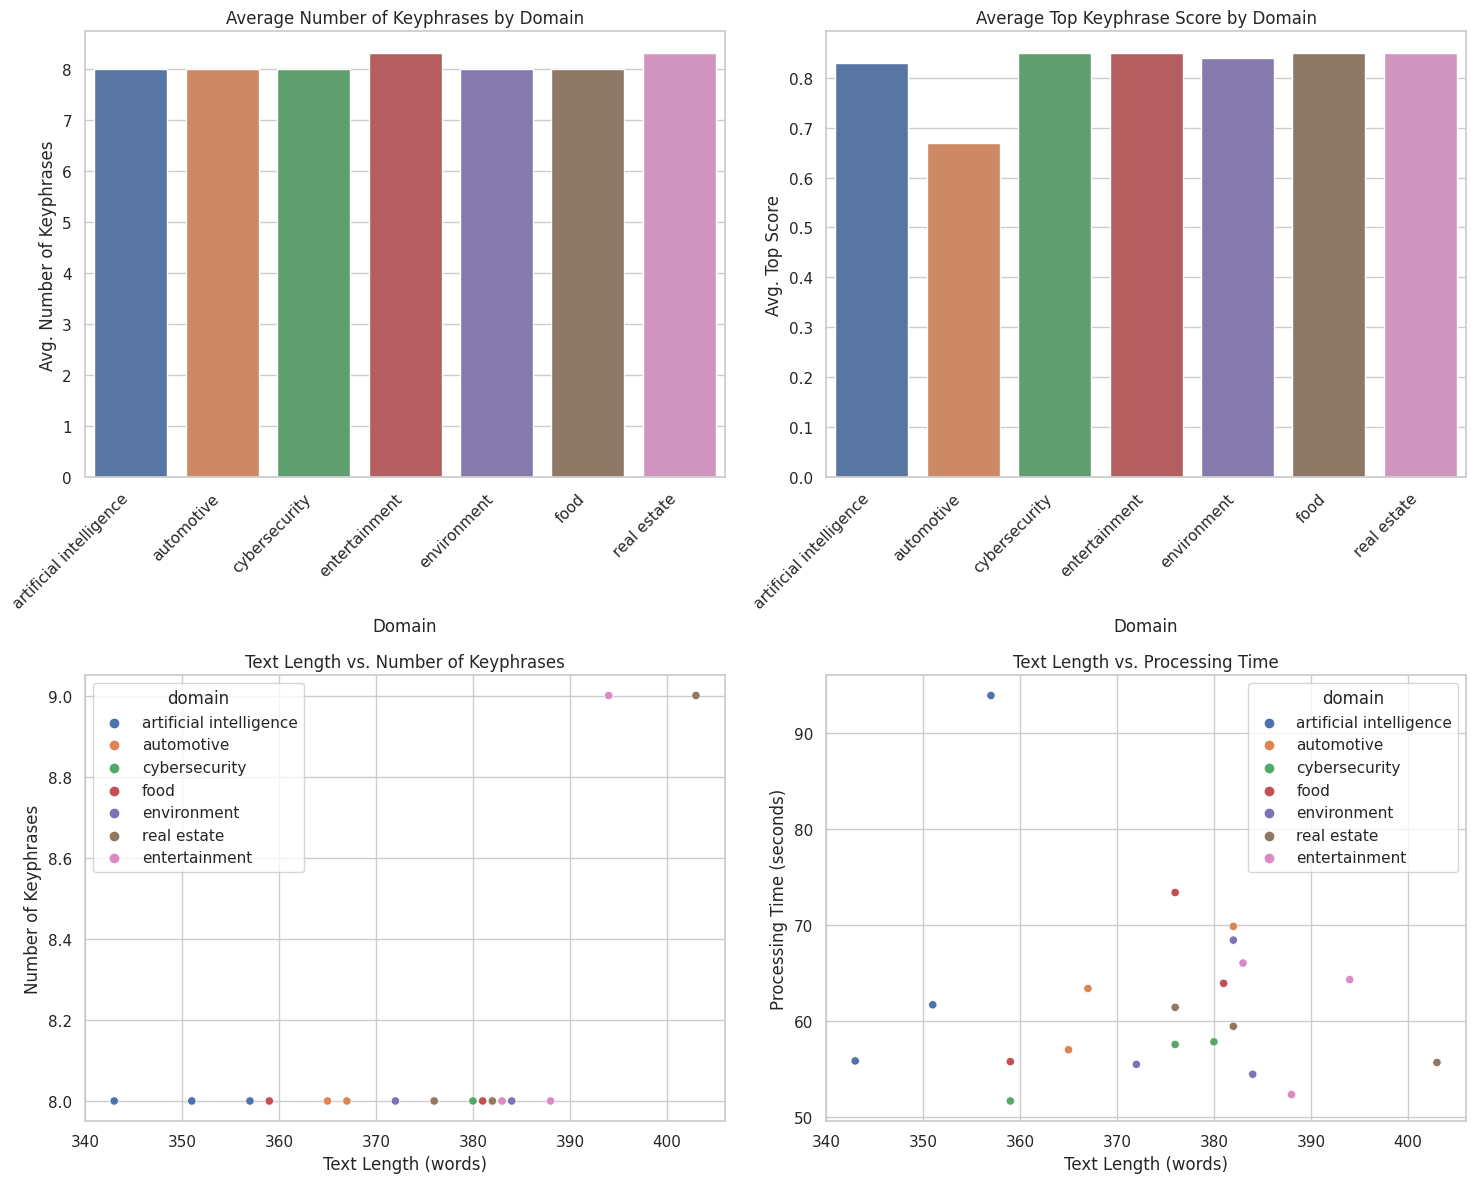

In [ ]:
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def test_abstractive_keyphrase_extractor():
    """
    Test the AbstractiveKeyphraseExtractor on a diverse set of news articles
    and evaluate its performance across different domains.
    """
    # Initialize the extractor
    print("Initializing AbstractiveKeyphraseExtractor...")
    extractor =  fusion_extractor = FusionKeyphraseExtractor(
         use_gpu=True,
        abstractive_weight=0.45,  
        extractive_weight=0.55,   
        redundancy_threshold=0.68,  
        min_score=0.09  
    )
    # Test articles from different domains
    test_articles = [
# --- AI Articles ---
{
    'title': 'AI Advancements Set to Transform Creative Industries in 2025',
    'domain': 'artificial intelligence',
    'text': """
    (April 12, 2025) - The creative industries, spanning film, music, design, and content creation, are experiencing a seismic shift driven by rapid advancements in Artificial Intelligence (AI). Throughout 2024 and early 2025, generative AI tools like large language models (LLMs) and sophisticated text-to-image/video generators have moved from novelty to practical application, profoundly impacting workflows and opening new creative avenues.

    Industry experts predict 2025 will see further integration of AI, not necessarily replacing human creativity, but augmenting it. Applications range from AI-powered PCs enhancing rendering speeds and workflow efficiency for designers and video editors, to AI algorithms assisting musicians in composition and production. Platforms like Cinelytic are already using AI for predictive analytics in film intelligence, helping studios make more informed decisions about potential projects. Tools are also emerging to automate aspects of advertising creation and performance testing.

    However, this integration isn't without challenges. The 2023 Hollywood strikes highlighted deep concerns about AI's role, resulting in agreements stipulating that AI should support, not supplant, human talent. Issues surrounding copyright, fair remuneration for creators whose work trains AI models, and the potential for AI to exacerbate biases remain critical ethical considerations. A key challenge noted by research experts is managing the intellectual property (IP) implications and ensuring creators consent and are compensated fairly.

    Furthermore, while AI tools democratize creation, they also lead to content abundance, making it harder for new artists and works to gain visibility. This necessitates new strategies for discovery, potentially increasing reliance on algorithmic curation like TikTok's BookTok or personalized streaming recommendations.

    Despite these hurdles, the potential benefits are significant. AI can streamline repetitive tasks in post-production, generate novel visual effects previously requiring large teams (as seen in films like "Everything Everywhere All at Once"), and offer personalized creative assistance. The trend is moving towards unified AI frameworks capable of handling multiple creative tasks, but human oversight remains crucial to manage inaccuracies and ethical risks. As AI evolves, the creative industries must navigate these complexities, aiming for an ecosystem where technology enhances human ingenuity and distributes benefits equitably. Striking this balance will be key to harnessing AI's full potential while safeguarding the value of human creativity.
    """
},
{
    'title': 'Navigating the Ethical Minefield: AI Development Demands Responsible Practices',
    'domain': 'artificial intelligence',
    'text': """
    (April 12, 2025) - As Artificial Intelligence (AI) systems become increasingly integrated into critical sectors like healthcare, finance, and autonomous systems, the ethical considerations surrounding their development and deployment are intensifying. Experts and policymakers agree that establishing robust ethical frameworks is paramount to harness AI's benefits while mitigating significant risks.

    Several core ethical concerns dominate the discussion in 2025. Fairness and bias remain critical challenges. AI systems, trained on historical data, can inherit and even amplify societal biases related to race, gender, or socioeconomic status. For example, biased algorithms in hiring or loan applications can perpetuate discrimination, requiring rigorous scrutiny of training data and model outputs to ensure fairness. Amazon's abandonment of a biased hiring algorithm serves as a stark reminder of this risk.

    Transparency and explainability are vital for building trust. Users and regulators need clarity on how AI systems make decisions, especially in high-stakes scenarios. However, achieving full transparency can be complex, sometimes conflicting with goals like privacy or security. Striking the right balance and securing informed consent for data usage are essential.

    Privacy is another major concern. AI systems often require vast amounts of data, raising questions about responsible data handling, safeguarding user information, and preventing misuse. Global standards for data storage and processing by AI are still lacking, creating regulatory gaps.

    Human safety and accountability are non-negotiable. AI systems, particularly autonomous ones like self-driving cars or medical diagnostic tools, must be rigorously tested to prevent harm. Clear lines of responsibility must be established for decisions made by AI, ensuring that human oversight and accountability are not displaced.

    Furthermore, the environmental impact of AI, due to high energy consumption for training large models, calls for prioritizing sustainable practices. Concerns about AI's potential to influence human behavior, disrupt labor markets, and even pose existential risks (though hotly debated) also feature in ethical discussions. UNESCO and other international bodies emphasize a human-rights-centered approach, embedding ethical considerations into the entire AI lifecycle, from design to deployment, to ensure AI aligns with human values and societal well-being. Ignoring these ethical imperatives risks undermining public trust and could lead to significant societal harm.
    """
},
{
    'title': 'Large Language Models Reach New Milestones, Pushing Boundaries of AI Interaction',
    'domain': 'artificial intelligence',
    'text': """
    (April 12, 2025) – Large Language Models (LLMs) continue their rapid evolution, marking significant milestones in capability and application throughout late 2024 and early 2025. These sophisticated AI systems, known for their ability to understand and generate human-like text, are increasingly finding roles beyond simple chatbots, impacting research, creative fields, and business processes.

    Recent advancements have focused on enhancing LLMs' reasoning abilities, contextual understanding, and multimodal capabilities. Models released in the past year demonstrate improved performance on complex tasks, better factual accuracy (though 'hallucinations' remain a challenge), and the ability to integrate and process information from text, images, and even audio inputs. This progress establishes new benchmarks in conversational AI and natural language processing.

    The integration of LLMs into various software and platforms is accelerating. In the creative industries, LLMs assist with scriptwriting, generating marketing copy, and even providing narrative suggestions. Research indicates their utility in simplifying human interaction with complex systems through natural language prompts, allowing artists and designers to convey intricate instructions more intuitively. For instance, LLMs are being used to drive image and video generation tools, translating textual descriptions into visual content with increasing fidelity.

    In business, LLMs are being deployed for tasks like document summarization, code generation, customer service automation, and data analysis. Their ability to process and synthesize vast amounts of text efficiently offers significant productivity gains. Startups and established tech giants are competing fiercely, releasing progressively larger and more optimized models, often focusing on specific domains like finance or healthcare to improve relevance and accuracy.

    Despite the progress, challenges persist. The computational cost and energy consumption required to train state-of-the-art LLMs raise environmental concerns. Ensuring factual reliability, mitigating inherent biases learned from training data, and addressing ethical considerations related to misinformation and misuse are ongoing areas of research and debate. Furthermore, the development of robust methods for assessing LLM capabilities and limitations remains crucial. As these models become more powerful and integrated into daily life, navigating these challenges while maximizing their potential benefits will be a key focus for researchers, developers, and policymakers in the coming years.
    """
},

# --- Automotive Articles ---
{
    'title': 'Electric Vehicle Battery Technology Sees Major Breakthroughs in Range and Charging',
    'domain': 'automotive',
    'text': """
    (April 12, 2025) – The push for longer range, faster charging, and increased safety in electric vehicles (EVs) is driving significant innovation in battery technology, with several key breakthroughs announced in late 2024 and early 2025. These advancements promise to address some of the major hurdles hindering wider EV adoption.

    Solid-state batteries continue to be a major focus. Several companies, including Nissan and Mercedes-Benz (leveraging Formula 1 tech), have announced prototype solid-state batteries targeting commercial availability within the next few years, possibly by 2028. These batteries replace the liquid electrolyte with a solid material, potentially offering higher energy density (leading to longer range, perhaps enabling 500-600 mile EVs), improved safety by reducing fire risk, and faster charging capabilities. Korean researchers have notably developed a fireproof lithium metal battery using a solid electrolyte. While manufacturing cost and scalability remain challenges, the progress is tangible.

    Beyond solid-state, advancements are being made with current lithium-ion chemistries. Researchers are exploring novel cathode materials, like Lithium Manganese Iron Phosphate (LMFP), which tests show could significantly extend EV range compared to existing materials. Additionally, innovations like single-crystal electrodes, tested extensively at Dalhousie University, have shown remarkable durability, enduring over 20,000 charging cycles – potentially translating to an EV lifespan of millions of miles. Increasing the silicon content in anodes is another avenue being pursued by companies like GM to improve energy density and charging speeds.

    Charging technology is also evolving rapidly. Chinese OEM BYD unveiled a new "super e-platform" claiming megawatt charging capabilities that could potentially recharge an EV in just five minutes. Furthermore, researchers have developed battery chemistries capable of charging in 10 minutes even at sub-zero temperatures, addressing a key pain point for EV owners in colder climates. Stationary storage systems, like one announced by Volvo with a 500 kWh capacity, are also being developed to support charging infrastructure, capable of recharging multiple EVs daily.

    Efforts towards sustainability are also evident. Research is underway to develop EV batteries without per- and polyfluoroalkyl substances (PFAS), often called 'forever chemicals'. Recycling processes are improving, with some breakthroughs achieving nearly 100% lithium recovery rates. These combined advancements signal a future where EV batteries are more powerful, longer-lasting, faster-charging, safer, and more sustainable.
    """
},
{
    'title': 'Automotive Industry Faces Headwinds in 2025 Despite Technological Strides',
    'domain': 'automotive',
    'text': """
    (April 12, 2025) - The global automotive industry enters the mid-decade facing a complex mix of challenges, tempering the excitement around rapid technological evolution in areas like electrification and autonomous driving. While innovation continues at pace, economic pressures, regulatory shifts, supply chain vulnerabilities, and heightened competition are creating significant headwinds for manufacturers.

    Market growth forecasts for 2025 remain modest, with projections around 2.7% globally. High vehicle prices, rising consumer debt, and broader economic uncertainty are constraining demand for big-ticket items like cars. Geopolitical tensions, including potential tariff increases between major markets like the US, EU, and China, pose a substantial risk, potentially increasing component costs and dampening consumer demand further. The impact of the Russia-Ukraine war and Middle East conflicts continues to ripple through supply chains, affecting component availability and logistics.

    The transition to electric vehicles (EVs) presents both opportunities and challenges. While EV sales are growing, particularly in emerging markets spurred by government incentives, the required investment in R&D, battery production, and charging infrastructure is immense. Manufacturers grapple with balancing investments across traditional internal combustion engines (ICE), hybrid technologies, and full electrification amidst regulatory uncertainty and evolving consumer preferences. Stricter emission standards, particularly the EU's 2025 CO2 targets, are forcing rapid shifts towards zero-emission technologies, adding pressure on compliance and competitiveness.

    Competition is intensifying, especially from cost-advantaged Chinese manufacturers who possess significant advantages in labor costs and control over critical parts of the EV supply chain, particularly batteries. Established OEMs like Stellantis are forming joint ventures to address this, while others focus on cost-cutting measures and improving manufacturing efficiency. However, vehicles have generally become larger and heavier, partly due to regulations, adding to costs.

    Supply chain resilience remains a critical concern. The industry's reliance on complex, global supply networks makes it vulnerable to disruptions, as seen with semiconductor shortages and geopolitical events. Enhancing visibility across supply tiers, diversifying suppliers, and potentially moving away from strict just-in-time models are key strategies being explored. Furthermore, the increasing connectivity and software reliance in modern vehicles significantly elevates cybersecurity risks, with remote attacks becoming more common, requiring robust security measures throughout the vehicle lifecycle. Successfully navigating these multifaceted challenges requires significant flexibility, strategic investment, and innovation from automakers in 2025.
    """
},
{
    'title': 'Autonomous Driving Systems Progress Amidst Regulatory and Safety Hurdles',
    'domain': 'automotive',
    'text': """
    (April 12, 2025) – The development of autonomous driving (AD) systems continues its forward march, with technological capabilities advancing steadily. However, the path to widespread deployment of fully self-driving vehicles remains complex, navigating significant regulatory hurdles, ongoing safety validation requirements, and persistent public perception challenges.

    Technologically, advancements in sensor fusion (combining data from cameras, lidar, radar), AI-driven perception algorithms, and high-definition mapping are enabling more sophisticated AD functionalities. Systems offering Level 3 conditional automation (where the car drives itself under specific conditions, but the driver must be ready to intervene) and Level 4 high automation (where the car drives itself within defined operational design domains, like specific geographic areas or weather conditions) are becoming more refined. Projections suggest a growing percentage of new vehicles will feature Level 3 or 4 capabilities by the end of the decade, though full Level 5 autonomy (no human intervention needed anywhere) remains a distant goal for most applications.

    Companies across the automotive and tech sectors are investing heavily. Traditional automakers like GM, Ford, and Mercedes-Benz are integrating advanced driver-assistance systems (ADAS) that serve as building blocks for higher autonomy levels. Tech companies like Waymo (Google) and Cruise (GM) continue testing and expanding their robotaxi services in limited urban environments, gathering crucial real-world data but also facing intense scrutiny following incidents.

    Regulatory frameworks are struggling to keep pace with the technology. Establishing clear rules for liability, safety standards, testing protocols, and data privacy across different jurisdictions (states, countries) is a major challenge. The lack of harmonized regulations creates uncertainty for manufacturers and slows down broader deployment. Ensuring the safety and reliability of AD systems remains paramount. Rigorous testing, including simulations and extensive real-world driving, is necessary to validate system performance under countless scenarios. Edge cases and unexpected events ('long tail' problems) remain difficult to fully anticipate and address.

    Cybersecurity is another critical concern. As vehicles become more connected and reliant on software for driving functions, they become potential targets for malicious attacks. Protecting AD systems from hacking, ensuring secure software updates, and safeguarding collected data are essential for safety and public trust. While the promise of enhanced safety, improved mobility, and increased efficiency drives AD development, overcoming these technical, regulatory, and societal challenges is crucial for realizing the full potential of autonomous vehicles in the coming years.
    """
},

# --- CyberSecurity Articles ---
{
    'title': 'Ransomware Evolves: Attackers Shift Tactics Amidst Improved Defenses',
    'domain': 'cybersecurity',
    'text': """
    (April 12, 2025) - Ransomware remains a dominant and highly disruptive cyber threat in 2025, but attack methodologies are evolving as cybercriminals adapt to enhanced enterprise defenses and increased pressure from law enforcement. Recent reports indicate a continued rise in overall ransomware activity, despite disruptions to major gangs like LockBit in early 2024, showcasing the threat's resilience.

    A key trend observed is a shift in tactics. While encryption remains a core component, attackers are increasingly focusing on data theft and extortion – known as double extortion. They exfiltrate sensitive data before or instead of encrypting systems, threatening to leak the stolen information publicly if the ransom isn't paid. This puts additional pressure on victims concerned about reputational damage and regulatory penalties, even if they have robust backups. Some groups even employ triple extortion, adding DDoS attacks or contacting the victim's customers or partners.

    Attackers are refining techniques to bypass security measures. There's a marked increase in "living off the land" (LotL) techniques, where legitimate system administration tools already present on a network are abused for malicious purposes. This makes detection harder as the activity can blend in with normal operations. Furthermore, many ransomware incidents now involve the use of Remote Access Trojans (RATs) or the abuse of legitimate Remote Monitoring and Management (RMM) tools like ConnectWise ScreenConnect or TeamViewer for initial access and persistence.

    Disabling security defenses is another common tactic. Attackers actively try to tamper with or disable antivirus (AV) and Endpoint Detection and Response (EDR) solutions before deploying the ransomware payload. A popular method for this is the "Bring Your Own Vulnerable Driver" (BYOVD) technique, where attackers exploit a signed, legitimate but vulnerable driver to gain kernel-level privileges and shut down security software.

    Critical infrastructure, healthcare, finance, and government sectors remain prime targets due to the high potential impact of disruption and the sensitivity of the data held. However, attacks are expanding across all sectors. Ransom demands continue to be substantial, often reaching multi-million dollar figures. The rise of Ransomware-as-a-Service (RaaS) platforms continues to lower the barrier to entry, enabling less sophisticated actors to launch potent attacks. Organizations must continually adapt their defense strategies, focusing on robust endpoint security, regular patching, multi-factor authentication, network segmentation, employee training, and comprehensive backup and recovery plans to counter these evolving threats.
    """
},
{
    'title': 'Cybersecurity Skills Gap Widens in 2025 Despite Increased Awareness',
    'domain': 'cybersecurity',
    'text': """
    (April 12, 2025) – The gap between the demand for skilled cybersecurity professionals and the available talent pool has reached a record high in 2025, posing a significant challenge to organizations worldwide seeking to defend against increasingly sophisticated cyber threats. Despite numerous initiatives and heightened awareness of cybersecurity's importance, the workforce growth is failing to keep pace with escalating needs.

    Recent studies, such as those by ISC2 and reports discussed at the World Economic Forum, highlight the severity of the issue. The global cybersecurity skills gap is estimated at nearly 5 million professionals, a significant increase from previous years. While the existing workforce numbers around 5.5 million, demand necessitates over 10 million experts. This shortage is particularly acute in the public sector, which reports greater difficulty in attracting and retaining talent compared to private organizations. Two out of three organizations report experiencing moderate-to-critical skills gaps.

    Several factors contribute to this widening gap. The rapid evolution of technology, including the proliferation of cloud computing, IoT devices, and AI, continuously expands the attack surface and necessitates new, specialized skills. Furthermore, adversaries are leveraging AI to create more advanced and harder-to-detect attacks, demanding greater expertise from defenders. There's a specific rising demand for specialists in areas like Active Directory security, cloud security, and AI threat defense.

    The educational pipeline is struggling to produce qualified candidates at the required scale. Experts suggest a need to promote cybersecurity careers earlier, potentially in high school, and emphasize practical, hands-on skills alongside traditional degrees. Indeed, hiring trends show leaders prioritizing demonstrable skills and certifications over just academic qualifications. Upskilling existing blue teams (defensive security professionals) is also crucial, as many organizations report a deficiency in adequate defensive skills among current staff.

    Organizations are turning to AI-powered security tools to augment human teams and automate tasks, helping to mitigate the personnel shortage. However, a reported knowledge gap exists even here, with many professionals not fully understanding the AI technologies within their security stack. Addressing the skills gap requires a multi-pronged approach: investing in education and training programs, promoting diversity in hiring to broaden the talent pool, fostering public-private partnerships, utilizing automation and AI effectively, and creating attractive career paths within the cybersecurity field. Failure to close this gap leaves organizations increasingly vulnerable to cyberattacks.
    """
},
{
    'title': 'Protecting Critical Infrastructure: A Top Priority Amidst Rising Geopolitical Tensions',
    'domain': 'cybersecurity',
    'text': """
    (April 12, 2025) – Securing critical infrastructure sectors – including energy, finance, healthcare, transportation, and water systems – against cyber threats has become an paramount concern for governments and private organizations globally in 2025. Heightened geopolitical tensions and the increasing sophistication of state-sponsored and criminal hacking groups have significantly elevated the risk profile for these essential services.

    Cyber incidents targeting critical infrastructure can have devastating real-world consequences, ranging from service disruptions and economic damage to potential threats to public safety and national security. Ransomware operators, in particular, are increasingly focusing on industries where operational disruption carries severe repercussions, recognizing the increased likelihood of payment or significant impact. Recent trends show a marked increase in attacks targeting these vital sectors.

    The convergence of Information Technology (IT) and Operational Technology (OT) systems within critical infrastructure environments presents unique challenges. OT systems, which control physical processes (like power generation or water treatment), were often designed without modern security considerations and can be vulnerable if connected to IT networks. Protecting these interconnected systems requires specialized expertise and security measures that bridge the IT/OT divide, forming a foundation for concepts like Industry 5.0 resilience.

    Governments worldwide are responding with increased regulation and collaborative initiatives. National cybersecurity strategies increasingly emphasize critical infrastructure protection, mandating stricter security standards, information sharing protocols, and incident response preparedness. Initiatives like Italy's National Cybersecurity Strategy 2022-2026 exemplify efforts to bolster defenses through training, technology deployment, and public-private partnerships. However, regulatory fragmentation across different jurisdictions remains a challenge for multinational organizations.

    Key defensive strategies include robust network segmentation to isolate critical systems, continuous monitoring for anomalous activity, stringent access controls (including multi-factor authentication), regular vulnerability assessments and patching, and comprehensive incident response and recovery plans. Securing the supply chain for both hardware and software components used in critical systems is also vital, as demonstrated by attacks exploiting vulnerabilities in third-party suppliers.

    The reliance on legacy systems, the shortage of skilled cybersecurity professionals with OT expertise, and the persistent threat from well-funded adversaries mean that securing critical infrastructure is an ongoing battle. Continuous investment, international cooperation, and a proactive, risk-based security posture are essential to safeguard the essential services societies depend upon.
    """
},

# --- Food Articles ---
{
    'title': 'Lab-Grown Meat Nears Commercial Reality Amidst Production Hurdles',
    'domain': 'food',
    'text': """
    (April 12, 2025) – The field of cultivated meat, often referred to as lab-grown or cell-based meat, is rapidly advancing towards broader commercial availability, driven by concerns over traditional animal agriculture's environmental impact, animal welfare, and potential for zoonotic diseases. Several companies have achieved regulatory approvals in key markets and are scaling up production, though significant hurdles remain.

    Recent months have seen increased investment and pilot programs aimed at bringing cultivated chicken, beef, and seafood products to restaurants and potentially retail shelves. Startups are refining bioreactor technologies to grow animal cells efficiently and cost-effectively, using nutrient-rich media to replicate tissue growth outside of an animal. The goal is to produce meat that is biologically identical to its farm-raised counterpart, offering a similar taste and texture profile.

    Key technological challenges involve scaling production to industrial levels while drastically reducing costs. The nutrient media required for cell growth remains expensive, and designing large-scale bioreactors that maintain optimal conditions for tissue development is complex. Achieving desirable textures, particularly for structured cuts of meat like steaks, requires sophisticated scaffolding techniques that are still under development. Consumer acceptance is another crucial factor, hinging on taste parity, affordability, and clear communication about the production process and safety.

    Despite these challenges, progress is evident. Companies are optimizing cell lines for faster growth and higher yields, exploring plant-based or lower-cost nutrient media formulations, and improving bioreactor efficiency. Hybrid products, blending cultivated cells with plant-based ingredients, offer a potential pathway to market by leveraging existing technologies and potentially lowering costs initially.

    Regulatory pathways are slowly clearing in various countries, providing frameworks for safety assessments and labeling. Early market entries are likely to focus on high-end restaurants or blended products before achieving price parity with conventional meat for widespread retail adoption. Proponents highlight the potential benefits: significantly reduced land and water use, lower greenhouse gas emissions compared to conventional livestock farming, and elimination of antibiotic use in meat production. While the timeline for mass-market availability remains uncertain, the momentum behind cultivated meat suggests it could play a significant role in the future food system, offering a more sustainable alternative protein source if scalability and cost challenges can be overcome.
    """
},
{
    'title': 'Sustainable Agriculture Innovations Tackle Climate Change and Food Security',
    'domain': 'food',
    'text': """
    (April 12, 2025) – Faced with the dual pressures of climate change and a growing global population, innovation in sustainable agriculture is accelerating, offering promising solutions to enhance food security while minimizing environmental impact. A range of technologies and practices are being developed and adopted to make farming more resilient, efficient, and ecologically sound.

    Precision agriculture remains a key driver, utilizing GPS, sensors, drones, and data analytics to optimize the use of resources like water, fertilizer, and pesticides. By applying inputs only where and when needed, farmers can reduce waste, lower costs, and lessen environmental runoff. AI and machine learning are further enhancing precision techniques, enabling better crop monitoring, yield prediction, and disease detection.

    Genetic engineering and new breeding techniques like gene editing (facilitated by regulations like the UK's Precision Breeding Act) are playing a crucial role. These technologies allow for the development of crops with enhanced traits, such as drought tolerance, pest resistance, improved nutritional value, and higher yields. This reduces reliance on chemical inputs and helps crops adapt to changing climate conditions, although public acceptance and regulatory frameworks vary globally.

    Agroecology and regenerative agriculture practices are gaining traction. These approaches focus on building soil health through techniques like cover cropping, no-till farming, and crop rotation. Healthy soils sequester more carbon, improve water retention, and enhance biodiversity, contributing to both climate mitigation and adaptation. Integrating livestock grazing with cropping systems can also enhance nutrient cycling and soil fertility.

    Controlled Environment Agriculture (CEA), including vertical farming and hydroponics, offers solutions for producing crops in urban areas or regions with limited arable land or water. These systems use significantly less water than traditional farming and allow for year-round production independent of weather conditions, reducing transportation distances and associated emissions. Innovations in LED lighting and automation are making CEA more energy-efficient and economically viable.

    Furthermore, novel solutions like methane-reducing feed additives for livestock (such as those derived from Asparagopsis seaweed by companies like CH4 Global) and bio-pesticides (like agricultural phages) offer targeted ways to reduce agriculture's environmental footprint. Investment in agtech, while experiencing some recent fluctuations, continues to fuel these innovations, supported by government initiatives and programs aimed at promoting sustainable practices. The collective goal is to transform the food system towards one that can nourish the world sustainably for generations to come.
    """
},
{
    'title': 'Food Supply Chain Resilience Becomes Critical Focus with New Technologies',
    'domain': 'food',
    'text': """
    (April 12, 2025) – Recent global disruptions, from pandemics to geopolitical conflicts and extreme weather events, have starkly highlighted the vulnerabilities within complex food supply chains. In response, building resilience has become a top priority for the food industry, with technology playing a crucial role in enhancing transparency, efficiency, and adaptability from farm to fork.

    Enhanced visibility is a cornerstone of resilience. Technologies like blockchain are being explored and implemented to create transparent, immutable records of food products as they move through the supply chain. This improves traceability, helping to quickly identify sources of contamination during recalls, verify product authenticity (combating fraud), and track sustainability metrics. IoT sensors deployed on farms, during transport, and in storage facilities provide real-time data on conditions like temperature, humidity, and location, ensuring optimal quality and safety, and allowing for proactive interventions if issues arise.

    Predictive analytics and Artificial Intelligence (AI) are transforming supply chain management. By analyzing vast datasets – including weather patterns, historical demand, market trends, and logistics information – AI can forecast potential disruptions, optimize inventory levels, predict consumer demand more accurately, and suggest alternative sourcing or routing options in real-time. This helps businesses mitigate risks, reduce waste from spoilage, and ensure continuity of supply.

    Automation is increasing efficiency and reducing labor dependency in various parts of the supply chain. Automated systems in warehouses, robotics in processing plants, and autonomous vehicles for transport can streamline operations, reduce handling errors, and maintain productivity even during labor shortages. Advanced planning systems help coordinate complex logistics networks more effectively.

    Diversification of sourcing and decentralization of production are also key resilience strategies, often enabled by technology. Shorter supply chains, supported by local sourcing platforms and controlled environment agriculture (like vertical farms near urban centers), reduce dependence on long-distance transport and associated risks. Companies are also using technology to vet and onboard alternative suppliers more quickly when disruptions occur in primary regions.

    Furthermore, platforms enhancing collaboration and information sharing between different stakeholders – farmers, processors, distributors, retailers – allow for a more coordinated response to challenges. While technology alone cannot eliminate all risks, its strategic implementation is proving essential for building more robust, agile, and transparent food supply chains capable of withstanding future shocks and ensuring consistent access to safe and nutritious food.
    """
},

# --- Environment Articles ---
{
    'title': 'Global Renewable Energy Adoption Accelerates, But Challenges Remain',
    'domain': 'environment',
    'text': """
    (April 12, 2025) – The global transition towards renewable energy sources like solar, wind, and hydropower continued to gain momentum through 2024 and into 2025, driven by falling technology costs, supportive government policies, and mounting urgency to address climate change. However, significant challenges related to grid integration, energy storage, and scaling up deployment persist.

    Solar and wind power installations reached record levels in many parts of the world. Advancements in photovoltaic cell efficiency and wind turbine design have made these technologies increasingly competitive with fossil fuels on cost, even without subsidies in some regions. Corporate Power Purchase Agreements (PPAs), where large companies commit to buying renewable energy long-term, have also become a major driver of new capacity additions. Governments continue to play a key role through mechanisms like feed-in tariffs, tax credits, renewable portfolio standards, and competitive auctions for large-scale projects.

    Despite this progress, integrating large amounts of variable renewable energy (VRE) like solar and wind into existing electricity grids poses technical hurdles. Grid infrastructure often needs substantial upgrades to handle fluctuating power flows and connect remote renewable generation sites to demand centers. Managing intermittency – the fact that the sun doesn't always shine and the wind doesn't always blow – requires flexible grid operations and significant investment in energy storage solutions.

    Battery storage technology is improving rapidly in terms of cost and performance, becoming crucial for stabilizing grids and providing power during periods of low renewable generation. Large-scale battery projects are increasingly being co-located with solar and wind farms. Other storage solutions, including pumped hydro storage, compressed air energy storage, and green hydrogen production (using renewable electricity for electrolysis), are also being developed and deployed, though often at higher costs currently.

    Permitting processes and supply chain constraints for key materials (like lithium, cobalt, and rare earth elements used in batteries and turbines) can also slow down deployment rates. Public acceptance and addressing land-use conflicts related to large renewable energy projects are further considerations. While the long-term trend is clearly towards a decarbonized energy system powered by renewables, accelerating the pace of deployment, modernizing grid infrastructure, scaling up energy storage, and streamlining regulatory processes are critical steps needed to meet international climate goals and ensure a reliable, clean energy future for all.
    """
},
{
    'title': 'International Climate Agreements Face Crucial Test Amidst Geopolitical Landscape',
    'domain': 'environment',
    'text': """
    (April 12, 2025) - Global efforts to address climate change, primarily guided by the Paris Agreement, face a critical period in 2025 as nations work to strengthen their commitments amidst a complex geopolitical and economic backdrop. While the scientific consensus on the urgency of climate action is stronger than ever, translating international goals into concrete domestic policies and achieving sufficient global cooperation remains challenging.

    The Paris Agreement framework relies on Nationally Determined Contributions (NDCs), where countries set their own targets for reducing greenhouse gas emissions. Periodic "stocktakes" assess collective progress, with the expectation that countries will progressively increase their ambition over time. Recent assessments indicate that current NDCs, even if fully implemented, are insufficient to limit global warming to the agreement's targets of well below 2°C, preferably 1.5°C, above pre-industrial levels. Bridging this ambition gap is a central focus of ongoing international climate negotiations.

    Key issues include financing climate action, particularly support for developing nations to mitigate emissions and adapt to climate impacts. Developed countries' commitments to provide climate finance have faced scrutiny regarding delivery and adequacy. Mechanisms for carbon markets (under Article 6 of the Paris Agreement) are still being finalized, aiming to facilitate international cooperation on emissions reductions but requiring robust rules to ensure environmental integrity.

    Geopolitical tensions and economic pressures, including concerns about energy security and inflation, can sometimes divert attention and resources from climate action. Trade disputes, particularly those involving tariffs on green technologies or carbon border adjustments, add complexity to international climate cooperation. Ensuring a "just transition" – supporting workers and communities affected by the shift away from fossil fuels – is also crucial for maintaining political support for climate policies globally.

    Despite these challenges, positive signals exist. Many countries are enacting more ambitious domestic climate legislation and investing heavily in renewable energy and green technologies. The private sector is increasingly recognizing climate risks and opportunities, with growing corporate commitments to decarbonization. International platforms like the G20 and specialized UN bodies continue to provide forums for dialogue and cooperation. However, accelerating the pace of emissions reductions globally requires stronger political will, enhanced international collaboration, increased financial flows, and effective implementation of policies across all major economies. The success of the Paris Agreement ultimately depends on whether nations can collectively ramp up action sufficiently in this critical decade.
    """
},
{
    'title': 'Biodiversity Crisis Deepens, Conservation Efforts Scale Up Response',
    'domain': 'environment',
    'text': """
    (April 12, 2025) – The global decline in biodiversity, often termed the sixth mass extinction event, continues at an alarming rate, driven primarily by habitat destruction, climate change, pollution, overexploitation of resources, and invasive species. Scientific reports consistently highlight accelerating species extinction rates and degradation of ecosystems worldwide, threatening not only nature itself but also the essential services ecosystems provide to humanity, such as clean air and water, pollination, and climate regulation.

    Habitat loss, largely due to agricultural expansion, infrastructure development, and deforestation, remains the single biggest driver. Natural ecosystems are being fragmented and destroyed, shrinking the spaces available for wildlife. Climate change exacerbates the crisis by shifting species' ranges, altering habitats (e.g., coral bleaching), and increasing the frequency of extreme weather events that devastate ecosystems. Pollution, particularly from plastics, pesticides, and industrial waste, further degrades habitats and harms wildlife directly.

    In response to this deepening crisis, conservation efforts are intensifying globally, guided by frameworks like the Kunming-Montreal Global Biodiversity Framework adopted in late 2022. This framework sets ambitious targets, including protecting 30% of the planet's land and sea by 2030 (the "30x30" goal), restoring degraded ecosystems, reducing pollution, and mobilizing financial resources for biodiversity.

    Conservation strategies encompass a wide range of actions. Expanding protected areas (national parks, marine reserves) remains crucial, but effective management and ensuring connectivity between protected areas are equally important. Ecosystem restoration projects, such as reforestation, wetland rehabilitation, and coral reef restoration, aim to rebuild degraded habitats and recover lost biodiversity.

    Tackling the drivers of biodiversity loss is essential. This includes promoting sustainable agriculture and forestry practices, shifting towards circular economy models to reduce waste and pollution, combating illegal wildlife trade, and managing invasive species. Integrating biodiversity considerations into economic planning and decision-making across all sectors (e.g., finance, infrastructure) is increasingly recognized as vital.

    Technological advancements, such as satellite monitoring, eDNA (environmental DNA) analysis for species detection, and AI for analyzing ecological data, are providing powerful new tools for conservation monitoring and management. Community involvement and recognizing the rights and knowledge of Indigenous Peoples and local communities are also critical for successful, long-term conservation outcomes. Despite the scale of the challenge, the increased global attention, ambitious targets, and growing toolkit of conservation approaches offer hope for bending the curve of biodiversity loss, though rapid and transformative action is urgently required.
    """
},

# --- Real Estate Articles ---
{
    'title': 'Global Housing Markets Navigate Shifting Sands of Interest Rates and Affordability',
    'domain': 'real estate',
    'text': """
    (April 12, 2025) – Housing markets across the globe continue to experience volatility in early 2025, largely influenced by evolving central bank monetary policies and persistent affordability challenges. After a period of rapid interest rate hikes aimed at curbing inflation, some markets are seeing tentative signs of stabilization, while others remain under pressure.

    The impact of higher interest rates, which make mortgages more expensive, significantly dampened housing demand and price growth throughout 2023 and 2024 in many developed economies. Transaction volumes slowed, and price corrections occurred in several previously overheated markets. Now, as inflation shows signs of moderating in some regions, speculation about potential interest rate cuts later in 2025 is providing a degree of cautious optimism. However, borrowing costs generally remain elevated compared to the ultra-low rates of the early 2020s.

    Housing affordability remains a critical issue. Decades of price growth outpacing wage increases, coupled with the recent surge in mortgage rates, have pushed homeownership out of reach for many potential buyers, particularly first-timers. Supply constraints in desirable locations continue to underpin prices in many areas, preventing steeper declines despite weaker demand. Building activity, while necessary to address supply shortages, is often hampered by high construction costs, labor shortages, and regulatory hurdles.

    Regional variations are significant. Some markets, particularly those with strong population growth or resilient economies, have proven more resistant to downturns. Conversely, markets that saw the most extreme price surges during the pandemic boom remain more vulnerable to corrections. The "flight to affordability," where buyers seek out less expensive cities or suburban/rural areas, continues to influence migration patterns and relative price performance.

    Rental markets also face pressure. High homeownership costs are keeping more people in the rental sector, boosting demand and pushing up rents in many cities. This exacerbates cost-of-living pressures for tenants.

    Looking ahead, the trajectory of housing markets in 2025 will depend heavily on the path of interest rates set by central banks, the performance of national economies, and local supply-demand dynamics. While a major crash seems unlikely in most stable economies due to factors like tight supply and homeowner equity built up over time, affordability constraints and elevated borrowing costs are expected to continue shaping market activity, likely leading to more moderate price movements compared to the preceding boom years.
    """
},
{
    'title': 'Commercial Real Estate Adapts to Hybrid Work Models and Tenant Demands',
    'domain': 'real estate',
    'text': """
    (April 12, 2025) – The commercial real estate (CRE) sector, particularly the office market, is undergoing a significant transformation driven by the persistence of remote and hybrid work models adopted since the COVID-19 pandemic. While initial fears of a complete office exodus have subsided, the landscape in early 2025 reflects evolving tenant needs and shifting demand patterns.

    Office vacancy rates, which surged during the pandemic, have shown signs of stabilization in many major markets, partly due to return-to-office mandates implemented by numerous companies. Research indicates that hybrid models requiring employees onsite 2-3 days per week have significantly less negative impact on office demand compared to fully remote or 1-day-a-week policies. However, overall office occupancy generally remains below pre-pandemic levels, and projected office values in major hubs like New York City are expected to stay considerably lower than 2019 levels for the foreseeable future.

    This shift is forcing landlords and property managers to adapt. There's a noticeable "flight to quality," where tenants prioritize newer, well-located buildings with modern amenities that can entice employees back to the office. Older, less desirable office stock faces higher vacancy rates and potential pressure for conversion to other uses, such as residential or logistics.

    Tenant demands have evolved. Flexibility is key, leading to increased interest in co-working spaces, shared offices, and shorter lease terms. Landlords are investing heavily in amenities to enhance the office experience and foster collaboration, including high-tech meeting rooms, virtual event capabilities, fitness centers, improved air quality systems, communal lounges, soundproof pods for focused work, and even organized networking events. These amenities are seen as crucial for attracting and retaining tenants in a competitive market, despite the significant investment costs.

    The rise of remote work has also impacted geographic demand. While major city centers still hold appeal, suburban office markets have seen increased activity as some companies seek smaller, satellite offices closer to where employees live. The retail segment of CRE is also adapting, with a continued focus on experiential retail and optimizing logistics for e-commerce fulfillment. Industrial and logistics properties remain in high demand due to the ongoing growth of online shopping.

    Overall, the CRE sector is navigating a period of recalibration. Success hinges on flexibility, adaptability, and investing in properties and amenities that meet the evolving needs of businesses and their employees in the hybrid work era. Innovation in property technology ("proptech") and a focus on sustainability are also becoming increasingly important competitive differentiators.
    """
},
{
    'title': 'Sustainable Building Practices Gain Momentum in Real Estate Development',
    'domain': 'real estate',
    'text': """
    (April 12, 2025) – Sustainability is increasingly moving from a niche concern to a core consideration within the real estate development and investment sectors. Driven by growing environmental awareness, stricter regulations, tenant demand, and investor pressure, sustainable building practices are gaining significant momentum across residential, commercial, and industrial property types.

    Energy efficiency remains a primary focus. Developers are incorporating advanced insulation, high-performance windows, energy-efficient HVAC systems, LED lighting, and smart building technologies to reduce operational energy consumption. Building designs increasingly prioritize passive strategies like optimizing orientation for natural light and ventilation. Green building certifications like LEED (Leadership in Energy and Environmental Design) and BREEAM (Building Research Establishment Environmental Assessment Method) are becoming more common as benchmarks for sustainable performance.

    The sourcing and use of building materials are also under scrutiny. There's a growing emphasis on using low-carbon materials, such as mass timber (cross-laminated timber) as an alternative to steel and concrete, recycled or reclaimed materials, and locally sourced products to reduce transportation emissions. Life cycle assessments (LCAs) are being used more frequently to evaluate the environmental impact of materials from extraction to disposal. Reducing construction waste through better planning and recycling programs is another key aspect.

    Water conservation measures, including rainwater harvesting, greywater recycling systems, and water-efficient fixtures, are being integrated into new developments, particularly in water-stressed regions. Sustainable site development practices focus on preserving existing vegetation, managing stormwater runoff effectively through green infrastructure (like bioswales and green roofs), and enhancing local biodiversity.

    Beyond environmental factors, sustainability in real estate also encompasses social aspects, such as creating healthy indoor environments with good air quality and natural light, ensuring accessibility, and contributing positively to local communities. Tenant and buyer demand for sustainable properties is rising, as occupants recognize benefits like lower utility bills, improved well-being, and alignment with personal values. Investors are increasingly incorporating Environmental, Social, and Governance (ESG) criteria into their decision-making, viewing sustainable buildings as lower-risk, higher-value assets in the long run.

    While upfront costs for sustainable construction can sometimes be higher, lifecycle cost analyses often demonstrate long-term savings through reduced operational expenses. As regulations tighten (e.g., stricter building energy codes) and awareness grows, sustainable building practices are expected to become standard procedure rather than optional extras, reshaping the future of real estate development towards more environmentally responsible and resilient structures.
    """
},

# --- Entertainment Articles ---
{
    'title': 'Streaming Wars Intensify: Services Battle for Subscribers Amidst Market Saturation',
    'domain': 'entertainment',
    'text': """
    (April 12, 2025) – The global streaming entertainment landscape remains fiercely competitive in 2025, as established giants and newer entrants battle for subscriber loyalty and sustainable profitability in an increasingly saturated market. While streaming has become the dominant mode of accessing video and music content, the strategies for success are evolving.

    After years of rapid growth fueled by heavy content investment and low introductory pricing, many streaming services (Netflix, Disney+, Max, etc.) are now focusing more on profitability. This has led to widespread price increases, crackdowns on password sharing, and the introduction of lower-cost, ad-supported subscription tiers. These ad tiers represent a significant shift, creating new revenue streams but also requiring services to build sophisticated advertising technology and sales operations.

    Content remains king, but the "arms race" for exclusive, high-budget original series and films is becoming more calculated. Services are analyzing data meticulously to understand what drives subscriber acquisition and retention, potentially leading to more focused content strategies rather than sheer volume. Licensing popular library content from traditional studios also remains a key tactic to round out offerings. Live sports broadcasting rights have emerged as a major battleground, attracting significant investment as services seek to draw in dedicated fan bases.

    Market saturation in North America and Europe means international expansion, particularly in Asia and Latin America, is crucial for future growth. This requires tailoring content and pricing strategies to local tastes and economic conditions. Consolidation within the industry is also anticipated, as smaller or less profitable services may merge or be acquired by larger players seeking scale and broader content libraries.

    Competition isn't just about video; music streaming platforms like Spotify and Apple Music also face pressures. They continue to innovate with features like personalized recommendations driven by AI, podcast integration, higher audio quality options, and exploring interactive experiences. However, debates around artist compensation and the economics of streaming royalties persist within the music industry.

    The challenge for all streaming services in 2025 is differentiation. With numerous options available, consumers are becoming more selective, potentially subscribing to fewer services or churning more frequently. Success requires a compelling content library, a user-friendly interface, effective personalization, competitive pricing (across various tiers), and strong brand identity to stand out in the crowded digital entertainment space. The era of easy growth is over; sustainable success now demands strategic focus and operational efficiency.
    """
},
{
    'title': 'Virtual Reality Gains Traction in Entertainment Beyond Gaming',
    'domain': 'entertainment',
    'text': """
    (April 12, 2025) – While gaming continues to be the dominant driver of the Virtual Reality (VR) market, applications in broader entertainment sectors are steadily gaining traction, offering increasingly immersive and interactive experiences for consumers. Advances in hardware affordability and capability, combined with innovative content creation, are pushing VR beyond its niche origins.

    The VR hardware market, led by devices like Meta Quest 3, continues to evolve with improved resolution, wider fields of view, and more comfortable form factors. Untethered (standalone) headsets are making VR more accessible. Forecasts predict continued growth in hardware sales, reaching billions in revenue globally, with significant market presence in regions like China. Accessories like haptic feedback suits, providing physical sensations synced with the virtual experience, promise even deeper immersion, though widespread adoption is still nascent.

    Beyond gaming, VR is making inroads into cinematic experiences and live events. VR films and documentaries place viewers directly inside the narrative, offering unparalleled presence. Virtual concerts allow fans to attend performances from global artists remotely, experiencing the show from unique vantage points. Platforms are emerging for social VR experiences, where users can interact as avatars in shared virtual spaces, attend virtual movie screenings, or explore digital worlds together. Museums and cultural institutions are using VR to offer virtual tours and interactive exhibits.

    The integration of Artificial Intelligence (AI) is expected to further enhance VR entertainment. AI could enable more dynamic and responsive virtual characters (NPCs), procedural generation of vast virtual environments, and highly personalized narrative experiences that adapt to user choices and behaviour. The convergence of VR with Augmented Reality (AR), creating Mixed Reality (MR) experiences that blend digital elements with the real world, also opens new possibilities for entertainment, training, and social interaction.

    Despite progress, challenges remain. The cost of high-end VR equipment can still be a barrier for some consumers. Content development requires specialized skills and significant investment. Issues like motion sickness ('cybersickness') persist for a subset of users. However, as the technology matures and the ecosystem of content expands, VR is poised to become a more significant part of the entertainment landscape. Its potential to offer truly immersive storytelling, social connection in virtual spaces, and novel interactive experiences suggests VR will continue its transition from a futuristic concept to a mainstream entertainment medium, complementing, rather than replacing, traditional formats.
    """
},
{
    'title': 'AI Integration Sparks Innovation and Debate in Music and Film Production',
    'domain': 'entertainment',
    'text': """
    (April 12, 2025) – Artificial Intelligence (AI) is increasingly permeating the entertainment industry, offering powerful new tools for music creation and film production while simultaneously sparking significant debate about creativity, copyright, and the future of human roles. In 2025, AI's impact is moving beyond experimentation towards practical integration into workflows.

    In music production, AI-powered tools are assisting artists and producers in various ways. Algorithms can generate melodies, harmonies, and rhythms based on specific parameters or analyze existing tracks to suggest compositional ideas. Platforms like Amper Music and AIVA allow users to create customized soundtracks, making music composition more accessible, even for those without traditional training. AI is also being used for tasks like audio mastering, separating stems (e.g., vocals from instruments) in recordings, and powering sophisticated music recommendation engines on streaming platforms. Voice synthesis technology is advancing, enabling the creation of realistic vocal tracks or modification of existing ones, raising both creative possibilities and ethical questions.

    In film and television production, AI is being integrated across the production cycle. Generative AI tools can create concept art, storyboards, and even rough visual effects based on text prompts (text-to-image/video). Tools like OpenAI's Sora (still in development) aim to assist with script analysis and pre-visualization. AI enhances post-production tasks like color grading, rotoscoping (isolating objects), background removal (as seen in "Everything Everywhere All at Once"), and upscaling lower-resolution footage. Advanced motion capture techniques powered by AI can track human movement without specialized suits, simplifying character animation. Predictive analytics platforms use AI to forecast potential box office performance or test audience responses to concepts.

    However, the use of AI in creative fields is contentious. The 2023 Hollywood writers' and actors' strikes highlighted major concerns about AI potentially replacing human writers, performers, or using their likenesses without consent or compensation. Defining copyright ownership for AI-generated or AI-assisted works remains a complex legal challenge. Questions persist about the originality and artistic merit of AI-created content and the risk of AI perpetuating biases present in its training data.

    Despite the debates, the trend towards AI integration seems irreversible. The focus is shifting towards AI as a powerful co-pilot or tool that enhances human creativity, streamlines laborious tasks, and opens up new artistic possibilities. Establishing clear ethical guidelines, ensuring fair compensation, and defining the boundaries between human and machine creativity are crucial steps as the entertainment industry navigates the ongoing AI revolution.
    """
}
]

    print(f"Generated {len(test_articles)} articles.")
    # Example check of word count for the first article
    # word_count = len(test_articles[0]['text'].split())
    # print(f"Word count for first article: {word_count}")

    
    # Create a DataFrame to store results
    results = []
    
    # Process each article
    print(f"\nTesting on {len(test_articles)} diverse news articles...\n")
    for i, article in enumerate(tqdm(test_articles, desc="Processing articles")):
        title = article['title']
        domain = article['domain']
        text = article['text'].strip()
        
        print(f"\nProcessing article {i+1}/{len(test_articles)} ({domain})...")
        
        # Extract keyphrases
        start_time = time.time()
        keyphrases = extractor.extract_keyphrases_with_scores(text)
        processing_time = time.time() - start_time
        
        # Store results
        article_result = {
            'title': title,
            'domain': domain,
            'text_length': len(text.split()),
            'num_keyphrases': len(keyphrases),
            'top_score': keyphrases[0][1] if keyphrases else 0,
            'avg_score': sum(score for _, score in keyphrases) / len(keyphrases) if keyphrases else 0,
            'processing_time': processing_time
        }
        
        # Add keyphrases
        for j, (keyphrase, score) in enumerate(keyphrases):
            article_result[f'keyphrase_{j+1}'] = keyphrase
            article_result[f'score_{j+1}'] = score
        
        results.append(article_result)
        
        # Print results for this article
        print(f"Title: {title}")
        print(f"Domain: {domain}")
        print(f"Extracted {len(keyphrases)} keyphrases:")
        for keyphrase, score in keyphrases:
            print(f"- {keyphrase}: {score:.2f}")
        print()
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV
    results_df.to_csv("keyphrase_extraction_results.csv", index=False)
    print(f"Results saved to keyphrase_extraction_results.csv")
    
    # Generate summary statistics by domain
    domain_stats = results_df.groupby('domain').agg({
        'num_keyphrases': 'mean',
        'top_score': 'mean',
        'avg_score': 'mean',
        'processing_time': 'mean',
        'text_length': 'mean'
    }).round(2)
    
    print("\nSummary by domain:")
    for domain, stats in domain_stats.iterrows():
        print(f"Domain: {domain}")
        print(f"  Avg. keyphrases: {stats['num_keyphrases']}")
        print(f"  Avg. top score: {stats['top_score']}")
        print(f"  Avg. score: {stats['avg_score']}")
        print(f"  Avg. processing time: {stats['processing_time']:.2f}s")
    
    # Visualize results
    try:
        # Set style
        sns.set(style="whitegrid")
        
        # Create figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Average number of keyphrases by domain
        sns.barplot(x=domain_stats.index, y='num_keyphrases', data=domain_stats, ax=axes[0, 0])
        axes[0, 0].set_title('Average Number of Keyphrases by Domain')
        axes[0, 0].set_xlabel('Domain')
        axes[0, 0].set_ylabel('Avg. Number of Keyphrases')
        axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
        
        # Plot 2: Average top score by domain
        sns.barplot(x=domain_stats.index, y='top_score', data=domain_stats, ax=axes[0, 1])
        axes[0, 1].set_title('Average Top Keyphrase Score by Domain')
        axes[0, 1].set_xlabel('Domain')
        axes[0, 1].set_ylabel('Avg. Top Score')
        axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
        
        # Plot 3: Relationship between text length and number of keyphrases
        sns.scatterplot(x='text_length', y='num_keyphrases', hue='domain', data=results_df, ax=axes[1, 0])
        axes[1, 0].set_title('Text Length vs. Number of Keyphrases')
        axes[1, 0].set_xlabel('Text Length (words)')
        axes[1, 0].set_ylabel('Number of Keyphrases')
        
        # Plot 4: Relationship between text length and processing time
        sns.scatterplot(x='text_length', y='processing_time', hue='domain', data=results_df, ax=axes[1, 1])
        axes[1, 1].set_title('Text Length vs. Processing Time')
        axes[1, 1].set_xlabel('Text Length (words)')
        axes[1, 1].set_ylabel('Processing Time (seconds)')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig('keyphrase_extraction_analysis.png')
        print("Visualization saved to keyphrase_extraction_analysis.png")
    except Exception as e:
        print(f"Could not generate visualizations: {str(e)}")
    
    return results_df

if __name__ == "__main__":
    results = test_abstractive_keyphrase_extractor()